#[Super SloMo](https://people.cs.umass.edu/~hzjiang/projects/superslomo/)
##High Quality Estimation of Multiple Intermediate Frames for Video Interpolation


In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import model
import dataloader
import matplotlib.pyplot as plt
from math import log10
from IPython.display import clear_output, display
import datetime
from tensorboardX import SummaryWriter

In [3]:
import time
from collections import deque
import os
import habitat
import math
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import skimage
import skfmm
import gym
import logging
from torchvision import transforms
from PIL import Image
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.datasets.pointnav.pointnav_dataset import PointNavDatasetV1
import sys
if sys.platform == 'darwin':
    matplotlib.use("tkagg")
import matplotlib.pyplot as plt
import random
from typing import Type, Union
from habitat import Config, Env, RLEnv, make_dataset
from habitat_baselines.common.environments import get_env_class
from matplotlib.patches import Circle
%matplotlib inline
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
from arguments import get_args,multiple_config,init_config
from utils import draw_top_down_map
from env import Env as MyEnv
import pose as pu

## Parameters

In [5]:
argumnts = ''
args = get_args(argumnts)
args.num_processes = 8

np.random.seed(args.seed)
torch.manual_seed(args.seed)

if args.cuda:
    torch.cuda.manual_seed(args.seed)
args_list, env_configs = multiple_config(args)
config = env_configs[0]
config.defrost()
W = 256#640
H = 256#360
#config.SIMULATOR.RGB_SENSOR.HEIGHT = H
#config.SIMULATOR.RGB_SENSOR.WIDTH = W
#config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
#config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
config.SIMULATOR.TURN_ANGLE = 10
config.SIMULATOR.TILT_ANGLE = 10
config.SIMULATOR.FORWARD_STEP_SIZE = 0.25#0.05
config.freeze()

Auto GPU config:
Number of processes: 9
Number of processes on GPU 0: 9
Number of processes per GPU: 0


In [6]:
# Learning Rate. Set `MILESTONES` to epoch values where you want to decrease
# learning rate by a factor of 0.1
INITIAL_LEARNING_RATE = 0.0001
MILESTONES = [100, 150]

# Number of epochs to train
EPOCHS = 20000

# Choose batchsize as per GPU/CPU configuration
# This configuration works on GTX 1080 Ti
TRAIN_BATCH_SIZE = 6*2
VALIDATION_BATCH_SIZE = 10*2

# Path to dataset folder containing train-test-validation folders
DATASET_ROOT = "path/to/dataset"

# Path to folder for saving checkpoints
CHECKPOINT_DIR = 'path/to/checkpoint_directory'

# If resuming from checkpoint, set `trainingContinue` to True and set `checkpoint_path`
TRAINING_CONTINUE = False
CHECKPOINT_PATH = 'path/to/checkpoint/file'

# Progress and validation frequency (N: after every N iterations)
PROGRESS_ITER = 100

# Checkpoint frequency (N: after every N epochs). Each checkpoint is roughly of size 151 MB.
CHECKPOINT_EPOCH = 5

## [TensorboardX](https://github.com/lanpa/tensorboardX)
### For visualizing loss and interpolated frames

In [7]:
writer = SummaryWriter('log')

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
flowComp = model.UNet(6, 4)
flowComp.to(device)
ArbTimeFlowIntrp = model.UNet(20, 5)
ArbTimeFlowIntrp.to(device)

UNet(
  (conv1): Conv2d(20, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (down1): down(
    (conv1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (down2): down(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (down3): down(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (down4): down(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (down5): down(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Co

## Load weights

In [11]:
pretrained_state = torch.load('SuperSloMo1.ckpt', map_location="cpu")

In [12]:
flowComp.load_state_dict(pretrained_state['state_dictFC'])
ArbTimeFlowIntrp.load_state_dict(pretrained_state['state_dictAT'])

<All keys matched successfully>

# DATASET CREATE

In [11]:
import argparse
import os
import os.path
from shutil import rmtree, move
import random

In [145]:
extractPath      = os.path.join('./', "extracted")
trainPath        = os.path.join('./', "train")
testPath         = os.path.join('./', "test")
validationPath   = os.path.join('./', "validation")
os.mkdir(extractPath)
os.mkdir(trainPath)
os.mkdir(testPath)
os.mkdir(validationPath)

In [146]:
f = open("./data/adobe240fps/test_list.txt", "r")
videos = f.read().split('\n')
for video in videos:
    inDir = 'original_high_fps_videos/'
    outDir = './extracted'
    os.mkdir(os.path.join(outDir, os.path.splitext(video)[0]))
    retn = os.system('{} -i {} -vf scale={}:{} -vsync 0 -qscale:v 2 {}/%04d.jpg'.format("ffmpeg", os.path.join(inDir, video), 640, 360, outDir+'/'+os.path.splitext(video)[0],i))
    if retn:
        print("Error converting file:{}. Exiting.".format(video))

Error converting file:GOPR9635.mp4. Exiting.
Error converting file:GOPR9637a.mp4. Exiting.
Error converting file:IMG_0004a.mov. Exiting.
Error converting file:IMG_0179.m4v. Exiting.


In [147]:
root = './extracted'
destination = testPath
folderCounter = -1
files = os.listdir(root)
for file in files:
    images = sorted(os.listdir(os.path.join(root, file)))

    for imageCounter, image in enumerate(images):
        # Bunch images in groups of 12 frames
        if (imageCounter % 12 == 0):
            if (imageCounter + 11 >= len(images)):
                break
            folderCounter += 1
            os.mkdir("{}/{}".format(destination, folderCounter))
        move("{}/{}/{}".format(root, file, image), "{}/{}/{}".format(destination, folderCounter, image))
    rmtree(os.path.join(root, file))

In [148]:
f = open("./data/adobe240fps/train_list.txt", "r")
videos = f.read().split('\n')
for video in videos:
    inDir = 'original_high_fps_videos/'
    outDir = './extracted'
    os.mkdir(os.path.join(outDir, os.path.splitext(video)[0]))
    retn = os.system('{} -i {} -vf scale={}:{} -vsync 0 -qscale:v 2 {}/%04d.jpg'.format("ffmpeg", os.path.join(inDir, video), 640, 360, outDir+'/'+os.path.splitext(video)[0],i))
    if retn:
        print("Error converting file:{}. Exiting.".format(video))

Error converting file:GOPR9636.mp4. Exiting.
Error converting file:GOPR9640.mp4. Exiting.
Error converting file:GOPR9641.mp4. Exiting.
Error converting file:GOPR9643.mp4. Exiting.
Error converting file:GOPR9644.mp4. Exiting.
Error converting file:GOPR9645.mp4. Exiting.
Error converting file:GOPR9646.mp4. Exiting.
Error converting file:GOPR9648.mp4. Exiting.
Error converting file:GOPR9652.mp4. Exiting.
Error converting file:GOPR9659.mp4. Exiting.
Error converting file:IMG_0003.mov. Exiting.
Error converting file:IMG_0006.mov. Exiting.
Error converting file:IMG_0007.mov. Exiting.
Error converting file:IMG_0010.mov. Exiting.
Error converting file:IMG_0011.mov. Exiting.
Error converting file:IMG_0018.mov. Exiting.
Error converting file:IMG_0021.mov. Exiting.
Error converting file:IMG_0025.mov. Exiting.
Error converting file:IMG_0026.mov. Exiting.
Error converting file:IMG_0034.mov. Exiting.
Error converting file:IMG_0034a.mov. Exiting.
Error converting file:IMG_0036.mov. Exiting.
Error con

In [149]:
root = './extracted'
destination = trainPath
folderCounter = -1
files = os.listdir(root)
for file in files:
    images = sorted(os.listdir(os.path.join(root, file)))

    for imageCounter, image in enumerate(images):
        # Bunch images in groups of 12 frames
        if (imageCounter % 12 == 0):
            if (imageCounter + 11 >= len(images)):
                break
            folderCounter += 1
            os.mkdir("{}/{}".format(destination, folderCounter))
        move("{}/{}/{}".format(root, file, image), "{}/{}/{}".format(destination, folderCounter, image))
    rmtree(os.path.join(root, file))

In [19]:
testClips = os.listdir('./data')
indices = random.sample(range(len(testClips)), 100)
for index in indices:
    move("{}/{}".format('./data', index), "{}/{}".format('./validation', index))

# Train

In [13]:
trainFlowBackWarp      = model.backWarp(352, 352, device)
trainFlowBackWarp      = trainFlowBackWarp.to(device)
validationFlowBackWarp = model.backWarp(640, 352, device)
validationFlowBackWarp = validationFlowBackWarp.to(device)

In [14]:
mean = [0.429, 0.431, 0.397]
std  = [1, 1, 1]
normalize = transforms.Normalize(mean=mean,
                                 std=std)
transform = transforms.Compose([transforms.ToTensor(), normalize])

trainset = dataloader.SuperSloMo(root='./my_data', transform=transform, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

validationset = dataloader.SuperSloMo(root='./my_validation', transform=transform, randomCropSize=(640, 352), train=False)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=VALIDATION_BATCH_SIZE, shuffle=False)

print(trainset, validationset)

Dataset SuperSloMo
    Number of datapoints: 173305
    Root Location: ./my_data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.429, 0.431, 0.397], std=[1, 1, 1])
                         )
 Dataset SuperSloMo
    Number of datapoints: 100
    Root Location: ./my_validation
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.429, 0.431, 0.397], std=[1, 1, 1])
                         )



In [15]:
negmean = [x * -1 for x in mean]
revNormalize = transforms.Normalize(mean=negmean, std=std)
TP = transforms.Compose([revNormalize, transforms.ToPILImage()])

Intermediate frame index:  tensor(0)


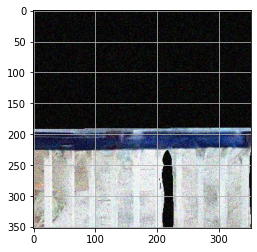

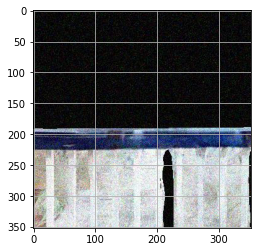

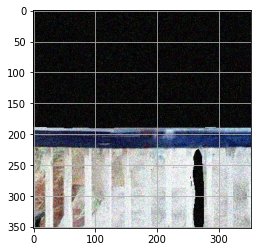

In [16]:
for trainIndex, (trainData, frameIndex) in enumerate(trainloader, 0):
    frame0, frameT, frame1 = trainData
    print("Intermediate frame index: ", (frameIndex[0]))
    plt.imshow(TP(frame0[0]))
    plt.grid(True)
    plt.figure()
    plt.imshow(TP(frameT[0]))
    plt.grid(True)
    plt.figure()
    plt.imshow(TP(frame1[0]))
    plt.grid(True)
    break

In [17]:
plt.rcParams['figure.figsize'] = [15, 3]
def Plot(num, listInp, d):
    a = listInp
    c = []
    for b in a:
        c.append(sum(b)/len(b))
    plt.subplot(1, 2, num)
    plt.plot(c, color=d)
    plt.grid(True)
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [18]:
L1_lossFn = nn.L1Loss()
MSE_LossFn = nn.MSELoss()

params = list(ArbTimeFlowIntrp.parameters()) + list(flowComp.parameters())

optimizer = optim.Adam(params, lr=INITIAL_LEARNING_RATE)
# scheduler to decrease learning rate by a factor of 10 at milestones.
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=0.1)

In [19]:
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16_conv_4_3 = nn.Sequential(*list(vgg16.children())[0][:22])
vgg16_conv_4_3.to(device)
for param in vgg16_conv_4_3.parameters():
    param.requires_grad = False

In [20]:
def validate():
    # For details see training.
    psnr = 0
    tloss = 0
    flag = 1
    with torch.no_grad():
        for validationIndex, (validationData, validationFrameIndex) in enumerate(validationloader, 0):
            frame0, frameT, frame1 = validationData

            I0 = frame0.to(device)
            I1 = frame1.to(device)
            IFrame = frameT.to(device)
                        
            
            flowOut = flowComp(torch.cat((I0, I1), dim=1))
            F_0_1 = flowOut[:,:2,:,:]
            F_1_0 = flowOut[:,2:,:,:]

            fCoeff = model.getFlowCoeff(validationFrameIndex, device)

            F_t_0 = fCoeff[0] * F_0_1 + fCoeff[1] * F_1_0
            F_t_1 = fCoeff[2] * F_0_1 + fCoeff[3] * F_1_0

            g_I0_F_t_0 = validationFlowBackWarp(I0, F_t_0)
            g_I1_F_t_1 = validationFlowBackWarp(I1, F_t_1)
            
            intrpOut = ArbTimeFlowIntrp(torch.cat((I0, I1, F_0_1, F_1_0, F_t_1, F_t_0, g_I1_F_t_1, g_I0_F_t_0), dim=1))
                
            F_t_0_f = intrpOut[:, :2, :, :] + F_t_0
            F_t_1_f = intrpOut[:, 2:4, :, :] + F_t_1
            V_t_0   = torch.sigmoid(intrpOut[:, 4:5, :, :])
            V_t_1   = 1 - V_t_0
                
            g_I0_F_t_0_f = validationFlowBackWarp(I0, F_t_0_f)
            g_I1_F_t_1_f = validationFlowBackWarp(I1, F_t_1_f)
            
            wCoeff = model.getWarpCoeff(validationFrameIndex, device)
            
            Ft_p = (wCoeff[0] * V_t_0 * g_I0_F_t_0_f + wCoeff[1] * V_t_1 * g_I1_F_t_1_f) / (wCoeff[0] * V_t_0 + wCoeff[1] * V_t_1)
            
            # For tensorboard
            if (flag):
                retImg = torchvision.utils.make_grid([revNormalize(frame0[0]), revNormalize(frameT[0]), revNormalize(Ft_p.cpu()[0]), revNormalize(frame1[0])], padding=10)
                flag = 0
            
            
            #loss
            recnLoss = L1_lossFn(Ft_p, IFrame)
            
            prcpLoss = MSE_LossFn(vgg16_conv_4_3(Ft_p), vgg16_conv_4_3(IFrame))
            
            warpLoss = L1_lossFn(g_I0_F_t_0, IFrame) + L1_lossFn(g_I1_F_t_1, IFrame) + L1_lossFn(validationFlowBackWarp(I0, F_1_0), I1) + L1_lossFn(validationFlowBackWarp(I1, F_0_1), I0)
        
            loss_smooth_1_0 = torch.mean(torch.abs(F_1_0[:, :, :, :-1] - F_1_0[:, :, :, 1:])) + torch.mean(torch.abs(F_1_0[:, :, :-1, :] - F_1_0[:, :, 1:, :]))
            loss_smooth_0_1 = torch.mean(torch.abs(F_0_1[:, :, :, :-1] - F_0_1[:, :, :, 1:])) + torch.mean(torch.abs(F_0_1[:, :, :-1, :] - F_0_1[:, :, 1:, :]))
            loss_smooth = loss_smooth_1_0 + loss_smooth_0_1
            
            
            loss = 204 * recnLoss + 102 * warpLoss + 0.005 * prcpLoss + loss_smooth
            tloss += loss.item()
            
            #psnr
            MSE_val = MSE_LossFn(Ft_p, IFrame)
            psnr += (10 * log10(1 / MSE_val.item()))
            
    return (psnr / len(validationloader)), (tloss / len(validationloader)), retImg

/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


21.1216951811291 44.939752197265626 torch.Size([3, 372, 2610])


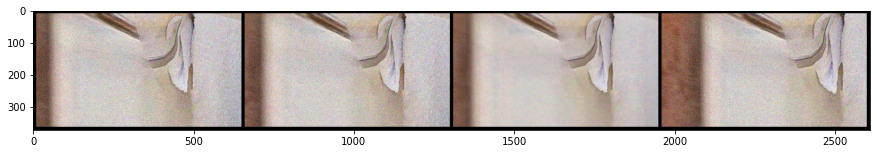

In [21]:
a, b, c = validate()
print(a, b, c.size())
plt.imshow(c.permute(1, 2, 0).numpy())

In [22]:
if TRAINING_CONTINUE:
    dict1 = torch.load(CHECKPOINT_PATH)
    ArbTimeFlowIntrp.load_state_dict(dict1['state_dictAT'])
    flowComp.load_state_dict(dict1['state_dictFC'])
else:
    dict1 = {'loss': [], 'valLoss': [], 'valPSNR': [], 'epoch': -1}

In [ ]:
import time

start = time.time()
cLoss   = dict1['loss']
valLoss = dict1['valLoss']
valPSNR = dict1['valPSNR']
checkpoint_counter = 0

### Main training loop
for epoch in range(dict1['epoch'] + 1, EPOCHS):
    clear_output()
    print("Epoch: ", epoch)
    
    # Plots
    if (epoch):
        Plot(1, cLoss, 'red')
        Plot(1, valLoss, 'blue')
        Plot(2, valPSNR, 'green')
        display(plt.gcf())
    
    # Append and reset
    cLoss.append([])
    valLoss.append([])
    valPSNR.append([])
    iLoss = 0
    
    # Increment scheduler count    
    scheduler.step()
    
    try:
        for trainIndex, (trainData, trainFrameIndex) in enumerate(trainloader, 0):

            ## Getting the input and the target from the training set
            frame0, frameT, frame1 = trainData

            I0 = frame0.to(device)
            I1 = frame1.to(device)
            IFrame = frameT.to(device)

            optimizer.zero_grad()

            # Calculate flow between reference frames I0 and I1
            flowOut = flowComp(torch.cat((I0, I1), dim=1))

            # Extracting flows between I0 and I1 - F_0_1 and F_1_0
            F_0_1 = flowOut[:,:2,:,:]
            F_1_0 = flowOut[:,2:,:,:]

            fCoeff = model.getFlowCoeff(trainFrameIndex, device)

            # Calculate intermediate flows
            F_t_0 = fCoeff[0] * F_0_1 + fCoeff[1] * F_1_0
            F_t_1 = fCoeff[2] * F_0_1 + fCoeff[3] * F_1_0

            # Get intermediate frames from the intermediate flows
            g_I0_F_t_0 = trainFlowBackWarp(I0, F_t_0)
            g_I1_F_t_1 = trainFlowBackWarp(I1, F_t_1)

            # Calculate optical flow residuals and visibility maps
            intrpOut = ArbTimeFlowIntrp(torch.cat((I0, I1, F_0_1, F_1_0, F_t_1, F_t_0, g_I1_F_t_1, g_I0_F_t_0), dim=1))

            # Extract optical flow residuals and visibility maps
            F_t_0_f = intrpOut[:, :2, :, :] + F_t_0
            F_t_1_f = intrpOut[:, 2:4, :, :] + F_t_1
            V_t_0   = torch.sigmoid(intrpOut[:, 4:5, :, :])
            V_t_1   = 1 - V_t_0

            # Get intermediate frames from the intermediate flows
            g_I0_F_t_0_f = trainFlowBackWarp(I0, F_t_0_f)
            g_I1_F_t_1_f = trainFlowBackWarp(I1, F_t_1_f)

            wCoeff = model.getWarpCoeff(trainFrameIndex, device)

            # Calculate final intermediate frame 
            Ft_p = (wCoeff[0] * V_t_0 * g_I0_F_t_0_f + wCoeff[1] * V_t_1 * g_I1_F_t_1_f) / (wCoeff[0] * V_t_0 + wCoeff[1] * V_t_1)

            # Loss
            recnLoss = L1_lossFn(Ft_p, IFrame)

            prcpLoss = MSE_LossFn(vgg16_conv_4_3(Ft_p), vgg16_conv_4_3(IFrame))

            warpLoss = L1_lossFn(g_I0_F_t_0, IFrame) + L1_lossFn(g_I1_F_t_1, IFrame) + L1_lossFn(trainFlowBackWarp(I0, F_1_0), I1) + L1_lossFn(trainFlowBackWarp(I1, F_0_1), I0)

            loss_smooth_1_0 = torch.mean(torch.abs(F_1_0[:, :, :, :-1] - F_1_0[:, :, :, 1:])) + torch.mean(torch.abs(F_1_0[:, :, :-1, :] - F_1_0[:, :, 1:, :]))
            loss_smooth_0_1 = torch.mean(torch.abs(F_0_1[:, :, :, :-1] - F_0_1[:, :, :, 1:])) + torch.mean(torch.abs(F_0_1[:, :, :-1, :] - F_0_1[:, :, 1:, :]))
            loss_smooth = loss_smooth_1_0 + loss_smooth_0_1

            # Total Loss - Coefficients 204 and 102 are used instead of 0.8 and 0.4
            # since the loss in paper is calculated for input pixels in range 0-255
            # and the input to our network is in range 0-1
            loss = 204 * recnLoss + 102 * warpLoss + 0.005 * prcpLoss + loss_smooth

            # Backpropagate
            loss.backward()
            optimizer.step()
            iLoss += loss.item()

            # Validation and progress every `PROGRESS_ITER` iterations
            if ((trainIndex % PROGRESS_ITER) == PROGRESS_ITER - 1):
                end = time.time()

                psnr, vLoss, valImg = validate()

                valPSNR[epoch].append(psnr)
                valLoss[epoch].append(vLoss)

                #Tensorboard
                itr = trainIndex + epoch * (len(trainloader))

                writer.add_scalars('Loss', {'trainLoss': iLoss/PROGRESS_ITER,
                                            'validationLoss': vLoss}, itr)
                writer.add_scalar('PSNR', psnr, itr)

                writer.add_image('Validation',valImg , itr)
                #####

                endVal = time.time()

                print(" Loss: %0.6f  Iterations: %4d/%4d  TrainExecTime: %0.1f  ValLoss:%0.6f  ValPSNR: %0.4f  ValEvalTime: %0.2f LearningRate: %f" % (iLoss / PROGRESS_ITER, trainIndex, len(trainloader), end - start, vLoss, psnr, endVal - end, get_lr(optimizer)))


                cLoss[epoch].append(iLoss/PROGRESS_ITER)
                iLoss = 0
                start = time.time()

        # Create checkpoint after every `CHECKPOINT_EPOCH` epochs
        if ((epoch % CHECKPOINT_EPOCH) == CHECKPOINT_EPOCH - 1):
            dict1 = {
                    'Detail':"End to end Super SloMo.",
                    'epoch':epoch,
                    'timestamp':datetime.datetime.now(),
                    'trainBatchSz':TRAIN_BATCH_SIZE,
                    'validationBatchSz':VALIDATION_BATCH_SIZE,
                    'learningRate':get_lr(optimizer),
                    'loss':cLoss,
                    'valLoss':valLoss,
                    'valPSNR':valPSNR,
                    'state_dictFC': flowComp.state_dict(),
                    'state_dictAT': ArbTimeFlowIntrp.state_dict(),
                    }
            torch.save(dict1, "./SuperSloMo/data" + str(checkpoint_counter) + ".ckpt")
            checkpoint_counter += 1
        plt.close('all')
    except:
        print(trainIndex)

Epoch:  0


/opt/conda/envs/habitat/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 Loss: 45.948476  Iterations:   99/14443  TrainExecTime: 113.1  ValLoss:44.742399  ValPSNR: 21.1640  ValEvalTime: 7.23 LearningRate: 0.000100
 Loss: 45.823006  Iterations:  199/14443  TrainExecTime: 118.7  ValLoss:44.841064  ValPSNR: 21.1300  ValEvalTime: 8.39 LearningRate: 0.000100
 Loss: 45.925466  Iterations:  299/14443  TrainExecTime: 125.9  ValLoss:44.705769  ValPSNR: 21.1605  ValEvalTime: 8.23 LearningRate: 0.000100
 Loss: 45.523748  Iterations:  399/14443  TrainExecTime: 128.1  ValLoss:44.620980  ValPSNR: 21.0998  ValEvalTime: 8.28 LearningRate: 0.000100
 Loss: 45.339440  Iterations:  499/14443  TrainExecTime: 128.4  ValLoss:45.051866  ValPSNR: 21.1464  ValEvalTime: 7.96 LearningRate: 0.000100
 Loss: 45.831211  Iterations:  599/14443  TrainExecTime: 127.6  ValLoss:45.061584  ValPSNR: 21.1195  ValEvalTime: 7.72 LearningRate: 0.000100
 Loss: 45.058498  Iterations:  699/14443  TrainExecTime: 128.2  ValLoss:44.759362  ValPSNR: 21.1160  ValEvalTime: 8.43 LearningRate: 0.000100
 Loss:

In [22]:
dict1 = {
        'Detail':"End to end Super SloMo.",
        'epoch':epoch,
        'timestamp':datetime.datetime.now(),
        'trainBatchSz':TRAIN_BATCH_SIZE,
        'validationBatchSz':VALIDATION_BATCH_SIZE,
        'learningRate':get_lr(optimizer),
        'loss':cLoss,
        'valLoss':valLoss,
        'valPSNR':valPSNR,
        'state_dictFC': flowComp.state_dict(),
        'state_dictAT': ArbTimeFlowIntrp.state_dict(),
        }

In [23]:
torch.save(dict1, "./SuperSloMo" + str(2) + ".ckpt")

In [26]:
"./SuperSloMo" + str(checkpoint_counter) + ".ckpt"

'./SuperSloMo0.ckpt'

# ENV

In [9]:
import scipy.misc
import shutil
from imageio import imwrite
args_list, env_configs = multiple_config(args)
config = env_configs[0]
config.defrost()
W = 256#640
H = 256#360
#config.SIMULATOR.RGB_SENSOR.HEIGHT = H
#config.SIMULATOR.RGB_SENSOR.WIDTH = W
#config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
#config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
config.SIMULATOR.TURN_ANGLE = 10
config.SIMULATOR.TILT_ANGLE = 10
config.SIMULATOR.FORWARD_STEP_SIZE = 0.25#0.05
config.freeze()

In [111]:
env.close()

In [10]:
env = MyEnv(config=config)

2020-05-28 16:01:53,355 Initializing dataset PointNav-v1
2020-05-28 16:02:04,177 initializing sim Sim-v0
2020-05-28 16:02:08,915 Initializing task Nav-v0


In [11]:
!rm -r ./one_video
os.mkdir('./one_video')
obs,info, done = env.reset()

In [12]:
conv1 = nn.Conv2d(6, 32, 7, stride=1, padding=3)
conv2 = nn.Conv2d(32, 32, 7, stride=1, padding=3)

In [13]:
x = torch.cat((torch.from_numpy(obs['rgb']),torch.from_numpy(obs['rgb'])), dim=1)

In [14]:
i = 0
while not done:
    obs,info,done = env.step(2,ideal_action=True)
    imwrite('{}/{:>3}.jpg'.format('./one_video',i), obs['rgb'])
    i+=1

In [15]:
obs['rgb'].shape

(360, 640, 3)

In [116]:
!ffmpeg -framerate 20 -pattern_type glob -i '/root/TEST_FRAMES/Super-SloMo/one_video/*.jpg' -c:v libx264 -r 20 -pix_fmt yuv420p /root/TEST_FRAMES/Super-SloMo/out.mp4 -y

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [16]:
mean = [0.429, 0.431, 0.397]
std  = [1, 1, 1]
normalize = transforms.Normalize(mean=mean,
                                 std=std)

negmean = [x * -1 for x in mean]
revNormalize = transforms.Normalize(mean=negmean, std=std)
transform = transforms.Compose([transforms.ToTensor(), 
                                normalize])
#TP = transforms.Compose([revNormalize, transforms.ToPILImage(),
#                        transforms.Resize((352, 640),interpolation = Image.NEAREST)])

In [17]:
extractionPath = './one_video'

In [26]:
videoFrames = dataloader.Video(root=extractionPath, transform=transform)
videoFramesloader = torch.utils.data.DataLoader(videoFrames, batch_size=1, shuffle=False)

In [29]:
videoFrames.__dict__

{'origDim': (640, 360),
 'dim': (640, 352),
 'root': './one_video',
 'framesPath': ['./one_video/  0.jpg',
  './one_video/  1.jpg',
  './one_video/  2.jpg',
  './one_video/  3.jpg',
  './one_video/  4.jpg',
  './one_video/  5.jpg',
  './one_video/  6.jpg',
  './one_video/  7.jpg',
  './one_video/  8.jpg',
  './one_video/  9.jpg',
  './one_video/ 10.jpg',
  './one_video/ 11.jpg',
  './one_video/ 12.jpg',
  './one_video/ 13.jpg',
  './one_video/ 14.jpg',
  './one_video/ 15.jpg',
  './one_video/ 16.jpg',
  './one_video/ 17.jpg',
  './one_video/ 18.jpg',
  './one_video/ 19.jpg',
  './one_video/ 20.jpg',
  './one_video/ 21.jpg',
  './one_video/ 22.jpg',
  './one_video/ 23.jpg',
  './one_video/ 24.jpg',
  './one_video/ 25.jpg',
  './one_video/ 26.jpg',
  './one_video/ 27.jpg',
  './one_video/ 28.jpg',
  './one_video/ 29.jpg',
  './one_video/ 30.jpg',
  './one_video/ 31.jpg',
  './one_video/ 32.jpg',
  './one_video/ 33.jpg',
  './one_video/ 34.jpg',
  './one_video/ 35.jpg',
  './one_video/ 36

In [19]:
flowComp = model.UNet(6, 4)
flowComp.to(device)
for param in flowComp.parameters():
    param.requires_grad = False
ArbTimeFlowIntrp = model.UNet(20, 5)
ArbTimeFlowIntrp.to(device)
for param in ArbTimeFlowIntrp.parameters():
    param.requires_grad = False

flowBackWarp = model.backWarp(videoFrames.dim[0], videoFrames.dim[1], device)
flowBackWarp = flowBackWarp.to(device)

In [20]:
dict1 = torch.load('SuperSloMo.ckpt', map_location='cpu')
ArbTimeFlowIntrp.load_state_dict(dict1['state_dictAT'])
flowComp.load_state_dict(dict1['state_dictFC'])

<All keys matched successfully>

In [21]:
outputPath = './one_video_10x'
frameCounter = 1
batchIndex = 0
os.path.join(outputPath, str(frameCounter + 10 * batchIndex) + ".png")

'./one_video_10x/1.png'

In [22]:
import argparse
import os
import os.path
import ctypes
from shutil import rmtree, move
from PIL import Image
import torch
import torchvision.transforms as transforms
import model
import dataloader
import platform
from tqdm import tqdm

In [25]:
I0.shape

torch.Size([1, 3, 352, 640])

In [23]:
frameCounter = 1
!rm -r ./one_video_10x
outputPath = './one_video_10x'
framerate = 10
os.mkdir(outputPath)
with torch.no_grad():
    for _, (frame0, frame1) in enumerate(tqdm(videoFramesloader), 0):

        
        
        I0 = frame0.to(device)
        I1 = frame1.to(device)
        break

        flowOut = flowComp(torch.cat((I0, I1), dim=1))
        F_0_1 = flowOut[:,:2,:,:]
        F_1_0 = flowOut[:,2:,:,:]

        # Save reference frames in output folder
        for batchIndex in range(1):
            (TP(frame0[batchIndex].detach())).resize(videoFrames.origDim, Image.BILINEAR).save(os.path.join(outputPath, '{:>4}'.format(str(frameCounter + framerate * batchIndex)) + '{}'.format(".png")))
        frameCounter += 1

        # Generate intermediate frames
        for intermediateIndex in range(1, framerate):
            t = float(intermediateIndex) / framerate
            temp = -t * (1 - t)
            fCoeff = [temp, t * t, (1 - t) * (1 - t), temp]

            F_t_0 = fCoeff[0] * F_0_1 + fCoeff[1] * F_1_0
            F_t_1 = fCoeff[2] * F_0_1 + fCoeff[3] * F_1_0

            g_I0_F_t_0 = flowBackWarp(I0, F_t_0)
            g_I1_F_t_1 = flowBackWarp(I1, F_t_1)

            intrpOut = ArbTimeFlowIntrp(torch.cat((I0, I1, F_0_1, F_1_0, F_t_1, F_t_0, g_I1_F_t_1, g_I0_F_t_0), dim=1))

            F_t_0_f = intrpOut[:, :2, :, :] + F_t_0
            F_t_1_f = intrpOut[:, 2:4, :, :] + F_t_1
            V_t_0   = torch.sigmoid(intrpOut[:, 4:5, :, :])
            V_t_1   = 1 - V_t_0

            g_I0_F_t_0_f = flowBackWarp(I0, F_t_0_f)
            g_I1_F_t_1_f = flowBackWarp(I1, F_t_1_f)

            wCoeff = [1 - t, t]

            Ft_p = (wCoeff[0] * V_t_0 * g_I0_F_t_0_f + wCoeff[1] * V_t_1 * g_I1_F_t_1_f) / (wCoeff[0] * V_t_0 + wCoeff[1] * V_t_1)

            # Save intermediate frame
            for batchIndex in range(1):
                (TP(Ft_p[batchIndex].cpu().detach())).resize(videoFrames.origDim, Image.BILINEAR).save(os.path.join(outputPath, '{:>4}'.format(str(frameCounter + framerate * batchIndex)) + '{}'.format(".png")))
            frameCounter += 1

        # Set counter accounting for batching of frames
        frameCounter += framerate * (1 - 1)

  0%|          | 0/57 [00:00<?, ?it/s]


In [125]:
!ffmpeg -framerate 20 -pattern_type glob -i '/root/TEST_FRAMES/Super-SloMo/one_video_10x/*.png' -c:v libx264 -r 20 -pix_fmt yuv420p /root/TEST_FRAMES/Super-SloMo/out.mp4 -y

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

# Generate my_data

In [40]:
!rm -r ./my_data
os.mkdir('./my_data')
obs,info, done = env.reset()

In [ ]:
fl = 0
for i in range(30000):
    obs,info, done = env.reset()
    ii = 0
    while not done:
        obs,info,done = env.step(2,ideal_action=True)
        if ii%12==0:
            sch = 0
            folder_to_save = './my_data/{:>10}'.format(fl)
            os.mkdir(folder_to_save)
            fl+=1
        ii+=1    
        imwrite('{}/{:>3}.jpg'.format(folder_to_save,sch), obs['rgb']) 
        sch+=1
    sch = 0    
    ii = 0
    if sch!=11:
        shutil.rmtree(folder_to_save)
        fl-=1
    print(i,'\t',fl)    
            
#    break

0 	 24
1 	 69
2 	 106
3 	 138
4 	 155
5 	 197
6 	 240
7 	 269
8 	 301
9 	 327
10 	 358
11 	 405
12 	 429
13 	 461
14 	 492
15 	 522
16 	 548
17 	 580
18 	 610
19 	 663
20 	 1079
21 	 1121
22 	 1153
23 	 1569
24 	 1602
25 	 1630
26 	 1696
27 	 1748
28 	 1782
29 	 1832
30 	 1866
31 	 1909
32 	 1944
33 	 1971
34 	 2013
35 	 2429
36 	 2485
37 	 2515
38 	 2546
39 	 2586
40 	 2613
41 	 2661
42 	 3077
43 	 3102
44 	 3144
45 	 3205
46 	 3242
47 	 3277
48 	 3321
49 	 3367
50 	 3443
51 	 3460
52 	 3478
53 	 3495
54 	 3516
55 	 3546
56 	 3557
57 	 3583
58 	 3608
59 	 3636
60 	 3652
61 	 3679
62 	 3706
63 	 3732
64 	 3741
65 	 3769
66 	 3793
67 	 3823
68 	 3839
69 	 3866
70 	 3887
71 	 3914
72 	 3952
73 	 3982
74 	 3996
75 	 4011
76 	 4043
77 	 4067
78 	 4099
79 	 4128
80 	 4161
81 	 4182
82 	 4211
83 	 4234
84 	 4260
85 	 4281
86 	 4309
87 	 4330
88 	 4350
89 	 4372
90 	 4413
91 	 4478
92 	 4530
93 	 4578
94 	 4605
95 	 4653
96 	 4709
97 	 4773
98 	 4841
99 	 4886
100 	 4922
101 	 4988
102 	 5020

In [24]:
os.listdir('./my_data/        24')

['  1.jpg', '  0.jpg']

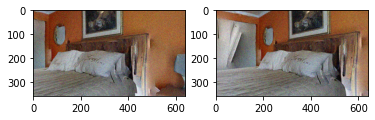

In [43]:
plt.subplot(1,2,1)
plt.imshow(im1)
plt.subplot(1,2,2)
plt.imshow(im2)

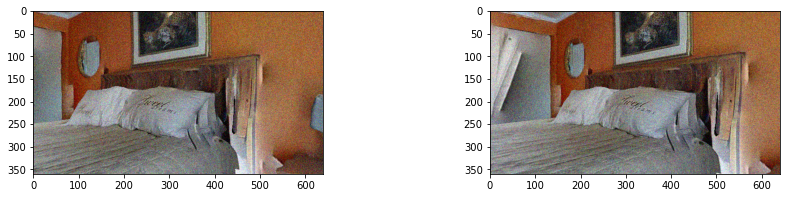

In [27]:
plt.subplot(1,2,1)
plt.imshow(im1)
plt.subplot(1,2,2)
plt.imshow(im2)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAxIAAADGCAYAAABGg7ZvAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+j8jraAAAgAElEQVR4nOzdScw1WXrg9f+ZYo47v9M35JeZla4qY1dD0zRItITEAgESCLFADBt2vUAsWLBgyRaxZtMLJHaIHQK1uoXagsaN1bawje2qrKzKrBy+6Z3uGHPEGVi81cgtu0SXRKra5v52cSN0T9wYnuc8EXHiihACZ2dnZ2dnZ2dnZ2dnvwz5q16Bs7Ozs7Ozs7Ozs7O/eM6FxNnZ2dnZ2dnZ2dnZL+1cSJydnZ2dnZ2dnZ2d/dLOhcTZ2dnZ2dnZ2dnZ2S/tXEicnZ2dnZ2dnZ2dnf3SzoXE2dnZ2dnZ2dnZ2dkv7VsrJIQQ/4YQ4jMhxOdCiP/i22rn7Ozs7OzsL5Jzfjw7O/vLQnwb/yMhhFDAT4B/DXgD/B7wH4YQfvT/eWNnZ2dnZ2d/QZzz49nZ2V8m39YdiX8R+DyE8LMQwgj898C/8y21dXZ2dnZ29hfFOT+enZ39pfFtFRLPgdd/avrNzz87Ozs7Ozv7/7Nzfjw7O/tLQ/+qGhZC/E3gbwIYLf/a9apAEKOEwAqBR6JlQErwOsIHB14DASkEXgd8CCgr0EphRUBbcCrgvcRJENoieo0NHmknZHBYHAHwBLQNBGlAOLwSCCfwUmCCQEhF8B4ZCQIa7yEEiTIOGcTTt9hA0AoZAsEFXLDQt4RpgOAI3gEaGQUYAw5QUiEJeOFRUuCFgskRhEd4gYsgspIAiKcthZSB0Vl8UGgBQgaEAO8kQgEBkAEfnupCHTxCCmwAJQI+CEKIQI5I4REOhFZY4Qm9wkuYgCAkUinyWY6UEu8lSgn6oaE+VowWpJJ4At56CBovnh6NUz7gVUAj8MHhpEAHgQgghEAbwxQ83o1IqRBeITRkuSGWCuckbrQ4CUpLwCO9w7qBMElQmiiLCM7RtiMaidQSoSxCGNxkEQgUiimADx4TC8JoscExBUFkDEpJrA2EYWLyErwDA8IFvBSkeQIBVrM1SIkX09N+ERpFAAH9aU/AEkWStrUYPEpqrO9IhEYKGJEI6xFSIqVDAqMICO9QXhMEoDXeB7QAGwJaSbx/OjaVDwgZcAGCEEhGcAohBUEJEAJw4EDIiCAtjAGJBOXwgPSAEgQhCJMnSJAEhNCE4JEiAIExSJRXoJ7aJkiUGAnCIN3T/nVCoH3ASYEMAaE9CA0u4IQgiIDCYK1FAiIEEJ5RSLQIEALGSZyWBPe0HREQ+EfzHZP0yCCfzjuh8DKgrMQ/HdTgA0ELsB6kxHnQHrwOKAtaCSYvcd5jELhgCQYiBBOS4EEEiRTg/VNsUcHjpcJLwdcP1WMI4eLbjn1nZ/8k/nSOjLT8a1dljpPhKX5L8N4gpUTrgBcx2iikEQghcFKhvMQjCcKCdTgPwXuiSBGIEEbhgkIC0gcmCeARQiKVxwsQNhDc0/pIBM7/ozhi8cHjrAdr8dbjCIjgn/ItFukkIRIILwguIFTAeRAhxkmLkgHpBMqD0+FpPXmKTcIpgnYIB15olJA4JvCCYJ5ihHAgRSAoQEqEF0g0SimeZmq8BSkDk1QYGWAEgSAIB8ITBISuZRgGlHcoD4iAD0+/1wsAhwoSpwRKeoJXBBNQo/95PwVQgcmDCk/9BGTAOYeRAq81YrI4GZ7mO/Pz+OkJTiB4yj1SStpuAqGRsSLJSrxRKBEIXjI0NV0/4V3ABo/wHuRTvEYonHBo6QleEnxACfAIXAgoBcZI8ALnnnpAAkmcSCJVoNSAcyCdeto+sSQES7Aj0+DQiSGJMpI4YvKW6nAADMEI5ORBegQCqQ3T6BiCe8r7UuKmEek83hi00Dgx4TxIExP6ick5gnjaDtZ7llmE94JivkQKSRBPvSElwAsPQuFDy3DoyQpN7yeG2qGURIWJiIBWAbzC+0AAghQoBCJ4hPA8ZeSnfoYPmoBFKI3UnoAneIEQHuENwQW0cQSv8d4jpcT5gMAhlMAFgbIBFAj59J38vF8krMQH8XS+4kCCnCROShCOgEcIhQKC9Agn8eJptwohmbB4odEIEIFAIFiFkRMuBDwCoQQogRlhwiGDAhziqWOIDRqtwAqQwUMQBBlQQvHzVcIGC1pBAO8t+qmXikQ8nVsIhLN8vuv/3Bz5bRUSb4GXf2r6xc8/+3+EEP4W8LcAbook/Gffu6KeC167JRejZpNeM90sufz4FftUsnIDhci514ZYBHpb09mBprvguoyIpivkC8V+soSFw1U52gXqVjF1D+isY+ENdXcgqzxj1zDMWoZTRHvcMSUR6UxhveFZoQnhI9rDSPmsIXggTRnHCvGwIiygZ0B0PS6ZSF7/CYfP7qiOr3HBsHnYEb1IqZxCVRG4jmF1QdpKvPPo8cjj0JMvFGL1jNhW7FvHkpZ9FBE9LtnMe6Qx2O3EMpfs8o6jgqVdM3kwbYP0A/mzDtulPB4Cs7zjLtZseoUOFhFfsZkaHlzEKA8kaoGJHCkjNlL0xrGtNoij46tjT32zxJmMf/1f+JeJr2+YZEYbBb746g/42T/4I96+fs9oU1Tc0J5GrhK4VQn1CeTSk42OcixwQ0OzMDhnyUaHsBtuIsndcCAUGdksxtkTkRq5vpzzPNpglkusq2hJyPSAlJbf/MBhugs23/sBf/XVd7AZnG4b/rv/5n/g5AbkImbbvmH9wccM9ZFX6hV34p7bb06cpOFm6ehvO8I0cDSSl+oad9VQjC95TPZsf1TR3A88Xu+Q73LE/MS/8oMfcHpc8O/+J/8ek0lgeMeCGX2Sc5xGbsaKn/z4d8Bpymzih+9/gjkYfs1kdF9/xscbh11L3hwMs2SFrCPCpiLqDdvHnLXe4l80DF3C1XDFKT0SIjDakvYpVjXs2oh13kGcML47YlYrbu0DZZSR2B7vPIZL2vAekS6YlOCiVrQIsqLjtBxwpxqjryjmivsHhesdZi5Jhi3p8QoVjZzahn6VMLc5j8uOzdEj1JpHOTEzPbnqqI45UxeB69nNLC9Uy17PyIcIGfVYrxmnFJkbovYA+R5bv0CUNfNopNkFhv0CVUQYdcQrBVlg2mUMRUI2fE2kcnZlTNR5qN4TT3+FePnI4A3G78maGcwmrOoZm57AC0y4ZVAJTQ9iliCdI112JCfDo864jCPMdk8fcthbTpFgjALt3HAxSnodyF1H3UVczE58M7viP/+v/97X31I8PDv70/5f8yP84zny5WYR/st/+zfBGg6LI9njcywjZe5oT3vus0t857iZMswnJaOesSyfkW4+wq08zdij9oHu+IYYR8wScZMxu/gIHwmUvOZUejhoGhcjZgFtC/rxwCxy2F7RZ4LoeKAKHVkYuOsjZNeh7MimUsjowIM8UXOk+lQzNO9JCo1qBg5hy+oixR4kLvdUkUe8G5mFApdNjK4g9vf44Yo2PqLsAl+eWLeKn3q4kJqpPZIVFyyC5Y1OSPOWXPYckwXSR6RjRJNFXM5KumbExCtEPjDtrxAverrGs5SWlAOu2zO+rvnh6z/B3L0jPA5sZCDJJlw6Er7paRYx2YcRyf3E4ehZzwtCXzHuZqQvFEMCaj+hkwy6Ee01w1zg3IlZFdG9UuiTIIsDggVbt8cnHfndDJtYotyQ71Ie8gdsF1PowOfvPK+vNXl5xV/9638DdfEMkxna3cTt7/1dPv38Ddvtide+wpwyTOEpFfQO9vOAbiRG5PRi5Nl2YEg8RzLK2cj6pqA/pHy9t1zpHl1A7Gu+9/0SYW8w5oJxeKBUL7nYHKmrwPwGvru44eYH3+Xq4++T1A2///Zz/sf/6beY25RHaxH3r3m2ueJeRDxODc/Wz/jJT265rgWHtOJQthS7Izf5X4GXlvp+R7U9IWYbhtJy97u3EGlao8iF5a//q59QvR/5N//jf4us/g7WGIQ8YcYI80Li77c8Vm/54f/x2/xL3/su32zf8eM/OfAbmxX+9GM+EIG4WFAMgbuNpxhbvIoQqUcfZvj0lkNyQVz3SO3ooh15B6kuUNLwespQKVyPLQe/RO0foRBsnCaXE48mo3URLm35UFnejQLXRby8sIw2ook8h+3IfC7I4oT6AULsCX2HVwotBvrIMPOCTuacwh0+ykhYUVQDnZeMYo9nQ6o7jmlGqfZk9pKQxuyrhuuZp88MyUNHk0j0ZWB6+7Q/XklL2juc2vI4Jfg8w7wSNLc5ySAwDzXds8CmuWTrGkoLKjng+gIxWXQcUCLiqEZiHaOCpM1ayqTn3/+vfvTn5shvq5D4PeDXhBAf/TxA/gfAf/SLFhYGfBZYhHeEY0adV3x1/IKoXfB2+8dkzYphkfDBJx+QJBuyUhCPA3Wd8GrW0nhwmyP2AMIotgdY70BFGlJFXi1x6cdku4FuMcesOuJoJNpK1KVFvLlAxgNFI6lXPdtRMww9LkmIk4ik9Qz7hG0iyeeK8lCThB0/O1RMX/8I/fYnqG1F8UyRxpYGi/Aji1CwMAlfMpH81JLdSBolaHNBvrgiEu8R77/CZJpnjaLLRsphgfIjfhox2hA2A+/3gk56LvKMyW3RU0yVNRBnqGBwkUUnA49yyXqaSA6B8SZC1453ZmTtHdtBM8kFjegImaQZblC+RiKYiSP5s4Awlp037HzOd8XIXuSorqOcFLKfkC6niy1hmpAq52HsGKOJYpUSYkva31DJW0wSkQ+Kw0zRd4Is3vFuWTJNeyKbMPN76gziKufwYBleRCyPAd/VmHXG0OVsso58/R1+/cWG1arA65a7JuPTz15TrnMekTzXoIhJ6gmtYv7P11/xGx98RB8EbXfHbpRs60CmJFfPP2FUe8z/BZ+Vn/L84++gUkG12MIkqVJBZhSUNZno2Q5b9IuC53dzVHAkquFgao6d5n7fs76oaJYx5dc170dPJdcckjkXFx1FW7Be15xugfmAKQxvnOT6+zXDW0dyUMSpp53VDFiUcigsd/GRtJixFg1CzOnkRJhdkrsjeipxM0cTxyRdyp1OSIeMSEM8eI6ppdklmKRGf1Wiy4S2UxhlWBDzoPYsp5jTsKQsJhpTsFYxn0eWi2pgpo6cxAw1VUjhiQZ4T0Ec98geImWZxXMim2GsIJce21iETqEf8K0irD11nnIhHaGa07W36HVK0xTMZ3twA9XhCictF8nE8SS4SjMOSMwpZxrfslovqU8BZTTi8J4uuaEKFWZUJHlgKNfMBByUw+BYFYZGTSxcQrft8ekVc9vzbqzI85y8ERxNSjvrWKcKJ0q8P+CPCRiHNYGjhQ8Ph28pFJ6d/Rm/VH6Epxt49TFhle6JyEntW+K0oG1GzHxkNhywxOyDYPijB/KZ4BB+xGo+Zxw6mnnKavHPMM870sxR1zXuYcXD8RbbTqg4Z3VZoGYzPpKX3FYrCgXH1OKSlKMQiP4rpHtBGCKitOJirtknitl+ZHgVYeueZDZxXTxj13mOzQVuMTA87Mi7JYN7zRRScjlSdBJWDbiB6DEgzWumuaYLDRdTwIlbmkPEIdVskhElI9LmgjGMNJHF24kkXpBHgilKcacrisIgo0Cfx5SRJDkuqcwJH2/R9x2LoyZdN9jqpzz84Y/57O6Bq7pFZ57ZSnNwCU4KFrPAsHZ0Y0J80DCLCIlHnSSDULhXKbYayKqOe5EzxicWkyfPNKE3aJegQkS027MVG4I6otIK/9DhtppWtJixoHMRg35gHm0w3cBResKyJj46ZH3EV57lRwJpOxLX8P5CwmEOQ0t5e0H+bMt+H9N5gxxbmDyDy9nMdsQhpVcl3VJT9CMqCA6nkoxH5mvBzPZ0qSJC075TmNUKIY5sbx9JriSPB0f+z9/wg3RF8VIwY0dvD9Rtwz/47d9mrgwP+yPLckV5/RH7bkckl0S7PY/DHWVeM34ZYz7IKZG4Gljs6e5LluElwf6EqTEk6wPT1YzjaNFxh9mNxE1DN96Qvv+Ai7Wgy98g9ylvb1JmduD5Ys705hGpFOZVjMpS9PuByfSoXLJvJpb2niAL5ClhqBdEjOibkXZxQs1nJMeGkE6Uk8DHOcIpurhFakN55zGlw2YLssohck2ZevR2zlafsGLCyAEjM+6PJ1CGNGkIwxovaqouIzaSsat4dKBSRxQ6xvmauZO0XpB6DXmOeT1ycXPN1Arawx3zfE267KnrFcdRIqOJWW1JFjOKUVDTkfuRyo1kredoI1CB+HWgrx+4ziO0i+h1zMicPBislZg3ARFGBjejKEbsqUeXt6wF1F2O9RJjNH7ePt3pb2ImXRDqnvk8YFkyWAf8+e+D+FYKiRCCFUL8p8DfBRTw34YQfviLllfeE8QJjtfkm0fKAA8250LVnOqerT8h3ig+375lSGKuiozk2ZJi3NBfXdB//jXtnSRNR+bzj/henKODZwgpTjrGTYoTd5yWKWXhOLYJqVqRmArwzD+aMTQ1zaql7CR9IljUGe5S4JuIveoIbsvLaERtI9zDH/PDr3/M+LMtZTIh6ZGjJ7nzpMmJXqywjcO6Nf1UIYOjK1taG1jmJd460rpGqiWdHsGfOIgl05gxcy1hKZiqEZlZGmnJlwW590jT0/SaOBzwcoM8BaYXnvJdQLiSmSqo0h3uUpC7NWNsOWUCO9WE25fw4pG5SGBUuLGnvrdcbSyPZk6tHZYZH+iKmbxjcJ/gRk+eDRReszCGL2yD8o8cbMY6VLRRIGhN5UfSd44xa3CJQofAacxwO4udjaQmUEiLHi/Yb1JsyBCDoAsjtj6SPjywc8/QIVDsT9jvK9KrXyfpYxJRM85fUsaXbP/hG37vH/4WVT9SuY5nLz7gufiEN+3AkLfIWLDbHtnFIKIlm5uW6bMed18zfbIlf3jG9Dda3OeBH315S3z5HB2/xTQecdwThQVx/B3q7oDREfOdYpQVdvKM+ceE00Q+P0FhGbVjnsz5pl0SCUeithTJyNhI3Msj/cNAv5iIyiUhOG4WCtG/I4meMXCJcA3WWWLrmGSLSBPKXmMSSa8kw21NJ3ueyxnx0jAfB3xdEg+gyj1y6OmbBZOzLNTIwzJmdaWZxgV+IUmto+08g4xoX9xj6oi+NUgcp8ah5Ik2SGbqyH1+RVSvkIWlMw+kbcKWBbPojtGkZEtDlEfUdc87NRCLC6ZxwMwH6r0ly1MOY4OKDPYQs7eCUmyxSSCeFBlv2GmB6iRj0bOYYGgsKjlxEpad3JANFfMs5XGXcJF2DL4lqpZoPbG8zGnDxOEEzVCTLQfKcU6cOKrOk4gRFamnR8Nev8EtriDvqTsLySVxeyKMNaOfs1i9ww0Sn98ToiV5KzmNGqz6NkLh2dmf8cvmRwCDQ1y0eKnJ+poprIiziYMLrF0gO8BCByrzJXquOPaGRVaQ799yO47kbsb48L/w5rCldkvcfM5qUdKKJS6LCIkj03e0P5Lc2zlcWL6ZPSfb3DBXJTcyI5RX+KSl3GlMrhAqJbISabZUZUyunzG0FqHuCBuYFTlRSOhWH0N5R39UxFlGnU/wxjDNf8LY909Xi9VILxdMqeBRRCSjInc9gwr0xnGwgfjFAvzAoVOYm1tk4xn0Ct3AcSHIo5aZfsYUJrLK4fWe7HEBssLaiNn0BV/87h/j7+7Zte94cW8gCcR2hERRuJ64NfSlRi5yLpsBBkmYPONx4FSWeCx9t2W4bCkOJUXRMzWSNI2JogkROayIOIRANcYU/YSRBcm2JwHUtea+94y9JdvkKLNi247kbkDEHeEYkS9m1Eny9Lhyc0QmDh+VnEJJduj4rO/ICs/9sCRJHrF9yagtcx/Tr7fcB03cjsxEoJsCIXaIQZPdxfQyYZ5ZpqKgisC0I5897Fi3XyLXOctFQtU15EWOqS1fuhP/rHiG21xgvxr4rf/57/Dw9efoyzVRZLDuxE/v3/LJ1Qu6Ysfa5NyfBHkVWH/nOQfxlqlNMC/e826sMTrh9RTR8cBFYgifawo5Ym1CPuywaUk2XHP6qGY9H2j0jLy17GxP2QSSVHBXadL1jFfXhs3VJfdf9yw3OzZJR/NFjVoIvFhjc5CNxT8f2L6dcXE4kSQFlbck2uFaGJuYkAS8sIR7TxprlB04TEcu7JbgS8gvqIdb7M3PmLMg0hmiaxn0gfzygmqnSeWOh3JJeBjJRIzXikkaisYRRT3r5Dl7f88iThncHGkbwt2BJr0i2j2Q9jG7TFP3EXrYkhjNKDzaKxZRw5c+QecTqneoEKOPilqAMpLs4NE+Q4qAPLU8+ANlmUJbMqY9+36BGSVJcUR0Lf1HDtlY3lQr1gD2SIgc/aTIbIoLhnay6GJgFhSDk1hfI230C+PTtzZGIoTwt4G//U+yrAoBL2NOF4o+ciyrgas8IH1Dfrwgj2pKdcGXcUc6f8uuj3l48xypP+Xj3++5VznxlwITer7JP6VWAakWfLD+kOjFM6KiQKuSgxtJO8dmSDjqgT6L2HHicr4hSzXeLDDvH5GNYExi6n5HUTrknSHsHY/Vj4m/esvx/T3x6T0zHTPGI0WjMTcB3MTbkKNrgesjyuSWb1yGVFes9Ts6oynGmjyynNSEs4ZBKMpqxnwmGEXAFB7ZT1gboSooxUATP405SLqSJJtYqBny2KJNx+lhgYw0TavImZj3hikdScKRYCwmTHS9JjyriU/QuJEyzShCQM4HxlPMvJRkrz3HVyP39zuejw4lr3Gqpgk5Jz9wjBKmYmLqJblIsVGBjk6MVpE0LSYZmLxHiJQQNSTC0wdH4RPCPuNYOp67FenxDdOUgl/hC0+Gpo5HlPsJrotw7cSr4RVF9Q136ZzL44rmjebzn/42/+vf+XvIRUTkoNQr7Cnwx9VnLF5+hBmvuEn3CDsQt4+o+ZLH94FYZzRXgTc/q2j9p1zsDP5wZBXnHPZHMjUjlB3TvkUUDY3fIYPnpq8xq5TaxIQ6Q3aBME8J7SPKgzh1ZN/pCB9KXnQRD7pnVk3YfoPt9qwix9GlLE+P+CEnPBcoMWOKW6aTpJh9RRStGSJDd4AsFHg5oHaSyS0YFzUJ1zg9UA8OsYhQpxMpMW0TGO5bpsiSXENlExbbnvFZS34InDYJi80OtVuj+hPRuxEVpdj7EyEXzNDcFWt89cDqlBC5GruUNF1OIRRWdiRlw9BomiHHo1C3gXpaUJotRJb9OLJJPN4bQpCslEcNW5pTwja+op3NSA+SzAvSdcLU1UwucCkeSYTk8SLH+4JgJ4Lv2F96LneGVXfABAMvYx6rmDIcqLoVlRiZYkc0jtyPkk3VceoXjB+OJIOhaz2PaY9frojMwNomDCHQdW9IlWdFxv2mJX1rkQuNFAqzNrjPDLMswok331YoPDv7M36Z/AhgvaQ8eKIbgwsHxkvJYTDMtCIzEpEdOUUF9IreLpi7Cj9MtDYg0xEbDpi+xIQb0lyAv2P/5XskHtlK+ljy9osNL35tjsg3TIcO//AFzdcz7uuS8mbJeq4wFxGleE7arNFlQXutsV/lmGlENg13fo99lPjLFaF3BKNo70Y2sUaKK8zVCpF3pL7hoP854vg9Nh9x9Qm5G9GD4LFYMJ/uqLqYREesHRQ+MGRb1NgxZ0azf86MiqZcsAo55WyGEke67R3ThaFK11xyoK3/APf2Hbv7r2nbb7jcd7x3S24Gj9U1olhiqhZZHRl0wVxL+vcjKmvY1oJ1HaHKgYVXzJylTROUmFh2EYeuZWoUMxlQ2ZxGwdRdImctCyxaSlQqcWlMO56YopRYRTyLE94NOaq6JWVA6IlkWXAfSrToqCLNcIJhmKhayfVgiAwEe6KdT4yNwE9gTh1DsSCzO+KwIFuMuOMlctlhI40MjutjoM1bIp+BvYPUM+U18jTjmYhpwohLU/b7kRfpe3asKfWMS6GJJk1kIkIb8/uf3vLZ7/xvfPnZG14WN4R5xBef3jILA2rmcZOjeRRMUcHHN46H48BhUcPJMjQH/Okal0uKvGNZR2SLj5ke7lgUCX5MEcXI+GbOZi7p4xK919z5gayHw/qaRFh6WroQQ+TwWB6HhP3+lt7AcP/IfnNFLFZID1k2Ql0ghi0iWxPnt3TJCt1J5kfLdLUg9RWzRYSzLVQloYwYopxZOTJ1EdrV2FlK5AfG/JJ92xHbDhG9JM01kxv48lHxIodTFNBthTBzstyy6zy9kJSbnofDc/pTi1MFC2vR7Qm/EjzMU7R7wMoT6XDJZnWJ2HcMumRXOVZyRKQJ+0qzjGqm3qD0iFAweocsIT91JFLgG8NDtsLMRqKxBFVSlid6U9P5wEzG+G5CDwq2ga6KSZTHpjm1V6z7htdxjFMT+aEhtQmuUvRFjZCeeb8kqcdfGJ9+ZYOt/zFeoTLN4q7iXchw1tFmDnthKNQD+WPMfrNHdx22Fkif89IdsOuO4dHzPPTEfc3WJmj/SDYFdNhSV9/QvJO02Ssur6+IdnP4/gxhb1DTSHaRMboFel/Typyws6jRY6VjynekaUvz0JAe79i+fs+u/oLi63dYG7OIIybjSd63DC9AnARHNSOSHflCMkXd05Wd+YgZdnRDjig9Rx8RNQN2XqAFGOU4NIqmiHgVaurTxMEZjAlQCkQSIY4pUlui3iC9YhoT1vERmpzLTLBLAp0aWBIx7SFbWvZThuoDwg5E9ZpZ4ZHaI4oVj6mHNmHlYpp0S18faKKSfhqYqQ+ZFYYX+dd8YQtmocUbTToltERkuqAft6RFQjMo+tPAjU/ZFSV6q+HQUF9I1jJD2T2zIqK5EKwIPEYteXiJSAYemz1JOqKSFKNGGHISG6MiS99NpP7X0OI9O7fhd/7+3+er11v62DA3gudmzuPpwEleoivL9E1DISoGJUg+LlA/nZNliinOiPsdjgjRTrh84qdfNQyk2CCI5ETaRoQ8ZkIQDZ4JS2cVtX2JN5o1NUFOdHFPfy8xm5R8vuQyMaznz1h1e1TTk0hJ3HuymwmzjUEOXKcDaZ1SjxKamHnd8rWGauExMkYfLfU64iIZ6fsW7yxmkSC6ifkUM2ZHbB5wIkF0PX4QjFmPiDVpFIPyNFOGFDPiRR4EIKoAACAASURBVIevj3TLBFkLhuESdQocywotU5I+hssZYqoQhSIJI1FWcN+1LPQ9bfSCPEhEMrDsZnR9znh4xMcTM7MlxFcw3RHKCOsnZpue/CFmSla49pbJXdAqwypkXBwbItvSy5y7LoO4JY8XLFxDOxq6qcObAV2ljHlA9YF85zhJw+LZhsfQEQ+KmbUM5oaxHbAmf7pVGx2Z6QSf9mwvAroZCNoThhgZb5hLi1safKdobPs0MDJe0taStK2Z5RM/bjOWUUbeeLqyZX4RmHbfA979qiPh2dmfSwqIsxRXDbjhA6JFQyY8w3HG4xjTyxOqHolCxsykGO04iZijeIvyOQsvcOOJk3fUXcOKGFyLvHLoKiE9CHbtnvZrz3C9Z2rnEGlMbSn3b9Bujgg5xnwP63/IT7sl7RtY5Zck85hLmRIlMxp9ZLGVPLz+hlFpZFSQrXq0dhT3c9LQMI1L9nnJ9XrAjIZjnyDCM8bFgXbcok6OKt9Q2JHHmWM1SNLEw5ARTxHpLKfMYTetiMuUnU8odELdHVC9Jn+XoK9v2R/f8O4PvqHv/wT5rseJjsOxR0dHRL5gSgf08UTk5tg1pFTcTj2vxoRwmuFWLWIG3lqGrqAbe4pW8OXMsFQBNw+kg2TMYqrtSL70FMMDbbVA+JpiAc1xxA0japcSXUzIQnHnbknjOSqfUR0rnJoTBclVeM99DFet5TGJOC4rSvWKUWhqMSc6vWRl/5DYBcY24ZURHCaPuCyx3cTR5egykB4KtqHlPjcUDAyjRMWBZWJoUkemUvZ4IlMRHwIii5kSyXGIcXYgySwPo+PX44FojHh7O/Hp7/6Yd6c7hHC8sY5Xg+TFszVKjEQxDMEgdODxJ1+xdQNhEfE8hi+61xzjGc+6LfsTtD7htj3xPFnyVs8pWJOIHbO0RPymo30cGMUd7rSjySrS6EgsI7piRzwYkgC7Y6Da91RfbBm+c4F+955cwDgqnBLIW4u/vMSLR1IVM1R3TH5NiL9GVx/TXsZE05ZpKjhSI+I5J3NCdhHXbkcfgeg0djkjuh8wuaNrT6zTBKc8MT3t2zeY5ffQ9g5VpSQFNPuRRBW4uiNPDMbcIcSGBSf22UiiJW93ICNLdhS8yK/YpSeUmDgFR+NHzKUn3SmUiNmnLc91SxevsENKV02km5qkWCO2FtFAG0uk8GwLKFxg7jS3QqBMw2OQlNsVkZ6Y2pR0dmKYrykn6DaWtQrYsca6CqtLboYD83wiJBkHU5MvZ9g2J/YTjYZuY35hfPqnopDwQpH4hPe5JQ7gmxxyjdwNyD6HmQStuAkp961lGQRJUmF3Fhcm+lBSSoddSEzXI8qCTA4oPZG0S+i/hn1N2O4Z9jOaQeJfrbn9ckMye44oLxF6RxI9Z5sGPjyO3B3f0H/1lvFNw9uvvkK6e2bvY7Jrj+8EO1PjRMvlPMJWnoESf18jP3Icj4IQep6V4A+OAz11coG2AZGP5DJmLgLjPmexGrCiYjaM1L5B7TesPgi0bY8FZq3ARRHKx/RNRZE3jEIzhYzMaerpCGnGpRWIueCwS1loQdi3+Hpks9wQZxOVkmTjFfpwy+La865dEVRH1Kc8SwfqWqLrwEP5wOMg0IcSaxLaHVgKphw24oBzGT5aMrSwriSjVgS1xm9btN4Ta40joNrAapojtURZSRd3bNYFSgnkO4VvBOte8q7IWO4cVvXUieQmt/RFzYP8huPPTtTjN5zefUoTz4h2sN/vKeclyfIV8yWkHz2nutXs/Ir3X7zn2Y9vOVYdH0TfJW5fY1rBmDQEqVCzOfvTA2Vs0GPHtZrzZR/zQWIYVjOm0GJdRVEZ7NwhfxaoP/RMhWOUltW84TRFlKHmtG8xf/iW492WbDMnSQKvY8ciddSPgTy6JFFb9qWgvJR09shXlxOFELzaCu5VyRRPiFNAq5I4OdG3Je6xYZ7BzsDSC8I0MgSPDAPp8mlMjBcZ3exAcDE31nE/e094f4nK46eiBctQpqh8S1LF9MozuQYbJJGSnELNNFRIGZFeB/pqTT5IpnWDHAxDnxOiER1OLJYF3bShihWx1IihQ1Q5xive1xqXHDBRxh2Oy7DBrWv6XmG0hMiSHyeS05xaxei5pakNWs9J7D1CBfK54Dh4EjnjXuyojgUyaXBNQhlpfNegJEjhGI4N+WVG2jk6Up5tDzSLlF6kkLfE1pHJGru9xMqMVdgjxZo4C/SbHrVN2JuKWSY5DCnDAAxbeN2Dy37FUfDs7BeTwrMrT2RCUduOTXaiq+bIEOFejqhTSq5bItPS1xmjMWRdQhPNkPORvrVUg6AUnnStGbuOOvOsu4mHC8GYBS7SwDQ6Xu3WtLMH6kqwPzaEzhF+78hXn85Il18i9BL9GwtUYpBf3/FaWu5cwrQqmF8Kvjl4nC0JTiGjPWWX8jhzyOSEqTMulURf7EnkJ5wOR6K8RapL+vEZIY0ptvdsTjXt5p7vasPjouN0igjzDK0F70XE2tekWY6VJ/LI8LauWQtPHFqmbs/4v7/j9vRHmC/vaJOWSDSs4pyH5x2hzlgbzcgRLSV3Fz3ZXYHXEcEE3ghBelUxPRZIrwiZZwp3hHiB9Q0mMdTElP7prXMyOdAQo3zG3k1EoaHqoXkMXGaKIVWczMA8HfCVpDCSUg+89x4ZKzI9Ie5jQliwwPNZ1CGmEn8KzK8FOtFkw0SuHEMr0WMgXEBzJ8A2SPWSoW0QvcUuesSlYfU6wmc93Twh1pDL7zHVe5J0oiwvsUmgbu8QUmK3E1kZGFyEjxWT1iwjQ31o+Xy/Y7XpOZmO4foCuf2Sm2VLeNejZzNevvoEt3vkfQ7tN7dkmzVxV+PiGfPZCOnHzNWRZlryMDySvh2IsxWiXyA58thXJExc5Jp9pulv98SdRagFejsxXI7IcGBT5oQoIpk0h7xHZhfMP1zRB804CuKF5iORUCmwm4HkdIczGbU9ED+LcaImkgVNObB2hnYRkU6O0Enu8prFYIj7PV2vMbOCuQnYaeKuT1BlzzzkqMMS52qYVzwsb5jJjhcfFowPHdoVZHmHi0b6SBF3R5pRYt43pIuYZ84yig3iZUK/tRziBwZzS9ZCbkv2waHLmrQdWSzW+N5TmZS3riXOdsw7TyAmHGeEFpIA22ok3sSIccFaBnYE6sGx8ILFsmOcrhn1CDPI3YiNL0hIaXzNUrd0pwRzMJi0pC0nElfwWHc8dyNleqDvDTKa2E9LRDY8vensF/inopAYpSMcJmKXUs8H0ilmjHtyPyPygkgOcDqh0oRr+X+z9x49lyVXluUyefV98lPuIcisTiC7Cqgc9P8f9qDRQBa6KjXJIMPdP/n01crMehA1jTE5iPUjNmyfs+1sS+1r6tVIeohZRIQ0LdNS8P0g0cZyuAiG1UDmPYIDebtiyf5C9LShDRXOBnxTE4sjHz/9M97vMb+Lsb//kd2z5aeX/0H/9kfO7kj02vLjYFmSEbvtaAV4d2a9bPDaE02KJBd8o8c85SxDSxoEw3NE+wQRksw/shlmzjblyg1jI8ZuoDCKcyi4CMVjWDCpZNhq4qUlXA3byHLOJUu38BhWjFmF+KbxUUK503A3kHUS/zyzKMvoRrJNz/CRovY5uRyYbj3zXiNRjEVAlnvaU0dUjkRFQdwPnNWCiG+42wZjLOMwUm060nEgepAcflY0UuLjhDaUhMuI0T0+BNLgqXWNCopRelZTz60S1MlEqmZujadsFG4d0/pAfA/hkyG/Mwwv9S9bGL9lnEaUmpnKiE+9oAvvOKU5/nyjCmtsb9GTQ+SBTo/86duRf7QP1F877uLv+Wn4IP87hzyWmCLgP7VM/7TGrXLi85WhG3n/GrBhS5L/gFr+jWY7sk3A29+TxYbry7+yuq55ffRc9Dvf/WCRz4I+ytjUz3SrnFlX9NLSiQsmGzn6G/ubpZSKnZsx00BjJqS8UHUrcgaOcyAuNJsh5WAkrZpwKOqQcpdIWlFzVRkPhWXUAfWSUGQ3bLTiYz0zNQuF/8RVLyg5/BJbE4JBZJw4k91y8t0X5kuKLUfqsCGuIia1JviCQl9g1BRBcLMj5RBRBcPqzjE9D5ztI5/WHlyPf8mY4sA6f6YPa4LMWWRPKmKWpGe65GTbiTAakh8S6qlhVVnKeMKjqYYIFS/MVrJ8rMlKQRh60C2uXrCRZMRQtYr888zSCVQEqmzIzxuk/mAzrZiKDe1xRoUbFAnZfKWyMW4cmW1KVypiDBsWrjcFeUHiZ87zke9awx/SE3fkNLKm8TNVe0cSaXSyx3WSoj/h0xQtIqY40Knlry2Dv/Ebv46QpGMBbsaHiWu7RViP9z3yayAtOroEpqnESo+cIm75idga5EdMMAPbWOKGL2xuEUOUMQ6a4WD4pM+MesYMPeJzR/8tojv1mLFhmSIeVg39OnA3NczyJ96eZ0yXQbvlWRpQM9u7z0S3FdEtod3l7OeKpdjQD1tEVZGdFd4qkrTiVsa0c0x4eyeUK+bWoHLHg4qosjMPuz1dvaP0BVm7oigbzl8GJudZhwOrux+5MpHOCn34QGeWH7RneS9o+z9TH/4d8fY/iZqRlEDKAErSNIG7PGZ0EZ2HZDTEXhB+znDS45MYlhERD2xeMl4mhc4GvvMrzuEKy0ivNFEtUR66rWC2Lb9TlipbCLSodE2iHGWcsteBaw6q7YgGR+gFK2cwfsVJDohxQBQVUb3juruwDjvCeENaSX8782BHzKCZUs2iGmY7MyUSVwVsrLgWN6KQ4huNkAlkL5gwogdJs1E4MaNa0E7i3BsdV1brHWqO8Y0hCRW33JO6ATd4FqlJWot+ipnCj4juX0hKx8d/HJlPhuVOsPu0ZXxQ+E6gZ8+//emfiEXB4WdDf1NEPxRcuhZ3vfDy1ZGnhmtf0TUJ+8c1Usx07Y1u6YjiBmdikuuO6RYTOShXD9jc4Q4LoU5IdwbZGNpzT7uK2CQ9y7xnGf6Zm5nIdMX7/cjP/58i3gtcWLOSHvGoqEfDOg9M80BuY8KSEsWeavHsnCf2mlOx4tN0oQaG+EfidOQgNY/mG+O8IhM1U53CyjNlHwxesp41D8tMW1kO/Zqta2n3gVZrourI3KWEYeHeCq5pRP+RskpBTw1R19BHM48z1FPMi4nYdAJSBUWNGgMf7zUfScJdYin6jFe/QNgRihF9M4zzgBSa8Umwby7IWHO1GxgnssMaHybOncP5hqzQhMExrSwiaPJVxbUVfNwy7pYRsY1IXUNcbmGJOQXPV2nY1d9znzQ0zmOOf6Kv71F/H35Vnv4mjIRyARUb4smRx5pLM7LqMtYRDObEpVIkpafzDWIJLINic42ZlaYfF7TQTPsbN1KEb1lqzXpMOd31qF4gVIwcZ/JlQAqBu85MY08qvnA/KbR65fTPhq9//gP+y5lgagpa9POK1GRM25rgPFcnMJMn31t85WhiQ+capIx5zDP6a41bDEpItuuYZu5QSyCPa64yI68nsruc6NJzW3Ki2HMOH6i0w4SCizBsP90494Z02zMcK1YipoljzmOFXBsWsfA5jfijERjhWG9iUi1xUsE4kUcaNytSPFtreS8D75PhTk1EbcRzrBC734P7T+KLZI4sg9zh54Td48zcaeLMI+eYbEwZVYfIBPe3N35+c6Br8rwlaMd1TjGTIzIHalUiUsEhM/hGoOaFPkBYIISBjBWGCdt7pFhz/unCNdsh5oCcWpyfuU9THh+3TGnKd+4D9RIjkwurJkKtc8bVTFRaHtKYp+8U3cmzkgsXdcDXBn2nGN9a2mXkf/zLkVUUUR8rvL7ictisA+9fRkT0zKAjOCxYm6KqnjG7sEojovKBh6QHpwhjwfsPNbYdmYlhjIjkPUX8wtL/hcQ+UuQbVtsV6elEnMU0MsGnmlxmRJ3ElxOMW+I/e3yqyGWL2EITIL69sxQb5FmQR5b21mJ3MN51OKEJuiYOGeU4IbQkHXvUo4NvGRQNXjaUkyLtJB/HhMU6CvGErhyzraGdf8kuJ5bUW+rxwt1c0ucW0Z8YbgrigY3qEGOLOEUU+UQrWvS0ojQpl2SBsQDbkLqMOemJWkcjF7LjiiyWjA8d6wq+dQ0+S1hRYP0Nc1eRipSrmFkPHUHCfFtT7maisWD9LulMj7ABPa8J5Suzi5iWET99YHcLYxCYS02bbiiNo/YtrYoo3cA0FEzakzaCEBaYPIsw1PEzSWYZWJNfBqrpl9PEZA2iihFqYvt9ydQNRNpTt4rct39tGfyN3/hVnHDUt4S99my7LXJzwjUdKMVwtxCfNUIqBllztVu+szFj66lxJF6R94awq7lNdxzCQlqDimN8dMWJB/K7E3V7I76t+QhHPA5dzDwIg4gVsZwZx4ZpUZTbFKVHls4TxAmhB+bnnu75yJfbI8NTyu57S+E+URQxOpN8Wj7xZdFckiN+rPm7FYjvnrjMN5ZLyoykiq7EbYadMibRUPY/MO2uTK4k+oc9+1Hx3kxI2+JrgxsC+YPi+Fojr98Ih39CTn8hfu+IPzqGRdHsBpIqYfSa+PHGpcoxdYvJFLlRDEwQH8GuWU09SyLQreYoemazIXaS7n93QehdzvyhCFlLJiRRLTiYHTWCMDaspaGZJuT9wHIQLKJFNoZqUOQhxl8Lhp2gjyt0BJFbyJqMRk1ENkFxY9/NvI/3GP/BVKdU/5fBm5rQFpi8ox4aZJGjTg33G8Vl8Uz3E9HhlXoOKJ9yrhZUWuCiBh8CfTlDcyWoRwbnGLqWrYt4LVtirQmd4dYqtiqgf5fwUCb4+USYYJ4lfRWTekHcCObRM59rNk//SPWf3/Dpjs5krFYR5Z3AGYl5TqiUAjfQTA02KmiijviwcN07Mj8wrS2pXyOMIt3l7CND4wVfxw/8tKZ6tKzimaPybB4eyY8DSsyI0LHjnboDOSQgF9KxwuDIC0cvOtrDwDVZMyqNeLGohwKzLNAkyMTxKmaEKEjtggtf0d0jsRB0XiGOHv2p5qAUvpM87AKKHKOuXEXEqogZ6xeWZMGqmSm6oX2Ojmbyi+A6K77nQrtV1MsTTmakn64M/Zr0rmEaEgrnudkKVXXs0x6X5szCIa8zc6upIslTpH5JNiSOeyER84AxA+/7hqBm7ieBHlJeF8N9m/OJmrqJ6O8cWau5KItrFkYpuUs7xmmi2aaMhzUIi5s6lnyLswf6fiRqTkgiVGFQPmZeBm4hp5dH8mTD7uqpvv6NG4mgoPUV30WW8y0Qogg5jFzKmI+pJBs8Losp5oQo9Gh/YQweeyfRiyConrFaUUaaTp1IHyL6MNKPkiyVNEnF2g28955NFTNEgeEl5TEOLOmaRbyjRkd5Xn65Ux8N9EzsTEPxtPDtsDA0Hr2DXsZMz4qo73lqpl8mEUlC+9GTaMUhX/AtqEfJ+j3Q7grqydF2I3YzUE+GByeQieetW1AS1qmm7RtCbQg7h28L4nnNvO2pzRmzKIxqiOqEW7Hip7YglQo/19xWMysC8WSgkJyyhuF2IR5LvBO4KOL3saO9tQQ/ErmERH4w9hvq+Mhujrl1KXX3xpg8sKQT8jKw/rwwRBXTBOFsSbIVd0tPPXkOVSCyGcN6oR87UrElsJC0llUIDFYQZsXoRzKnuLaSZnXm81RyezVM8sh+N1OXGV3do82ANhndOsL4gqh2qLuEY3yi9w+044wb/42n4yNa9FgrOV8tFC0+39E1FetCcfpjDK5F9iX5LDjXFZnWVPMvn9jmTvC0WfNWwcblaCXYlfAqen5fjLy8SKrxBaaCuFkxxJC4O/Q8UAWJTx16OXN1ivElJ1sv6FbSb3N+njtseOMfLprlfuGqCnRwiMuGcVtRlzN3siRWLVGISJxGbwbeWs1qNNjJI4VB3CLcCvzkuARHcQ5ckgCdJzMG8wyNbLGXGqNjQhKopSHOLIIMpY5s7zUfl5gs8xxtjXUltfmg+LCICKwLrEKMnhN+mix3a7jdUmShcFNDKGJuXcewhqwJTE1NVxry0BGsRJYt0YemEm8wC1adph+hiFOMSwn1RJfeIZIzfRhQfYGaayoz4quEyI1cZ43ceMxcERrFZAJ3eclLMyIKcNeWRGVc1570oWQ+e1Ib4caGuhaIy0BvPTbuCVlOYT0XeySNH7i9e2w80dwVuMON3huSrWJ+W0M84wbLLRYEUbLaBt6Gjg3yry2Dv/Ebv4oOiv2TZvtTQbUbORwN+6gkvvM8v8bcVr9EUztvuDc3KlFB6MhnzS2rUc+CTeZBam5DiU8qxHgknyFlpnI5Aktc9zjjEc3CarqnT2r6BYatwfb3xJcTQ5lgWkVpThzKiJ2AbuqQFwh3Jx6GgfDPgW/rhbQ9YF5zVPEnUnVDip53k3PUkjqK2Kc/UD4khOVH1lHJZCfC68R8f0NEObWTHKbAd7eJVt+IhoX6VsF5R4gW+FkyX/+F+u3/RX78mZVckDJQ2hU2G7gNCd1OIY8z8UFxV3pEF6PkyGUzEZuccKrQMmCMZbhaeiQmGlFthsoPKLWwyQ2dHNlmlm/dxEsCZaIonWMcIu5tSi3PkCi2V8XPQZK6jKAtj+HKObWE5EgxG9x5ZFQFc5xA2mJPDv97iesEc+aYujfGeEuRWorTjZPUYEoStSfdHLCHnkYtbHSGq0HJls7KX0oGmVmtHJNssVYx9oqscUx9RO9H4rRjCluexyOoO4RvqERH8ZiTN4KSC3kds8wdd/nCf9QC6Dk7xdz2/N3TyDynXI7f+FCBH0XGy58PNCLjh/uILsRUy8ByTcnjK0Mc8BfDutQEV5DUAy9Dw76CazNiHnKMq7CtYHCSKxeGPsCToyv+T1ya0Z9L1vWIk4GTMXR3PVm9Ih97EGtY52yjG109ITqP1YptF2g2f2SpHfgVR7+itB0hd9hgicOC/eroHiK8uqKJ0ZNDFzfiNiDSPT4/89olJKKhvQXcpiKbJ5jWNPaKzw2LiJhdz/zRs/cZdeRwciHKPPJ9ZPIetg5vKs5GYm4tt6viKUlw5YxMbsjIk9Yp3wZBvzX4s6FGkkjLtVdE25EBSewCO6/Q45ooavCTZvIJZaQ5LTORgvHiua4Uy8mxiyNmW1CrjnTQ7N8iuqHmeeXJtgLjBZd2xUM8o7qcAUv5oZmUJJkD08ogZwWrwHtukO2vD9v+JoyECfDkLEsvmLaa9XUgugvcbg1lv2XezeQysBZwch1DptkNI9XN41zGOhWIJ0f13rHeWOa+Jgkl2TiQLmuKbiGh4Dp3tNmFeRrYJSvOycxlOfA4DdTK8lT2vCUzw7DQv1rmcmFuR3KryZhRXtOuPL6fcIXjNi6IIWfpBNpnvCU16f9u5mzMRM2M1J40SIh77LJhnaVM0RkXweryRCwOdCJG2pk4H4jQTHEgNTfenKR2glXsWE+GJhrQVYQpTsj3nOW7PcQfzKeZ81LhOgGDJh1L8mnkYhyqyKm+BGZzRygumFgyJZJVFLjc7pjMFdKZNR1/cgOy8/T5wGqcuAxbjPXcryZeVgVt9ifOkyKe9pilgsNAYUpOYUQXnlIPzJEhfI0RssDLkYNyPNgI3xmaWTFHPSFTDHqHWiTDoCgquK5P/DgX2FKwOsDlucGmmo+hww85y5c15+iKEQv9S4tfCUSRc/t6470euLvf0ZivyC/Q343I8Q5jCvqiZt8KphSMSDhdzmz2W+QgiNKFMG0wpeQvhwr5aSIWjs7dEI8BIQp0q0nmjtpKghoIacxdMvBsAu13Ke5ti5tf2dhH7OmRzWeo6xMhujCEJ3KbYhuHXse4KCBuEqUti/eo+p7vc83bLsKcb/hzRroeGd4kbrcQlAGlyTqDampc6anEhIz36F1BXAV8MmHFleqyZfnuZ8bzihULmQE/WaRakQ0DmjXd3mF9T1igKBa6W8t676HzuFSRxiOT04jZUMV7tDiiRUO967Fhh88V80uB67fUicNHmkIJhhsEkbMcIN6ccVuH8JJo2OKUpJQVb22CTRPG+5hBSCJbEndHFlvSh4EsaWjbgk+VYZwETSERc0omO+qrxCQl43zDuO+QZc5f6huJjZmmCZtbPtoMuW4YlCBOJpavA96+UPmIMpLIxWPtFRHvGa8XllOKL4/0i2U1Dah289eWwd/4jV/FSZgbS79u6dOeuZN0VuKoQEvue3hzklX6S1P85VoTxwty1BgtGVaWPxrLPhR0bYXPOgqfsuiC63qNn87YIfBmc3Z5Rb+kHNyRrk4Q0cy+29D6Iy/RzKYfYDJ8lCM6F7RvA2FjGAaDP3imh46VkDx1N6bEY3+oMXNDVM1In1PowP3hggM+nha6b4Ex/IH5IaaY7miLgmQE535H9vB/kDwFkmjm68lj2wc2uqJdf8X99L/4w7/+O3QteV8xZZ5xWmAwXHXPIDpWpmCYLWkYWVaGRca0K48dBPskcB00dsq5rW70/Yp11qGGllGuyfIOSseflh2r+YBuAmKYyckYY8MU9ySNJZthWNWMfkUsahoxs3YZYdb4aabJdzwyMNY54wYmM2FVg29LKmeJvUGcDMH30MRkCoLZYkWGiXLy/UT69UwnNb0W2CDx3PFygTn9IKAwgyVaWtSi6GKLlRqRWHQSeHMJu6Vlk19+KQLdTSS5IvEz+WXNLFKazcKU9DzkOdv979DFmVszo5ThdpHsy4mf/YiQCaYLdN5yn+/wjwubtCI7LfxljAjTFbO58dy88OP9ZyIxEMKCd5J5sFxdw6QfuHYXUvtEUh2Yhec/hoSyKPh89x0yHWlvOfO1YP/DPauPkXFlWC89ZxVRVIohDOhkx5bf8dIuUHrKuKc/WIztqUrF3G6IP2v6a4VzDVqu6K4Rs3uhXxrMVtL4nEJMKOFQ0ZllP3E5lshqIIrXzC0U+cC8Tiik5NZ3LHNM3N3h/RkhA6NdMS6SDzdQ+A1SzvTOkAiFTXtcODBGG7LOMdkV4ulEfUrRsSe5fSJyI87O/DDMdIcOE1Laujez0wAAIABJREFUD0VjUlx2JA6StZBUFKxNShcfmbsto2xIZUa2ESAWer1h170xXmJSM1J7gytPUC9MeoeYaqL9xHrIGWbBTI0moTkZQhZI/Q3mGLfEVNZi8gtTl9G3ILsZabNf1ae/CSPhjaAlZsxyyr5C5BnXJqGPD4BEbBfkHz2tDRBFRMy0oSAJJyIzYueIqj4g2k9M80A/T5y+u5H1Dlv3VFEG0wXdJZz3C3ux4xLOKKGYqpTrfiSQ0FdfcSIBbSjLK7HUXFYSWS3YMkOfctbdjdpGuKWn2sQwBrZ2Zl4a1pUlSRdODwP5S0yfeVQzYBvBrtC8p47yueZ817MbDJTPdJFhaFs2mcWLiFov/NAujHvNPF3JO4cm5eIDViacwszWF2RyQN1O2OtAsDMmFJhUsiwjzIpG7VBM9N882VCjeEJlj4hmQA0pjb9htiO92bC/OY5LjGfCS0vmUs75hjieiNya0+pAvwSGbMMUXollYPYNQizUeWCZDZFzXMcVQ10z5YG70LMLDxz1B20Oe79BpDMuC0RRhDeW4rTQ3zrGtWK1UjwW5S+n+J4yuCncEDOPGemnmeotsN79IuLT7o6knjkkGUUpcX7HUI8MPhDfxZznG9/lCzoOzH7FuOTovEL9Z0/Y51ymK0VqaJ1jqHrq85o8ndAaRKfpBo1uT6TbBKs6WtOTdjH+NSV97Pj6AV73PJwNE2901lLqn1GqwtmI2d6THDVylTIVDevxxnIT9E8K06dUBoRMkcXC+eqQdzWyTJCfNd1bR/QYk7mZTsM4RdxkThT1fMIjQkI9B4aDQNmB1fUTo42YJeTXPYlemMeCOLV8mAO72KK1oh9WRHNgzAfWdWAiwawkfz/PvEQdvY6YseRy4eoFpllQnaKLBN+VW87Pe6YyYU7P6Pc1cvtOVq3Jsw6KjlR4TnlK265IizNzO7N0FbGRDPaMjgo6X5LMV8J6ITs2dNsJHSR+3HFtrsROc9xUrLuOWK25BsuqqhGzIh2vDNORZchZqVdKKTgukN+lcF0ItqFqUuwJirTkfZfxeD0wJglHHfO4nCmFpT44hkeBHj1m0Bw1ZNEDE79Fm37jb5cgFOna0f0kWbzibjUh2i1jElgnPfMATif0ShHaiLtUMHhDkBm6+8Ld0vH8umb9O4c9N9g+52M9ocULcz3DLJj1xHch52Ps8FqSBkNS9HRNimw7VumO27TQOMl247hvE5pmYCsV51GypA1blRFCxDU/oeWK8pbi+4ap7DGR4ZxUsEjes5lVY0jEO6YLlOsMRs3H+YR/cTgVIc2/45OUz/99xxQ+830e8aE7qi8Xfv5f/0Q8HYjCK/0omLuFIBQ6UYQphqonigVZbOmFY9wkGFExjgEZWaYYpspDOcJ9zqq3HIJml7QUNqa+zHQlxHZmr86Y2iDMzFlNrOVANhRMYsB04MzEdCmYVjF3icNNMaa/EpzGpw4zG/rY0fWCKJ+Rm890l4m8MOwnzZs4sKonvIZBKg7MmPmdQ/QF6X6ELwuLrlBtgehh6AOamhAE7uIIsSKYK6suZ5obzGTxqaRtPL1TbAMskYAkQs83xCag1T3WN6hkpqvWdNy41xPZ6jP15kJhLK/PM80pRW8U1axJdMqpFujMIfyey1++EjcZonhCmprw/Ix2O1SZ8pRa3POBdPPf+Gn5M9nSoTb3cLLE+pm09/i7mmukiF4MJnPU54abrnnSO/5LyPhoO7K3kTCVuP7KKALLpseMC2m8cNMTnZqJ5xa6inGTczEN94MgijTLPnA5ziiXEyWCfvBMt4E7ZVlyi5cN6/QI10cmLRjkiuLmyPszqzJBh8CoF7wuGJYbu0HReE0UEmoE12LFw+iZ2g65j6EZcNmFSlimU8TGHXkuHkgoaK8x7CXjpHmyil71v/znxEGUYMOe2/CFeWtIjjn9XUfsLwzzlimXNLcZaxZ8mIlkgjIDkxvpfcRzmJBVjFkGvMwZ7m+Uhwz1pJiNQ3clbSQR+4LIj0RLTtY3RGXHyVnmNCVTcIwt095x99rifYnvA2qMsGEmbCFE86/q09+EkVhCoFI9EQFVaM6NJt9qsssOloqr98hdzDT0zEPJLu/plxQ/T1RFxGQcyWQo1o5pnzJ/UaxPE+Ow5u0+YLymkAtfrjNlFCPHBulXuG7hByUY2og4d8yfvuf7a8vhTx19pDl44E2w3nlmUdNnimUB1iOuFZR9zEyA94VQGp6M56dxYH0uKI1Fzx3uziDnhZvrUYMiCMX+HDhFPRs7YWqLVhF+WQh2Ipwli+vouxX70wPhKbDcGqbccXaS38UQ9TOvj5Z4EIxXhUxTjA6s25E2arF680smcbGMfmZ37xiSivbFY1cdYcxYRWsOQ0051sRdCo8x1nrGW0vdwmq5IVYLUW1ZFsWud0R4Slsgso60SlniCXTg0i0gC0QvmZYVdjNjZEVjOvZI5nLHrVuhloasmmitZKMDg7ii9zHf0aF+eGJTbuiPFUtz4bBS+PcXTPh72mAphxt1FZHohNYmnN6O0Kc0SmANXL5ZfL4h7QJ7WVD3PVsRQ9dSn49k2QqRnxnPhpA8MGU1koSLupI8V7hdhv2UM5ZQFgLGFWMN+BEXejof8bvC0W3uMZ+3lGaH32xQasPnLEd+HJhCyrmTfMoDxzKmWDzXvmF2BjcmxMuIvQ2U+cCfmpjYtNypGP8e0fsYKUfq2OLeFrLEEG1AhhE7abbDyPS4MN8C61POlM0sdwuifyEbftlcjOsCdTqiZcUS4LsxZW47GrvBmDOtksRRTFvPNPPCdTrz9H3Ocvs9Qr5zGXJEfOUfdMMX0RFPObfxHrXURKuej65D9Tlad/xoHWfTs8QN0kfcbi1mbuhKxVzNqDbmIiPEDvztjt5U5ImgXcVs2g+muwyhVhymD0p7JZlTprj6peV+KFmWiUwpDl6w+yw5dQOJWBEtLetaMvqWLNmwqJFbvmZuWqYR5L1DyBtFt0KaHbeg+T7paX3K2/Mas/+lnAvb0vxZsnzvUMs7D8uvT1t+4zf+2gSt6GLJ/I9b4n5kqlYErqQfBRE99VZSyoXb0bMWGi9KUt2wuIVS7ZjsFdNXvJ8dvyvgJwasS+jVHeJ2Ra89IQlUzUBqIw51RxYShPPkecXH+MvjeL3PEUeDlJ5lili2cDINNx4p2pmkcFyqllEaevNBaDx+HcO547UX7MwD+2zFSX5hWe6I+o5St/znBYpbRSZy5vVAe6uZlgymM/3/XRPC/0O9KblcSub2j2zaI6bqqWzE2jhCZPgIgf4ouVuNSCOY7Ce+uY5UB/y8MGwgf5OM1Yw+Kfxuxg4pU94T7EiqM/xi8RP43cwYpZiTpV1NZNKTDznmyXH8KebzU4T/EHQPO4rDgIo82zGiHRZ8MRCiFWERTM4ztwNrBdPTimQ8ca4WPhcZXT/QxbBtNe5Ropee94Nj7DxOQPjWsfmvkps1TLsNzbdX7P9MUNONSLeEPgECQUyMZURfKNJOoElYzMCkA3ci5YwnXjZ4dWGeHljfPJdgSYaEt7UgTjvkeObh+//Gjw8r6tDTnyWlWjOqEX8RjCgWL/CrR66XfyfepqwefqBJF6Ihxp8CWRoR25gjb7DdoW3KojSRgORREA6vPKqUrwMUYku9QOcDqAVzU8zbGXtO6YoKvfekUUq3KWjlicQ+EZaK9GVmJyWdfCMeaug7UqU45T1RF7hPJvIxh+KKPmvy0TEUA5PMYNVy7yQj4OyIWm4I9wN2aQnOs5Qp7WCYY82LDqyaBlUsJCl89xrhgyJel2jj6MSB9VTQiwVtUrLhyKQ0y7SnG56ZrOeYB0p6msWyfmjQ55TRziz1I8qekOuUqT5QDxse0q/YMqNJPMNqYRonivQOGWvm/pnybQ//4OhdDyEir87ceclxt6CuNQjLKEZMiAhXwymSyOuOUt+YZ4vXLaGd6Q89uInrXYomQ/aK2M4krmMjUw7DTMihy2fMH8CrC8kWLi4jVL/eI/E3EQy2TmKamM1JM4wzKzOT9y1OvHONPf3YoazEpxHRxhPKGVe+c/fdQDl3pH1DE02Eoce9KYZ64N2u6MsBeo11N659yqwXpteeK468u5LphElDkweGbsY/K4bLwjj3LOeE1ez4NDuyV424WYb+hhgM0TdQrgQ5E+0C035D07eQBFYFKBHwakTnK6Y25aogyhSfsoVopQjbR3aLQvUxg1T4fKC2gtDnSJ9xzRQRAzquMf3EWiQcrUApiV73LJ8bSlqMlNjNRHgPCDMzholEJsybHs4T3dLwQylpwpq4+eVc3TRuMaNnjBzIlmAuRMUNKTpE1SPShJAbEv2JcLlHKMldMxAnM+vEI4aB6TrTpg2TEFxcYGckaTRBdKH45NiplEavscOOJS3pdUs/H0lrT9WfqOeeQxMxTpqpU1SPBWszMb++cq1mfh47jv/iEHnB+P6F659fWeKcS/ieV5fSTK+sHv+OvLjjx/KRZYRdNCE1HJOOoBf2KKSdOY010Q8tvnqhNRHjvGCLD/J+ZDz0MCvU2nIeY37uehZ7BdfSDgoVUoYNkCboPqbylsPllXQciPWalSpZDm+E12fsUFEIRW4Evnf44czChWAt594wdT3+FnPcrpmbLfliMSGm1gVybRH3Au87ti4lxiLqjLzKWS+eh/YERU58jHBxhPE3ongivRWMStL7iZBo7EuD2D/g5RPJIWVeRkgMPu8wRUBozXIbQa3ITMyj/574vKcXJ7LLiOEVsW556xzjXaDWoLcFLyKiCyNhnLDiSGKhvmXIzKGPA6HTKDOgihXZTWNUxIPvWG173DdF0YKPNTq9YIgJS4LrK3ydo8SGak5h0dhWsEwWf7cgrWdWHZE0iGmhtDFyVgxmzV/8zNtW0tkW11nUMBIphzKGnepoRE6sFuY0IhrOtFfPaAz+syeRLbKTMAzofY3XCUoGzvLXWzt/4zf+2lgv8eqB2CQMH5ZZxshVStgccfcpOQmjv3H32VIPN8zkkKGn6Gs62zJnhk0ORiu+LClSePIeCnlh/bQQphjtA93G0anAXWlpqZF+xl0iynWOiSSJc6i15EPkHKymO7bYOiZq31A2R/UCiph9admUEpUa5A22Scp9lDM+Wo7hiJOGmQvxm2EcBcZ3NFGELyXJYUSnM5+7mh/FgSX6QpgHotcLq9e/EOYTmZvRQ4w5CxrhmcyCdhlp7PB2oi1jxnbCzT3dJcJOe9KXlDkdcLlnKHOG2hBSg+oUcYgpzxfUe0c9KKbrDn0JuA2YOZAFQ3kfsbsu/H0MeuhYshRxHBnCms61BPkHFjdzOS3MrxN9KxG15H6jsASSqeOWRKzKER8WrtlE/KKxUtG30DWfyKXiIelpbce82XJpJAuCpVEUfYdML0zliCciNgqpIpYxkJ1TohKafEflNf3oIGiksJR5SqyAZMvsOt7HhMXNDLHm1g807TO/y9YkquLPh298vL7Tng9cPhba5MbXj5/pXt8Y6fiofibqYi4Xz8/9B8uxJ3MtiplLXPIeWs6nkpPs0Cbn/fjOp8eMcf6Ojc6psgqXRCyfIrrOwduE1oH58waNRuozU7ylWe5JBgvNQj0YvvUJxzmg9YwMgWnIuFaeW60ROufxuieJDUruOYor0cuMqizffI+YBMVVIVtDVXra1BOUY9QP9G8LjVdcFoc/R6hKY6WkHhe0umc7S4bryPtdzr8rx2WGazcS1N8RtyvikCOM4XrTjGlGYwVGWVYJWFmSDAXpSdPKhOAtkUrpVc2FGY4fjIc9ezTLEiHHlPkWWIY3NlZh3Bu5fkbZNf7xneFywdcn5uXCSUgGP2F1htIJIV1zFQqiijSeifcF++ZKs0jCriW3EmUl1YNByEAiE66jZlrHLAaGKWOSEZmeUJHDv460u5a88FxYo7KIWF9+VZ/+NjYSs6cpnuj0v1KwwuYRbd8yhhnVrdiJBSlu2CCZohWj9+hec5Q58XrAjzFBK65qwmdwd8nQlSfuBPPuGVGVvKcVpRLIdOQaLPNeY+2Jaoy4VIa99vTxjB8Clx8962vH1FmMjPga9xRak8uEuK/oAD9cOC0l+jqRbQ9E2nPqJSq1XLsRsYFqSPD9QlkmyMpwQRPpgXDoUZuCSDS42TENllhH2PRK5XPsaMkmxXUckbbh/2fvzZVtWbY0rc+76CNmt5q9dnO6m3mzh6IMBDAEeAIUjFehHoHXQOQhwJApo7GkjGzvvefsfjVzzug7D3dHOCkg1C2EyrJM4XxSuBJmofzD/hjD/yF8xL2FKF05X2LStcelf0iU90zzkVvRI6aURViUyFlfasyiiW9BK0+kM9bVM930aH9PH69EquM0ZlgmPs0J3s7cJglDujLOFr1eiYKE+UCXnniJFtxxYbhEpEpi5JVBpJSbBilJ1wRfOqTQCB0R6gPt7Qun1lHuLHU88f6hoDrvKUSLCgIizyGv+Zd3f4wpNVO7shYBESR7s/A3f3UhmxPmZOExTYjOj1y2L+zritn9JT56RTMNWFLUTvN6mThHMTJI1rWiPlvevsmY9IScPf5aE40z0r1lS0fOfYOuA4oYLTTpWeB29+gwglgR8opTBw7A/FATTwlv2py/2VVs4iPn/gWdSn6aDN9RYmSN7wxn40DPvGweORjuYssyxDwtjn3RsQwJx1AwJIL73vMxndmvBY3YsEtPVsToNWLMHWtWIGjwduSSjsSuIDwo2lpzvIG5i2hNio7fE20Bs0lktKLjlJ4YhyJPeqY+wiYGJTR7PTMuKU2luam/cKP2qLQiMzPbxaPNwu5rypRalPjE5lK0Kojvex5Xy6/WjXVaiMeMobpnd80ZXxnkvLK8itD9I8/JA3ozhOyFediTzinbqNnvO+ZZw75g/3EmfFMh9YiQgk1b8AovHIco4NsYYxumds9mAnEU082KECYeVMr1uuHUnlvznk1ESB+z1FDbGGk3rlNPCLfM+55SS5x3fAGqrcfvClIylNzx1IPwvz8j+xd+4Z+aVQeq/BUyBnGMudCwzBHrkBGUIFEN2UvEGk/4MsOvE8N0oDw2JMrT1JI5fcM6f8WGgbKdGN6diNtnghVQbKhxQwZHnG5Yp4jinCEzqO0ZsVlkKuk3SZqcOa4pNtYYVRAtK0dvCKZmMCVKWmap2doOsbtBmJjRDcgisLiJaFxIlECpgt9lIzehwHeBTG2Y3YaTmshueFmyvGSs5TO71fE5xKjYUjiLtTk+apCZx46STFekZiHPAlsn+ToHRNKzjzcILUrUlK2i/+TpS0NVerJIsM4QJ4HVRjjtUOkNhdzQy5lmH5OMgVZpGgXKtvgsZXtOGcaVTUlELojExK2RsJ1w84TZe6YkIhIzKkzM40KQJWvIuBUemSY4O3FnDO6Hlr4xCByhvHIYUj77iEMIjC8Nh7nlWkYEOSP2J/IoolKGzwKKbGXoBaYwDHjSZiOJE9zdSj4VmKJg7Ud2445+B5qVSWb4+UxWCpYlZpdK7tOS7/7se1IrmdREtDrmtmY5bfzug6fbF0RfZu69Re8Ef/WbC2J55vwiOB0V/7dxlJ8g3N+x4fmL+1+RCcWT7oh9z0+/WVhsgytrhscRmZ/47eXKG1dyOnZ8jAv0pUNMG9xGuGHgOP/8zZUBqzreHN6jJ8U0NsxvCsTZ8M3pV+wqx4fxCRm+krclq9RYmXBJY5Ii5rVR6Dqm6UeyJEL1nl2UMliQW01S7BnFyq5P6E8degtkiyRxEfI4cRlzwgHSS4/PHdQWfxLo2WKHiTydWYVkljvWzhKn4HSGGaFfa2TqCDrGTw6bBegkHB3VUsB1pSwk8SGmXReCb6i6mG79Hh1NsBrO2uDTCCMz1hV86Nnbgpqe+faI0u+ZIonqW+SwIQ/fMEmFFx3driXoA1FrWBaFSKDQJSJbUFKg1p5YS46XjBZFnW+oKCfboEpglnucM+jbAJNFLG+BH/+t+vTPwkisccy/9g3lkyVXj7gvJQ/7gjT5gezbFf9l5eIs3yc57WyJd6/Jyo2vw8oiJLkWZGHiUWuiYWOKI9JMgtdoJzA7z20o2RvJs1IIP6GblDGeSRgpbEQ0KNIHj9wE+9/mNNlGvkrmXcDFAj9alB5BS4q3e8wXjTy2rMMO87yCnEnimWG13OeaNYmYFkc+SVQSsRhBtBxY0s+sO8MaJnKxwyJw/RlVLszjDcuSku3fo+sUvXMYv6OLLW52jCal2UvG7YjRC1XfQ2JZj3dM+42822H7AbEPIGIuc8uyQC9uKU4NlclpL0+otGJrV+zOkQRBbCXnfqO/fQPDV/TgKWhZsozrdSaKLOkSM/WK4GdcFhFygxo0xAG9eOwYo4oAm8RdBBRPlO0V7jT5LNi2grLbo5Mz5bTyHFl2cuQ/++YvmJ9abLvRvdqI/3qluz1yerjDsOFeWsIiuO8HytTzeFZcn5/YhGTaBpyCddbcbJJTJShu3hL5W6Dl8knw8f1GSC4cyh1BKdb7hHz8SrNU3EcaJyK2coTiGfs0segRs/9zLCPP0wGGlt02czoqRLoxhBmxePrPluV2YlMC9YNn/lDjtwXMRB40mbBo0aL8a+Jiod8W8mHGxCk6mjk/SYQxXKqattSUjxkHv0NmGusTbGlZHjXqLuWmqFn7BpG9JvZXvtYbIs4hxIyVBfvIPs0YOsnj5crOx+QnSTZmvISNfEwReiX1MUJeGS5HYrmwqYUvUUnHigiGuAY5HHm8z7hPO0KwbGPAXxVPWcLxMHEX9mxDYBYRc6chzPipI+k10/nK7s0RPx/Bj9j6BpsrvGq5O0Zsi0TaI8+HiRB+NmlCjURhoTA79H7PMgnm+YVm3VNpy9etJNoLEukJ7LhbWpr8iBwzsijiOvdM5kC7LCxlTtmt7LeNySgOaHzVEQXH8xrwlcN1I2K/UVwKiBRBfuR2KdmC+KeWwV/4hd+LEgkm+YHV/cT2bUHkMiJ5wzEsPD1/wk+KZpKY0BOalPPiMKeRL8cU657Ia0sIHmcmgkhZy5j15QlTCKZcUqwrtsg4BMHcCYrIcN1N6EeBlkc6MxPFBxI/stkUbxaCMZixJ1UZvz1OvKtjllVSxintPGP3noexYytXnl88WhiUC0Q+o05mpOzINhiimTgbKAdYPidQb4goJbARwkzSl8hko/RnVivhupDNG1Pu0XlCIQy9hblLIVRElSOJB5bREmrH8HrD1wJ/1BifUIqNTdb0u5xtHljrE3stmKOczC2om5mXPkFGnsVZiDSxFSQvkvgGSD9Bdk9nE6LuC/IgGHggm2oqVTAEyxulaYc9MqnZlGCfXnnuNC9jQ6RyjPfIJUbJA6Ea0ZNjmyVL7kleetxdSRULFpMRXxXraWZgpJ0T1vQWNV/4CrhI4BbL9zLwmGpMvqGNZ5O3JPPGYG6opgvxLsYRE+0lNZ602yGHDZM63nz7wEJLGCqCalnmhS3LePv6hvP4l+i5wMUxfSx5FY681jF/ff2JfVegjUR3T/SbIn55Ir9JWWTH0/iVro1Y6hHzLifuPe3jDcp1yGwi8RFrtFE/KcokYg4Dj3omGlK+3Tl8mjIMJdtQkWQzvetZk5TgdqQ/ecJpw8URz4klvj9x+W3NXa7xnzV5WIiSGDFPqLHgEgTiLrDICTk7shvJDTdsT+Cyjsf1yHffCGIH9dLjZIQOC/UWc3Qeu53wr56Rjxa1WfrIcOd7um9TlsEileWbfOQnd+LGZTxpz6obtCzRq2c5GrL6wFCtcLOQzJD1Hf5thUlXmvHCJhPysqD3Cxz/Hj88QJFQyQx7XnFBcFSemZw1DKgeIg8q08g5RjqDVBvt142kmnAhQs0n5L2hfXEcMpCDYnaCUeSINVBWkskULEnD7AxyTVg6wbBUFHIhWgLuZiLdbondTEL8e/Xpn4WRiLKKP/1P/lt6/3eYemSeJ376f86oemV5mXl9HjFvJH8TZZR7S58qvpEH3gTJ9eUTZyHIgiDfw3UaudMx56tgzSRZdoNu/oZtlvTLjI8F76qUWs+4vWJtYt4lEdeLIjQNAyur22hmQ5WvbPdwNyieN/7BHSv40BIn95h6RbOiblamRjF6wTRHRFayxDEHvRA9RAhrCV3EtZh45SIS19FEN4y2J04cY2sQNTw9DMTxhXrz2GogOUjWZqJtNmKlUX7idou4cRVPYsKtEXkUk8mJ4mXApJJGabLCYq2hQOJEwW6q8cqRZ5KPY8LBrmT9QhI7+jpHKkEpMubR4U6vCHKlMxXZrJA7RzaNJKNgt8W0ekWpHo3DpSP9XODFRkgkqU9JlpFMNVyRJIViG3bIeeToDPPc04cUldxxkzp+fbrDh5Ys2yNiDW4l/McVDxyZmwv/+Tff8VJOfPhdi7Qzm8jI7hUuXFlqxTHec/E1SRiR0z22PMG0o/UjN/4ZBs0WW3b5kU2uXMQZaSpG5TmlK+cR8nvN8qyx8xWfVsRLwjJMJItidwJTJ0QHTbMJZu+4Z8NoTbXuiKq3HJrfUmSSq+gQ2YW4LHgYJcsmYaxIihlRPDAsX0ijBBdp1iXD3gWqZUP2O9LgmU4r9VPGXb4QtCV6vyMsA8iJxQhiDWIQfJ0f8LmmkjVbdaa6RmSr5LruCVXNvb0haMk8dOBT8IF6zRF+xy5WhDLG7qBzlvKDoLuZ2XPLiGMNgWxnifUj6zUgI4dYdgw25l30whQEuyAwO8vSVxQHT9IFHvONxKS4VwXjnNKLFiFywvGMbCqqw8QwdAidwTTwxhd8HvaEaMV8/NkAbNuIGEvuuoEhjsjVjIgUR2GZiCmdwooX5s0jy5LfCkMVJnIvuDhDSSCZetbck1YTZjXEwbLYryzrDUmQIDZ+2Kc0046vkeGb3YS5xNh54Zy0/9Qy+Au/8HuROmD2Nf7LDUmeYDKPnxVb9MDr776j+/KJ7C92PC1PpF1L+ACN+3u6rqYa/5hZDbzMPXc6o40VD1ogMk3owauNTbxiA6P5AAAgAElEQVSwBcs0r5RbwphdsHOMlAlbHEilwjYBv8u41yM/XlOS0oCPmYqS11fFti0872bSKSVziulFMu1yWvfCbqfBJ7jLgfqHK/6L/7kuthKzE/i7hRciqlgwphNjsxAXKavtcWlF202EUrCNKV/EzCs8yWxYVs9236O6CB1v9FGgagIiMajcUM0JonYEkSCums5sZHIgBQbrYBCY1fBiPNGc05sGEyec3qX0Q8ZN8pXz5Q63f0TtN2yRsdk9e9UyDj1JqmnnwG3UMpqc3BiUqXkSll38IzpLmU3BOMbIcqSYd/DiWNOMTmecUujagUPYsFtFsgn0TckdrwiyIBeWBYm9GpSb2eRIGD7iHAQOHJYnVr2jFoGjUKhBI4oYZxfGeKNVHSoE8ktHnZU8RDEHlbDsY8aD41+cvuNmXBiiguU+5905pjEj4vhA+/ef+e7tn3BYC8584poFmnFhkjP5biOwIXwgLlaW+29Q8xVz/J6+/pGl0qgZslNKIjTXbGY9OvxPFt7XFPc72jZw0ZabyTNNK2l5osg1SR7hY0+Zr8iiZ50LdvlEHzxKABHoECPizyj/HbPdYIbm/cyuTXB7xVXecTecmaMO0gSpPbcLNEmKfTJMdxtfc88u3VEshkvX0YmB5DHBlhpZZNz7C+IQE9xX3LAQxxlepkx24cXU5GbFbztc+ROrLxGLZrBPHG4VUcioB8MiFY3u+b6C2CQMw0SSaq5pTnFJmJKOdFvZdM8gNL464My3DHZmkRtp33LHyuw2NuGRRUw+WxKd02wJh/4VvRa43UipA1PfMW8RmVH0xVeONiYu7vhyMdzlPecoIlteiBZJaEpyL7CDpryL0PrKWTtuM8dsY+a94cFLxuczn1fDsv9nPtqktGKfNhzSB8ZqR1JN3BVn2iLgloaXjx1TYwjidwx/1VBGguZNTnS38EZokjzGnp9Y+oxNpEzxlciWBDVRDxFbYVBmhUNM3ggmJhK3Z77UlOtENx2J3tQ8LZ6tnZgfIvJtZa4FXASsG6Wf4C5FXzSPg+TbSXK9V7ghMDYrxXzEpLBWG2ZeCUHh+oT81wvtlxVzO/DKKOrWc59J1nnlbl7pIyhujixi4fChR7oKc+yQh8A8gF9aqkNFv8yIJMfrgUmumDHBi4JEBGy7IuMD7fpCYjRDm1IcAkmfYlyDqyJmV1E/wetJE82GLypD9xfSXU0bCvoQM68N8ZIRaUNkc5ZCkgnYLinzscRf/w1pN/EijxwaTUhzcmlZJ4XUDpkppIu4sBIixVou2E8zH3PHYSeZ14EyvuftPuUgB4a0RPS/Y/juRDUvTEn+c1xuc+G36pnvTMUP39wh7yPO4xeK9oj++kg/7VkLy+oy4m7GvS44NBYZOa7DC4mOeW5iqtsFPW94BUvb028nzNbh2Bj6AZunlK3huQ2sWcUxA7MvEKbhw5eYw0NJyBpWP5NO98joE40zbEHxt1nHf2lm2nRCzsBJ4H83s7UnXmKH+qpQt5Y+bglzg1EJMjpg3EAaLMElxGKgRZKVEdGmSDgT6gNLsXDnBFnScBEVkzdAhtt77hnxl4QhNUyfjpTTZ/qdRnZXRGoR40bqY9buyLVaiLUjmK9Ua0DpI2J0zNv284WzhwS8IosmTEhYowmvdj93glLFqhWxEZzSQBc8w0fNlk3s/T3J4cqyldiTw80RmzEEVTJOC4kZuG6KQ8go1co8PfJhb3jzJWYNglhbTrcCxQLW0E0WoyWRXljxZL1k9glMnvo2JqkjLBDtBgYf0TeWOxbcXvPW91wazeQXKDeOWcSoYggLts0Qr3dsLyNJKpBWUTcCo6FKNN1s0KpjPh1IV/9PK4K/8Av/DqSUqO0VUWmps5X9LiNrGrazRHrL6+NbXs4zt/J7vHG0f1Tzh/s/YfsyoKzlYlrOV89fffi/qD+/538PR8pupjw5irzgWBuUakhMil0X3JrxIASruiKnnCUfUXGB/NEw/MrwTVXySSrudwNP48akRm5cxR9Jy/vN0haBsj9iuBDribndIytLiC/MH1aqAEsAUoHfMm7qDb9E+E1ApKjameuYkqUjpyjli95RNU9EUcfnFepixVtNYg3lkCP8hjKexcSwzKRTwOvA6jd2O0XnJ8IWsw6QLBHNIcNOijJteVwWzLAwZJ7E/8ByadDGYHfPvEwOE3/mps1pUkP6tDGvQJ5h5IhOBaE2vL+JqJrAXy0jOTtSM7MkGZsa2amEfssIUYQRgqUAWNgHyTYo3paK85LgRcIQ9Xh74rNt2avPfAz/BadcE9kr0b7A7zrMmhKZGSMmvIuII4/LPKbv8DJnnfa4f9jcXVWenS9oxUQSa9qxYX944L6yFNEdsWxp5LeM5Qs37cJmjrxsGeEys+4sr8wtSW24v9txWAZqs9FXDcOzJoquDDIi1q9Q9Ui7WXz5EalAWIWpLqzuQJgi4jghV2emYo+rRkI3c0hf8zifmbaai9vYtQv91uFOJ2wuaR+/Iv/0TzC5QQhDPFpMHOGcRjio3yf8+duGl3mPSf4P4tdv8U8L8bBy0C0XMSNNDgLkkvNxGjlmEpu2nAfYlSXJ5ZHYLfRLihSG5CbmOlniAYSNUMOA1Bs2Kcnjiqtw3I7PEFWoYSVSH3CfSkQk2akrJBl0gkUGDtnKNHu+7wNyVfQ7RwxcwoZaBWsI6C4lVikh7ciJuJwttyLlMUiyRTJnli4qYFSY4olpPaDyf8NLP3EXRproNdpU6Lojvou5SVY+1IKi7TjqHUEmyGwjrM8ksmR3GVhvDHMxcZA9W6tZ3yk2H5jPBabyqBrk9yvRxxxhJDJe2ReSYflnvpDOe8eN32HnlCTx+Lki/JBSqSvPInDIdoROcJH3pLcfmLsFN47E2ZFPy0QbAsX3D1S/mYkzx0JB9QcxtZdU1vEcx7z6AHIXoGphiWA+MxwtQWWI+YpcCqoGrtNEftjoHNh843ZRjK5EPmzsbcoZy30E7uFC+mSISkhaT7ipKesdq3FYkSHESjgO9DUUZYL6XGLvB9KdobaGmIxJCvxomLcrUVLi043T0rC0AWUzKAM2zcmCRyQZ8bySJIJuULAI5K5BOcN2aJDeUYY9RsLhkHBeJV1ccFQpzbywzguZB3EoeBYzsihwLxNh85ycwMTwNQhmEZA+0Laa7FOKfvVMmDf6r4Hu+oaL+0riRqwD7zzjoEFk6EKSzAY7WkjvKcSFL+eALjKMz9nCzPHtt/yq2tH7CPs1It8Hqj/7NadX37L89j159YqXv+2odYEazzyKGRsJ7nYpQ1siRU+rY26rjmiLGU1P8jpjkorHZMQ/tcjXmqh1RH4g2UrudccQ3fDV5izGkQtBsU7oY4FeZz72NbMuyGRKZhuGx08E/ZpX331gNAe24HFxzTpmBH3i4c5yrhvuTYrfFGKceRqeKMo/QEwHijcTUgTcwbJYKOMji9PsZkdjO0Jm6MyEUB4RYB4C6suGKybOScn3oSaxgvevG+KjZnpueGUE6+eE2VrSwpGEhi825+1qOB/3ZHhEpUkklFmG018Jx5rDrLhoj2gEvsxxnSdsBpdNPyeORQtjLPFDxhjVbJ0h2Q/YTxLzOqGMHeLLjI8Wwm7gtOXEicOuI5GJuPYS+2IRR4MSI1tsQOc4uZIPjtBZ5ncwLxmJumOSlqjtcSoltoblqEAHrJRMoyRVC13Wcxgsk8iw2lO0nrzY8E8p22lPFXfEwWFDx3HI+TC2JJEmVbe4qmeaa1xekW8zcr/SrILJWsqhQwVolxizlFzFhHALr9++Jq4vzC//LKTwF37h34pFErKF2AXu5wyXVZhK0twm3PSaQdXIWaKKJ4ooQx4LujUnkinbviWRmj89JczfZHx6+Y/wIVC8b3myjmkeeS8c9Xghii7c6A2/PlGWhrzfKJyj4hWjb1jzwBrAVxOuGbDPlody4TFf6cue5VlwSveI9itJ7KHPERksJqZoZn5zyHj9LPEiEHaefS+xjKyzxc6eznuy24X15oAWFjFD+9ITHQRucIy94RhPyNaT7j2dmYifNf3JcztG9IugNTl7HNoZ4sNG+5iSpA1JJGiVAKNI14X4IpHVRF4OvFkUT0Kh1Htyq5jaiHwp+JrXPMiUNlKMncLohSLbmNI9oo2Ybcp2V3C0K25z3O00vl+RdxnD55XTQXNRM4dMkU2es0iJvCdNZ6pF40+ONZRkB8v6aUaFBreMFO4duVTkMrANlswnHMNG3pYM6Qu0mqk6EOQzsbIkq+RiDuxuC8a2xIsesS2IzTJuz6gQSMMDr9/GxK9S0kFQZQ9cn67cfOd49+bPcX97Rt+csF9qDpmm/hE+6b+D7J6bdCFvDdksIXhOP9zQ1j3XLy0PhafZVrROees1Z7shtwSxlsTHCpc1SAFLaClPAz+eV1gq+vGJNDmy9xofS/avHe1LBk8ZRQmEhYSROfH4+hHn90QHgxQWZkt5qDHrt6ikZjVHXAPt7oLpAq8vARdL3NggbhXGasJNwmXuia8Sd2xRRqCrnKuUXC8TRTDAQh4brOqQ2nJaPI/+Ab9I7N3IdnakiaFcArNJiaYC9IBIAod1BlXStB9pbm5IMkOzeY5HwdPwBTHcILWmtFecPzBkLccloy08OwxjF2FYMEdDqWbyMaDtyjBFFBsMlwqbW8zlV7y69UzrjKVjb89IPfI0pegspthH+C5lfn5B7xx9UKzVjk70kAa06hH+lsfOMjdnSgp07MhfrWzXA9spIC4QHDwGjc571AWi/PfvWvr3qp5CiB+BDnDAFkL4T4UQR+B/Ar7j55sZ/10I4ff3RAAjIbm3CAPb44YWDrsKQv+K7LCwbYJC9qilIDreohPBi78yKMWdVqjxDhoH33a4KcOpMy9PCXP/zDkPVMuJp8JhiNmbgiXeyMMzZo3YpyvDbmXKF0oBndBMj5DEE5lWzMOIeT0xzZp5GCm1ZgoDq0hoVMxeWtxtShZSxlVxHASdgXhaUYmgSXJeXhy7osb6jP2YEktJe5rABpZ1ZAtQBola7qjTljQ1OD2Seo3zkqsD5TypDWxGc6cErmjY7C2zXCDJmSfNvoq4XixLo0mjgfsxpS0H5AYnMyERtE8RxXFk9/zE03igLQKpL1mbC7GsUduOdH0iTzr08QU3aubXGbuj5LaZqUeHMhtzKJDrCG5ApyVV/JrAgMkgFw1bdKZaY+wcIEyYZONmnXGXhmYArTUPD68xyS31M3yxJb+eKob572jz77lOE++id4yJo4w8uzTCbRt3YkG9e83qLdvf/AhJYLUlVbxjzSA7WYopor5m3IeZ6eHAsq4McmGfLYxfOobgiT3sswppcqrpmbPYYReYXcExf0viAzpKKXSDNCmEjfB0iwovLMoxa48vW9wrj55ec2pHVgJLIjl2C6tRiC3lQkw2pvT5I4lXuH4jFZrtPmbsfx7JK7ITqj+jK0UbreRTTLQOLLNgHynCZ4EuNG7zjINgDSdu3MT1fkHIC5NJKbYIEUs+WNiLnOhlZMOQO8u2F6xRRMhXFnNCuc+kSlHYGNnPCAM3buHlh5WluyfcS3AGFw/Yu5RqCyAzWhF4G59AOOZWswVNtUW0i0E4TUTAqs/wfIdJZxaZkFwlJS0ma/GHjPXuhsU+88TMW1ImH/NmGeiTFZYFb/egN7JoY6gKtk7T10+05cbts2eaZpLilrqK2FmFyxN0bJjqhdAq0u1btHd8bBS5MGTZiPOBMVgOw4GtCsRTzhI/szMR4VozCs2c/JLa9Av/+Pxj1UgRBO65QCUdW/wGsU60ScwhytG6JFWW+F1K03hQC6JOyBOJK59xXUHsHmluT0R9xo4j+a5l/dUNfyAV3doTJwk2T9DvXzgPga/1b9iGhY/NB4xpeX5/5lVZcoj3yPMnqr5BVg8s5sq0avJOMaeeOHXE+5Zlsqw+RimLV3sYZi464+Z6pk1LbuMZ1aQoIfDHhb/vBIdIcGwkNjJsjx25FFT7kr6DtZsJxrG4GKaIo4yZuoFXJTxljtMiaKqSdZpgFFgdsWPFbpqlagnNRlIYsnShCRKtYg5H8EPCrg6sp5W0c0RFQK+aMe7QCkKVMq4lSjyyloZ+PKFUw2kZ+F2akfqJ2FniPGFcZpQQKJPTvjSUZkccO2xQDM2VUmXcxJZ4t9FcNbXumBpJ5Q3OZxRpw2/WgB4U9UODvZ74U+fIGo/LDN06MlrBHTG/Sfds8yMqEWjzilyfSQdBuOZoNbF2NbMyRPnKIANxrBG+RolfIz6tfO4m7M1P/Mmf/EtMaTHjym/twD4+MIQeOWXMh3uq3a8Il8+oPGF0DX523IZX2GNCqAqW88LHZaKMU+7cN5g7zVue+c3vRsy05362NNlrnq5fkO6PWJUlUl84nVoqfcvfhYp+FBjRMow5uv2MfXOLzWOK3YDaduTPklZ68mZhEwqVDygUV3XkL/WVJECdWA5DS6RydtvEFEUsGu6WjaEfCWXEPiy8z1Kk1Pi6Z5kitsPIOgjeAba6oNPXLM7Sh4EoRJxlRPADWyJImop4+IISklmOuJDTRA0uB9ks5Icdk3TY41uQz3x9/hXCOT7MPeUQM4gW6QPzlpEbiLecRXjCGtNuBX7fUWeKtr1ydzVYNaBaxXTSLFGL0TfcrwZRzYz+kUN8zzRqokiz9juigySIhIIelf2IFTuUmRCy5N5txNmMO5WIjye264Y+KvI4ZW0HmrUi+aHidBnoJo2+6Rl1xNFIljzi2i0oNf9effrH+A33X4cQXv4/538F/M8hhP9BCPGv/uH83/+7XuCAZc34JBIepKNPLCrq6M0jp/bE4Boov+POfOKLK3klP9OGGEyDct9Qr4YigJwyfLwyiAP9bYwUCVE1EfQNnoZ+tvz1xydOi+cP0gIdYrJYY/OPhGbi6jU+LESbROc5i/MsZYReoVIOrzTxDFYZtifBcW+wdiWZA4wGV43YrWTfGsTtyFwXiNXwqpyYdYK3hm3pETJCeo1PAtniifIJs3k4W+7uJoY4wr3EiHjB1xFiL8FbbOw5RAPnMeVW3NLuFPP7GHOsmaIYOUmU0uynlbCe+OgHquuBPFcsy4Shhv1KFWsaf48+Kn7NzHWTXHeS85cbjnlK5Y6oLeUaOWh6WlvwVXRYH0ilpfOaYucQM5idxI6OuCpIZIlfBXYbEdlriuev6PuCstMc9xPuMPH1Kvk4LRTvBJ8+b9wLh1c9/vGJ60PO7G7xzZU/+sN/wd1seRy+8F7GKF4YhpR2HtmR8lBs9K/21HND1eSk6ZFTCvmU8Tv397g4xRUFvdfU7krlY1RxQvD35Lcxd/I7nsMz8bCw7O6IzMZLbfmh2NEaz2E3kw0dJlKMIeVGBtp8YE40RIrExtghRdsKVaR0Xy6YTYOEFk1yVayVJZkjipAyiAxxmkizkXhK2J4dz4ml1J7Ov6BNil5XZp/TCcfNJnDTnkp4hiIwywU1CXxaE9aNVK+kk+QpKhF2xvUZ405yuwyMNmI0Pc7BcoCqLqmvEqGO7F9dcf4Ot1oG6YmEYlpa1sNE2hX000wVRXjn8J9yon1gSmeiLqK0JVPrsMITZknFDPuNw4shfLdhhEDPJ4Z3C7FVyD7gTEmYZ9Tk0dbhMs/mjrxJW57qlSTpaHYRSiny4RVeAcWCnyaiBnztaYsjURJz1guxj0BJ9PJM0+YEvzB3R9Kyo3Yb+jTyeb3hkE4MMoDOiOOecTkwHgwVisl84psvt6BqHt8EKlURb7+MNv3CfzD+vWukDoa705nx1ZHp80aFYzwEtmCQV0GsA9fHhnU3ENuY482A+LqnnQJ1aLH5Dul6ovQV6puZbIwIIieaJrJwT8/Gqg37mz1bfiJ78z2JqLGXM3kc8Zd1i5cxT9dHlDA8Xp8QHwr+T3vmtYghiXkXVobF414WRHqiSiFjo5siuqQkcxdyUzErxZfGo55H0htHeB9zKDe2XjB7j58d8a0kzHds6UjWnQmZQs0HLncd/svGVTvYcvba/dyJmRwm1KxRyu7Bcm0zTDoxTAl32Yg1hsZvZHXBrlS0tucZzwlDd1AosxHvNV4qFlMRzQPaaPJRInef2BaFDIGQ1ITB8FlaYmNI3Bmr78hEQ5odyYPk8TRjrGFtPvDY3ZIqBWmGHp75mgQOtWeN9uT2G5JiJrsMbIkln3Ki0SFjSd46qlcxR6uQmeBFHbDpldwYnreM4zKz2IVY5Kw7y5evkjgK7O56ylHgTcnmJaHfcZc4kmnk1W1B5J95MQM+K0iM5af3f0f+x+9Qm+PHPuLPmpSTuKHtX/j1H3+DWxVNFQhXTzUZLlnCZXhi3x95Fx0wu4/87bVB3v4RT4vlj/0tP3260gfIDprrGGPHjptGwvc93ePIXu3ZvX3LNHri88jBQ5Np/LSQ5JopapnbFFvt2bggpKYqLU465vmR5ZtX3IUJNdTcNd9gYs/tuWLOBu6BSQbusp9jj88iIiw56J5sLLi3McvaEt3HCNuTbLfYsmaYTmQvkkt5Re8Dr0MgXA1BB240lFHMb9oJk0CvY3ZjyhQ5Yn1CjTWEG9xXQXbvIN1wl1si3zPGDX4p0XFKIhbM1VP8YcTWZYxNxFMcyHzgNEiKKCNzCz8583PCEyVZMqMTg+tTpnXkaheyNMcVtyxrizEJX6WiTff8cG35lHzidTDM6548DrjolipsdGvPtrNUP4I4BNZohjmj1nuq7EJWOFhf6G417epIxB2qTYh2DeeXHrdZdPv7A0n+Q/Tz/xvgv/qH5/8R+F/5/xHJEKBXCr1MKBOT1QlNPJCVktU2CK9IudArhbeKc3qiTDeutaWtc94Unvx54fI9aBeh6pwi8WzvFFXYI3yCuosJXcFuf+Rf/y//G59//IJMI163hnc24G8LUgHtNON9gXip2V5FRIkjjj1yXmBI8AX02lPZkaVT1JXiZoiYssASR6hpwr7yhOEWd5wRauRxzZk2z6lr2bxHHmOaZiGVmqu2fNcsfC1bdJExPB0JpsX4lXZ+YEsjUp7IpSfdBNevGnMLfb9iZ0t6BJEkBLkRNsthihkLTdh/5WTfMk4tuhfoS4S7OeIjxeMXhYpWMtlSe0exLtyvE2tpcQ8jizrx/7L3Jj3bLNuZ1hVd9plP9z5v8zW7PbaPG1ylUlGyRCMkBBJ/gGkNkJjwi/APYMCkBCOEGDAAgXBJCMr2Kfs0e+9vf83bPG32mZERwWC7JCTOkVU+h9m+JpnKyFzD+46llbFWUzmwW5YoRS0zk8xZIgW1hyxiOmi2SOYS/ujmAXcvWJ1avvijO54/CubCodcGke2Q9oi9zBRHx3OYKHJDvuyZdEDpK2Q/4c/+9B6pUu7+E833v/xbFilxr7+gbAT1NJGrzzCbkdRKCjWSJbdc79Y07zYkm4mny5Ev9gl/u3xk6K+U5Y4xtUzLFT9FvNU7Pp16Vv6O290GEXb4Dz9Dpgn62NIh0aklHwau0vNhltwnObM/sHQzyzYwPkvmU6AZYXj8juRtRuEjXn41UYQJ1jXG58RtymRGshAolgtzeWI7SB6HAWEM87Kw2V4w54yuWGj6M5tRo7IW3TmK7GtMdWKyIyc8xnqi8oep22GKiWePrFbMl4FDGVFOC0JfWURJlwWS44Td7dCHlLg9EkrP+hgT2ZH4qJi8YG560s8zPulbPmsPXJ0hVBmVkCTOMQvNcTexX2bcy4hHcVt7aj/RrTSl7dC3htGvmR4SBmfJ44ZIp6R2wfUz8SYwnSyuvBKPCXkB7QV2TnB1mpSIZ+Oo0NDsiOZnztuSfRi5qgJTLHhR84YtwznAeqEvClQuiJ9TFJrOGuYqYGVFlHoqV9PbGqkUFZ4wz9jbPUV7ZqUSrm1CkUmu5oBfC1ZCMCmNWQ//P0jhj/zIr+Xf2iMJnlpmuEWidj2jSogWT5y0XHTM0SbEmwVjoZ4LbpeMybRMzIxXRaZmrhdL/Jkjbddcpp6pMARl2KQpVzlSTDND0BRvJ8yzxiYGvbvheV74ydcVjbfsXmXI7IGnb3uGfyfBL98yX1IOL+94/7Qgh58x25LNqxJZO7Zrw+d3mqqdsb7AhYFslgxiRv80h3qGYSR2MUNlUZ0majUfg+DWjFxFQMWK+ZDTSU3oJ/JpIVOCx3TkuVcMa8X72hKninsC80VTTAuaiFwEqA1Drij6PceoJUlb4liRjopkGZn9jCgFss5ZThJ5eyZbLUxPBUVnkHWMLgIiVoQ+Juws+XOg2dXMacrJFKhzTb22JGuPPiryPsPkPZ23pFPCsgyc0i1TdqbyApRE+BNyMYxpT7YuGWdPFCdUR8n71Y7MjNTKYJKeJZ7JrpqyHymYuJQ1+0mx+AT/4Ypcp7zONWF5Tf6VZOsk7rwwlzXFoqDPyLGYNLD0ig/1he6zL7jzEdUgOLyJ+Xfv30LY89nvV3zzs/+FRzvx9foWldzz7dMjsckR2nL7Rzs2puL66Tvuf7Ll5Wcl7vDMSsV89+07DtTcSEvhNON05VgfuF1/hYg8Qzxwq2NESBifDmzPM23hkP4NQzOjRUveBuQ6cNEj1pa4RBANGWN0RswBvnNcjcInA1H2LVakFNuGpreYbofrTlzWEteuGERCWb4nDIaXOiHRn9DFGrNsOdSeeddx04BeTbxkKaUeCU85S+RxokImNUtr+GavKUfHXFT4xjPHPaltoL9n3CUwOIz7xGg2dE2GEQJbNVBm5NeJlBwnJVbWXOuRJJmIyhVv+wmnUuz6QldHEMdUtmWKCqrCw9bRR7BOApOLULKjoyHqttQzGDuxFRG5+cAp1BQhpR2hTR0CjfQjl+FMkpYsn3aM2YBwF0x4TZ8E7paext+QN44296glprxe8GnMct9yJWHdz8yFph3T3yhPv20iEYD/UQgRgP86hPDnwF0I4dPfrT8Cd39vECHIG4tejziX09x8ZNKgWoGuUg6TZdftyG+vmKHB/ULwGDvSKGe5dWW/7eAAACAASURBVCjhaHYJatboLBBMCvZIoVPsas32uuDdmlGDevNA/rbEuoldVxOuA6xWiCCY5oFsDPhtxzJrykRjoxndCJwuOBeSKLWUQ6BKY365SF75nGU9UkwLK+XpKkXdzxRry6gFvBi0kJSyI063LJFFxBmRnhBHS7aUXLKZ1Cj6CiQHgt3ihWe7dYzdC7FyjHlE6lZMl5RqeOSaw2LBSscmtei2ZHItl81I1Abc6JHTkZWRmDmw7BZUmmHthDFnMluyCY5fTBJjHWNa0fdnlimQLQZvW7qVRsee7XctuwVUlfJNVpGmZ7zNqBNBeXNDtL+hNB31NCHbR8gikpVmG32JujRM8Ui/2fCxbigPhu1qz7hbeGDFN58CX/8058P7hXhtec0NyZ/8Y375tx8YTxfGYeHyN39D9brEawdfpFy44Re/+DlhWFHZho9Nz7bccX0840+KeftAthZc+4W2HylWD6zTmfHnV5KHLWYcuLhf4XxCf1gjY4l1E6m5cEliBpcTnw2q9gjtyUTKwVnGmxS5rnG/GjivW6QWGJsT3IXwdstPj578OaaNLFH0hnF+wipNERqOtkD1CWIeWbmYKIqZjSauPcWDRb7zHLMtO9tSZ+9YlhxZTYglI3UZppsY047L0dOtVpRSYc0tX49XnEtx5Gw+vlCvCvzvzaTPGaqoaYRkVWqaYLlMkiLu4FQh95pLOLOrLJ+8ITvmjNqSx4LmaDE4tuOKOnGkuWZRjneux7NlNJJ8r7h0M23bIUTEwzDgkxiz8oQQ0UUJeV0zRTOb+A5XL3CZ2OSOTSbJxpJlDswN8H2GKV84Fw5MTa8qLvMnbo93zEVKJmcmJ4inFJEb7DKQiTtUMRD7gSW+kg4x7djxmObIqGdwFrEx6GuglSUuypjFjNQzw4snTzLsckUkObY5EOTxt5TCH/mRX8vvxCNF5NmGFd3HD/hcIauFJZI8DhFeHonHDmE0Okp4Lg6I5Qsim3B8HhDuxJi8prQT0UVA3JMWA/NxIU92tHLgxq7J00/0qWKuz5xlzIMGXxq2w4CfZlKrsDcgpoL4sxXbNme/ahFxytuvI/z7FZ19RW0T1Dnh+f0vWFLF5HeE4yPR6+9Zd2s4PDI+3FOGiF80e/Z3F3IvCKNmfvCktufmYNCixg9bkrjCFQvx+RHlY568Yz0LIulY+5ipnUhKgUJwCCMbF2Nzj08ly2WmlRl4hfANU27xfcQ6QHNWTK967AX0k2bKjmwWzbld05eKXT6hx4lDFbOvHPW48Pmq42MrUauSyAXy+sR6/RGfl1g3EH9viEzDdDtyrTVRqemOT0Rug5o0G1lwmhcQhhjPMKcMDyPjYSEUiqI2fAgjNj5wSCv+QEnqTYSxZ/Dwve5w65ixFjQyZXCCqkr5uprZpJ9zXmDfWNafG6IVqPiW/DTwF6GG6QYfZoYdvEpz/LxgXxX0eiY+vmJeLhgvib9S3H3++5y+f492BoaY+rnmVblj8i9YoXmnBtwYs3SPUMDxe0u63TBNHSwdQ5/h7jqcmJnjlHIX8f33R3rhENuMcb5SJwPLyrCaLaH9hqUKHMZAJQuKo6a6u0EPE5tFURuDt4Io2dB6za1fuMkirtITvOAsYaULknkgGys4dtzGJbO8MBx/aMwxrVqKTJKNniV+ZB1JhO0JU8yQR9weHAsZfeQRTUxSthylQCWQNA5rW5wVVBkkThM3hsfoQtrl9Aqs2qGFpCAloaGzNeYppQsZ782FvbhBrgoYP7K6RkxDSpKW1MWVtDaIYiGcE4pVwfm6UJtAGhTxamRpR2Lr2OgHvn/xUP5QSUcGatMRJZ4q1vh+oIpvSSNIDSRBQV8gpGBaJnILU7tn/CpBNoqzecTYmSEtuPFbBnNF3mmepgurZcUiJKP4PfwQQDW/UZ9+28nW/34I4Z8A/xnwXwkh/sP/92IIIfCDkP5/hVGI/1II8S+FEP+yazq8zpmsZDAvMCxEL29ZziniGlirlLnKGU+e1pVcd6/IVzFy8li5ZWzfUCuFDDX9qedFHki9ZR422EvC5AvCfk9kK1bDGiHfEi8WsZd4YXh5mSmvjs2gWGJFO6UoNbPUA/IxIJcSRCDOYqKmoB+3CK3ZJ4ahbAmVoy0sIWRcTYyIOmz7w8TulQmYzZF7JmyoGV2PsQf0opB6YSMmpA+8vAjUOKFcSTkOyEuPeZ7ZqYh5SUm94jg1FMlMF90Rzz15DlW6Zpws0o3krSJaXkGekc2awUnkSdBmGWIVMcuabdxidilut3As9yRJRPtVy2fumduxwPS3CBxGC3Q7El8jTrevkFlB11ryWdFcYoos5U8//5w/KStWF0fVRby9SzinhmxJKds1rso5uJjjknFdPJicKEmZ7MjU5DST5JvThcuH7/n+8WdkJ0u76hh/deZBOqr9mvVP9sS/94f0o0cOM+HTRBj+L7blyEd9oLYSkpppd6GZT5ilowLE0PBhqTHLgB86XpaPXFaSOc5pc8fTS00WMoobj3eSNL8ihCCKjuSrI1E54+8tj3HgpEucd2RNT/l+T9I6BK8Y7YCNG2x+RScD369aFnkmm2eS+ZFYO3x+oKkyVNKRzobeKeJ0YRQLaWM5hj2HywYTKnb1BSUc+VCThCttd0f/lDLFE0NV4mzFRlVI29DPR3b+xDJUdCohVgMyi0iGhemYcjn2NFMGi+M4/dABLF9pbNwS/BndXhlrjR0ijPcs+ZYYcDYj8hF9LomimNV1y2wngllwmUSLjs/MQuEiUqPJMlhtLR9Lg9WeeSOIg+QmWMKQk/WBa13jTMWH+IJKE961nsvo6PxImXVEf3whyiFeSoTV1B8dyudcUkvKK65DSVNoWtMTTQ355YKXVzr7gTFxJDYhYFmNktx7GpGT2xz9yWCWhOLgWC0K6Tb0pBhnGMuGTBXojwsy7Fg3t7+lFP7Ij/xaficeeT3UhKTHbt7gkhUe4INnbRd2siR6uEEJGJaZe/majZ1w1YnokjGNluXDC6feocKMuGoqnyKLFLcbWJeKdHS8xDlSZkTmgfw+YpYFQUhEkfFyU5HdXJAn2H/QrE8OfXnCXh5IbEX2/pYgJevkgS83Fep25st/9gU/2XiiWMJDgi/WnKaYb159zmNU8kKGebOmM2+4xmvG9DVuvEHqjOFBMqcDU3jk3eyQx5mou+F8dMyx4Kon/GgYxYReFspGYJuI5ZowJQmptVxeAvFOsolLllgzlpZNJfHK8zR7xHyGzjEOEjsY8pBgk4XZH7npFSGeaDNJryfOYkcx/LD525UjxkvW0iFXmnaGqa5JzA2DgFQMrOcGNQfyNmWn72irkXy9EEbF0wxTNHAcr4T8henQotIW4Rcm0bOoCXPMSa8t5+rMaGPi1Y7AgNzcMcwVG5czW0mW7IhXglC8ps4nisrSxx7HwqDAZIa/3lyw8YrYWMbTQvccs7iJzgSO38b8xf/+nm+fv+P/+KufsSQ1zfVIUdfMm5j8C425fcvdmzUNT9i0JPiK1Bp8UfGuz4EEuSk4BejEmVFq2GpcfKFrGkQq+P70wnUs2Qwb7FXDcYBpxW0KQ1oxqXtSrYmd44vIMIgE33RkXy08bTxufyXbJ6QG0sTRTD2DW2N1hJIgu5KuOzBLh5MdsVqo0yuxXnio7onigpiM2VacVoIjOTKNcdOaR1VyVhNT5InSnLyQ5NEJL9fkdk/mTgzzC+3g6YcZ1WY8S8Uvc8OSWEYmVKZZCsdy6tBzTu9jFBV1emIWntvegG94ia7kyY7DTjK9hk7MiCvMcYKNEqrXRwgd6zRgRtBCk9UJzfwViVHo5cIu8hRzi5+OdOFAWUZMLSh3j7IZs2iol4iDjTkdJWO6sHhI84IxLak3jvIQEYkXzDbwVuTM5wv2OqFcSz9AZlY8LSBEh7o94VuP0tlvFLnfqiIRQvjwd9dnIcS/AP4Z8CSEeAghfBJCPADPv+HbPwf+HODNl5+H57imvDrGKCIyOeVQM6YBMeesLjN+OXNJc2L9iZB3KL0wpiW3dc9sz/iPEyYvULsjr+UDelnQDg75lfd+4TZULJ/B7ZPjJyvBz9XEctE8oGBjUWvHJAYWpwjvW3yuGXJH8VEx5h2LF0x1jxcBvXa8q1NKIVl1YAWoPGXuBzY6EJaCyAkOXiCmmkiueT8UzGlH2UyM9cxSXlCrmW4wRMPCH5cF8/mJRcYUAgajOK486TBjbUHjNbeJQrUDQ7awTCVmjNBLid4GaGdQDnfy2GJhTGLMPLBUGnWKGfTAEK/JpcAvF66FJDo0hHxmbVPqQ8snuZDTY2bPkkSUTmKt57Z3fCctplPsspHuYukeZ46f9XwlZvTDDj0mbPQDH+cRFeUoKVnmBR1ZrKupREZnoV0VNFbyh8WXzEtDFl05nQXfNjU6srj/2dOFgvX4yJt/+mfISZKFiO9nyz5NuSt6suQP+Pb4K/bFloGB5nJD9cHx7BPWxrGpD3waI0TQxCLDdTMXv2KpztTNzLqbqO4svs5phxltJG6lCH1PVd/CdWR8mNhcM55jz2rwQMqsCpJ45E2V8sSOxRcYDXGaIPoH9GPCEk8o0TMcZ5IbQzTnjJeWXsdUW8ndccR5yeIWxuSGoqyJGs2cjcyrnBKBnSTZU0NlWgYpqFtPVj7iNxnDXczwzhPpiQ95RHV9j3M5du7oo4BTD4xhRhlJO15JC0MiC9LUI15GpvyONr8iIkWzC8TjxP0LcNNyDQ7kzLI1TItlzjzlstAuKX6EmIgocoz5CT8uWLcjEw3d/JGQ3GB6gZ4MZ20w/RlpHHMmMAquyxUV9jR+QKQxdmh48Qk31xuUqpmKhCk7smoK2mQgmyf67IjtK5z7JZF+i7ZrJrUQrWPSo8LcF4yHNWawXFPI0gqdO9Z9SjN/ICoLLJKonomEp2bmJiTUNwv2Gcb4wpDd09sWtV9+Gyn8kR/5tfyuPPIPf/+noc9LTJTTM/FJf859MhKFD5RRzllZQmJw1ztq03M7j4xDS29OfLhsebWdmdORXVSxJDmDmdnGlmU0XMJMcqd5nSV8qCWJ+cTY90xtQmQUOjK8NSPXds20dswmw0aSm8gQWUMdvVBFMxuXYecZvx7YXx0izFzykkUklFXEeP4J8b1E2zOmhU2muMQD760iPe9QX69oj5Jffve/0Z6+pfCGJIuJdEPoM7LYkecgpUe8TtGngKgnskXQJAF0hxYK70YiLYly6NsV1yQiMRZnDbodyC5QVgq9Sjm2lt3saOeaXqUYYQhaogdLGFccfU1eR6zVI4kRXL3HnAVSdogqRkwpYqVpzgsPx3cMes2LyCjSjOglYR5GpIA8agl3K1ZjT60cYhrRqSdVhnJQRLmmrUbCJ9jvV7hwRSQbVvOIcxe8LdnpNevOov3Iv/ILws1sppG7zZ5KCOSbmPW3JRGB67UnMitaFrT7EsWB6zLQxZbUSR6bwJ99/ppvDgJvHEndc20vvPv4gY/vW3T6kUhU/PxPL9gTnDrL97LmVigeNp+T1mciMfOU7vFhwT39gmWjSM0Doz4zDJYwGTKuxMua09zh3IKfLzRrxc1qRazOnM4xqlfssp4OizZbhjRgAkyrBnfxJHrCfJ8Q7RoaU6InRxI6zLXlVf+K7H7LXy7/CuX2jPGISwe2/o5uhlz3dIVmOV/I7yULBbddg50HZtUReVhXEf5kuLqZORGUNsbnjiW8Z4w3PIo7Ml1DHvE4X/FyJNYdRAWx21HIM09hw6tmw6VcIIwYFVF8A5U29GvPVI+I1Ro/19S9RH0V0bwHadbEOiD7K6bv6TIPJmE2W2zxwnjwP/wF05wZsohznLNaW7SPOM0LhZwZooqh2iGee0K1RWlHoQbsEnEtRrwVFMoxDILbKmPrjjzNz4xpgC7nsG/ZHjMWMbPWCUMiKeWAjiNelGc/RSTrEavtb9S5f3BFQgiRCyHKf3MP/KfAXwL/PfDP/+61fw78d39vsMXjTYnMNxjtSGfHcV0zZxq9zjknE3O1sNoZJn1DI285LgnROdDRMyQRWZbyeNOjSBlcTxCOOs6Qeco6lKRdi5173M6wrx7YJxk3sifogBs3NEewlwR1kKykwJxgGg3h1hH30J0DpYC1Chgl0XlgE3ku6Qa9i5m9JJiWdhHU2vLCQj/1XOuUd8/wjTzwczUzux2H8hX0Ce0Hw0sbI+ICm1ywJsMeDWdhKCPLzi3QZ6hiZnuF5XKgSzvGx5rMSBAtnk9054bZBC7ZijhdkBuNWPUEB1pnoFf41LPuWpZpZM48u0kR07O1UL2MTJuFN7n9YeMqFGnt2cgEszugblti55FlzPEaiKKUJI25Ps0EkfHy10euYeRkL3SfJOIf/yHT5gGSGxbRM5wTLtOWYtoyXzxFUDjRk38tKfY51+GIVj2d8CiTEmcZ5eYNh7/9Je/+5nv+5lf/mubRk4w1bZQjYkG0/gzXjqSRJerOtN3Iq6HEWc2THXBDRDF0dPuUflPTK0d8sVyiD9TDQlmv2GmJTBRKD5iuIH8omGPBVKRMqxJdwVsFSp3Ym4w5mTnIwMdkjys60ionKMVkE0z3LVV0oc4d50VzfB1ziR2DXSHzEqtGVOOgTRhtSiZA1DPR7GCtIIrJREKYW+LO0kUpvZoRVfjBHOsR346MfiRNDPVxhZhSluQOH2v68IBsDIM6UU4d1ezY9IpbBT7qkJGhWBfUg2OUa6IoYnWS+OsNTxjO7Zb24w2xNMz9iJ4k05zyvZf4IYI+YqhHZgGuVehkRSQ98ySJdQkuoo1npvED+/FbjoulNoFw0CgxIueZaP7hgCdxBgncxcsPFZWpQAsH/RpmQeY1FBnTvCbgKJY10eHCthd0RBysYCgU6RKjAec8k9sxqSfOz0dEOqHSFYuuiIZAEI5Lb0jnmr6eEP1Ak2RcbjLipacYK+Js9Q+Vwh/5kV/L79IjFxxCRfTuipYZr8aPJJUjUl/RxJZ5AucknbREl4mjSWluFP5mppwnTq3nNrpnyjN8MlFGCpltGMqZKtqw0p7gGnY8oZUnVXtKUTJfA8nZUP4yxaR3pF0g9S3r7gPXVYyNPWKtCEKShpaQawq7Iaw+4yQ8O1cQ24D9oMjqNcqtEOEL8v1bmq/XqOgtD8ktf/wq5XYbo39qiL/4DziLe9pPFtXWPH9wXPYNYe9xxOxQrL8x6CUhSzNmscLEERcPKtxj14LaG7SVrOSBbLgS9yNybJD9iNwHhjzQmgFza1CrnERXZNENaSkw555ZS5ZiJNkNJM6zcpLLWMEk6PUt3ZRyWmCyhmEYcbHidFvi3mjSsMLplBs/EmUJqQ0kNtDXz7SNIveGwt1Qtjc8ni3nXLB0mvAe3N1E6C/Yi8aqitkV7G5gouUUC9ADl/VApEZEOjPqI6kXpDqnaDOWlePqPHUqEdt7yiVDxglJ35IdJ8o+5TzHNOmO8zzz6ouEbXnPZTijooRcaG4fTlTmjuKzNX1vCL7jZXhm6jVPnWf5xXuyreF8fY9sPiDdC8iZvvOc7TP+aulrx0qPBKMRcqZcK0LWobUmmhuajweW54B3QH5lNDG9qui7wPWlJpSQzVuc0DQLfFh63luD8EdAEhcV143kVAUu9ok2HSlej0Qip0sMfj/idcOvFsCfmJMfOh4ywdB7elMyhJTYZEzTPX1kSOOKaD8RLh2X3LIWlt10ZsOFXGckauTzaIXfKZakpGjXMJ2xmSMOR1o/o8YYefXQWaZtxMdbhxJXRH5HLBbKIBFKEzcxxbDwmg/smFl8jh1SZlXR+JhFX5heAr2TDJNkDiPFjSMNHTbxjFNN4grmouTyYcSMHxFpjbcDMxOqhswtVEtJNPSko0HJlnP/ntOskVXEepAIP2Gfbpl9xhzNnD/mBJuQC0mercnNDX6M8CkInfxGffptKhJ3wL8QQvybOP9NCOF/EEL8BfDfCiH+C+A74D//+wIZIcjSlniaSb3kOY3RYSDr4ayg0zEqKPSlJT5BVT6hvCFdQTRJ6mJm7tZ8NSVc7cCCINpsSdoZz0CsYnpGCpHRrBxkKReXEcUD3sOlatnlBr0UbOOF/lPHIZZsw4J2EZaIzSbwEC/0S2BpIspIkJiFrbVce1DdkXE3cL5Yel8ypfEPA99IiYzgrguMxvGcdugkxSQVagrk45E50tw+OS7xHvPKoUdB1uQcIxhDRTVfyBOIMsUoCrabhVPpSIcEqwN7G3MqB5g+MCVfEI2SRddYcYOzGzKOnFSBrXqqOOHUGaIYbKI4O8u5yBDtHU/nwCVdeJXMTN6jp454zBgqTS0dPlaYu4h+VHxUmjcYri8L5uaetrlixE9ZNoouZGR+YcwyuPkjwvArZvcdkyjIdEbaezrd0w8lVfKWkSO3meH39rcs2rGkgvGycCvuSG9fYZziZ9/+T3w0OTsVE/ZvOb7833TnKyLdk4iUXqR4PdE3PSkLUd4RooRxqSn8Z3TRGWtS8rHhUm5YkFgZMGmGbGG8TNRPEeoPGsZKoU1J/ahABlIfM23OFN4QxpjT0xkzT+S7iGn1CsdfMQ47uu5bVt2EyRY2XcFExLiaqHzEXhtmOWBjiIuIy5ih4jN28cQhpYtTog8D811OIQWXNxPluabVIMQrdGMo14Lbp4lWx2AXMnXBCA1X80NHriRmlc/EXlFPEWbTU6cDbsyY/Jm+NZRxhksd7qzYr1Meh54oz5m6R6Ky4DjWyE2CuEiqsWebSj7UAeKEyKdc0gPxnLJeFq5Nx/7G0LWeV9kn3PUVeQhcnGYdK6oC+lSzZCvwMUk70swl+XLBnnKCnKjKE7P2iBBRuR86RM1xTnwpSLxFVx1z5in6hLo5UEjF1GfE2w76A+t4QKoNbnhBjhvW255L3bBTFq1WvKsWTLpGCksyKDBXaqN5xUz37JnGCVsIXh1+PCPxI79zfmceKYNHpCPzkiNGSewL+mDI8KAg69fUlyf8dcS8EaA13buY+tM7pnxPHsek2xKtDL9cznydP6DeVpQfoKktKoIoyVE+IwTHfP6hzfl2C2Pv0FVOdcy45Amx7am1wviOXMRE1iH6FB91+M4wkhIvLeV0h8y+x9gV8q1AfphBRazSiTo3XK5bovqR7atXuCRFxwMydHzxpaF5XxK3T3htuSsU+yfBtJ/IV5a2jlgKx6QX8tbhM4MvPGmfodYDEYJCebwWTE4wLCPrNOPT3tE+R7weFLVfsCpQ6oZm2TCUhspM2Ost7vYZu2g2CBwlLlt4jiJi3VKrhFvVsnQC12SI24TEB+6vE6pNMX3C1Ur8zw3PBPL+jMxHkiQQkgLPDtldULrntlCMNqbzDVOuEFbi+oL37cjTfmY9K5agOdMwN3ukN5hxhx8tl/DCLt4yeUk71ujeQ3+hijX9+jVfmz/gFFa43JM8HxFFSTNNiLng9b0hPpw4tgkihdfVmsf6ifCQUpURnfuCouqZpsBX+5Tw8BNObcfh//w5SMfhi4lpKng5Djj26NqjVy/sUoltAw05cwkfh4jMS9qsZp1EyLNhtpC9VAyblvVi6UPEJC2yPDK7wP51Sr+ZeBPAHUdCKMjHK9MXnnXdI+KIFS3OXdhnK8Q0oPqS++xL9PyIjAayEYxIQMBd2jDVntKUuGGk0zUqvEGLEy6ZsSZmP89MKYRjztLMJMxEZ4MzFb2HIDvGa4VYrUjoWKuc3jW4MJGu7pDvPSt7xGrPoiWX9YUvfclhNbDpEoTfcV+dOZ5XiNQRSUte99g44aOreJjPJC5F+ZlY3lFfZ1gW3G1HQUBPEKISObZko+ZTcWJLDHnOxR5I0pTdcs/p0mM+16hri2ssiphpXpjY42bLKD06EhSXmF42XJVk52dc8ol2tBRtRfr1hcQtTEtCbydkaFFbzUbOXA8Pv1Gf/sGJRAjhV8A/+jXPj8B//G8TywewzcI5FOTLQjLMxCl09Fiu3GwjOjfx/LHklVdEw0JnFrolpokcUbIw6Y5gI/yyw8YDp2FBxgvZoSL4hWif0IkIeRTMzIRhRFnQrzyr0dGvM4zwyMuB57cJ9/PCec4oTEMhJ3wXcfQTJoGOhC7aoPzEMjtiGTi4An/0ND5wkbDuNeNLQpVMzL3B7TU+8hTzFZckTLMikzmHj1furGXKN3wlG1qj6K8zdWmYUeT3V2g7jkGhthnbOqXNP9EuhsZHyGnCzReMkSSzoxk78jLCPO7wW8lJjYSsI7MlWtxgQkIWWfp4wLmY2PbE3mGyjiAyilCyhIz72PGMp0oL7OIJOmOTv/DNFHBRwsMwEMxMv3H82X7PkVtsoQnvNNFfvnBtIftHA6EyNPHI+qpZUks3P5OX/4Qvtpp3n458/9173t5+SXyTkG6/ohYB5R338Znt2xua+Yn28RGlY57GK/13PWcPthuIQkXoWiw1PrJ8SBvUEOGSkmnwBJHSD57Re4R9opcJud7wJpvpQ8C2BjcWWD2xxmJEjjwqYpHQzZZj3LDt4HmwIGLcqud2zmlNg+tHuuOJ5fwr8tOOdZyg5MK1Enz9PKO3gUw4FrWw9HtE4rEOuOlxQRGnoOqUuG+pM8dePHF0BWs1Aws336TM0Yrb0GHFwJCUDCEwGUWrFLFqyWSgcz3N3rNZXtOSMEjPzWlEmoxRFnRG4vsrZRiZfYoaZ+S6RN9J+illayZ0abA6Yp5rdt1EXUXofKSbJEkUo7OJnV1oRcHNY8r1LuLFBWSy5mQ1WltGr+m7giY+IrZnlq5EdgWp7/Gtps8mlq1GPAm6+y2ueSaOBX6bcx0P+BhWS0apAssCde6w5gnTbAl4zstAvN6QTQ6RGs6LJst/ipk7+kYQlYG+1xh590NS3U9w8axWFcdx5qbIsV8GLo+Oh9rS3sTkLyAryyTO/Cr6cSDdj/xu+V16JGiCXZEdLmTFGSs/J58UYguHeENmPVFSEfUttQ28PV9whwunaMtD+YYqe2RfRLz719/y1y//K4f8NT/9wWMH/gAAIABJREFUj/6UL/s96euRXu1w30hmWdGPNcNyJfGaWSiauGZKQDUt8xBj1IAaNSsz0xnDId5jRU3iKqQfuBZXKqdZTwpbPZC9JPSHCXNrYYy42EDsZva+RyRvWMYrzzJm8lCx4yaX7FZ3DNNfEVeSUDvO+z2qEej4SlV01NaQJJIQBEUIDG3Em5XgZWnQmeIYFchhh1zes8vgxML1kKDXI7OIke8bhrzCticuzYnXbwsupzWbpUPOigTLYVaU9xPqzYrn7zxfjJLVm5qlNrgqJ0pa1LGDtcXmn3N0Cr0cyaIFJR1trzFRTB31uFVOoydi+0z8paf7VvJoJtRlIfUFF9OQykDkY2S6Yt88o/ZHtEiwx1u20RVnB+IHQ+YVyacCMyr6VyXnEW5+OuOrLf2xIfg1jTK0l3c0usDkGe2nCyLu+XkS2JwqVlvDNi75m/HIcH7kT6Ybpl1E+Yf/HtP0Hv1ppgy3TK1luPyMd6cDdFd6Jv76OeafRiUh7GlUIPcSEe/omo6UgA0zK5vSpxOd9RRNxqDWSAN9WtHV3zM9KXiwXJcam2myD4rVbUld92z3e0IMfm15Ui1MV97aElE74krRLYEhySjHGOt7wnDCv8wcbmLiqWdNYPn0yM065uzv8dUBJyBEKdvGI5KFeUyJF40QArkDcZGQXAHo5hXH+wE/ZzCMLHFCdfGIbEYnMeN8SzprZvWJ5HFHs0oZ1ynhvWFXLYQ+pVY9WS4IsWBZzhy8xueBxufkQdP0MzouWKqeU8hwdiLqpx/au25TrAxEjcNqSRVJ1Ojo2gR/DWwmQ596hpcru1yhIkNmaurUEqmWqVjhZIEqNdgOsazx4oVyEXgZE72SJEuKPhUICaxPpOucoXNMvUJ3KXOlcUpRzDl8IxnXE0X3m9u//raHrX8nOOlxgybxLXZj0WnAy5g8Xsh9Rn+K8LNEFQdeijPdKqUXLVM9EolA3W6Y6oIukhS+YztkeL+wzs4QB8oq4pIuuF6xsj8kHu02QW4Taj8zGYGwFukfOQlHdmrYdJ61nQjnmVgILpmmHTPqfoUqPHN/4uSO+O4MsuYkPd9dcy5tQD9L1JKRLILjorhEV9wwYJymd+A+TcRDoFk8Sxb4Nin5aGY+LA5BhEkMSjqm1JAcFalZEScx+iVCRJL2vEeNVyozEQdDW70FnZIVOXelZyFlmBf2diEMlnL0iBfPqI50Y0usnnHBYWxPaVJ0mvDBlqyCZu56mgXeC8NGV/TugOvG/4e9N2mSJcnS646qmpna6OZjRLwhX2ZWdlV3A2g00NKkkBBsuOPfhghFKCBBIdkNds2VWW+MCA8fzG1UU1NVLhJL1LpqkedHHJGreu/34ZaOMAv81OHEJ5aq5diMZPGec6qwSYR4GVD9Z9BHXv27knjuaNuBNAia+R6rU9y45337mf/0n/+JD7/8A1l+4PH4iSWdaPwLdd2wTSX39xWLOfJ5jFH/wwb39h5hF67iDVINdLWGTBB2gqjcUCWWyMTE2xwfCc5xj8mfKENMcW+5L9+ithBnC5++1HTnGe16tumFpelp0gvm+sxRGJLRkXWCTTPTxBnzXU2mS+67nlA+kcU5d/UDT51mKtfMcmLJe/rM81XjmXY5z4nguAw8mRRffEL2Oa/bG3p4g2nOWGlIXIbfVOxuNeKsUJlB9gWzijmuZwLQ2ZpQWu6SiNRMRPHMUkgqmXNq9kz9nnB6x9UICvtCZicueYSJFqZQkNwy4mmFb2LmnSWoQNaeOHWO5WJR8kbbX6hpOL8O/NHHcIxZVIrqBGHoaF3F1VvGteT0nSAeCmIj2YcF4UeUkCQi56G6UVUVm7HEr0rGOjDJClctlEBGhtxb1r1lna+IkxX954W4TyhuEX0/YB5hPmfUPqVq1th4i0sz8nTPvbiSbCy5alnHDefLF26uIXUt0o/k+YxsHYffLSRJgUlfsCphkymkvzCcIQk9PgkokbBkV54Ty9AqlHrz59bgT/zEn0RJRxYZwusMXx/wTqGSj7QvDW+PN0r7gZu+IHRE/b7j6GZCdWM+GorzjST6Bp0nuLeGInpFuzjaS0tUxHiXopdA8TpC5M9E0ZF4CJTbE9GtZ2snxHildiOiaLmUgbSRTIvi5gfEOKC+c+TBEtU1k2ro7JVz7dDJDF8NZPEK598wu8AQIoY8gTLBb4+ofUNsesoEynyhj070FkyW0oXAdesI0lCUzzzpgc54onlGjoI5hqBmImW4XiSRrYnGnMgIGAbcKhA9SGyw1NLy8iz55WXm93NNa0c+qghRRnw/JYxVimt7lBOoyKLSnm46sJwt91PJyz7mZSyZdEK0UbzEObqK6EVBoya6+DOqSEBmqLjg4Q2EbMbGGdkcseojyrUgfnFYMXHsDcNBMm8N7gJJrxGi5J4zy6wZlgpVXVhoWEbDNTaocGJWN5J0prs3rOwTNzNQTQVfyTWb7QPPj1/4vblg7w1VO2E1mLjAxAf2reXRn/jwNPDy+/+D4/f/D3lj+KN5j+At7Q8nvvEF+fotUzng4/cUWvCP93f87T+8oYjhEBWcryNH88wqqYijif08U3lBGEFp6N0J3RuyQ0FSaka1kCUjU/Se+s3MqwfJWjg2XpLO0K1ypDC00UI6T3RlyjTH7OOvUNE71BToNwcaPWCXe0y/4sPTkfT9FTsuLEhy17GNMqZXF+IH6CVkzQdGHdBloJSaIGC2HiMULDlX0fL+JhmEpheB0xlCbdloSz08sdk/UacLPu2Zx4LrNCHkiWRKkeS0amHxhu1xz725odwZPXe8zAofDF2csLiMfirJ+0DReSbrCNXI5Bq+mjzyFBguNXFWkqoM103k9kSUOvJJcjUSkw2ELLBsDEIlSJ9TOkEcp4x85moTqm9jzK3mo5oRg0eLEZVVlOWeaTjwbAU2CdwMGCfYlDFCzYSRHx88E0ExHdDOkRU5IUmRc09y35BGkvevnv6kn/4iBgkB1JVHZSnjkpFJx2w9c3iFmjWh71AnQ+5eUY497XoGUbK6k0RkVO0Z/S5npwem9YJYeRIBY/sGJ28MC9x/FMjoC4PuWSVbtsZQpx3R4sm1xkhHGUnWeckwJXw51yxCcU3Ej+sZK4O3HtFNzC2opCJLS+ZS8fyhJBsdxVcbmnvN6m//lryGoTAsaQcuZ7pKummBIaEPM4/txC0shPqB0+EtyVLiVitaF5jiHJkJ3giPcgYfSy75QDrMhPWJuLpRDxtW+570wRKlHfqSMsw5TjtyP7HfVDwLRZkvZJEj1z06TZGvZ2pv2E8Rr6OIwc90w8T+esRsLVF0wEQDGQmP2uCbnNpGVDc4TSATST5o5ilB5G/4fJy5Ds98bAx/+Piew9uU6vAVKveEWdL9ywfs7+AWPONt5OxmxrmjtxmDduR1Qj9eEJ8tw3Si9yOyUvy6H3l+fiHqv/B2jnj9V/dUhx33Dwbxvac7zpDeKIJGxCtmFZEvK7Jlx0EWHExNVeaoIFhOnvPxkfLLwIPxaCMwcoWMHG1TUUeaWd4h1QadJfRFQjg0CJcQZwOvgiVCkOp/R+n3DPHMl2vD0k3snwKry8R0Drgh4osauc2wsleGMSWfDPZ643aAqy3w4cbKJ7xrZqayZR5ixv6Z1mTkqeZx06HSK2+DJQ8eHcBMMKU3ktzh2pH4auhTgxMZt7qkXEniLEI6RTLFRGbG+mdW8w9QvUcmC0LlJNbQazj1ATXFyP0V8gi9WWjLmt1QkOUeUUisTDDbmvmc8toHQrpmTEbE4zsWWsZsxWnZ4CND0DAbzbRPcYNFljG6WeG8wpURJQn1GZbrF+pTg7hcsHnDEgle9jGZK2m1ZaUGyqwirgda/55YFiy3lvwkcNbxcV4zfF8jx4xTlZMtiilUDGYi7lf0a7Cxpd52P2bT5wtydcUXN84hxX/JUFPKsaro/RnnNuy6mNe54O5Pl3b+xE/82Vl84FfXGW9eCMeJOE0Z4zdEImVJI2yTYlvBddcy3UeE2WO6jLv1CV7l7L/6jpNbc3//Hf/4j/8L//E//Ac2dzUyk+hywYs1S7yQaccya0TxhRnHTYzYuMDdEjq/JZs1zTVwriumFFY7yRR7okdBUvUkqmcTvaPaVERSom57ljbG14KRiTJ4KptRrQyYmdApMn9gGy/ouaWbBM1LxUO6p7Qp+eCZooV4sBRNwd8YTaliIgGd1GRSch0TolSzsobcG65CEglDjiEm5vHJcXyc+UPrIQpMLtBHAj0I4jlChpSis1SJQby6IzDh28ASZpZ5ZJwkoWyJOPPKgdyMXOLAd9XCySgOc0xuHHeTxbQj42RwK8cx1shkIagIqwJp8GijeLQ56W7DvU5xc0qlJKw8rirxw43bkpLlFdtNQmo9UT7hDwl6nhiOB3xbsMw5YxbxLAo4L8yZ53Jd+Hjd4sqZw+bC2/tvWP1sy/h4Ii4t3ahpI0c8d/gwMVhDaiX3hx+TvVT2xPD8yG+7F0x8Y/o0UsiRz5eWqzwwTwviYct+KGgnSVFUuPHEiwK11LhFcrEDkZAkq5Q4aZGtwE0J0TFgI0NmFdFpg9psELpi9/ANb6sdu7c52estP3u3YV1mVCdHtJvYNZ/4ar3Q+DVSBHyruNMl7qXhlIwcy6+Zi5IlesGFDKcqnpuCS5USm5g4vUPdNPopI5wWQtLxSp8o6oY++y37eUchoNEBEzSrJeJYZExjwiQEw3POeVgxxSXj5EmbHO0Seuvp1BuMENTCoRLLx1VKH7YE8YrIaEIjmM5XhGlZafdj4V66UGczlRW4lWQ2Pcl8Zh1/QueSqj9yzQJGQ6xz6qLjYbphC0VoY8yqwJcFq6RkTD0vdqGKNGMXmAYN2rJ3nnQPx3lBfekQwxNRGpHlKbkQsBPoPOWD7LjFnm7uiGKoppgkc6jsxngRFPMFNXpu8Y02i/DXP+2nv4j/fCGg9zHrIeOb3cRL68mM5DEzHHLLwWyIdhea9obaKNKTQuOpcsljb4jzlPlThs1rhrsEc1uoxoiyvmGGtwg3cJxvRK5g2+Wo8QKhpzE5vh+IZot4J7hMmvGoKBeFKz1aL6xbiSHi1ZIxZBOD6sBrVC/o5550injUDcl9zvIqYme/5u9+/h/5/p9/if3VE7Me8SVIG5G0EUKtSLKvUa+gcBJd/QxRzaTm15T2l+DX3EZJsQITElw+w0eLfKW4rmMOjzXKXfFJR2Mi0nnDJD/idwVW9ES3QDLesK8L9GhIugc47GjNhDxNZC+S5lbgtpqgOlIn6FbQr/aUny39w8Ba7emEx5uKLjkhsZh7AY8ppykjX8846zDXC18K0J+3hOjK4a/X6BIWd6Ja7vjNpxvpg+DKGaN29FdHfHshzUc+41gHmN7XtOONf/nj7xB//CPf/bym3P9AZX5GH8e8//CR4jbgaQnJnuOnjoe4Z9XGuGrNNN8QyiFdzkvUUumWWG5YtoHYB/T1RnyvScsD6JZPsmPzcE/mFor5geTuNd49Ew0LxarCRSvGdCbPWp4rkM7BOqZfZrJ1A1fBy2+vdPLC3L9FLh2zmilfRTz9MuJnrDBry6VbeBgVY7Fw3RRwOpPuexJS5iLlDx8C1/uFr+0CNuF9oniVj5hHw1XHvFlabJ4jlkBtBsol5zbFFFrR0BMrw5ikrESM1xMyJExzTl45jidLEWluVU96W1ElPcMqEC+aWSWowpPJC759w2Wc8WXPJpZENsarHDnU2MWzTh1nGeHVSJJs2HrPSr/QmxjdvmBUxtUa/mpQHJMT46C5yx3qKqnMROgdInvhEmeEZCAjxtxHyEYjG4tLWnZGEbRFJCuehwyRJ7wWPel1Q5YbRLSgCs1oY/LZMBefWQrL/UfHpAuEdMTFjlAn+GSgjWeqYo9srlS2YDhNqGPgNRd+e695M+UY+4S2jlGOoDLSMub0cvlza/AnfuJPIoWiXo/0Q0HcQ03P4TBzTm88zSVFImFpKBvBvFSM5kZvzzTLK4oqw/WWzM7k5R0cAhut+aM80UQx1m4o545ZxZz714To95TLAfM4ILymxaN1ytIMxFlMFSx6jshd4OPjxBtliETB1FmOm4F8miDxiCjmi5SkIScRL4htxyJXXA8N6UmzFpK0mmgvM+OmZtv2THnOSg+42tK6lnqC+yZBRDBITbGM3I4OpUHpG/MCh6RiGhfc3ZZwc8y+gSmiuvd8GqGdUrpkpmkcB7+mHkeGzZXTJNk4gZ9zxnxBtYqulPBZYwrHPk+gGhlaSTtpUu54kTdEv0OahRsTKisYVEYYLLGOKZTC2Il+iCl1BMOIGAVq/zVL90R8Z9lHHn16xX0QjOXEvUqoR01vfkzFiVRE5CW384IaNWNdc5qu7IVAbXrklwFlBcJIijGhUzd+/ZuWfBXR5w3/dpWQ+leUnz9xbkfU08gXBcKOZN1APMAfVIe0AaUrPoYWcXP81//0O1bJE8VvUh62CZtvaq4fRo6/vtH5Hyi+q7m/KZ7CE1dTMfdHflFukaPk4j79t+jeGNt0uGjhlms2twvDao/OtmizcGs6LlEg/aLpUsEbNdOxsF4kU52xswOvdzND+kzBO7oqsBhHIiZU4im7CPHOcPvNxFebB/RN4QjoKWKd5XRqTekiklMJZULjDdHR0d1dSa8KmVV8kDljN5GnKSFvyOYt+2qgMRLjJOk8kC8WawXSWaKoZfAFpRf4wnO9WIw0HIgx2nNlApvwOtZ0ZsRqj4oiNvY1WXXhU1iY44Viq0kYGJKI2UPiJ85t8uPdQtpw6SOCzVitb4hlSywUPqqY9ERnU6JMcjcluPiGOSpUkVB4w4Aiii/YfoMnImdP0vWoAog9/TIgxw6XO07BgStIVMuq1pimIcwHrh8Uv3g9E2bLpFJUboiXCFlHJEtMNr1wKP4t8F/+u376ixgkcJJ8zOnyK+4FRiSdSNjkEbfblUTcSP6Qs7z2nCaPmibm0JFcK1Yqwc8z++QFsWh2t46uz1i2nv6WM6cLFoPLNyTxyJJfuTw53Czxoye/j1HWkzeCLhGkuec8O+5Ey7X9sYzM2YH5bEgSQWYi2lISRQv5OuHjpwXjM+S0p+p2ZNXPaaOS6Nst46+B5VtevdkRHzZUqzu+rvac0geK2nC8WuLSkXSKcNfy+fEHsqWj6CQy1yyqISkVrZtZu5q0VrTXK6FY4FgRnQx59Ym2C+TpRNJLljHic5JzMIKqOPP51pB+XtHohsQFjNhi7noyephnIrfnVWf4bB0XB/M/3wh/n8JyItUdyQ682jPLFUKXbMVH+keBkBs28UBUSsJLyv6+Ij1F/PDDR9SrwNwbuE4MectoBjo3U8oOYy1tkVGImqHt+V3eEC2GcOyYifj+5Y/s//2/wk2OP/zq/2bK79Bv71mHlPDxCOrKdXBYK1AmwdZHwjXHk5OnK/p5ogiCDqiOsKg1ymV0s2eZOsRqi2tapmTEfPcL0lPLqhQcxDfk28+UaiIab9zPv+AX955Lb9HBkk8bfLPFRYHL6USqPHV15TkqsCEneyzY1iWu65FzRJAz7W6gTwo2pw65k6hYkpiY4BLi1zF/PXc/7o3uIx5MQ55E6JVgESVPkUBmKdOXL+xMoA0LLt4gOssuhvdm5qsw4NSW0E0oVTDojsnPJPUaJIiQs2jLp0Sziisenz+yaydKFfNUVaT+hleObPrxN+MUAgeZYzOPJsaJlkQ7UrNmzC4sT57HQpDSsS8DwzJy0Bln4SnkhqbznCKHHST7bMEFSyJqxCJQKiGTAx8GwcZHfEzh3RSRRRp/9YThma46UDYpUXFFyRQj4DZ7dumE5h41jHjV8XoouEiHkY7cOEo7YGJNOk2MZuaoElLnWfodG/cBlW65lorNbebR7SnXE6ldo9QVFUd8SgLZKvkzS/AnfuJPs0SBdV8yJgPlzxeOw5pLKImKI0wKHhzT72MSkbAJGdfpypd+5NttyrerikgLcpWQLgn9SjHLkST/Ftkt1E4DI+dnQV99z+0lJ5Zf6JqG/ZuE35sERAQ7yBdP0m8o/Y3bZaGMtlwiRRJfeLJ7oqeBeWMRJifejizJxLEtEH5DPbZMi6Y2Cy+DQIUDcxZwd5bV+4HrNiUET1x0aNuRRZ5sUEit0CvL0M5MweMLwSV37EzERxlTi4X7OEDoaNqE1xH0c8Qfk4nopHCbgs7W6G8mXNsxXc/oUbDYhCFdsPKFaZwpRYGUEe3mjqiwXK43srEnGVPShz1yM2COFUM8sWQbkjGHdCEPEpnf6ERJ7SSz2jK790S/Dpi3NSEOpOcXdBpztgtBKxo+kEYx0TnwskjMGrLGk9Q1dhgRUtLVjl4buE3spwWpPUuAOUiIF/KXDuEaeun4XZfx80oiU/i1gvzzf6XevCKewHcROnQ89yOD2hKMQxcnXPeaQTU8/Q52ycR0nrllA/FyJSn/Db/8PwN98weqQhPHgfbZ8dk65FXihWGbZUzZiFdvUbcZW18pi5LbDwtpkdJ3lj7fU/oB5zzn/kaUBYRViGjGioTrR8v+m5Qp9XxjYs5JhulKEh3TlTVdUpDqhshoxGxpE81XdiHKW/xTS3Uf+Nn6wO/++YWhfyS7W2iOV+yyRqxnlnODF5IoSVhSRRgMi6gpyokgcq6+phAjfXOivWUsu4w75bj5knrX8HJakWWSMr0yXFIK94C5jSSbGd9fsM6BVKh+4fJ6Jo81Kh6Ym4IP+gsORdJbSh/hY2gcVJwwrsZNAZU7pBc055qs1IiN53y953V3Rac1Jg6c8x3bUtE8XzFVoO62/GHnyNKFvinQmWYRDcJeWKmIwZ+ZF026FIxpQKHwUUo5ngjB4nxGvIopbI8IW8Y3E/fvD3yZHknwZGQEsxAszLqmWlqu7Bjk7U/66S9jkAieVXXlYnN8cSVpYnbqGWczxDQQrbdMqWX2HhtvqbsT1m64CogPnqldSGNJn01UIVBWBeHcEKuMXg6swsC8KjFzSng2GCe5OcV30iEXQe6hrdbM5oYLDrnVfAyWRCzEC0SLQuWBeFmhcoNwCpWPXJ9mzg8pxbVArC3+25y4DhxnyziUfPUP/yubyqN3JfavNjycK4KOYHLMkWGb7zD6gpUz1/ZbkvBLpvyZKooQvsPkjvgmOcwxNouYuoVDJJHJA83bka1zXHp4Gyaug6S1AyGLOOQZbfWE6VYkhWAOz9R2g3IZV38lSyyrSrDuCo7K0zwnyGQgHhTRTmKTBek8atnxtA1Unx3KBzbzC59qOIiUuTaYaeZ2SUny37KYLcn0FWno8c8/EHVvaduOdoigvUOHF8Y7RzFV9M+C4q4n2mWYk+NprsgzBfaELncg9/zTh/+L9UPNX3+9gUnwX379ezY2sE4TLsvEuFlYuwn//HOivGXpj2SmZF5Jbn2KtDmqavHacQ0tS9aSNRm6t8yxIR417re/RVRrFjXzdjMgpxOb/VeMruJ5KTj0OcgBuhWrm2VKOuJYkbh7VKlYb7e42zPrCTya1Tihv1KoJTD4V0QhkLVHIraMs+U2Cn4xeZK6pekE13QkiA7hcmy5ZpxG4nNMlhqydM3cjwgyzg+v2Joej+GWdKjnwCrUBF0xvUSs1jPypaXY1jgz01UB9UfYxTnLdqGRHiEWVvE9WXFm9IKktcxbxXqO2bmUkzRUc443nklO5LMk9jcm7SgnT/zB8XSIuQ8pQUU0U4SUMxdVsXYDRWFJW4UsOqbkwCA6ciZOY819P3KNzjT+Hl0tDNPISrRMdWAJX5HmFnF+TTY7fDzQLx0SzeWUodYGO2h8/YLNz1QTXNVErSQht3RxAptn3PFbfJJzV+1gygiJxXLmY/HA1+7KMlr0qPjZ/ZGmgGv8Aq1iBuRvL+yr139uC/7ET/xJ1ALOQhwqmgLCKMnEAp/36Ghi4yxn6/HB0qmOJH5kM6akhxiRGNLQI5MHdOqRyRrUwtZOlLNlaBRjpln7Z06hISrh2NyIDzAnGd9xYemvXJd3uMij6iPFuSa4LUs58od0oRozqneK6vuFsRMs6UD26EkWSRaONItnU8V80ZJJ7cg2ktgsiEWxDh5HoMwNt+UT50vFoN7Sdxuy1Qn3IIjbhYNYuGxr+N6yPnTEwvJGOgaX4fIZd0qJy4ngYlqZIGxg9hPm64D43cj6F/8z/fOvWP448Ng4inhmchq1qdGrLWK1Ii7fUD9Y8jqi+t9+hZKOKtE0bsL8MCCSEaUEKxmhhoTYeKQZCDolpILRDohiYZdalncFEyWJsjCO3PaC1RA4URLwPCuPTjSLFYRq4CYmlkdNVC/8EFesP13o38bEd1AVBdNUIY0iX9+QzrOcF7oI5KSRseD9lw4pPK8XSeYqzrahu3UsqYSbx+oAw4DfTdRzTb6e0UETywR7HBFvO7bXF0Zf0YwtrnvP3+3v6d/mfPr4zKfHT2zVAzIOHPzMUgSaPzh0akjVhBgWIj1y96ri0rVIUlYyoBqBL1+Iig7EHq9OhGWPaZ6Y9QaSd2xOjuLfF2jr0MsWkya8LlMynTJ+jljdOXZp4NcN2KeK7uMzsoHxnaLLCy6vLbt+i2p26Pk78tcpvDhWtaMVBashR+QO4wTFdGV2BToLRH2JPX4k0wXFIUY+Hbk+ZORRgOd78k2DPB057hPe6hIjvxD1FhFV6FBjsomTXniVD1xbx7xkpPWJ2LVMU43KFhIdmMZA7g2VUpySFbtxhStbnJ/I7JpJa4T9TPpJsbkfmLhjcgt+E6ibCsMTRZ5SNx1L9pm4uccvayrXMn2ZCJlGsTDFGwZ9Y3ycedhVJF1JKiNuakTahWwN/fAJNZSEUZLUOa/MBHTYYaTPVyjlMUsDNmahJ0kilF8QzX+3NxP4CxkkgpKc5hyMJxs3DN4x64FrknEQkvjcYDZ36PnG/WgJZY6KOtZxgbCa1gVMNlLbgmyeGL6+Ecwae5YI/4zyBfFyJeiS7/VEcjasETytPaUNDHPF2nasipjTsDDIQ1iqAAAgAElEQVSME3WqWY+GSy65UxnTPDDqEx0pfh4II8xyxaqLaR4s5e6vCN8/wiaCpUKWim//1bcEPeLCFttktH4gPEOWagaTovYz+hN0bYrIFCHJmLsVczRzKjwbUxIfHI0QLPOKYbD4rMeej6z2GtdOsM4YrorUOWQRIygxQ4MbI4SAkgtj+IrJXll8w4NMoBeE+z3dOBGNBnO/MA6OarXGrBzTeETcNiT1C/v3MVMRMKGhKbdcn85UEtzSEYscF2nMbkTNik6PKJcxn6+0t2f+9lvP+1vNrftCGGfSz/eYRJBtDH6MOZ5gKx17kTAwkBd3PDUVo7nyb/7+H3gcJ/75/ZV6eSK4QJ8m2HOE04JvsjWfXko0Pa2cKWXMZDxvmoinuEWtJHEQnMffI33EbvWWURvkNLFL4bhreW0qNq9TxsoSxSlyecv4ekV5vTBiaNYZm7DBtglP7wxr84L3G+x8QT6O6Hc1h3vJB91jY8f0aYV+HEhiQagMSQjMbInjM7KqMcBvR8PWBbL1PW422DEmRCuSm2W31phcMXiPmmP8PJCICH99pK/3HPpP+AB+VdBozatNhzUJblK4tyOLycimQPpyZFmVmO2R5NMOjSXUI0lX8JR7ktaTpzHZxTBuEn7vWphG0hSeRUfe1CSqAZGxWwyNiXBby0Y5biJFuyOFrrgFS5AD8xjwicRkgqkBEQZcPtHLjKS78HwP5ZxD01F1kouQEGBoJerNb+BLycIKuRjSGA63Nef1jJYjySln4YjmjiFKiKoRbxSmypHtE2leM5y+IVqVjFMg7TqG0rOOBNF8IZ8VTVeg9Mj4OsedP7PM37DNn0gLOLaBLNrQ8tORxE/85SKDIF4phMxYngeqZaRLMnabmaFVJGpDKQe+KEjHnCYpqCpBpg905Y77PGVKBcLsiK4XKrnw3EqeM6i3OdloaNOE+WPCXS753Tix9yX9FOhdRkTMHAXk5cqc3zNEhllZnDPc3zxToZCjwm4TnqQH6XkXYnyw3HKFGFLOU8QuFbycEqpiIJ43JJln8Q3Fmxo7rrhGPVVZEJ2fyESHkBJ5jOgfBCKNUZ1h2SryRmAjRVp7xDRw95jQFBYZVbjJMCcdt6FCrTKQG9Tff0X0N/8jLpGcHx7ZLpo0ycjfbdkUb9i//Tl6PZP1EfFbT/9p5nb3iaI70fgCLzqSlWMbwZc2w0qPjCwyVjQ7ge23vEoGhlSRxgFptmR+4Zp/YGU1iy8xc0xoARvI4xlVL5z7iK2XhKQmTlOuB8+mzWh3Hu3gaz3wqzFh7XI6BtZRzXu5wYcTaq7R4hl9UMTCQ6+w4xf87R1nZfgSHvlO5ZRK86Itm9sMi+SIxK4VL48CM07s7qFxDXmTMpgDJupgkHzzj+/41feG9p/+idY4dJQwXDx9ZdnOAXlaozeaIViqs8CGd8wvHp0+41XJtkqZm0euWhBfR6h3FMIw+4hNHfON+jmvV5pNFuN+XqM6T18Bdia+Tcj+gH+BTbyid6f/1pmxp1mdyeSBmzyTfenJ8xNpFpjkhfWQc5QDp9vCu9Oa5zllHyzDVy1PzwbvYrY2Y09PHznmpOG0Bh8UyXzDHzL8HDFZCC9XnrYN+6Lm7lZiFkVINcnqwDk5MamURO6Qyycuo8YOAZdaLss79q5DX3+M+g9pwK1TpmGBxEC34Zb3bAZBrwRPnUPoli+k7FZ7ZNIzOUe2i+hvCdJb0gj0NuaqwD4lfLcPnMsBf4HowVD0MV27Zb4E9vdr+oeB7upIbUdy7zCnGRX3bM3Ci3hFqids7GjTL5RsGJQnSrbsnGfxknpdEExOMhVYNyH8kbX50376ixgkpPeo1jLtIz6NVxLtcKzILp5baFltV6yN45LEtMqRDzH9rLC+I19iCiGoSTEzjINg3Xv62qF8hM0jmC2DTQiiIyoi9HzEVI51vGKMrxzsgJoUg40Ik6FQitz1yChnPQSusoVyjTJX4iLgk4A1MS9niS5qYh3zsNd8mFZE6w1r3/AUB27+G5LuRHqfE+yEDC3J3R1LlTA8XgnBopLATt4zrM7oIgPzPTapSIQg2Jj2mBBnC7E6U2YjImiWZYc4Gq6hYPfZ0W4WbtOGWHqEGwEoxpKQ3biuMu7sQDkrmEqywqFHzfRypskz4nOOlYaq63m+DCi5o38IqN2Nfikp4i2vned7s/sxWm/KUElg6F8TZ1CFjLBo0oPDfG5JzynR6xgd5RyfDWE9kGrBpo751RxRNjOjcMwLuHxA3h6QdiQoh5KBv/rXOYdtza9/93uMnbBHxYvyiDAxLTEmM9gULi8W4xqc67BDRqgruu8qxHGkGnuGL5ov2RmdrdmUA1ye+MXhwEWnrJIV8Z3j73JHlhUk2wNDv2KrR34/SXyjWX+3Y5dciHsY1pblVHFLYTNoyBeSvEO6Bp3uWHUt7u8WTqcLtahQkSVrHaNIkVlEctogXkaiJEHFC2P2DdvjwNUsrGpNHxRCXDmFNVvRscwXbr7gTXqPWlquc87azJxOBXE5s4odqbyQXAK19rRJoP/YsYs1RmpEcqAUI09fMiqurIaEdisZa8naahYDg1Ssa8c+kmTCcY5es4iOu0nSk3JGUUmJvi7YdwVR7ghng1cD4qYIrxThFFPODWWsUF2KsY5l2aP3FWp6pAsFXyvD+GKY7zZErecWPmGtJ49TljzGjClGzphdQ9UmLBuHS3Z0znKNPLu7kdiv8LmnukQc05gsaOYm5lZuiHtPcZ/gbUKsBE1pWEUDfdDsij3BZcyhRy8502zos5Tk0WLerJhMhO8udPuapVN/Zgv+xE/8aQIS+hVSgzYRJp9RtaXdQfFZ8UE1SJUQHwVjpVDmhVzfI4oD3x735H+jGbp7RDSy2igumUNXnvRU8PzsWAfFJ9PRHwo4OULYY7YLicxol5yJmf0yIw6OU9Ex3xSxnCjsgNR7ZKxQXc+kR7Qb2CpNcDHTYti1OciZPg4kMqLPWzbac+s7cj8zXde8jzwb3RGXBUIYVGGwCMycs8oF1c1SvgiOY0aylkxCk46BzkB89fxhIynOBTIeuWSeZJgZ9UgnNlT9SLWvCUwU9gHxD/8Tb+t3RLEm3aS4rEANJVqNuOjKcnUc45zyzd/Dv3ym11/obo53xjPfZchSMp4NSZ0xqh/36jfpE8eLRxYLm/5APyc4dyLmNUoP+LwmXX2hSVJKA8asiJ1jJ0YuW0/lAiEJrIaef8k8ZfotQuw4MvMmVbTmC84JBu1+bLQeLcM9xI+wFJal60nWkuVLzXPXIuTMfZUwf23RPsWlC4/LK4KeEfZK/zmibCNWm8AwKSZvCLJify94dfhrKBL+3//vj4i+gLAinVq0Vkx1QDmNjD3z7GleLLN+xEYVZfTMOUno5oxi7ujoyFzNg+xJ4x0P64LdPmLKNUUEVXTP5GYuwpGf4SI8XSeZS8G/u/vXfLP/e6r+xKf9Gfqa2KS4OMMnO+LIMYgJK9fI9Fui8TOhUTitiCrL6hyY8zPyjab9GNE3DTE56R5yEzgtAtkLUAN65ZFaUnUanxREi2EcPe1q4F4mpAG+zBc2XcGoDdgXqtBgopq+D3gNk4zhIbBpBON0wikIOmaIYlxSoqeU0F2xDRSbF65Nzhx3hAV0+UgW5ThW6GjCjCnqkrCRN9oh4SH5I82suZw0kb1jOvR8mCKSc0ErnrmrUvLF07aBUhoEG7rBkmWWSd1I0g1FGXBGczWCevWCyDLiDjCCaJSYaOTgIkIW01SB/DSjK4M8t0zC020k+Vfzn/TTX8Qg4YUnLx2i+fGwUvZX5mSF/SiIX0lyGxj9ifxZ0W0WVt2G+W5mNiUySNS95LMTIFPycKV/XzAlEXGmWMUWb3MqGRicYFkqRvM9kVHE8oKVmks1UUYpYdWhO8fMCpUsTM+Ww73mN6pASUuR1sTlRPyh4DKMuAWuiWEZNU57XqUnMvcdP6iUxDnu85bRWOzliWzOmL5JmF8sevFsvGIeEkQ5cFsnyKEg0TtUn1K1IIqKW5STZobJCKLWE91pzJxgyxPJTTBqxUfpKOcHfDmSho7gHSFoRGKZwxvW5sZ8ablqQRaXEN04uYTypKleJCY8E69T+rpGzzNjbNn2KXYIyHjLXPR8bwVTWtGuJ/Kywas92/XM2E6kWYQdHdN1RRIp8nTEnh/w33oIK3ZrRSi2mDbw0HREbxRfThVRd2OVCFRmmfYlYYqoX99R/+yBH/73J0yrCHEgFyPtoljykmpw3BIJUcXSGGwmUCIm2Bk5WlJ9ARNDqjj4F7LtioiK7euKfr/nuw3E6f/P3pszbZqc6XUnt2df3uVbq7qqG9MAhhiCQ4OUIU+2QrYsGfpL+gPy9SMUCtoKyeCInJjBYNBLddW3vcuzL5lPpoyWSQQ9DYw+ZjrpnYgr7rzyLhiV5KQSMjtiV01YzgzLgFc77s+C+uNHPvzVnvl1oREp1VgTxT35aElNwPqek3ZI+S1J+oXPWeD4yZIHSZ2cCCJhNRHdsmDbFZ29MhV76tsG/5qzdSsy6zi3C6XLGWIoVcVMjwg9qIybqGAoz6gRbBVxen7F6Io+sVyTwK2LOQVDkIEXGyDOifsa5xrUu5T+teWmuqHziuv+TLg4loeWpo/Jv+opG4MVMd3lGacfsK5FhIxFCR6+euZ0UpTbnvPfHOHJ4M8Z18hzSAfINobPG4mBaNgzO4988Ig/au53nmA7sv3Kdfi5bO6jCNX0CFGzzpp90ZO077gcS9S4sm0jR3EgKr6wDS1P1wp1e+GrOcaLA66B2LXYqkCfIoJYEYxETUwa9agZYt0ijjNOx6ynGidingtP9tqQ2IleG1blifuYXbmxLSP2UNOKW7Sw/OZ2/JfW4C/8wp9l0xuxvuBcIP5VTPF5ZZgLtlMgS2pyNfHTY6D5PLPrLqTze7jR5PuWKU2Qc0meTpzHATcrSm64LhOjGolMzrOZSJ3AqIaLfqHYNGmb0KUxUd8hiyu9qrCqYP8a6I8KXiOIFe3ocfuZ/dbjhYJeMuoWldwwjQEhJcEGWAyNuHIbQbPt4BDzOVm5+QK79Afaa4GKOlYpaU4atfPciJ6zNDgDi4xJnOfSjOTGUR9iJDE+FazBIcqOKTdErWLqFOmuovyN4LK7w4qe/OkFJR2/PvwbursEby2HxOCTHV5P8CrI6pJTdkXPGetPgVRr9q4gSlZcEGgBWqYkemPUApMsyNGy+Ixq3zP0Ed1jg3464MJGHHL6aMMnivCUkwfJcwkIS9a+Q+bPRINmmlbWhwVVDsxjBF3DNqTk/y5gzIK8KEKiaSIQIWXVBTbVUGbUsseXOzaTkIZnvDmwUxG7RDMKzSn1vH97R3xM6LIzzt5i2xP+LWEYBeq1w9xkxHmB/6sja3zP8H/9AT9bnLLYTZKmknSX0vcdh1ETu4TJGILrSOqAjHushcdNs91/ze72Sik14XDg384zn0VONDu2WVD0Dpc/8KNeuH9IuZXv4THnt4cP1FqR35QolROvCrlEBGdJ4wW/ldSJovLPvAlP/f7AHF0YvCS+BLrzJ+xXH5kujmuZYK8z8VUwR1dEnzB1E+sg2AwkxiLFhp8MiRXs9cqQzHz5KacOE0Zv2DTn5GMOy0Y3rKx5w8MSo4B2EvgFov0zav7Akr6SnBTlJpn9iT7/yLY4FD3HAMyfkX7HixioFsv7YHgaetYiwk45/YOgnGdav1Gu75iPlnYrSWOH9QWrSSl+DIj8TP6NRp1/XryciYi1W2id4v5mRgrH9cVxKDfmzYNvmQbNIi3Ye/aHZ5bTnuHGEtKZdbxherySNwesmuESyNKRuRYM8UpmZs7KU0QVy8X8WT/9RQSJECSXxbCNF45JwTRY5NYRfYzBZXxWDdlbQBUz0Wz5zsfcMBKvI97vWNZA7CXT1rEdA6qPsKsgFoH+nCNUjC8hjXI+pBnfy/jnDaAuRmQetWomleCiAZFA9tTzIi2Ziei6iSBAC0mRR/jJM+oDUy64xJI0cei1Ibl+S7/umbKeSMRwbfnBTxTWwFiTVSPNucBvEWW0MPqBG79jEEdC/oJzgrF6IQTJXZwwiDPVfuO12yH8TJd5btWOTBpE9MoSNFUL4l6SXmaSBib5ER2/4QrLuNbc2Jax6xBVycPW47cn1PMDolzQaqUxG0W0Bwvi9EYj3vFkZ/ZqT7rVKO+QneNOC/6T8OSh4jWpGJvPlNOOcdb00yfMVzeUcmNk4aotaaTJrpK0ivEXyyxmhovlXSqIT4+07Z8IXqI3R69GalPgRMzuNvDP//vfc14XomjAT+DiFlE8kFFwMDOzUNzOG2th2PuFTYJ63Pi2MpyPez6+f882LejfRdSyQD7NRDZHTD09An8eGFSgvstZ699xeFQUx5zfR4as/C0frGG6sSzW0Aw9USKR8UwdaYROGfuZ4nlPUgiiYuC8r7HJP7GaDIUFEzBuZI0USkC9A6EV4TuIngM23wiHBecy1HtN4VM0G1mh4SQ5JSlLnCNcgmEgZJD/eKHbVdjOMYYD92rm1e/YFo+pGnI/M4uapVx4c55j6FjVDftlxcYjFpidIOolfhdQlxrHTHsuyO89n2m53zxTHxOpGvcMG5KXbiEOJULNLNXIfpVoF9B5ids2xJRixMTsFsyXiD7r2SbBeKhxpxrBF3ymUG81vQgIc8GvEdOWsbwzyHNDqQPTPtD6N74aoCOnGAMyzDRdwsiV49EzrwrZDRBHzCrma2156SZs5Jn4hD19oLyvSZ49XSzpk4ZDq7BvNfPXklxNJK0hCj+Hw0jnDCFGmQXEyvn85yX5C7/wL430gW6eUMUtqrvgjjVRdmY0GrFYwhQIncNUHY0H4QKbKUj0gTQ7Umw9y40ki3vSfE8ve7IqJXuduEqJW7+w7jMOQ8u1VWSZoNUBM27YIrAMBXMtSJuIq5OU08gpMuzEiBCC+bRnKh2ZCZTmgDUro04QuxlcThgEzjgO20S77PEHSz6+sP5Y04iVwmW4XOCHnnEnCYUkmzbae0EeDFXsUMETScHhpHkVgiJeaL4IPlQpi3WYpCTuR76/Kro4sPOBpN5x1+95CgVh/0aIDBwO7KYOm6ZcRYSbvidTj6i44+w10/UGkZ6p9hFulMwnSCKHqnK2a0Y1O+Z1Id/2uLcFWU5oGRh9jbEjQSZ4uaJ7BfWI0Rui74iymKQQDNaSSEfIWuSy8L6UvOxnViPIpojHtWSwCWstOId7wjpR7XbIsLIzE+c2ReoX9LQy7zJeNo9qr9T392TuDmFWVBFhE4s2O9arYllAJAvv3yqi+o6/6x2t6hmc572OyX3CfKj5oN7xD//5P9M3n/BlxaZPmGCJl4joDLcO9DtBO5x4UDVjnLB7p6j1N+zDLdWj5o+255v0gUhLPo0RT1vg6iWbyvjmXcrH/R5x+5Hq619R6xxtT6g1o60C+7hgGWbyaKObRhop0F6QV9DNjrx7QxwihGvQTz31Xx9oFkWaOtJvFGcPeoooo4DfrTh5ZLnPEW8bD9sV8aCwIcY0kj7WtLlnl3Z8PmdsQ0mkFs45JOMONcxE68AxSWmrilINnHpFGfWsG6gHxdTe8lfrzD+RoOTMuO/I15p4lfRhwLWBYd7Q24FUbuyjBCVjXpxFiwM6EQS1UZ0kvY8QNz1vqiUeNpZpZVdozkKQjT1fjOG3h5z2bUVtG1bBTZ3xabJkxtO3MVPNz5O1dSOvIA53dIxMOqJKV4ahRuXPrHPBQk1uL1zblAdWXidNJVbGQcEs8KpAmIzIStaXmTpu/qyf/iKCBEIwbApzdnyOWx6KHaOISdyVlQNWNFyywOg30secchppzjFJk7EcMrAr3PbInwRiSJnEG+rDI+LZ4h4LkkEi9MBrOPOut4TGouOUNo5Z1YKLOor5SnpOmVVEmzXcRTFzpdicIrELMYFL58gOGcZ22Ivl7utACCWPtwXVbcy1ukH5A7vEY5OE/eo5lYFEBUw+8Y3VfLcoTK5YVMb4BvNfRfhRoWi5/GMCUhLnHYOJ+WsZUdeSL2+eu2Hl7a4idVfEZUE/pgxDjL7CFG9I0SJVzrUV6CKwOktbb0Q2Re8U+lJwDhekFmgRmGKHqQpUL3k3RPyDkkReca9vSYSgshldOsGb50txIF1XaFPCWBGNnuUmQ0wRmBI/JfRiQPUJ6x528Yk3HxEmC1OEDDEv8kS7ecI+JuoKYtnwYykhLRnaV3Sr+bJqTmvDuk0UNhBPksgX9L7nmAzMieZjbHDJRCYPHH/1jiMvtPs92RRx2AZyrwibYfuHwNvxTLmW1NkTl3rPQ/0td/uv+KoU2HeP6DpjVIJ63SHkAJPA+pitX6iSmDWekCEldwt9WCmuir2rCXcrGwPfBc04gf77Gf03Az4yjDqQyYoxmul1Stp29BXYY41ZMia3ES0jL13M/f0Ly6mgzyNCM+BsSlPveCdWnrYWc9pzXBdO5caiE6LkhoN/YvwcY28trCvlEhEWgXyLwUz8au9Zzi0hFvzzvJAOKyLeI9IIE51Qo8BMKavZkOUba6jIp5jVxuStIX7sOVtwTY5+/8YqIcJh2ow0eea6HqnTM5MTGD3T2SPqNkEsA7kQPLs9cjmT6Ahb7ekmzaGYMf3A/vMjXz6cQB6I5pWmFBiT4doLsS64asc2O+TOMi85tvDcbjGN7zn1G7dRIBkUIhUsRUAkhnh2yJtvqZ8nLm1LanLeCcFPFxC7AZFOuNOFcyjwwlCbgJgkvgOpWm7jlmHIeE1O/9IW/IVf+LOIoPC6QCWW2SekmSHaCq6vK/Fjz9gWvM1PSBkRjZL+RnCTKWSuKYRExynRNrKa+OcXAB6uLiZNUxbTUf2fUH+98R//GNGcUj7uUq6RxOYZdmxwLobLQFTW6Nwxbg3VFCAPhFYRq41h1yP6GFcMuGtERELiB34MKb+SK5GfaE2K/7Iy5IabN4MvAtI6ptBR5RWX/pZKvqd5/g98FwW+EoEieEKz4tIaO1p6N7KrYD1LHo3g754V39zFrIvF7STTVbPVGcMDyJDh55aPh8Br95FGweY9NjviP0L1KSV92cE+41peEUpzU1m68R2R+sRwTpltS4hzXG/Y24B0nmpfcKLlVsNTa1nqkt3FE+KU5XWirj3DFGMmS3hWnI8QS0E7Dhy2BTE9kGSeEM94m+CjiGJtGe6OqGkiTXLSkJAmMZMsMEXD4haSuMbc/JH1uxinHpnChbwxRHKPunqcnknnA2lYENOBsL2imp7X+QPhH6EvToQsJx5njN94vwpWMeLHnLvnL3STorUNwiXITSPimXSRGH3BhYXb2PAof8+cX8hva6a8Y1UpPtwQMLye/0C0eLryG5Ik4tfffsvhruJgJPrjbxD9noIrvQuoeUEfHM1UEd31mFGwfe5Res8TDdUaIYgoqonv24n7KGLNDS4q0LnEjxCvGpEpLt0r948D1dZAMpBzS4hrvvuuY1fGCH+hiQBXMDWOWG0Ui+P2MmKLgJUr7VIhzTO2L6jURHwTcKvkH0WHuKT8sGYYfcXKjCJdEdeWUd/xD/sTH18cc/Hz9N6uz/g7xxw/4to3vrqRPJ+6n4O9yujkjFs8N1nKtfccFwjlC2oxePcNqbiyVj1eZ8ypIOoFWltuoori8kosK37qDHo/MX86k+YJqUtwmaeMB/xmcELCVXKRe/LSsKiO27DyZT1S7QqyZIc9OU5YRBPR519z0P/EW6QRRUK1gFt/YlS/JgoTITEgtj/rp7+IIGFXx9vplX3Sc6kLnNTIdSCNPUH3FE3FkgYiJ+hOMW4nyNzMl2A5ujeqoLl8t0G5oU3BsNb4WZCrHenyPU4JxJqj/BvOGKQ+0+cL7/1EGzxWVCz5gA8r1i9kS8KTn8ljcIun1BHRUfCarpzjEWMTZIjZ5hwvPYckI0oH0ryE68SYH3mdPJtL0Jln9ha9q/g0CdrqldLFrGlB2NfgX1nnmKNOmU1giDyLDdw5w6tfKRnYm4TrknB8cQyTwZWK8PTzO3MZS4bpFRtXJENDvRvotCdPZ4pRImTN1OU8i56FjDRdCcsdSfLMNLTk3pCowLsGfigWNgxU93yfjtx9l2IfNWGeWDdNtbxSuplBjlxeHVkaMdc5a9ZyPBuKbywvQ+A5yZGfMs65wNgZ599wScW1f+NWWVQ28Bocm1AUdmVaAiFdsG9PVGbAO0eWJ4iiIssNh7ygSA3FLqVot587EtKzTJZpLnEvLUMt2dIck6x8+JtbsmLPNX7k9/uUuNzzrDaMjPHxRjtnFEHRbBY1Llgh0coxpGe2siBWBW14RqMYv/REeQS7ktkEfuqv+G5lqB2/1pa1UTx/I3DvFUs3sy0pW+g4iBuybaKNN9Lnmk73LLKlFgU2DaSXK1+anNtpYicPCHLk9sRx2RCr4itd8pMEayY0Guk6lIbIrcjUEV0MU9iYJoMfJpr8kY+hxS0bfcgQy4rOFaKA5XODryLc3CGami5Z6WuBbiNk0ESbRVWKzTu6twW9nzBJRdU/0MszVjtcpPjTmvJh3ZBjQvRuIn5d0KVmExEhvDLqGz5kM/N4QqkDsm+wyz1fuooPNuZ62DiljmQBvVpYF9bdipksgs/YQ81UOly3ooaJNF3x6h1pG3goB7hmiGSkiUe8z1HaUciYpmnZqpnb/R1+TQlhZMfG9mZISsE0fWBzHXJLGfcC5QacKzHBotsd6/hCmbp/aQ3+wi/8eSKPzCbCVBLnO2bf44eBoxjp396jlyvW5oQKqjiwTxdW7TiYG9a5Iso61hZuklsuJDizkV83xsZgzIXP+8BmPbGJyO4OjLuN6JKDiGhdx+FBsM6BOe2IhojzcMdtunGODHqfcGgDalNchMZfFRseN6349JFb/4xcNxapaa2h0LCbDeN9xhJDpgPjdAvdzPsQ6JpnROaptwLcwugT/E4SfenZqkDrBI9nSbk3aLHwq8eFxMQ0/UqzaJTQ2DRlDJtFrtgAACAASURBVIFfG01XL/i7jHQuWQOUEvAw/b0k+qZjMSNp2KMvKSLucDYjXXKsKHl+jrnLImySImLHqhMWvfFxg0ZKJtugyop8WJhVR5bWsEiGLmeXdQTb08eShyjH44mSCt0FumJmF7WcnldUEZOcNOG+xr0NaFlw0gq3GxnFmbtox3WZYT4wqjOsMNgVqb5QLhtCOfqy4OAmfLZj2jm29Uw8RVxIWFxEpCBNr+gQmP/TZ/xdRHaNsfNMmWvaLePHsyV6+gPxUeK1okwkD/Wetdj4Nn2PETWm0bhsJUfQRiPKaJJpR1XsuH2EovyfyEvFV/v3DNuCEhWjXZAS+suCfGgZPjeUc4nPCpAGCk1mS34sL6TaUeqWOKqw04LQF7ZDBJcCfUrRNyP0lvH7gXE889/+9Ufm/MyQDvTigWy5Q13/RFvWTK89prCcxYjcKcRbRJSs3JmOKSpYho23m3vS1pJvEaX+QtR4uLWMY4p0TxybAhcfSHKLjfaI1pB2Z7ZiYtrdE5QheosZ/Z6hPZGZO97cAS4dRuXcFAf+ZDXWXqmjiTab2MhQIqHpJdvulflQcXQV13jDuxNbmiG6I3XsadxEdoyJrzuEjflxLLmJI3ZuxrGj26/YLZBZQ4dDdzWJOZHlGe2SI+dXzPcz+cPGi3pEywXaA/PTxBgCIa74kGia+JWLLZkiQ9G3tG1Mn0YkzcpNXGCDQ81/4RMJz0bBwJBnFK8KX1oWE3O+rky7gfgYEdoUdy1J4icmmTMHwaOR5FvO8yhYdSDpSpqspRaKcNV8SkcOS4HmylIsyOgrkmFgcS3V6tHBU+WaN7egSVCrxvsZYQVxpEEkDHai2CTTYImymINe8VbQlJYmhj0J1zLlj//QoELCPtas/gfE8hXi6wixBpYFTs3Ah1UiM0M6HZDlzOnUo0WBSc6kwWNDTPWTJTvW5Lcnnoav0ZFgU8+4488Lh26FY1WKzUgG2+NlS6UMcTbw2UWUrzHf5ILJaL4AWdOx7EfUy57HfODVekR1Qo4ZSdhYZeA6CmwJxy7wbF75vO74N9GCTe64Rj1Ju5KkCp+uLPWGi3dE1uPTC+PrgKxr1J1mPmfUYmL9vGKkZ7j29GVB1G0chw2fZZzefiBJJVIPxFphfMm7SpGVB+QIfPgtUZVwfB65VoIibblpc35kIbMtc1RT7HYgN6rf3HET16R6x229Yz4cKKcz6JxOb+xlxhMVaeuosoHGv2K2nOulR94WLFtPlFfYxeKbievtnjQsFOnAeRmYxJ74JsJry367IuMbPt2fCO4za5MzRjVz0Kwz7PQDk22x2WfCkLOuHbMCU9VUc8B/E8P2mdDmDG+azSbcIBGFY+lOjHXBlhrWrSUyG8WqyEzOTnoCmmF7w44nZLFHWsXoBWljeWs6Ur8jqz5x9hFmcqjMEAfP5x8t9fsRnSUoufHW7PloJrpVkfcps4soveM6FHw8rHwaSnTU4zvDfVgxJRBy6nWiLyf+VhqsOuPCPc0pR5Ux+znnbht4MQWHF097iEiTD/TbhJv3zGblWOf43tPsHV/JGxalCYOnSBdeGk22Ko7vema5sHUGMW7YLcarBYljijT5WLMcD2zrheNWIKKBWcaEIiaeFWFJmL9bcTcbrV/JtUfu7jnbniwPnNcVGR1I3JlZSbSH4yRxx4l9qunejsAf/mVF+Au/8GfQVlPYDKs1kp5IRkTJjmmKyZYzo/PYSfHy0pIpSeTuKcua7nrlMQFjLXLMeUo6wtQQfMQyCyafcAwJU/DgWsLLhvmNI+ljsszy1Alu9cByKoiUQwZYX35EZCW2K7hvHU0+shW3/ORz9meHSVOm5UrsPWFVDLngKTsQXT3Z0jE8WrKwUA4pcp6QaUUpJ0y5cD6PPLpbnFF0vuHuOaY9Svy6sY81Py0BPQvOtUJbsLEnyz12U5SRYZ4NJ7ciY0lRFUTf5CTft6zaIj8+k/6UEOv3LN0TfXSHejXo3jDsr3AL5iK5fIko3YXJS6SEZad4b15ZDKxjQmkUP+1zPA4zCqQbyCOPWFdQPaGIkf3GalbitKCI9rzZQGoXlgwiFajHwEVl+NIyRBl1vOIjR9xOdAHyKGKWe8pqJkSKcP5Af/qCWiqua02aDMxpR98n7BJF+vrCkNSsB4E/bcTGsIWZ+RKRNhKZDwjnsJFhPo5IsbEag5INcZLy7tiSF440qmCn0VNBvKsIS4PbMjyOp+Ap9pLbtKa8feDb8gM3/zalOteI/QNh6uicITmC6z/DcEuTRWx7TzU6dreCrVsZbhxqPYO9IVIt7ibh6S1nN8Cx0xQSnh4WtmJj8jFx1/OvlzuEeebaxdRpht9ibh81r9sN26eRYlPYHxamdyca0XN8OFMtIy9mIL6W7KbAD9FA5iJUkrNMNWnesV9OZKkg/ynnsk/4dDvwbrWs10ArDFOkiPzC6DzR2hM9rKxTxhYsk5Xs1wlX5Wj/RvoWcdILh3ilSyCEnnFwKARZVbNubyD3RPR8SW4xw0rZZvh1xxffIzNFpGKS9ojdnZmnGGNzVFAMcsClnsU0/JTck5FAvTJ7TaQzXLKjFj/RbgWD9MTjjBYBlYLoEubNs7czc9wixnfo/MIqa7jtuVw8yapp7EgRbWSDxJuAjI+4RLCqz5hLwY+7j8B//C/76f9fHf6XUcLwkipuXyPaIqa2Deq80VYHks4Sxh7ZabLQMXkNc8+sJ6bIsnpIoogpr1jsTJZ0dC5mqQJilcRzwhqXLNPEt9MVEec0TuIjOB0V+9eN0kjGJZDfeyqf8dIJdvnG0M8gYyYbyBNNwDO8wLIIYiGQyiCqmjTq2Ooji38mmj8yrDm4Fvn6DpNqDqojXQzzEapxZItyzHXAK8k0f6EOOV1umBuDjeGgJnp9w1e7jUn+XFZbgf6yoe86/PiIXUeiJSBFwrJ5ZjRlFLBa8HmL4LJhDpo1P5A6hzcXxlZTHy646D0p0MuECwvMMa26sqQJTZ+SlR4hYkTfUwaPLhS79Odv7cJ+YnwLeLuQNjE6PXCQMX4JhGBJ5hWdFahZIKMJGwLLe0lnT+xiiblVZF6z7/8K/a8lzTniPjSUaY4cJO4CSgnkoafc3lPfluT7W353CNw9PhCWj9yVBxY9YPIr6Sz4sh7py57DtLBkOUN9YnkuKW49uWmQzennXQR3JWtbUD96Vt1yYxTrmJIPGi83VHimnQ3+3FOIHUJ41kSwHAxDopDPr2xtx3Y8oLaEaT7jhj+yjz3N60TExhwK9qeU+FuF6QdWt3LOem5+DLRHaOsLQ6yQY8Y0GLbNc01L8jigXxO6UlDokYkLRq88DTH5dWF9d2BJe8RV4qKepRro1CM76ZlpmQZJzc/9Adl4LruZQgjGNmEpcj68LnzU6ufNnVaziYVMpbh0JUkmtlNApRPlbsdrt/GmM75dOxoVuMoYMfV8ikuUrtgvmn2dkKw5Nj8jJo8LCfJuJQyeyebERhMKxW5Z8MbTiZxiVOikp78srJmmDBWH1JFtgmH9gEpmtPBYc0tqV4hi/BcwcUQQI2r6hBIVaz6wtRkmizhPgtRGlLcNrS9YwkZqcuYo/3l0rix6uHLnNVJ9YXYHrIzZu4kNgXvbEMme5d0vHYlf+AtGbFQPlm5QFJnhtF2ozzsWHzOZmVwZDtEr47LQFV9h8jMqKYh0SlO3LMWBJDKgKuw6EruGUCVo8yeepo6DKHn7zuP+VvFBpfTGE/qVw7cj6vQ1l+tMTMz09kwiBbFQtPuO7ezx1nDVLfk00daOjZ7ILUT+lnPZc4w3hhOYVdNtFUeeaG3AhpiQLFzXmFQ4/F6yDDnSlDy/vSJ9QnuARZ4RVvOW7theW5II9JLikgUbC9YvAbMNJEXJ8rIS3W9gDtgfr5S/L3m9FejnjPhLwpvyDLGnsoKbPsPrlexs8UWMTaE7l2QPCVL8AcIHWj1xv3my5D3L84hLF65CUE8T6ZKB/Iq47xizmMQIFpthhEMIEDKh0C1vfUrcVqgPgqh9wuQauTni5YB/jFm6lldn0ZPGGE3Sp9C9xw4R5oeYcy2YN1jLiCVyVPcr5zdJvirmZOZFePJKcJsoik383EfwMWanST8pdr8bWVfDPFi8zjBvmn29xxYD7/eP7PYBsy94mwxqKLjOZ26FA9eT1HsOu6/ZJY/E36Yc3D1ZVRK0pFRfeLnmjIWkjGeazbDdSpZtIRO3yDIjtx3h6hiiAFMg3iDqK+LlwFy/0Mca+VOCXFb0MTCZjf4EarSEfMO8Gayt+L7/xCGOMNGGkYKgz5goQqmRTz88s7607P9VTapOnEQGP060Nyv5W0F49LjGkZiYedm4+A2zNshpQ6Qrhd5x+XqmG2IO5yMjJ5Y7+KrX/HOaYu0JM+0R+sp4nXjPDU+rwBQZtvQUn1/4FEDtPco2vA1QFAnWCK5m4f6kmX3BXN3gW8diPnCre9L8jqv8E//oLshxI7/s0I8JqdCctKFQAoUiuJhlDfwraXirb/hYDTzNGXpTvJUePffMqsdcVvb2lbZKEJVAyZ724jBliVom/u7Y8Ovma179GwhQi6L+fmPQB1bXk24auUg2t5EaiZhmdLQhhWcpTuy9/7N6+osIEgHL7XVApiPrlDH4hDoa8OGV2KWk055rpZFyob56HIK+ipnsxpho9s2RtB9RdxK97Bik5F2zIJRAlp61ThGvgk9Dwl1uoYkoVk3RlAxxg1xnjkePnfc07YZ3K/4iWXKHLTJuXQd9yY2OWcYXXlzg9XCDlRknNk5/31BnE6OM+VgbilvFn7oLTWa5OXj4KSbaVl4SQ4gS8vgJ3WlUPSNVhiawbze+HM60XrKzEzmGa2cZ44CuPLtXg/WCF7ujaF4QtcGHFFWmOB+h5oVEaYJsMCrC3Xuy2CNmS75o5jxmsTDIOyY5Iy4FvoqR5orWGemoybaGbPlAoSpM1GKFhy7hJldc3Yo2hv0PkmR4oAkNa7C8P0jsPiV6dhzFiWcNHk2cNKSmYqcj/H6H1objZrixb9xUCtvvWZSlPB6YuWeREd/eKfT7nCmG31b/HVbFSJWxFm9EU02cpFwvOa5cGG2gWjK+hMBqL4hccHUdwVdEbY4eFbKRqF1Dcn/D9LZh3UaSBsJlJFWatTBEyUzfJUiX8O5yZCsEIYzMemLzmuAGxEtHn+14YANRwWUm+VAR9RV/93YmmQJvakVNgcN55VI7pr7i1nvmU4kKgiX0nJsb5s1y98XRFwNLrhgXTxo3hHVHnDh0qLhMEVm0snQSl0TMpaf8cSC6K9BSYF9q5KqIIoWcJYiRNEQw/oSMHhGHjfrUc40TEAlpXPH61hDXOakILHvIdEQx1WzGYC4dZ/Zk3qPHiXrYGN/1dC8OcWMJvSXdjgxphgsNJz1jgibOJuxsmbuUJDKMWNTDTDMV3KUNkY8ZUUTPb/Q6Qc2CqLeku4TBr0yRITo44nOMPF947kpqBb76TJwktDOEWmCMwLoav/TM9pVpuucgIkK04FVEJyxu8OgiII3FrgmJ+JFdLnh+UZzFAzLbiBaDmBve7xVl0jKdE5bKEzLL/vrL96+/8JeLEJLTUJH5jWkdyJaZsZqIjCayBb6f6MYBrwuSTVKJX7N7HMjmFLN9IASBOk88/e0rHz4bliihepl4PQdkAWt84mID2cUyfl2T+VvEXctNvONT939w6RSvFvbLHvHVd9hO0A0RJo44GksePINMKVdHiDcyJXjJLCySk18QcmX0Cp1NXMeIJkuY+GfyNuWmHJgWwfx8hywyzruJ1/+n4y7fcJ2kspr4pkDnLfNNze75Dbt13KYZn31OESxboXBqpYsXNm54NJLnZM/zH544X1eKr3ZksUUtC2O30s8ZSrUclKR71Nzmiv5JUd14xvhKdo451lf+yQ8IsfI8W+zjzM4qnFess6AMimFpyfcJYvUoHXHCsR0lydsCqkYOmotZSbITphG4VmErz5xFpGLk/EnhblIOfmFRC8vlhlG/YqMr55Cz5CtCn9ir9whX86mNMedApkeepgH8nkJozMMO7QzNNaASsLOgf564OUr0m6aKL4QHg8z3VMc91ggYHrgVM9ZYNmXI7x9J7IH/5ncp6D3pYSM2j5Tuhaiqees1XaHww4q3ExcJQQRCu1G7kcRL7KxoYs+iAya6IrQmO/cY5WjXGCdL0mxk3hKus0ILRRo7crMja3pG1yEPA+OcoxJ4l73QkTBHDi8c02Xh+5fPvPQT/Tpy8+9zrv/4I6cafhcFwlnybfUOdzMQxiuJKZheF+bVIPc9iTesmyLEC8vVkHvJtRJ0QrL6jTFSHPwRffnMD7yn1g1zHsiWK1NzR36Et25mDRn3U0M0bbzGEWE2CGcJ/S3RfqIxCdEwU2F4SQpy6TE9NFREzjMNOwSC7i3jn49fKIYdu+mZ/u9fsO8OhLSjb2tiNv76ZsfH3z7ytJVU0UzzqklUyiW+IJ3EmZi8m7FGsqyeMQYaT1g3pnvDH18tX90IPiyCyVlKuxEnAitmnus7yqRFfbli6wy9aBapUemKMAbnBhY5IsR7aJ7+rJ/+q0FCCPG/Av8D8BJC+P3/d3YA/jfgG+A74H8MIVyEEAL4X4D/HhiB/zmE8H//1+4I1uFs4Ck11HJASsOz9iSy4NxnyMVAemHk5xa7OW3sk5p0iHB3mmlryXB0rqcJN+yF4GX/TLYabBGYNkERFRgxch0m3GoZtSAvLmRvC5NMGK4b2a7lelvQ6I3UZvj4yjssQno2O7Mtgm6LWNWGUz3JojE3R1w0syQR35S/oURwmStYZoya2PoK52vi9I10DYQxxR4ionvJzdrhVsG2pbyWC0YZ7Juh+X2ECIYmmVApKBcQsqXbV8SqQj32TD4iBM2uczzrQFIEJDPhpSRVI697RTJ61CQYq5lRT2hbYrYY0wzoYSGIhTg1cP2Bc1zRtznH6pFr0eL0HbFwEBnOtuWnsmRZIp6XQL98xlCwlIpzP3GsDfF+j5sCH+40ZhN8CDF/dALnD+ywdLOklSt7URClHxB3C99WXxMfC+7MV6RCEik4l/BWCUxw+EGw9AtLXxCnhrhXHMWJvt1jVWDbHIs8IFJL9roSXy1LPuDikXq356Ud0YVB51esUdSzZNIVqUiwyRuH6ULR3tK4kSnybJXChJn4vqToEz53nnyRtDtImgHZt3z5/BODtRRxQ7uOdFPC41HxTnlejw35DzVebsSLQm2Sw/HKdO3Y1IYykLmIsC3MTc1aX5BDQvf/svfmvrZk257WN2POGX2zut2eczLz5m0fjxIFDi4uVnm4CCGVhU95uPUHICGVVZQDwgMDD6mEhZ5UEvUur7/NydPuvVcffTMbjJNIT/Ca0q1LWflJoYgYmrGW9xsaGt25ILn7iM5ADR2Tk/ijxeQZ07AnnDLcsmEcLpiLB5lTmB2r4cuSQJ+F4ARj+aURkGVLPluWxdOFK9TS0Mc5sVb44x3X+RM2T1j8QDJviZxFRobDeubBaBIh0dMLQ5kxzzGTz1g/pgTNkbgf6W2Ofd1xvFh8lDHkJ+TdDWGtmWSCCgPsk8RbCDKFkW+wYU84jxxtjtSSGzUzHQwXo4msRg471mnNNTLEx+iLAyVGIolPBn0nePYKFXqCY4hLZ7wuSZeRIPK4rgUDwdBjo4gx1shzSBxIohHixDLkBj/OTD4lTgPapYe5QF0NTxvx98nUD/zA38i/Cx/pANXFDEFPespZygybhHRTTzhJ5DARpYZEhIRpT5RNMO/wac4UCwpRMb8y2L8yhPnCy6hRRYTvI7ZxSte95fYu5WWeqRZDuHYkdsPdN5Lj5YFff/qXaJ+iTwGB94Suo9p4ZO/5fKe5PRlcYJmkQRlB9yliuj+zUynNPqJ3I+Uq4syF1ZywYfoSwJQZUzNBnKHbGhFD6RXrrkHPlrVTzDri2jqy0pDPlk+RJ01D9sYTpyMuiImcRQ+OqFE0Pz7xJNYsVcNVe9r5gv1skK9jynNI/uOMed8wJJ7meYv0A2My02nYLJK027DPPMU8U2aKU3/lRxtLKkOuZ8cu9oy54/Mwoh9ThiYgXElWZiavB3irGIuZxNZMXU5810IcEzqJGGbUrDH+liz02Lin0z2F0sjJMIZHLrXCBZ94ff8PCfoCuYvQy8jp1CJ1wlwo7DNkmSAzBhbNeFLYsEPnJaY/cvPqlm5WbIKWMtUMq2/w7h3nfmTLiB43rL+pWG1+zJgl3BvF5naLzypmO5GFKy7lwHS8omyC1wuqHVEny7x9RJqFudxQzTGDH3lJZoqPlmATsb0YcJp+VoxVQJA7Ti5ELZrdtWV+DFgvC0tckFR7gu8gdhCLC42+ot4HmFnSXE+cRkf48U/5bdOzKMG+dtTveqL1ByqridKIYb9ieuo5VCveEPG07EkvIdrckPuR4+gI0onTMlMIRRhrBCOVigiM4No16A8pQzUTO4OYtozpjqh0TGOAn3OMDiDdEwWSLo8YrymfmMjW0J5TVg8aM0+MNzGiqAg+nb/s0gLqeUR4RdeEmGvNNVYMfsUuO0OqCesdSln66pGg32Kbinn+DSyCrvLMQjEsE9vqhXDSoDuM1lQuYh4UabHgQ0UUJDTFQpJKrJWErUX9pmKW0DbmS6br7koc5FwLS3rtKEKH9gVZOdJ89Jw3Z5QsCN9LirVnQpEmO2Q84NI74P/6G/Xp3yQj8c+B/xb4F3/N9k+A/817/0+FEP/k+/f/GvhPgZ9+f/3HwH/3/f3vxnuG2lEcaoK7B5LIs4yCwBnI3zOoNbe6wHUDJzVxV1qexgURKbafOvr0QqcVfhJkp47uxiLrW6ZZEqU9qneUwSf8lNPvUiovmfQCGPwqJ7wGqHAmagSrVFEOM+N6RIWScEjpMYhS0F4tc5jQLjORK1m7mbSf+G5Yk/9CEPcjrDUvmxHTviIdDUoN1OkzvotZWcWQ51xbwRSMSDPTP1QUbwOEtZgoQ9zCpoaTrulEwE8WhS9Kxs6TqppIxPSDYBVO9IAJDH24YOKCrnZkS82Ue76tUt4bRxYuLG2I1I5OXdk8OawB/TiTO83V1oTZhkH2iDLmEPWU+T2lj7BjQBMb/LBmGP8VcWSpKsn9zxTL24R4G3BbKJyMCCKPtBmWkZUouQa37HyGWEWsVxGbxwohV6zTlCmo+Okyci5mBl0ipOBTXxG5nsImVM0V46CwBaJMuB2eaYaSQe3JZoXULZnSnF1EFlucEeR+Q/3QYKYvWYM5bsjFiKpzfCOQSUd6srTrmJW0jCJgjCLSqCEkJuLM0X8Zjfp8eOFysSShpf/wjo/vP7PKXvHL4czl4zueckf6B6/Jlp7kMFL3Da9/kRHOO053DYUZUXqhPThOi4E6IrqJkIOmDwPIcjI3IF8KTDQiAoeIEqZkZK0C7DzRyDUyntnMikXNOHckagT6PqLH8VFfuRwdcjrSLxHRWkEG8SlATnueA83yOqGzM9kiGZaF/nPG6fwOlxiS756opOa77ROB1WyHmPuTY364IRGGwN8S0iOyjEheuCwKYS21SfmJGPhVm1JIQ6wFjUk4toZsNmQnRxpkXMqQYFmIXchBHrjxmr2WpLpHHmeGTYkMLdU1xZSW4JUFlyIvAi16BlfCJaW8G5gTR31eUJuM4Kkki0MYmi/7W4YTcZBg1iGTyHGXjFEJgkvE216xTQLGwDKIniUqeChi/Ci5RoJ+8kyZ53Vc8ZX6O9Z2/sAP/N38c/5/9pFeQFB9h16+pTMJi7qgpoV0jklKz6GtOLykFOFC/PVAZ3esnGQJQ8LPkuDbX0Gw40eXAGzJ+nzlEE6kMuLcNbw7jQRbga5COhPyWHYUy8LynPGv/uhPqd8vFEycXwmiMGFsr6TPM9HdmvisGYaJYS7I4pqYCntn2PgNs6mRsWLbTyynmChe0yczw35kV8T41uHLkms/UswBqRc4Z6hzB21ESc94UKRVStIXHEbYaMHUGpRyBIMgXnXUIiYfArAj8T6DSBE8brA4Sm7ZZTAXgkhoVDNQr2ds7yn1mdor2g42aUBvU6pkQNgVR/9EExl2g+TSFCwbj4tz+uCJYchZS8909XTEZMNnjlFMXGl8DxujcVZgq5F185p2OrKXV1b3G7K94Cre45KEOtesrgJZStSxIMif+Hlv+S74is9DzH9wyYnzgn45cxN6fikW3Fmhx4zICebXkgdZcRMGFJWkLQaC/Y+RlaJZRja8wcor22zLuLnjJ9WWr/M1kyrYrTPknJNu4fh25OoV6zBlSsE8vSCmHBmUHFVEFfWMucdTYbIXXqHRNXSiI7mzqONrrtS4MSDKF6xsEGlGcfEI1yLPKfexJJgS7H7ktHL44YI9t/TXif43C/265q8Of4a9RMzFBz7+2QnlFkxsuBxnbqqYvpMsTYjzM+8rxc/ftcjkwmxn3v7lhVc/+RG7dGa9BLTO8HGCjIVuXvNAjQ49r5Cc+5hZQXzRCClZ6BkbWKcxgzkjkeA8wkkuFEz+woo7am+Z0wuh0MxzRPNkGaTnfAA71pjQoPeKQ99S5YrzywYdBMivFjI07nFHte9YSUV6n7F+GhC555CHDFmPLjWb4USw2nB5OnIQBciY0Kbsz5qs9OAXUncANVCcS3yUc7j0rMuRvJ9oR8cyC+4uiqvac19pFIolrpGjxhUSOc3YYWHMJPLQMU0pS5ESFCGhvbCMgmZOWaKA1IfoJcSkf/uupb83kPDe/+9CiG/+X+Z/BPwn3z//98C//F4k/xHwL7z3Hvg/hBArIcSD9/7z3/UfFoF4aEm8YtADMwG3Ej7XLZG/JZcW23doadnOYKqYGyFwl4+I4AFfX1iyC9o+MKqGagmZy5ZEZHR1Tx62mChhcgFfO81TrAlPBt8Z6BfA05c5y9yg2wkpIGwko7UIUZOHmusxJFlG4jkBkRAuHTrScCcYzwvZS4SWe5bNI9lFUvozNkpp0gw1Fvh1xDUUhNMZhtaBgQAAIABJREFUI0ryG8VwKNh9cvTyCJdXyFig6PA3KUFfstafMO415uyYtgOyrUhcwCqy9GJg5eHgE3KfEDeeXEmuNwP98obDb2am16DmCaMj0mFHUI2cXxXksSX8NHG9htgfaV6ukvicYRPFS9ZioyeO3YIqBzZNictmdB/jTMZP7+7ROoZXM6cwJwsS4t2aOx6J/sBRFBs2Tcq4WRjmnGoJaUpJHi8k6UTcvOF56tnHgqhLSNOPhOanuM4wvlnwfUBVCNQScm00xjZ01wC/PQKOUfXMYUY2KrbiE4vf4seSTo/IYUBeR1ykEdOEiiQgENGRcMpplGPNZy6jZX4KCFB8aF44xXDeD/z6t39J8RDB5xc+DAOrUmOmmc/vG4K7z8Rdg2dN0mvEywjfhqR64qM/cfPrAjt5/NqwMwnW5ei4JZCKdtXRD5ZMR6ixR6eOVFSEI5yajsYE3FwFpyfFvnBslaD0gt7MHN3Cpl1jqz3nwKNaT1QlhE2AVOmX0oUsJdoLOtniBs9VBOxtw9OfSKg2BMVCt8DuPFLomJMJ8Z1kCgzjfOYsrnyaDMfLGv+45uvNLX4ycPXIZaCvBFoZ+lOAUQUfq4acATPk9P6MdCX5YvGBpBcJcV0TrxYmKenMTFwWdAQkUYc4STJvGa8tHTm7Cmx/YDp5hnVKmg10Q8L9HFG7BXetmdZ3iPsId3omV5JFnhAqpptCYmtQPuLJCF5pS11F3Fz2mOuWZXNlVhGzu0V5z3Z/5oPKeHA9nZWoCJYxp9kC7oepTT/wu/HvxEd6j+1v6MwHRBwTmDVmXvDOMYqB0/hX2PEZs/sWUW8pyg1B6HFE2Jse5wqCqyWIQsL7hM/tZ2hg0gv9ZIn0BqMMWffAdBOwXwrcSvLp7Tv+z/2/xg0J44NlbTTi7DGZoPMLx3PExn5CZFCFnsRYplnQpikT76gua+pXIzaqKF8W1iu4Oke1Tr+MkBWaaJp4pSfGPGHpzmRxhnIhZoFzF0I+E+0W/GJQzjN7Q5UnVGJkvIZMgwfruLqQdqWRuxBvDbcx7AfB/bff0N+uEdbT5DNm8KQaZA5zkDJ8dGzWMem55nNhaa8xuoxZjTs+NzeoWbCJE8xlJklHlFtYhhAtPPZsUfcX5rcB7rYFNkw+5NEuHJTBDRoTnFDbmLCNGN7O2HtBeLU8XSSBcXhnGOuFayAYW8c7Y1h2M1H8gv0HHwnH10TJl6bdTAZsdMTuq5KkWPOUGFI/YYIcE99gVctX33xNFYF8s+L26xx5zpmGDUFekU8NXktGN0KzYO46TjZBvE7h5HGhRc2emzzCN456E3Nne+zQo+IcU+9JjilGSqZhz06ndKcdonvLnGaks0cVAeWqJOqhqY4s5xohDZN/4kCNezfw2z8+8Skb2OxD9m9f6MKBKA5o2z3TSaAjTaVmOhMjpeJn3+4wqmXlEsIgIU2/xU0j53d/RXt4Rg0BbjryZy7kMXSoKeIYgnAelTqyUZGYNZcrTDuLTUPC6cpwA34sqRNHEufsO43ZQj0H3I4T3yUJu9EzdiOnyfEpGlgtJR+Pe7ppR3721NWV+1xTJyHZFDBqyza+J94cWUuHnASxFtR5wJv0QpOtcGJAbiqy0vPcDayDGyIHz6uOzHek04rtZoc+XrD3r+myjFdKIoOFwIK5plSmpL2bWS2OrNBoYl7GRzAXtjczz37LkhzBN4z2NZmcaIeQZ9ugwxSdeCKz4FRCvzwRhyGBn1hUzPJ6hW8Gkqah62GrHGP++x//evfXhO8JuPv++RXw/q+d+/C97f8jkkKIfwz8Y4AsTwnnM8q9Rr8MdK8znBmJjQEnaGJBMrZ0aYC4gBYFZ9dRTeB2I4eXFWu5IWAkmwt6PRCcLD70pEvCklSMg6MfR8LI8Rf2wuvYcmsTahOB6bhfTrgixgQ1H/eKtMyIZcNhTKiCjjybGXVO99kRpp4+2vDJBNweO4KD57f6yMM3D9zna2TgOeozyfWGR5ni+xmRCz5OntjE3EWO5Du4ZBlx1bB9WlNXJfVzzk2d8rTAJrbMU8rsj6w3JVW84zRFnB5n1EmiKRitJ04Mo9UIq5lDTzSuGOaRy2NCWo/0iScMDMNco+cV90eJu/nEW6NQynJT57jmzOwFcecIkcTv37D96Z7P4R1zNVE+WarskXq9pzj9gs1mjf1W8GabcltqKqfpqpjU5MShxy+aKI+Jng12tOi8Q18K9oNCjDPxrSEYNNbOSHdLIzVp2hA/jVykQIiB18YBLcGHLVNg8E8QvdK0TNxezxyqggxJPhna+LeI85oyd+xvG4Te8fk9JHWLCE40teO74c+whzNps+Hzhz8iiBO6Ysf+7XuybUb1fuJTfiK/WITZsbkZGS5bdOr593+q6fOQUP+CWFhiDKlIePvxI0s/kI6Wf51+5D9KS4IuxOYzyTJyZSR45xnfaIp+od4PpFvBuU/pwpgoOKCKDZkN6HmgcWeU1Yx9SpN5sswzHy2Nt8zqp0hbYzrPMAaMWjPVC/4UE+RnZhTjQbDEA5tzRB0nVFXMXDaEH0f0bib/qmA9rgh3nlNfE5iAbVDS+Iz8Y0QmNGWpKOSBlpykaDlOLcJ+C80TYdjihh7lAnqj8JPkRkmWYM8xvEGKhXUT0iuH5gT+HhKHUmeS00CrC2Ldsl+V6I8D2c3IdTiRTynu3iOiGP3RUljBadUzyQOLucG5llXXcSzg86z4ejLUj5JSSm6m19AtlJ3CFRIhenQWEc4vfHRfU9sj2XJmsB02WnFUF0IfIeoStW4IuwBx2lOr+HeUwh/4gb+R36uPvL+9ZTYDx2hNcmyQ5QVXrRDHGSlbvEsZdUJhGqS+Y6w8XRyRyIFsCnDe4fIYqRr0X74wG8s2EBw3MS+/fk+Rhry2KUHxzNEmSGuJleTjL39LfO45yC3ZXpBlCyqNvpQvJbASDfnsaV8KnFVctpp0aeiuEikz5vRM9bKlUwPR6wHTFsjIkUpLF4O/9LRa4EfPtLqwcm8QN4bYC6x35Cailgt9vxDogiwWHM8zjZnpfYUOO4SPmBKBNyNzrGiNJZ9STiKibyXj8pmwNfDTr+GikKsONQqmPiNMG8JdzCXoaZMKzUT56MhPDfMIemmJ1MJ8a0gPI1clycaQoOgRjcFEGx7mAbMJyc8Rn+MeVVr2LmXRE9m5QOUvdLFAzQEuX3Cjody+YfQz2hjGoEb5FGdqnC7J7s8k7zZMX1ncBcZR0sVrzHwg0AJ/G3Lghm9+1vHq0yNFuSKqvuabrwvkFBKXhjm2dEdP4Uqs2HAVI1X7Drt+oBYdq3im7wS+LVCDgUSSRS3LxaPSM81QkkxrMgeXJKNixB8tG1XilpHLvBAoT0cNk2MtrkTBzPMGxuuFj89n5IvB1pbT8wuHZSDInjhfZwIcyzSwX3I6FTCPC+o4Ez2WRK8jOjYUqxt+trMcPoSINELJA3sXU7ZXuvxKff0V/kNJ/ecOGfV8bRfKco0hJTxNXJMJHQpsJZgPkvOscLFi2Gh+tgzMQ8NMwUlVGL2wjD3X00ArjywHiA/wUhSYdU1zyrB8RZRdWT472gRmF6GChvm2ogpvKIMIu+kxc0JcWm73OXPYkdzEjIkhjTUcZhZXUhWGqdsgVE4/WYz4Oandk4kd5eL4dDjx89JwXwrebRYSFXCfNSxxiB3OLKHD2wDzVcR8kQyHEKVmWlHB/Ewea5oFIl2TXA1lqzjHGpcUFP1EIDQysZwWx+s64CCv6GKNPxmGuSR+MxOcrqSTgK8L7CdNH1nktPpbxe7futnae++FEP53+O6fAf8M4Ha39Zy3dBq0mIhPM0JvmNFEq5G8mVmqAXn1yHjNNe0QwQzRlu64oLORaFxotKEoc0yfMm17lFuIrxKRDARsSa+SQe7JvcXKjP00IdcRlQ/BC4JspjtpvpaeuW7o0ohoGZhDRbhIDr0hmBKuQqJuJVXZcwlmjk1IVUhOTqGnZ9pdSF4nbLxkOVns2pMyUZkcrxamYUQNCdGUkL/WNOmJVSZI7IAdWx7rFZOeUEFCHFvaKsZ9GAn6nubzCttCdifJ4on22HJzu9C1McwLk9twu50R54EziqiIUR8Vaq3xk+KwNFgkq7hCFQcu84YqrrC24cVviexnFrfQ2IJb39JOKc2d4+v0kdffJrg5R6uAdSAAzTVb0buGBcO8zKTSsaw14qPHv4oIa0tba+Z8Yt1rZNYxjhX99QNxskL2PWt/5rgGvRGItCY6Gs72DXqcGDNPaWau2jNkITGSMYsI3nnqm5n3z3vMRSPMH/EbAy+ixb90yCnh1B6YDi1jOiONpzY9WwrOrcGPGlccWG8VMpOInyu+nm6Igw3d5Hm9qtg/DlgXIGqDvDaM7QXjZnozcg7PfDItvQKhBJmVNMJwX/WIq2C+GiYjCBeIlor+MBClA/O4JRwXajeiw5E82PJO9KzqhmWOaZ9eCHxJtcRcR8/FrXgdO87tC/bgcL1ivtE4sWA6gXxlKJVhEgGyXMhry+7RsNUVQfGAmPakVYKfOgJZkAqHn0C6hDnWTGLmD7IV16cTqkoxV0HzGOOrmsPxliZaUTQdogqQ6pbkMJDKgIvXROMLT4lFhAWq7pj1FSMz4nJAHe5QuytNsCJqFfGcMCpHcVwRXwMmNRP5GBEU7BMITUXuDPJGcR08xAe23HKSjuDqmEzOuGpJsi2ndIExJBGWYXGMi2VzO9Fd74nNC0cbItcJt6qmHjfY+IVXfcLluLDZ3TNtL4jDlzGSYQ5726HD4N9WCn/gB/5Gfh8+8g9/8e95gopv5MClcig5MTcdedWi7I6zvFAVEdG3JaMNqPuecgPxuGXMF0IzUV9hnWY8hTEJE5/NgN/vyaMzG1HQe/DHDatqJn6zoRsM794/Mw0xj/ffMXevaWeDXhtSEeD6mt6tCK4F1zLH3NQkY85HNxK7lERPmMSj24HpNqXrQYoLUxgxd7CdZrpdhmsEKimREzSxQ7cOxoiwn1iyALML2B4y8p3EjY5KxORW0C+OPgzImZj7iMLPxGHEuskovzlyCTYM80Cd/JivszXPU4g0HUpU1G5hNeVMac8x7bk9BoRrgR80bXtDF+1ZBSNpICEOkUJxXkfsAKFH+jnlOl/ZlIaL16hspC4U0pUoXeNagY5bnuOUKk24vgTcCUunU+IGRgdJEdIOEGSaKImIxYIda9zZsiQ1wUtEURd8eJzY2ZmpsPzozbe8ut3hpCbaacQvCoLF0QQJj27Lb9/0WB8SdTOrteT0ceRNAF26MGhL2J2Ippi+iHEOyqjhmk7cGM08eRqpWKQkiffoOWJYBLnxZMLRPoBpW1g8pg3wxZ7PfYQ9DPyR+XOubUPwbDk+HWhFjexbbnTKMOdchx6hJ6QqiHOIk4Qfbx/BtMi7BWEMRZRwGCDTFlN/4sPzE7++7lBxh881cXymOwbs/iIk0RCnA+QC9JZMxeRyZNx4xDrGZSnL24G+3zF/dUF8NhxXI/3JE0VfKgHaaEDtQRYec8lQamG7qbjKgaKSbEzAgKArHgjiK6MVpLpgxLANc4Kp4Pp4pVoEToXEXpHewslHHG4u3HUKZybeaMHJramWiaFqmA8J8Qq64wF90eibE/qtwLy+EA+KLMm5Xjui+zVJfEM49uAe0W7G2lsw3+HdFvfUo5zGhxPWSeroE4kpGRrFkA2EkSM6GQ4SXPQJZwviaIWgZuoDdr7lmgZoFyEDSyhzqtDCS0LOxLVUTENNGK0ZDLj8b9eq3zWQeP5/0rFCiAfg5Xv7R+DNXzv3+nvb3413HBKNWkHzKWFtI3TVc/s11JEmGgL66wYdnJimgGg0xFWMsz1q1TBZQVgJNpeUaXEEq08EwR2Dl8QyYjqmqHAhLTuUFjjviQbD1oXU3Yi6DxGAHbas8wtXmWKeFlyRMtmA6Oqog5atjukzwyBCYqCKBUke8ReRZxdquiHhdF4wYcjuakiKhusDuOzC3G8g0JyEIbclagX66xExxExJzOiP5J0kCiOG4MKcbRGjpJEhxdyx7EKCOCEkILEfieI13emWVQadF4howcmM/DhymiXhNxX588J+D5ILmySnnztudj21FUTBQGo2TEox65QoDrEHw6huSaI1JzlgTo+o3BJNNbEq2Ecx1S5nmWsuw5XIJ/RmZioUuw8zPgU/blgWgShnLsz4pESIkUnm9EqiGJiCd4TZI3kzYYXh5BdydWC8bLm5GM4tqNXIytcYJXnyJ4QeefmlIp4ifjX9mua5odSGP78+c9NUtO8HevXCnCaIek8UBjwZWFVrpBSUeuIuczhR8m2wI5ElXfPC8GDwJqR+Ebym5cW8oK6SX3UdtehZzgNVGMMYkm5fkF3E7ASrm4GYCJ1Dob6ikiMiHliGkmVzpJCG1KUcbEXy0jNrweQLgrAjRXEMItRe0tQ1Kt9wcM8MwxW1DVghaAfPUmwJJsd+bzC7G7ZVz3dfQdzGuKkh+SZllWmKacbYiMex5Zw8IB885XViDt/TJyHnPkSmLa8+Q68CtGhJbzPey4LzL/+U7c8ikm9ywtNb0uAfUsiOqUm4BrAaFpZvB5InmKeF3kiufYSeJ0ScEUcN0Zwi9JmD3zFEJxqb8VhNLDlM04h2OeU3HcmT5bK9Qfo9Q/Oa8MPAvLak9xnKhvSTYQ5T1uPC2ESInWf9tOA1oH7LTmy5eIMaLKbomUZN5gVCC5okolGf2Jwi0mHh1FUkpSFZB0REWDGTxB4/tgT1hn4748KZoxhRbYFoh99RCn/gB/5Gfq8+0guPcz3+ksDDSHIF43pUtmV2a6z9c2ya8jAUyFiSRQl+yAgDT9zXdDankg0+fM2Le8IbjzSej/sLSZWBWCOEIttJzPBA3gR8+PSZ3/hnFhmyLPfc3EjU+wNzUNCsA7o4pl0u/IPiFaEOuDECbT7jxQ6/GbHKMDQKdgvVIOjrDBlkkPbEzsMYEcwDk9vg4olyajHikamG4dgSFhrTB0SfEsz9xGlUJG7kOhtMZkhkRtZ6/J0m6w2LEAxmJon3mOOOa/wJ2y8cs5mv9R/guaERCWEneIg0vfaEgedVWOPUDaENaa+WaBXShzAf14zTmitX4vIzD6eKOgqJbELZCXxc8v6lI60sTt6gP48UsSEpFWcxMQ8JyaNieqn4iT6zNwmhGpkzSSSeWeKCUE0EY8hyzBErxZKd8U3K9icj79o7DtmMNg4RRajPHvF4w60oUIvnUFwxTw612pEIxb4f8a2gG2ZE4MnUl2bk9+kL+qjIgi2TWmhWilSO8JLyXA10TpKMe6Lqjqz4spsgMVuGHPqoxR9qnpaApH5h+FDzHLxwOH5guMDxbKmHnmnWrMZ35OqeSzmzOmYkt4raOHZlQyBiwkaQJDkiFXi7pn8ZmIIZNVqM3fO+0ehMI4Ir8cEwcs83q4z9NCCKkbshxc0BN3cRQ3zkwbWY/J59LJkOmtI5zs3I3jZsPrT8KvHoTxNirpgx+G4iTHo+TBp8wQZFG4eo1RHhUh7yhXCGaKqYK4+KFKslxGxqAj0RLBK9WLbXhcCt6YuAb6If0cYD43PDbWI51zfcuRPLKsfNIyEJ1+8W4kpzWQbGtwmD2nBrTgS6grzlJ/3AHz923Bb37KeJOYi5/ckNsdeoh5ayCZHFyNhtUYthV244S89Nb3kONOk48BJV7PyXrfK1GwmnGNOMzOGCHRTUApW9J9YVuoBxzhjGFLwkniw6SliqkDHq8UvLsVMkTYC63TJLgZYB5fC3V1/+roHE/wL858A//f7+P/81+38lhPgf+dJAdv37aj8BHAL7CVZDxBA09IOjI8fVM8U00wWa1npW4Q2DnSnknuXDHcN2oWpClLYcP91yX3msnhDcE14Fcp6pCwFzxNwH2LgkmkvuJsGIYLxq1GOFGY8IbRmWM924IboOTBuDtC1u7TCJxQ2KvlZEnSNVAqVjQhEQLBV/+Ifw4bfP3OWWJpWsVcJl55DbnGkUJPGX6N/edOjTjApCznahqi2dVUTWELiI63YhXCWo/IY0cQRux415S3Oy9JMhikaC2bD4e4qTR6UnnDSMxzXrSGIKS6QuiKEnOE6MbYKeBA+rnOE8YYKKXq8QR2hfOc61Ip+esL3ALxJ5UlxeZVSRJ7tr6D4/sZEFUVfQbAKKuWGpBbqNaFVCm92zNkekD9DpyFVUDNYTTwL3tSKzZ3StmWyC9BUi/IhsEh6M42Q7DrbFVhIrLeMxRHWSy3CmHzqi7/6YP6lnzq7nN78Z2a4imv1HnJ6wiaLrn5mPEevIsyQ1sbWsbieek4giDInDhIdwQz9aJj0j9EQzaxZzwroVsn7CRQHn72o2IiQ0M/7iCWbNFGgWGbPrBoY3jqheUKuWZBTEm5QgTKnUnrWFT5UibA0OTzcHlNqwf/mKj+YjRzdgZMR6aBm0wccVSVuxMyeC2HHytxTfLgSHA/5mgzud0eI1oRT0uxZJhA1a2jwmlA1Lvma7KFJ5ZXgoSGeHrgU+3FFtF6x/A0YSLpJ2ccTHhEoOjDpE1VveVi2jN/i45s7lZPsV7z+vuUY94RtNuUm5uZ0IRMkkX3CTZSpi1EuIijyd63FWEs+eqMw4eE15vqXNnyiQbDpD3GmkfGGIIuKniAf/QmcsT/YGowJU+4w3C1HyQiwfv4xwHGZojmRthX1t6bsRKQSfniIquULfWuxzylTPlGJgtK9JlxPuDO6Npx8m/NNEGeYQO/JIckyuXK4TxTvPfbjioGOm2xfC1hPNL+iXlHOakpSeyFr66w89Ej/we+X37iPXImSzC8BKFrVG6gvN6QyN4zIZbvcxy0NJEq2RriBRHidrnFDQa+QqpX0ZmURNmliiNsKFMbHOKYOcroz4jpif5AM6KPnVh4/M7/dkokJFEe3UEqQhSnjugLjVvFkr5vMTxUHidwKbFsTlEWM1/qpJ1ZqrgtydyGPPEjrSU4i/0bSzRgyWJKmp1Za2G1kxk77sOdszP4o1vYU8cmgfoVqLEQsqglNquWs6CpUypRMzIctxoYpKgp0mXG4IP9QsLuWhvKPWBUXtSOY9cfENnSxoXUO15Fhy8BEH13C7cxhriF421O5EvzZ8E0hU8zXt6FG2o08ilvFEMAdENwmpdJTPljrxnHOYhhWdvjJfR26oOVfQzivS1JKOkmsfcBU9UQJdl7HRC7bucdSkYqFJ7pk+SYSQJGFF7k+MlzvmoEf6mXM+E9uZ6rpmWhm6ccSEIdY0hINGrkpSZRi8gcCxtCnupmBxL3ivGSYIlSWMa0oT85UWLOSc9z1j61iCI29fJpLmyC+PA1PfM346kFrL83VivRnZf54gK5CR5T4fOYQOXd4x+4B7K1j/RKOnFQEv2CZj3Jzoe08z9vT7gnU9MD4+0bSCRzIIBOGrhmqKcOMt6qsZ60d0O/KzxNMQsbI97lXNmZ9ia8efhQ0/54w6TvS64reXmk41FF3OO9WjohTzY0tw6tCRJ9jGpEFM4AKimwb9YnBBQtbeI161RP3CR5ug1xnaNkynkU2SER4/IqKEbpXTWkXORJgmjHcFzacz0bQmvM/ov1sIswsXe8/dUCO8Zm/ALZbUDkxJwjhZRHzkOyw/lgPB3GNiwWMYo/o1QX/ioRtYBQlSTBSXe8baUN3FbLKaOYOxt0gX0jiBUp45KMk6T9+FJMuC6iVFZTiHHdEYMMU5iGdmWTCZiOAckSWGNrA8ujVLdqURNUruGHRH+ZKgzYxRA7aTmDJFjWea5W9PSfybjH/9H/jSNLYTQnwA/pvvxfF/EkL8l8B3wH/2/fH/lS9j7X7Fl9F2/8Xf9/sAXjqCbxQrIsY5Ji562vGCGwO8D0ilY/SW8CSIQ8Woc+5cjZ8tl3VG2TmCaORAQn9eKDYBFkmBJjCSoE3R+i/QxY7lQ8u7IeBuCtGVJxhqXCjYtyt0NbIdDB8ih9IGGTgyLPPblOI1XLOZuhNMuWC7M5RJyovN+LhXNLXm/u4/ZB93uNlxNgZxnQmkZ3jJKHeCzceIyIb4tSCOJvABYtWh358Js1doX7EKQvJ5jwxzpuXIaciQK8MqsyzXGBn1DHrD4bKnNAMkj0ThglaGqdZcUo1SN/hxIbgPCJCY4YSbM3LhuI4nxEqRBBo3NRSmYNIzbdlzFBodRgRThu5zgiTg2EiqTUf/ncPclyyseRP1lOoRE56x3S2cFozc4H7tUd9IyrzH1opaK0pr6ORMEPwJL9Lg25Tl3NC6ETufeNk/42yHPbzQmYjng0UMDVKWHC5XQnFGAseT51oo1lVGfE4o/SuCb1NcPBE+N6yyW1rhkDwzR1uYW4LhiA1e0KeMRU5IZ5imiTDuya3l0EXsAkmyeCQzYZ6wOkCevEDkcThOU8V9sudp9nRNzBJNxB8nTnrkmAVMe8O+GanXilXfcEpvOPUt+dazTSVmmpAjTOWaarLEeU2jI9Kz46u7gLbTtMn/zd6b7FiSpGl2R0RUdNY72jUzdw+PiMwaUE2Cw4prAnwKPgOfkEsC3PSm2WR1MSuzKjPCI9zdhnvtDjqrjFwEFwTIbBRAoCoXcbaq60/k1x/6HYG1jof7R0w6onVOJRUmnLF9jqZCuYhWkYs3eLY0+cLcrODmsfsSO0hsW/Iunjh2M11Z8Hi78daCaSq+k5rEVtTrC8IPTLJkXilEVbGuKvKbwJUJ3bVkv39kbVr09oK37wgup7tdSLIBsXVMJvB2SohC08kZvcyMqwJhI20YcUpTxC2XybLVwPKR7Pc960yTrAReaNrlnqESDDZS+I4h3eDXM/uXLZ/qDLVA5hLkfMSvH0iOKQuW2Q0k8sbV3bB3B7SasNWKvXZE06J15DYpDi81p90rcx35adogVCB5mhhyh5g8w2YhmUrc55ypGpmKf0lS/cqv/L/51zgjZZD0MeVttGxVzWBfUM4i6geoZjbnlqIpmKaRXVkglgJcgVvN5M9b2tWJ1EfE8JW2LbUzAAAgAElEQVTRJmybGuSReyFgjJweEvKXhff7lKnRnMwXfvrhd1xeRg7rkjIcGRKoNxWyKolrsG+O2jtiXsBuZLJ7SuFZhgRpC5K7Hv31QkPOsmuRoWDRNStpSYYWWSjmzHPdBNIfXyjrA2l0xKxgu67QZkauAzI4spCSO0dbOpgDv3GKPhcs0RNN+stZ6gSv+ci9CXhRcPdfF5z+t4EqmbHR0O819SVFpIbASBUFz9qz6XPqrCIpFnqrkPJEunQE79mYCSpDWuwxV8O7WPMUbiTzFuVf4ZASfcN0WCimCXmTzPo7NjrQ1wnOOfaZR6iJZI68tZrSWewe0DOz0zRJ4NN3OemxJKIophdcsSPXF9SY87o5UNye0bJAkhBuJcwNTll8U5IsV7bjFq0bbFKhkpHYD9SipdcbMDUPaU87ZrhhpkheQTr8Z8OiRn64XDAjnNsnvlY1t+GZ4geBHxbC9sbgR3Ztye2vCvZ7jZkLHv/dtxT1jWAVUW45nDMq3nDG8iV4bs8LykxIM7DgSedHcvszRV3gxwHWZx6j453K0fUIvUJOKYN0rPSFGCKpgj4UIDTleKZVgXBrONknDtZRb2q+NBW3RbIIxW5X8l5nGDVjpjVlvpAhCQeHyzQPaoQYcfU9nXVM+Y7GOdIiUHUN4drzKCNf5Asbp7l1gpteoYTl7G6kC1TDzLHQ3DcC/eUnpqVin0z0rmXYpcy9we9eeJ410+3I+v2a+qCw9kQl73HKUVZ33ELOi2y5rydeROTyk+Thrx1tkuHyHf9Fs4LhzEUu3P+7EuMdwl+5hS3FtIflzE1b1FeHWVtEXsEy0+cJStzo8NBHxHqhNg/M5YbYac47T3XrUb1nyAumwaKylMonWK9IZAprQ3lR9JWAxGG7yP3c4Df2z+bTv6S16X/8M4/+h/+PdyPwP/1LgvH/SRCKw5Jxyi/IdAOLQwfFNqt5Ex6b3ai7Erdy7HLFOGdcfGDaOMKLwRY1rV/YXEd2QSCTmZvMWKaZuc65K1OydIsQGkykSQxNorDMJKahDVdSZVh7ybNzrKYBl5QU08ysUmwGqg28awR/XynWHdgvBccPOWN6RZ079O5v8d9F7B8z6uxENs80U4O93zAuke7N4UoL65LVcSF80Ji3hsbPPPs7EDm5mVkXE02Sc203vK8s/aKxE0x5zkaPdElCfX7DVx6yDwSZoszEZ9ey1+9gWZGoG1YYvvSRnc7osx2X5IxYNHpZUSvDWzsyB49WNaZJWQ2G97nlD65jlC3yp4TJe6qNYdUHusaS8Q3J+InLIqEI7Nwa72d8UjFnPf77BR8dt+WF516hLgN/Go7MSQnjlafBMrwq1PJEkliCj1wHT9FdmPNA1JFFCdZzjsk8h3tBMS9Q73B5pGlzqvWMu1y4Lm80scD9sOI0R/pbx8p2pHlgdbtwNg1rBuS3Dc1lQmcVS5UQVUumC8p9ibALWaUJZ4GcM6a7gPegVc3yNtHtI+X4hpU7nnTPh8aSdDPc7UgI9Eohwo1sPtBkBiE0qoZmlHQiJS80ajHo+5oPmWEsNlTmhWxK6Vc5XXplCSV30jP6Edln+NKw2je8fsrIqolZ3NAk6DRBGE25Vrj2GeNWhDoy+DXrN0uRt8Qws3AhXQSpW/On64EmV6T5leA0Gx2xfYpYf0MWAyLv2dQT7775G4z4Sto19IVmO7xwlZ539QPmZnmaz4ipYlhvKNsjzHuKokUJTaIitzRFdIEyv5DUJVnbMJuesvGYqSBft9xUxPmZ7KyJdcnKtdzmlDpE5LbEmMhKC954YX1VrJFM9Qm1vqf8uiUWLYvPkFNElZZttkFUijAVFMFxPAoWf8+7dCTkGXHdcZj+GjW/0gvH9iHgQkqmU5yoQQQy9UzSWJaYcgh/vpHiV37lP8e/xhnpg+NSDnxwI/gM4/fUB0e5SLp2gw1bfLPAvqFsIGwHpJWk3vAmJOotcgmWYBqK0DHFL3z5ekJ+UyLSGT9DGTQHJtLmW3740yeeLq+oOmVZjRzsmtjW6O8058tAUVb4s2Ba71jrHmPv6GSHlBlSlyRLR/gsmKfArK5wOpBIj71k+IeWyQseTMkl3hgTi32sSM49rk4QwO114hAjVTnjXEqfLAjpKYzguGh+GjPyTUBUgnDTlEIy65n7NczxI9UmwWwfqL678pJ7/kY3vImRftEczB1Ld+SUVuySnHJ7xtsRq7dkIcUlFTQKtYystitSP8CtIysXziHFTor4bkZ1KelNYqojpc4QdkMmT7j6M93FMqmMqvD0bs3EjXcq56BLzquFZhNRF1DrheGS0qRnUiW4FRvqZ8PP+4QtM73uWV1T5tIzLwWVjmSnicX2jOUW/ToRxRoVZhwOT0JSDcgFbjEjfXvCmYJ/uE48P71gsSw/HtFh5vb2CZWWfLIL1VUS7RvDN5rGZLhkId49sv1YsA4Z6+OB69CRY/E2w/XPXD95nAj4aU3TOK63iK4MD87Rp6+IWSGrmo/OE81XfDYRU8s3jzvSl5Iex7wW4G6oCkodOXaKMUSkbsmHhig7nuuaLI3sbcZNzWRzwbJVaAa8gXSqSdYnrPAkK4V1CSHvWfUH0Ja2iYhwwxaCLN2TPI3YcANvWUqP44GbHKnj9/zYDajc83vfIOJANT6RaMu9b5i7kVUU0ChkYvBCkO4Mn8dfLtpGXdilOb0NrPyETkqC7vD9CusM0fYc9gXzEMnLV+Lnmfm9Ra5zsoPkljSszY35PBLlhjJmZOVCXC40zQPPcyBdjqRR0M4WZpCrLV8rRzWOLGNKbW9YseZOeNSuYggS2ZwI8gOmPpL4hqmwkHgeYk6fvBFyRWoss34laxMyuSfRRzKZMwZHlfTkxczvN3++kOQvwmwtAvRZCz7ik4Cw5pdqq3JLV36iOua/XAI+Bk5TRC5AY1FTyW905Km9kNaQxpKidhzblMNKkNUWrGdSCiVXqNagk45lnumDwVVrVhvDvS0gXRhTyVrMvJGwzwSqKpingiQbKBMogqIqNSpKjAEuF3q94b/87gN/6Feclm/pP/ye4rJHFjfmKrBeBXRmUbZG5yn5tBCLGT3X6KpgZE11d2N1kry1FT5arKn4jW455SnxNiKiZ2UNrUjpkGxqi6KgtAvjHNBp5K/0mtA6nvYFm+WIXNZ8N4NrHOkUKYKhyUdStWIcNet4Y622hKyHBabE8RQK6rOAe0F86JC3Ehs6WinZmATlnwl6RJ5W/LPuuXIl/OnCNE9I3eN/9xPn1HDNRka74K4RxUJYRiYkIWRcfMVjUiOGjvy94116z8+Z4Ls7zygT8iISXgJuM6JLxTTmxK8LSXXGWcXlkhL6hVXzSPjpiWH2PBYb3PsJ4zzSDPSPkcPbSP644KY7Nh8j15BxFyOnkJD6hLMd0IlAHQ2SDN9LbquZOdtwjSdWu4gbNUWTc2svPIQ7YvFE6u4ZXmfEpkStDH3q2Kmax+KZWUkCjnw7Ucec9+qO84cjYYHUvMM6y5Lc8TpfyUJEhZwpt2TCc+pWXPPI5hb5U9vShkAdMyZjkVZSNlDnBVZ3ZOkGXS9suplp8sxy5DbeIHlgt1nhB0FOyf37G9tXz5A2XBNDviyk+4UpRkQV8U+SpawRxYJ1Gfl+xmB5kwnjWpAIy2IlvY8U9WfK9j0qgXEOPCSSl/nKqt4QXcqUWhq3YZwLJtMizJ51ruj9kU5Jqo0ivAbSVQ5zpEsSpmlkvd0QdSRv4e3esj06pk3gVnpEp9mmMyc5kF0uUKTo0jBdU2Ip0GdNm3iKi6farKimjsS21HXOaATF6crukLAYg5sKRBYxocfljvTTls0u5TIlKAFCl//WMfgrv/LnkXCwkaGu0UaTLwuyFyiRwtTTzgVKaT7kDcvsEBp0oYh2RWyupPaecPpMV76yqu6YO4O3OeVtgfs7VDIyrGFVplS3md/9h69MP59wGXi/ps9Squ3AsxesZ8X1ciVrSt78wtgo7iJEVfEy3rhbcvpKUeUBWxe4qEBZ5luA4g3zHFjLinOd40fPhyewY8mmvHLNNsjTC9YETpni78qSxMBswCQR/eDJDRgzsYoJ2ZRgwoJMUyadMtw8f7d5oqwP/OnlB75+Vfzt3/33HK2iNpJQ5Cg7Y7cl3yeSMYxEHvD9lZVX5KuMYQn8lF7Zz3vUcKV+NzGsSsRPA/Zuzbr4QrAVISSsgufpJumcJqqCpirIipR7NC/dEy6/I3zusPqR27rHV4p0zuivMw+qwkiBXw2EOHHNGoJzhLXEx5ln98B/118p0nvSVIE+o63glguCz8nGFlkbFtsTWhjiiHz5T/z4vz7zFCS+PTHEBPslILdXLs8Ll6big+wQV4/dZihx5btqi4gF/jEhfUsoEkWgQyQLxUnRFZ5eX7jYCLNn8CN5FyjDGhFecXpiLSPxoPBLwCUtuyJFpIGVd9Rrx+fLinWT4bnxZepIFknaPDAPbxR9jjysuA5X1nmOQSKCZtzkNL1gqxfSqcEIyzfVnsVYSMAlhuZ4wJZg6wONhpfrSKIipXGMac8k9yAclfc8v23Rqwrfn5DVd1wzRXpzpMsNmsDLh1fic6Q3E4Xas/7NBq4WfzfydlMw5r9ssmTNdbywEYb6bU+6dmjRUfiAKT17s4a8wCWfqUTFspngS4nKInPfY6qZvDUYVZOZlPHtRpqnrLRhNCtMkaITRVlMzLeGfBtoBLRSMfaKyMwgOsKQ4LsW//GCuawxtcVmjsImPKs1xTxwCJojkG1+Rs03tAnkVUqeLPjWI/KZvSm5iYTHRHBDcv06kN7tSDjDklDnAydt+Pb87Z+Np7+IQUIGQaon8tOa5S6jE49Y+4n8Zng31IRUkWUDtt2gR4FMPWPa0Nw8t4eAEgMiLfj0kvCxEay14fwZys0BP49MqSS7GAxX8qziLg8kZmaJhu4k4T5SlQnMOWntwCXEZCE/Sfz7iHhJcdlEnwWqaHFixUl7tnVG0h6ZleT4039k/YffsPqNYiEhNQJRN5QkWKdxWlID5kUyfq9JY2QuNAUKexo4RY9/NzF9veODGjkvW8Q0EjaW7nWFmr7A36Qc+j2MP+KLFRqBWKDeVnTumc1qS7H0LHVF0zjOvqYcImUyMSxrbL5lShyVfmEeK5wb2MeZYV7xc9gzZAuPj5qQWcziiGmEZOSPf3/GLgn69hOvfUBtJszv37icDfbnhJdQUL57pTsW3BcDF7FlzUKTWX4aBPt3e/6aQG8kj3aPk5KnCgoJrZKUXvFyjcTilePnjAyF7lrSIDFCIqY9sxlZqZFcarokxdYz34hInkmy9RMxpHw1Ex+kItM5/bxnjgs30TMvAj0ajJgISUqPRs4W7yWXk6D+NtL1C3HJSMxIXkwUc4oQAbMIYoxIDflmw/p+IZw0cQX63CP0gXL/BN2OeT2RuZQh7cniyOX0xouS3HWKt3c9oRDMUVMk94jEYdorK2qm6DCLIakj404Qb4/k+4HwdCXNNFPZUX5oCO3MarZ0UdJ8jWT3itPGkt8yavGAKxzhVePERNy/sS7gLBMOc8Oxfiab30N9Ik8V4+Sx5QbxYnFKswLGWPDfFo5rsqXkTPdqGVvNUCZkv5uRmz9xCw+gBW+JJrkleFuRpQu+8lyuDbt84qgzMvGJRf4Wsc1RIiV+6ohTwunulW31kaSH+8ea2GuuZiJNNPVLit9E5rNApgXpuWYuPYqRWedkN499pzkPhr99knwqn7kzElkYBnVDlg1MFcSIQuIFvNiUMfvKJvT4PsWkErdqeL9a+LIzbJ9L2uAIVfZvHYO/8iv/GSK3pKPutphaUm0T+l7/UiJSGZLYs83fk7Yzzbc7Jn9B9SOXrKKeCxppeZ0unOqEjSk5Pv8RlZ6I6u/Y356Rhz33hcBWW8Dy7/t/z61oKJKFKHoGqZEXycMhcnvoyZacgcB9GnCLZFonGGHZLA1zkpNg0eQ4OVIlDmckVjn06wq/8bxVFUU8oedAlBn17saQahY1YO8UB13zTf3K5aoof5MinCU3imES3MqMTWWRQqDbhHzjuVWa/LOlzlK+rhRigSWs0R9mZLEl9ZZpHhHM+NygdMWbzfG5JSkVabqBvOdnsyBtTanyXz7U+YLTlNCklrLYI58C5/KRJHujaBrmo2NTamLZ410kQ2KWnrM13Nhz19XU25JMzLhrhVy/4FONSwdOnWCkYK0DchaQOjY3xe/MSG/fUVSBbLb0qWeaA+JW4TYdp/knXt9a1EtkURGzdNxeepbrQJAdy7GHe03pJOLgmVNF41e8exd5kJFU1JwqzSArHsZXDBbjL8w/O4SwdGFLzAaSV0W2K1jmGacNRa/BCNK1Zb3NUOdP7Nkg4w3rRi66YswekEayyTLG5kLnZ2IhcPbEz2+G3b4gryqGZSRqT2ZG2kQQJ8hyj85b0mWEeoUdA1VdsMSE7PuBvC8IhaArU7LpRt0WuDLDrSJ/OD/x7nXDXMykamLxcKcjmp7pc8mybpiKjhf3laZvELfIqZ54Nx75dDWs5YqV99TCIUVFdCuScWLRM5UJ5Hri2lwZ5x3ruCaZLSbsiYWjMgtzWmCCZD+mtHczydli25HzcEf9mxJqT+4DRdUy+TWpEXSbinE2HP5mze3Uol3P8vCKcQGTHXhRmjzZ8vDYYlZ/TfLlK/PxKy9+5OnSsqGkNA71phgbx9ouBJuyiIhfjmzymiUrUf1MonuS7m9RPhDMhed0xf0QIdW8zJBWCWeV4JQgW0mWyuH8itxNTOYbluHCfP/npa1/EYOEIiLnkU5tGMzP3Kv3dKuMRmlilmDCyORSMt3hrjfcXlC0YGXN7bJFxZp7F1BFQCnLbSzIDgtzcoE0ZyMduZ85ZxJxGzEf75n/2HKXamqv6IuFJE8pAthbwXbf0ZuCjTZoq4n1jpknTPQ0zvDiJF9kCkw0dyuk0LxdF/6r49/TPPw3JKHmusvYFR3nNCPaFjc1xFtB2AyQHFAx4PoFt+8Zspyiavjw48iWnFQErtUd3v0n4jUl9xnTrub9Z8tldcKtFF1mKGNGVC22TvFfc0zqCXXB2BkmeSE8LmQ2wZqOlS24dEdMNpKMJVpJgpY8u4AuZkK/0FxWfK1z0urMP/zP/wdXe6G3nvmmuE1/Ys4873RF/8dAX0jWg6XKHjnoHrl+ZMMLdfxIMlumakLbO75dGZJBcMygGyZSNxGHQOMCre5Y0gGdCcKLYvM+wQKVmqmiQastmumX9fZKcW0rzODZqpbTZeR2X3HnNG99ZLSKbysJtqD7nLKUhuAWdG2YjjmuSbi8KYQOSDXzMYmcm4W3akLkAqqCXbTUMeXCe2zsEI935N2FzWHFYHMqYfGTxqUXjKt5FArpAy9ftsQ04eJhk050AR6XDHetqFY95zpQDZa+LwmrnuMiUDeJqjSPg8Z97Hk5Vdx3N5qHAru6oUKC2Rzw0tA+3fimmqlkoMstRYS3HOZ+pFgE5RCZy/r/rjbU6DzHvAnG1RrchErOaL1Hv585f8kot2uK9cxV1bTMJN0vA7J6vEPIwPd0/MPVM82e8/RMes25yQDlHt9IdsszQ6hRjUMPHWF7oBsD/pue0DasL2fSPEPPJ472nrK+IlXNrZzhsmEoetT2HWE4IkqDmCyTkKRBESVMiebeQvEgcU+eVSp4+mhJ6ggvnqzY8SQmtvLKza5YVRYZt/gl8rNNeXc9s6nAfRBc1UTSVUzpHquuiARyNzFnmtX1nquIhKTjzf7qkfiVv1xElKwWiWs8w/ETifgrVHJkmSWnrGfnBVU1kx3uaYFC3OO3gmgCV614s0esPRBry/PrF7wxqKz5xQpcbnDLiq3teWwc//vPT/zxxx8wItDklnDbkNgT0+YefXvA11dkH0BGwtbikoxqWFiVGUZG6tRQVDNyUEQtMENFeoMpWxDrSLNx+NsLvSgwscPHFD8LbkPGuhIgLoh6YRhSZDkSWkflQGcBfdUcTEH2PmcwA/khMP3SSEq8l5hLijcbtqeBp8YjiozX9pl393u0LwguwbpH1rsXnsyIEnviyROTgFAZVZlRrtdc2p5ljqgPPRvhSOb3XDOHTFt6DavuQGuO7OKaWk607DGmxk0Ty7xQRc96FehuIy9ZxvvLjSSbyLIU/xLhW087dxwyxxgecSFhncxMY0umNftVjThJ/uH2R+bzE6vuZ378POGM5VxbulNkd8k5bVp8PVJeAzKukdN75MfzL/92FhGfZGh1pRo29MVIiqB9mgjvI3RvjN4yti1lrclKST4ZrBnI65KlzHD2yntvkNkWKT2hksxJQvVywX7I6H1LOjaMtiD4nvrtzPKxBjuzP1aM9YRpA4XOKFKoTEQOhoNYeNOGeJdTPBvk+oSIJYo1fZvwkOwR+5n+cuRVF2xOJacY0H+6IMOa/MOal+3CEs/MP1cUc81r1rIcBTF0fNxJPr81pPZIdr+mvWTMS44fSqbzK6SWRLV87baorcFkGTeTsnIO1wgqdWPGsdp73G3LomZ0pRmipmwEiXpHql+weUHxZeSat9yVK4wOJJ0AlTO9f6CYLKaFygQKOTMOK7KYoFSClIF0WWHPjsxH8tWa4lOPtY7z1y98uLtn991C0q5pMs+mSDlODnX8mXet5LLb43c9Zj5Tu3egE+LFoe4n6spyMxu2twvz44md/55QnkAuJD6QZhnzUGB7S0wLsAJ9Kgm5wO49y5yxjZGQOCoVkX0kef7/Ybb+10AIwWZT8VV0bMNMmvUkOmfUAy5VpEKS6IzTcaRpdjQPC/Zzi3Oe+vKG20fOXpKtNfbWssq+YZkCPi1RzYbb6wkvE+o0Id835Js1gy8wDkJpUc+BcAftJkHNEn7KyL6zdDJwvnr24pk0XUjyyAQYO/DbdsPMA/nGUm+2WHXm87BQeo+8NzSi5rq0cF3I8ox5u2YQA6krCNOJrsqodE5x3RLzK7vWI48SbSpsEcnsmWsiOScLxfRGswm8fJDk54zYGVTfYjcrLrUiMLGeYFwbZu7wy4mNXLN8gel9iXuK1IUkComPC+E+0IWIukiW7gGxHumjwxZ7bm9/Qh4jX9VE5kdMtkf1Aw9VxdBaskbim8i8adBVizc3iANRn/lnd6WgJ33NqR4lL7fAvZr5sXNUdUquLU2qaXXPdvceN3VIVVO5CbOZ2CQfcdWIMAK9FPRJQhdKZDoiFkexKIpBcH2/Jw2CspUcF8mc5RR5x9fZc1AHQmk4GIGPG65XqLXBOcH9x5S+G7FiQIiC1TSBrDnfFN8kKbWbeTUZkx5Q6w3D1BKeI+aiifqKdgM+1uSipl4rPmWSrne4UdDMLT5p+ZInxCXDXic2mSHvKobSIK7Q2oZhGjHJhK6+Z2NbPpmO3SlhhWC0a6YhsI0L2kjaMlAuCe8OUPmZ18EhuxVJmrCohLmbuc8XzN+siD93ZDbjEjX1xSE/LujphUJUjDJw30vsaPmYlSixov1xz6G6YqMh5gcGOfGgYbV64DoayvmJ2wTaRkISOH/boMKFbVvSi0hZwEWsWM81w+0GwbN7BSk0U/oB6pF224HzLGZA+p4HtyGuOq5CUrufmYVCKUleKU6nEoVjpSv2NuCMwtESV4HeNtwbwTi39DbhYfdM6zdYLamjYAgpeZUyGMPd45nXLlLOFZvEUORwo2DqDDr/SEiP1P2FLkvJJomfK1Tp2cRf619/5S8XkXiWKoEpYZXVePOGCwlJo1Fty3KoWIUcNQokgTFJqUNLTUGvO55Pb5TqjsNr4KfjD3gvydM1m2IFMaE2Av2bD6hO8x/+/j+S/WiQCUzqkTzUuL+6sFoqLk+v7EUGaU+mC06zZi0Hbtcth+zGwnvsdOWWFVT5C3bZ4uWR90VFSA1lKSCbMKuZ1Zc9MQ+UYuI1nUiWlLXz+LIiZtB5y8ZFni4z78uKYm54vSjEN5aVCdRec1M5Se2oVE83JIzakE4t3JcU+gP9jydexwu//fY9qY3oOXJpTohxz0RkYy2VzrmOKWnqkLccuSpIvSLdP/PQSJZ0z9lH8nZBZYL120BVg05XCF0wDQWivDDrHlfVKBRuMCxDpMwEzWLw2QypIXYp03uIrabZai69QzAzo4ht5HOmGWdHeD1iBsPf/y+e07SwWy+Mp8CcrsneBpK1Jml6GmNJRUM7R/x9QOvPlJ3kXC8s58C72LNMBU/FD5RvW7wckO8K1uFMtgvMr4LN/Y7H+kh2K3DykXM9s5EjwnQUMuBrwTQulInki7yRHjPGLKGcMpZpjdUJorxiZUr8zrGJb4SsIRwsUweuyJkTx1qvMNcZv554CZLEXbHvA+XNMakd4bKisZaPtWH4+sTn6wOp+oAqF0xagHD4FYghYx4H0uLK/vg9ohp5y2qe/7jQrAb6bkadNPVmpCtL7K1krSSJGlmVBeNOcexWmOoefX8kvkrq5Qr9HS8plFLiLlvydKR/6FB9JH9wjPmKIp4YM4WykTnZslwtxb6iOktmp5m2Nz4UNc+xZD0OZJVkqCUiN/i+JC9n/OgZUk3BTJotiFOCfrRcl5kgLXFseV/sWI2QmoT0XUq2ykhNyjJWjK1j0XespiPTmOMewV46bBjxxR3+oSf7XLIdn5n8gcTVTJcrvuxRZU2st1QmcmkWlMmoD2vCl2d+KCXf9nteT4ZqNXPdWcpB4dMbvtyQyD/vWvqLsDA5IpefUuZgMYc9t0VTFxa3HBA3RzIErOm5F5pEXIjPjlKsCGVOfm+px4zHTuOCo80qruITQTqUmrHXM/4+RR8GruNCEy+IQZOYnnXboeyC0opeVWyDYN0HJmXIT5HgE3QZQC7cRoELkWIVKevA4Bx34RNmNFRrycOD4/zas1wt3t2j0kecC+xKx5WU3HfIQXNZAm4z8f200AgDSQdDQ/fpyEv9ytfCM0qYpEWwJo47rHbIk6L6YUXtjmyNpLYV7pSzrtas54zzPiO4ns3yByo9M8WeNzMSnt9/fyoAACAASURBVMDPNVcBSwgcfE02K8QfI7YAWdyQbWTQhr55o97k5Jt3NNuEb5KaaFesVA47j0kcT1eHPDryn3q45tiTJJ4U6rPjewPvbpr3eeS3k+dejTg1svlG8q4MRL2Q+o4yL5Bc8VXO5SKZppppyngdOy6rnrd0YhAlc665lSN9srCMFerO0B0Eybc1dlfgvGcjU8xGUmRbNqsP5JWhLivGLUQlCanmKwtZ3iGXSBMCahsYzz2nkDCJmtreM88DUSr8N5LzfYZNTmwmwWOIlNuIqCVnq0hiwaYaaZYrurVsyxQdzvxhWHjuIl3f8jwG0jyiyJh9g0kVYp/Sp1fk5CleS6qhwxYB20eMU2yynOZ+ZlNX5BriFrbbgiJkyDBisw3pNiPbphS7PQebcXCSShSU/YRcV6z2CdpFZC1JM8+wibyFFBEyvg5wLiO3bU0/LZjvO/J0w7XJSOQ/UboMld0hzQrRfMscA/3wQnSwiMj9q2I/1YjTSBwE81fNfXfktu8xmcVtSgZbc3Uau9LM04D4nLJMN5ppA4um1XBZNPZac7UJwl+R3RYXDbu0xxQCIVMSBW/5xGUVGEIJqeXlajHTI9N6w7ROyLJfZIG6sJReYa4XlLxhZYLKDtwTQczgMw4NvPnIrDqSeWFR94Ss5LZbEQ9f2SQl+/zPN1L8yq/8WxNCIBkVaIdQmnwbSWXGLuzp3ixFbeGhQArPPLXMxjIzkXSwPC8cdKQWBTe5cJSOpCnodUlsFGWxR70v2aWKThle/vH/5Kg98U7hWFCbC799qcjshEgqyqTjmgt0LrlPc+rNI03usK+eXD5jjSMdMlRf0ASHjjUnJXlNCvovCfGSUOnf4j840g+BSZZQJaS54JqmOAF2+8C8dogqsgqS6A1TaSi/mYljh5gWltmTmCtBGhgydGL44C1LCXPX872ckLNCfvqMMC2RhuzhO+olYdAdUgvS3DGJM/MmxVhJJQRCn4nmjebrK1+/BvIfFjangRgNQyw51gVOCbyzLOlETCwipDTKsHQTyhiirXC5ZfIzMjX4MkOfHomyQLcJiZesjhP0HpY3wtwTosLVZ5aV4jgfaVxAR8/7wmNMiT6kVJklKMFuzJlbx3xZWD4948wz87FnaRfMq6X5p5G75x3JU8LqNZL9NKObgRANoT2zeZ2QL5Ek01jX8npJeZaRp6UntIp5FBx9Tes3PCWOXhkGDKK0eA02RGwiyNYXxH4mDznrAZLXgvOwwRuHqw1VWVHeRXZ1jRSepijxacJ2pQlesP56x1BIbFBsq55snfCPt5qvRYErzjS2+8VULguawUK/wW4X0rFiMg+45oapU/ZhTbbKwK0oig2DX/HqUuRgcWVPyEdKKcikwV9zZAJl8xVzVVySB/pxxTjeeKgS5Grk0f0jN5FRhHeo7xuEDCS3kUu75s3vGeWOQ8jY52tErlh+C932ih4sUz1R25Z9JXFZIL1ahJeYrOA4C25mIhY7gsrJfENcB7Q/sE7PSN/Tih1iaqi1JywWHVKUrziuE/4xGn7XBoIdOF8WTFaRhBVEgYjvEV2FOArWDwXHNfhywDc7rlUkVhuuWUucPeE8kNuZ9SHD/+TQcss25sRDy1oOVEHycS4op0BgQsgR717+bD79RWwkYoCjnanMjsNNckwF3U1TREfwKZQteWu5JtCwoc0U9WxJ3mZidU8SPnOs9tQrx2YWvE6eEAfSuiLezrxfHn+ZvNpAvytZtV8Y9gXCBYYiMImMzDouLwNLnLA7hfQlAyNVCCRZILWadCoIQiByR/Z0JftwR3x/R67hu7/6hs///EZXVfRDzffzQm9zxF2keUupki1TccWNCTq+Z6gE01hTZhHPifzzH9nZAVXM3CpFYgRSBnQ88uUmGFYrPt5BEzRD4yCPqEEyv5wZJolpdpS3hMu7jnRKyBq4UxHz9YQqND93BrV4/Donvgh0HSi/pMjtzFvbMB0C4WQZnmBbXflMyxI8iV0YIyS3QEHNRpzxu0huPbt2RhcpqUh4drBLdoTNRFLtOb5ETJGzVhPLeKStHskSieo2lEnLfErIyyvq23tMMrN6Kcn1CXuuUftA5gtknPGPK5q3nuJhhSoNrtAUCsqq5KpT1sPAYwsJD2hlmKVjlxhuOYh55oGZO79nEhZJhnr3nu0U4N3I0zCQB03y0REzSfuUIf3IfkiY1Ba32F9s2mJN5MiHWNJWAWTJT1Og2qWkSPbfrVk+G6b2SiokQZW0ViP6iC4E6gwxWXOnPRMDsko4mQR18uzvDeEycW0C95mGxdPtD+RW0iwpYrvgTlsyvYYhpawFb3Lh8bowPI7cfY38/E1BUD1Tv2a5n6nCzKOVXK8NPtSY0CJFRE4Z/tXSZoH7oGH+ytZIunnNepWylxlim/DevvKnKfJPL55G16yGM2+6pJpHssLSU/IQEqa4ItUjiffUbUavBv4v9t6kaZMjS6877uER4TG/0zdlJoCqaja7KRllpgXN9O9lMpq0ECUTqW5WV9cAJIAcvuEdYw4PH7TAurTtWuD8iCfsht97nhrN5ua41JJOKXZOM6UO02SMSqGNJ9EKso5l3NFMA1+8ol4VsnrjPDV4G5PKhd1LTZwvTH4l9iu5WEkiy3LcMCtBFgmcqhDtG1btEOmCs5Yi6enTmDTZs7aedo2IdUnsr1hjyOXCpZPoqEfPNZc+pVHRv3UM/sqv/FVE8CRmQOcP+FgzhpGp3JO7G1bODIkn9yk4R76WqCwmjjUv2YyXJ9LzA3E10H3/kTtiqqhkrXvmy4ZFXHh/2GNzxe//t3/m6+c37jJQQvAus/SF5PhquLgYqwZOa0NkJjbSUD4FPsoBW1dsX3NS4UkOjkU6OnmHSD5hbhvenTW79xOuXjn3CVUaUFHDZ3VDRJKqe2KdPG660VQL5dwQjRFNUJhEUliLCHeY8zOPsaVLDHLVxJ0n1Z7lt6BfE77IhfAmiO92RLlg8+Ed//SHf+V/+kuL+se/Q4YDWXTi0VkmP7CQsUQt1dxSyxjzLiWfDUFHyFtHqQSrtsxRRilL0J/Z/Rizb1ZCLpmGGVElqD4iFJ4gNZNfmA6C2GXoWDD2nqRfmPWGXg3skwux7blMBXOhSFqH1ZL2ZcEMOdNdyqgMr9qg2pZ1UbjCkIw9UueYlwMncaFqaooiI7VQmplUKK7rwr1KWVWMix2JLjF3I2UvMHaCEJHImGPVoIYeE1+pekWhF4qmxJQWZwI0ilIa1K5hk6XEb4K+Mdyt7xgSQ1Rr4nhhCTHFPBEXB5bqAZ92jP1EdF8QP6f0G8c6VMQNRK2izQrqpCZPBHGR8lIulOt7kjgiju9J+pnvQgHrH+nWO5ZkoBQzt2UmTXuKQpFcIkax8tRlLOWK6me2eUE7FVyOz6Rqx1A6vJhYgmB/TQg7D0NMVCykG0G+zvSvEXotWFTA+hWXeWLZUaxbftycSPOMfp35du8R4o6fl4UsbdkzUt4pnu7/Az///AXVjayRoPQBp8D0JeqdY/3UoIobrpqRl7+nbS9MScbeb7jrF97URFdb/DFl+eZIGHf4ZaWoRoLeE6UlT1OFTJ6wqyceC/4hK/lveWC7i+ltjKKlmzvGsONRdnQ6Q7gNx+iG0huGXqPOC+4Fmu095kli+5okaOL0zKVdSTYjMpdsjcd0NW6Farki3BZdlTzzRlFAGv/1O8K/iUHCR7C9yzCtxAmNSCWJVWRThI+OuGFlDAVZd2HNJGmUkEQz4duI9WSIqPG2Zxw12rZEsiFdIXwRaPMNxJbtfkX+LxX9nz5z4idsMLSxZRtS6siRSEm55vxxl1CfLow6Qk2ei07YD5Yo3rKKBYHBjhZzrziplkY9077NPPqYP0iLSwf+MTZEVUKyWqavHqJA2jrELuUxn7FT4ItI2W1ybvMz6c0gm38l7cGIlsfjBnG/xfGJPy0R3WzpXk6ces/4GPhGOl7YYMsTYq645oa9PTF4j1wVc3xPNJ44zyuRlXRJQCvB+0byung0K76auWwTkrlG8MbjW8+/2opSW7atJyQJedbRV5poFYhQsBWBq4daOnoj8DJDKQNKwGCQJmIqarJhYb9RfP4qmT94tof35JPl0g50UqPdwG/rirnZMKY3qBeI3yNkinALQacsvxuRyW/4zfCZUWyJwsSb2RJMxdwdSfVMWgXEkjDFmnfVjHMBmdxxuRmS8UokBb4u2JQphJLUNyyFR+Rn3LrjYQPaJVS6Idk8MmuBtDecXTn6HZeoI89OxNOIf91C8TNlu4WkRDhL8emV+O/eIUKgokNUOZf8SuQVKksY85HIxagxZt45mtrRDYKwFDysM2+JwDtL1EjK93D9EtOZnruy5HG3sqA53hQiykhtRpJ7dumOzt44bg1rdMdct+xsINiIQRdk1lMXgU9s8WKinJ4Z6i2bTcKdn5lNxm3TkY8H/tjE3N5ORNIgjCIuDCYXlMs9o90xiT+wya5kY0qbCcZDTTSupD4wFIZnPO+6QFVoKr1y8jVN7+kfI9arZp9JzleJSBbyMuBFRlhj0jFBuZGrFcy7gSb80viaBImNb5zel2y+nBkbQxrl4BeivKRfe0ywZA6q7pcVBGzHlMYszBSTRG0NWhSIMLEsOVCRi4ns8me4r1mKA8lpJTlAcCsm0qhdz0v6643Er/ztIkjoRMamvxDl0JOThyPex1S7jMsi8Xoi327gptgEybjm3Cctn7/umYQlVyvJFCE+xKRKsnqBbWJyE9G3lllZ/vv3X7gmV3Jbs6D4uEieloJXKdhVN+JEM82Sb/2BDkNvVpJuYZdMhGVmXp/IrKOuF05dQhFtkDPM8Q0hLfOaoErHJSSk8spvXlO6KiFREp16QpIhR8PO9JyWhdeNwAtPdY2Y5hf6OuZ2VOyqmOAt57qgyGB3G+lNhVxGXO/w9xohEv7+30f8/i8RY5zzIU4YnWRaarwY0UtE2UPx3R2X0tJm99yeBYd6Q9r/QPf6E7W7ksw18S6h9RJzyfi4zPw8G/7Tt++oXxba5zO5fuJVCg6HgH1b+C5WDEuCni+8DYohD0h34inM9D9O9FNJvKlo2g4TRUTO0KcLZ1/SdROiEETdwCAsKlGIXBHP3xFeF+4Kx/Dm2IYX0n0Kw8iXJ427aO6Vo90uRFNELBZOQfFhjXhzJdHDSNZKlM5xCmS80miFuCh2dymxUkw64JsPLGEmu79RMHOaa/SjQYYcYyXZQ4rpBCqO6JN7zNuFc9ZRVAtujbkzYPpA0lmyZoasonrxRNuMJdtSzwO69iT7gE4T9t3vmMuSqjTILmAXiSn+gfRl5NM5pZzfMMOC9Xc4elyp6WJH3BqG1x1p/pW8OSJrgZ4zJr/DTD9jVE65BsR+QsiM0YIeNGPsGPuBeFZM2Yger1y8Z7PbcycT/OrwVY0abjzlhnINdHZAZweW55n4aeVd2PF6+YTpR6I6o/1TxCY9E0cbgk1x08piz/iLRJSB63ThpmaS257p8XtOs6CqCy6yorib6KaS94c952hk0R6tb0BCWyn21RtKfEdEi85HKhnz1kGmV5LJUNYpRWLJ3cR4sSDeUbYCExyqGKBKqWdHVI2k3Z52EOyLAtGPlKKgSf4Z3I5TSJFmJqlmnInovGSX3PhOBF6SgeFY/NV8+psYJKIgWc6B7GA5LYJQSWYTKIIDpfFGkeQ1Tm/ogyVKPVubIrqK12qidhPNOHERGfmiKZTCZAvKOnwNy2nkY7uj+Vnx9ceOxfT8x8bzpY0JLYStIMwdo4doFKxoGtXBISY9KnQpGdqZ+X4mn0rqwlM+R3x2jn6fMKwRRmx5yhdm2zAuMX+/l7zNG4rMYW8TayRIJsXsFbrJyfsBY1/RVcTL5//K3elnojkl/k0CLiJNDeNpi7sZbH/jxTve/Tnls5c8PNZs2wj/NGKuFW63cLkIfK5Zns9EfuJ7naEnQxW1RH2BdZaPIaYk8OoczU1wdYJoE5j8TB80+yHB3Deczxa5X1mp2diZYb5DXw3ZdmHSmuk5xm5Tpt2VlRR5lryLFYe9xCYbPl9ntmnL//BQ8FnsSJcvKNNQqpSHx4Tza85Fx4RMIGbJcHbcry1h9qB/6UyYlwozfeZyCSRixZ8DeWPx+YV2CPB6xESPzNHIWkn+8H+fqO4TyvuIQmnmzQZhUlIP5b1m6XN8OlHEFRe95dH0JOmBWCicgaAFF7kQjd+yioiYC6ufSc9b5KiZihZuH4j1yhhN+PSNq8xZP77y7um36AJM+oX89o60MHRTSdr2bKoe2eRE0yeu5Yb8pWXaxZg6ouygDxrRQfNUEt9t0Z/PpKYn6BLlT9yX77ipAS9nYhOw3yVs/Ibhzy9sWsWYwfUwkb4kFOu/kKTfYY8Cm0Wczi39XUJsJsTpyvoh5k2tPG4ti/4LG5VymrYcsohyH9EXJbUKmMzA+wOHf2kgBeN7ptuRfZIxCclWlcSzp4gKkB20OVfborOOrlREU0ERC/ruinZ3ZKkmMgLTd9hiYl0S0uueojb4UXIJB+63rxST5nSC9zkc8yfUo8D/5caapUyvkBQZUb0wxB3jtaXwAmxNUDG5GwhpTvw2M2c9w1qySxXvxJlZwqUsWa3jrn5GRhUXkxJJheoj5jiikf7fOgZ/5Vf+OkJQScuknoiQ7No37pKF112O8wUfbh23bEH3A7tEsVrHMbpQmsBl8mwfJH/+6UprV6K5JmskWb8lDT37tGGKeqYvJ/71439m/hxR3i0UaUzZZfSRw28g8xmdSJB+4Cf/SrNNqMOG11oyRobiQ8WIQReaeVXc+xfmrmbcrmy3MNgNyXtouhGdtby4hK6IMSFGusCqF7YiwbuIUS7UKmO9zfRpxq3Z4auVeuxJhMMvgsT9cvOXL44pleBmNr5A+BXciLsVjEPAKsFzm/IYzuz1SrE3KLuwpprjPaTJAIsAJXnaXNDJhi/PL2TTxKmuuW8MVR6j55w//JeF5bbydrLM11f+x33G41bSryeqvsFcF/qbwrmFW2+QMqVQv/QPtbuCsS+ZC4epNFl6og0LeXaHdCnBx5TKYA3oOWXKDYeQkiyKYgmcuRC2jq1LoRTcdIXufunKqseIOB3orhVZE2hKSSJvbIRF9BHZJmZbznj3yKgMUQdp2EGbUH7nid0jl/GFOG6Z0wEZ1cweGBzRTTLsekTY0MYS354QS0JkErKnlfWdYzwv+Iuhv8b846Mm2BTxOBM1G76VEae0oihn7gTI/R4nO+rJ8jjOvCaB2+v3/PFZ8n7WiNzzfAt4a5iuL3xbwddhpY0U+SpZl5YgPCbqyBD4WdKmz5RFxSwO1LcbSwQah3EHxDFi/O0ISnOxN4qyoDUnUpszTjnifqE+diRzTzANYREUdcqoU05xS9NL0rFA1BL9/rdUaYZtJ/qk5qdPz/zPv92x8y98bSOeHkdoe5oQ4ZOSJQMtn2irnvfS8JfhQvghJzyCig1VtBKmkvhRMJoTrlLEx5horJmaHLvcUR+3NHXJ0H/PsMzEpicS0GwXxusd1lvm+ZmOHbI8EGSL8THBKMwuIRkm0lQzWM88jiTVEaf27HvDuQSnfsPPPqeeI2L9hm435DuLryLaJSHsAvYK1/8fRfrfxCAhvKf4UMEc43YRcdsjp4UlM0hREoUMayvMMlKnM2l8wMzw+mklYyH5TcxwSKiF51JXNLeJOEoQqiKNRkRWIOKZ+RZTRBWT3/DlNFIWLedK8t7BVUfURlLdDJXyxOfAbb8gasfQa6gsUZ4x7Cbkx19Wi9YZDjMIX6CKiPV3NdoOLAdoVUopQPYFOpzIHoHzBr2UXIRCLo5lVBSPju3wkcN24XbdsV0CcpMgNzuC/8oPySdYE8oQOFeOWii+jjE2XajaBJWO7HyCXQregiGYgin1RPlIdxbwfsf480xbKyYzU0Ypwio+Rh69ppgXg/cP5EOMTk/MIaK421LLL/ggWcc70r9vUPaZ/DVGCkEoLGs9IcmxmSKKE9bpjB1KgjhTK0do9+j3FtNa3OrZ5gp5jXk5p1gk/YtHRDEVjnVsub7znM6CUkrm84nFeVStUcsIomJ2K+tFIlyMWhaO7ol3i+WnRLMxK7ftA305cPu48OEQ4YsJrTTGSV5b8csToJ1JZoV7e+VTllHohdvnP2Neb0QJPGcONVaoWCCimirNWZeVWS7ME9S65+Yv7LwilYZhVey9Zfzhme23M7NJ2QfLT59z9vsLpmhY8y/Yy0S1qyjjwFEeiDF0wnCNMx7WDNMkfO0d9/pIdB+z6TXx3DM/Vgw/V1xmwS7+xc41fvoLhw/v0WHLZr4x+2fyTw5RPRCyd9zsTJAaq248Sk3/0jBl39MXW/LwSCluXHsD+Yjyjxh9pfMefXuk3LX81v491+KGunylSHuMtVzmiLTRvKmSwxozOcftLiIcQdsYFV8wJejwDUqdWbqCr/WNbHYI1+L7Hdl4Zis6BvV3zOWNsHkhVffMV0VIFk7CcDms2Djl1ktEGrMZPHOW4FNJ1oyYoUa9CspCM1SWweUcMkc7HUmdgyAY3m/Z/nADueMaZqZEoGWLziqCV5iXiMHPVONInBq6e096S7Evv+pff+VvFy8DTgB65ZQ6GidZT/fYOBAdLyTvduz1e5JwZtdouutKvCpO7Yo+LMh5x2n8P3HpI42KGOqB2m+IzcwlP1OfvuX3P/zvnE9HCjngp4o+JPiHkcUk/HsNz+d3xEvK29azEzOhqbjdAh/MjpN6BiXYSg/rSDRILiLAYUFGM3aomJSg6DzBaY63mapqEPGC6nryROGuhvF3B+bjJ9x8QtiIIspx8cqSndlcAmm3MhYK1ZX0W8FGXnEFTFbwsPU0TjLKmeHrEfm+wBWGbx53HN7fWP07LkNN6kdiJRlNhLOa6rRFPa5cjgN+I4nVhG9PFNeBeKNgCNRRg99qbnEgYOllwD+fuAt3pFJhQ0tvICs8JrpjLK5YlZB/TbFlRzoUuJvkR3lFlSnX48BSaL63G3ZTSz7HjLZEPaX4S029u6JvBWKtUPkIbovJFoqlQ7a/fN/2LmIfJK9akBU1ZZyyKs3QdJSLxGeOt8HjD78cr4//usWW4PWAedkxfLAkfiUdFK39E5GYmNYN14tjVkfa2BJ8QaVvbL9aROIxh451NXRRjjOG5OeOg4449QVpNrB+WPihbtiYlnGOGFuHGRbGyBH9PuW/+3/CPVRUUUWtVq6dxbj/h9PPV5TS/Lly1EfI3uWs7g4KyY9pjisCxdWTZjlHNZLFGn2OiZKVbJcxOUN0mVhFQfx4Yw1bomxAi4SX00zxcUXXJ9oZ7tMbXga6QqKkZR1jKlcg04w370njmKgQlFlK6Z6w9pXWRwTnMPS4XnCpSg67LclDSf/plegRnr5KWBwu0YR1RCaKIrSc3cLGLVw+CarZ4YsNRdwTqTvy68RSDCipeaDja6TI45SoEWSZZcmOeK0wi6LKv+WubvgnuWMTz7x+1MzNzEYJiCXRukFtVtKL46dIsFEzD+wJWnPqPCugxUxxS3C7My91SYTDCY+TZ2bt2YiUNUl4yyLi8w2fZ0Svgd/4Ix/F37q1SYK1N9Z5y5AZVpeyERNOzyTrjCy3jKc/kuxSLr5i93Ylbhbqf5fiXE7X3dClpltS0iMs7xfEeeK8HHh6HBBBQm3YTJ6lOJJGHb6RrEohI4HpA9vcsCYJVkLrY3KvmH5uSfdQ5hNTmiGuLSYK/EMa8edNRdJe+P7TC/t3K9tNysNtxxR/QYUPtFJQFgK5GozcsIQSk0f4pUPcVWxHRz+1tP/1v5G+/sBFLjT1wm7QvNQviFnzHBo8NT2GqnCo1CBkRBU6vJ0YpwahBddJ4sUXfCsYd45llvCTwi+az9cYRWDTO0zweC/QKiWOA/ujZqgDVsccSoMxkkpbkruV5Vpx7aFOcqLziWjQDM3E6gLiIJmmiE4XbNcBbVZmkfFDvhKtlo1RXNyF9kvCNRhs7DDDBb8UNPHMcTojyOnlM33RMF9+S3xNyaszP88O4SpIFvyqCX5lFySRe6BOO6ZLilIzJzHx1c5URYzdwMO6cBnekX14wSTw9ehZyhNDI1n+1JPELX96Wdl2mnhTozbvyNRXfN7zepakSUq7TsztSP10Q20Cwm6pMoWMYrYXi0tmdlEMnxNyISnSnv6wR0pNFDpMKwhaUR3Arw338UpyKXgVd/x8E3zrI9gZinklDBCUJd7GpMLgbMqzSbg3PabJeLilKG2xN0kpA+o+Q10ivvv3D/TdM0fl6YaZxWu2jByzBKEC8bkgjlcEBiHfSM8DHHJ2Hy64eccSGmop8XaDDnc05TN5viFNJZ4DQ7IQffGU8Y4xSO7EjDzs6YhJTCDFUjiNMAamiPDgyMRCr77Fu5nBwlTeyJOVslH0/Xt0C8V94OvcsFMtXBaG6p5ZTNzXkvKaIlfFVQn8kpEKgaostk+42ZY6KohMIEnOaDSdAZmu6GLBRYa1j0jrPd0Ys/oLUTEQL1dIZlS+xwxbluRCmSXMsUT6iHwFM0rCaCiTGblL/q1j8Fd+5a8inIAQIdIrdzfFmCtsHtNOZ5wdiAZDwgdildN9TemTDDlLsmvL9tBw+voFefJk1Q0VZUQfHYv05PeKMsTYzZE/fP974hBx/a4mXTOS9YrvI+rYMvrfEbKeqWxJ4phHkbF0LXMScYwMXsWkJmYaAtq+cf22Yn3VJNYg4hGjM3Rf0uxvDJecNA6kXctkJbskY972nOp3NMGjfIb1Ffow4ibI55rYDrQZDE3g/rIwaMuqBG8qJlty0tAyjymD9sRB4OhYuCDHhn94Kpi8pDnEhPmI/3nmBUV46vBTzFtuyQZJ0XgKvcW9/R76H/G5YTEVap2YxhITLzxPM2aOWF3BTXhsrRGrQbNFFT1XlaOShPYc2MqFHQO/tyuIEt8P5EXEMg8creXmV0o74bxlTX+RVkRGcp8qfGLIvo0Qc8CpiAAAIABJREFUtxvdsqXOLjycHZaYap+yEZp5s+PWPxNHARM8Rx+xMuKvHaJWnF9KHpOZT8NCSkNbdyRnR7bd8bJ7ZnnZUh9GjDngjWRna9qsp80y2t5wm+HdrmN9cbzKmN/5gUsvmfSB5HpkjR7ZFwmXtEPPe465wy4e1QUuGop+Zogj1u7K1VheQs6nt1fulo7su//AQMGiLvghg51Fs6Baxy0usfPKdjhRJIbTICgnT9lEnM6Cp6RmHRV9NtLsD5zFC3J23JcH4vVHnK/YLQHtFGVS8aloMdFMHTKismAVZ6bIIy8TYpTU944kC/ioI8wpXTSS6j02+sy6fUSvB6L+lSr5jnh4Jb13rMYTNYL76x3/1L0hbYFWX4mMxGQKoXL8KhnOikJ7ou4bluRKNq2I6gtZqUk+RyxJhMk16ZtkfqrAjuzZkuYKaSU7FZEOEcs3Awc/sqSeEkVCjv3GsFlzymlkFd8Qlpn8iyeJNf8xlZgqJ1KwDpY+m7m3gn6z40uykMiW+HrFlCshqojWlERNvK4l2WZmMymchm6e2BYRPuT4818XkvxNDBIuCJbBotcO8WrJy5oxvrG5/ZYkMwQmajR9L7iTE7JducUHdNKB1+yk5+2yYZNeULuSPgQed3cUg6fyiqkeWD5H6H3PWCjCqnHphPUFifU4ufKSaRLl8aPHGctaLygjkTbBbgLZYpnXlG+tYNIZBz1iz3C+OKZsIvcJYZjxh1fitUO/ZTyvklKmJEnKOg1In2OeDMVOss41Yfw/iI5/Ji8qrFtxkeDFDJRDz9Z2jMeM8bNFWjBB0Kwx9ltJYVL+EhzLJIniLd3lBWfBb1ts37D0sJUl0zYmia4IG3OMC0piQhIotMatLTwtDD6jSVomFRDDI7ZcGc8ao1fUlDB5w80VuOwNaVLm23s25iNh0HhnuKwjt9GxqAhDTycL5jghkYpKa+5XyducIgaLqVK6rzHxBooQoflFyZb8HfjrjHErZRGQgycJgUuQpGZD597IpGZxHTe1EpfvsPlf0C8FeWIIz5prmbDpLtwoGfVIXjxwmV/IAJ9p+BT4bbzhetciQo2vOvpE/LKq9hjRThOJrEnqVxLTUAlIbh8JdxuEFchEIXvFEOXs9ldeuwWd7mki6C+gpaSaDR89RKxs6zu6pCEXA9iFRQfSMWY7daiDwMYPPCyGt9mTR19Z5D3rFcYG5P7IO54Ieco1WlgsuE7QNBO1fc+NJ+zyGVHHRM8583YmDgX2i0FGnsRe2RDzfXtHutPkyRsucehkIDcrVZgYfcRZOqyP2J73VM1MmkyMWQF3FekfDfOacBy2VEFyeIgJU8CugvHg2U6CKbUs48KLvydTN05jxmMxotcU+bRnHQfK9YXMxTg5U9FwtAn7XcvOHnlZMrpuJo2vNPsdTVjwxxOvvmAz1CQ7Q3rUYAPrPJI0EZd3itusSV41yncU6UopGpbZsE8W8q+am6lZjOFJFsxipJwCk1m5rY7EPXIZTyzmRFo1ZFYQszB8/et/W37lV/6tCUJyHBri3iOakaegidSN7LYwr55MbMhcyy6OuAqBbq6MrWCuLYMTPNuYunwHhcBOEQMJyc7h84il2vHx+z/yh//SskQ537gLR5HDWpHIFTNVtGNgustQrQLT08V7bHBQXmlHjVZ73twVVQXcWlCYhWGJmN2G9+kGM0rS9z1MJdtVMGiFZUtSDXTRjrcZvls9WftLc32fOHQrcIklTyZcA36GoVc4AbJJkF6yn1aQ4HxE+7Qw3mrCxRDucx5VhMk0idhyGyW8rtzihCnrkX5DNd/RRZ4823A9GtbUcI1O7H//f4H/yNxn3CVHwlbS51c21Lw5R6VmvO1YI8c4Web6jc7smEzM3CnWZEC7kR8myUdRso6GNn4lrzKi/sDKTJXNNDJgnjKWy4REk4mFQIzJQFzvmZXE+p5FC0yISZoaex24iAXbLIjWEy4FAxO3vcH99BUnV6JR0F4Cxo/ksWYtIvruJ7JM4etHuiVgwz2peEZedszfDZRfVqzxiCfPtkvI7yT2i2GNLTkxQRgGNM0Uk7SOuNwig+O0JCx2IrJv+E4TV5Z7u2LdHe3tR25NyeMu5fp6o5CW7H5HoTeouSdEKe0qaJRgjQuej4YHSrI4hXlhdoZx9Mg4QYqK8/DM1LyyyoZIx3TRBfHacog3nLYx1gv0RRPKleNo0a6j+YcXfhxH3FBzlJZclswM2MUh80eyuMN3K1pHzGlM3O/ZxAvT20L+kLFxsCwLidxgVkdIctbblvI/OvrLT8w/FAzmxod6Zfp+YbstCIlkzQq8nVmDIYsDvu5pPrVQFihTIa0kPqQ4ccK98cv9UvHvSFzgJjyjiZGpQI2WcFcRt45+nbl9mji/zRTfSYqbYYoUl0qxzQRBXBjCntpGrNnAHK/s2+842xorjjyHjMJ11OeEpYZq1Yg5J9xGMmayu4pLLrDLgJV3fHWG7BpzHVrO5Zb0/q8r0v8m9K8Rnod6hyljYumovaV0D/jiglk0+gbyqWCXRATlMFlOMS+/tEzbDkTCNo0Z7cCQtVR9iVUQ+wWxeDZzht9l3ETCdd0we0t/U4gFxG3CyomHYiUWmiIV6C5lveaspEyNpz9FBFtQNAmTEozWMU4rpXDE88zbTxPXzxmmaYk+OcbPgmU+UmQDVTFRrjPVESIH36Z35K837O+fkX/8kaz9HpdmRP4dhhvz1nK+RTyPhkFL5LKS7CTJZiV/UvgXzU9Hy0ukOdOy8BdkauizmHW5I05qysbB/he3M2Mgbkoe04pqv4FE8bW7IcaccW3w68BoE6afYmYz8PVypvMX3s6eo2740c146XgbSrpFYZOWN59yejmhzQUXbbjsUqL6iSQtkNmGOXuHVztucsDkniYkjLeJ8RYQ7sY8HZDKUfQ5a58Te09TWnp/hQmqVGJKRzm8obzlWw2zvTGQEoJmtGcO/Y74MeXHTnEWFr8c+fLBsO48xSaiyGFeF+Kup7QaUdpfCpo2kpAGHJoQjXjrKV3HJsyoPeyTQFZbQnfDBcfc9dhZY+aB1UxIe+Orv0cV75kSyfHUY/zEpZb071buDhuqJCIMn5D2xDLGbLORd7Ng2CiidxVmgct04nzuUP0C7YbSK5KHmEVU+KGkrxR0Clfe0CJGSI0KG05LxOXLkbKvyZcKtw/MZc7cKQQKaQ24nCkxRHXOVU74ONB0NfIa0/WazypmLiruwoh0NSEduCVXmr5jZmBXKpb0Sq0XokrT7e7p3hzPV4uMZtIpYo46ZL2SDjFzDGOY2eiRs9xjRcQcg59Szr1nKG8sWpCGiPpcIqd7vtoUl6aU2hOHkvOfX1k6zym9I1IJkZAcrwsCRVBbiuhb1vSO6TjRrG9EhWFMNG+1IJksWSs5dZph8WTjyiR6vq49vVh5yXtapYnaErf1PCjNXDyhtCSJE1rdwLf9v3UM/sqv/FVCcKh1ZVdnHFxD4iamMWGSM4mW5LdHZhF4HRVLXPPy/ZZuXkiFwCeOOBlpK4u1Ab4pKaipAtzFEWK68C///Cde069EUnIOOVsRyH2BpCLOVkgXkAtxOVM1Ka5cOLiJaoZ8ekVFI6lYqZdX+lzgPu7Q8YZDMtHGgiE36OWJdok4XhVzpKFY0JTMy0o8Om7XG1ockO8lk5jRBhLtmBqH9wn7QbKdYAmB+Az6mjBtE8bU0SVgb4781aDvVx7bG1//6cT3bzO3y0A8/0R7HtjHMxurKXcjTIqkHLH+mXd3PZVpuP/L/4u5/Z4yEsS2IE9WUingarkYQ1gCwyKQ2nJfOcrK8aIr/hQZPk2KL4ukdwt/lJar2nGaDF/TGnG+Q6qCY+WwVnKrD4Tygdu8slYNX1zGtYyxTcmlnTDiDXtzDD7nz6Pgvz0L/mw8P/jAczRze4s5DW+8yBNzMUILjb2jWgpMltKHJ1Kx5eQDWEWiGkQLH28rovMUdqTY3tP2JckrHH+T8fyPdyy9RvkId4YmydBfUuJpISViTDWLskxRiyPiLUl4jVvWSbHGjsBIelyJ+wjrXnH3Nf71hbZTbLhDveVsnOQ2BG43SxvOxM8xqQrc+YlmsyeaA+kqUGPOKnOqTLH8/MbgB+ZUUq+/w+cb1siyu9WUScJPtiWcrlhzIs5KRr+S1pLrnSJyDdtzQd7PVMtCNq2sX1LGQSCnmbRXJMnAKbdcxwL8zJd4Ii5KsvU7UjtSRDldLfBOo2d4V8Y81O+Ipz2LAh/ucTrhXFQo98SgEsy0sOqEjYJb2NNlEe5DhEoEVzEy6ghX9whjKO8fEElF1sToTBF91xHKFbf09FVGdJtYcs+i39EnEfk6M/Ujx9EzpFvyo4DLRFHl+NzwnM18TQvKtaLdtmwzx/72wMFUcJ5I9p7UbqGQxDvLWN7jf1MTohKRCep6op8HknWlLlbm3QqZpxjav5pPfxMvEmsIvC4zuhN4teMUx6SnHJVHdM2EOR0IN0cjHFq5X1os44xx3RNHhnbOWdY3qn1JfXWk1nDrFNImBGFxpaWZcqYoo/mmp1GPpMMP3JSj0DFllhGMpZlHZm2xa8A/OMJNUq4ClQYYBdPFsW4Nd4NHa02XxPyn2NFebvyL/wn/85ZafmLp/lduNkHtP6DKbxB7h4xAMtDdBNltxFz+M8XlZ6IsZnJXbLZnszyBsHwl4fm65+3yhcN/iMjjHB1XTEvKkC/8UcL+i2FuKnofkURHNkLjPLStJSsPLEaSJxnejr+YDtzK5QVWKdkEyc/yRpHniE8at8ScBch04TyUvC9ytmPMkEny0lFNgmTNOQpQ8sajrTh/2yOZkZPgLtoxypb9GOPmMzdlWVJJOSi2uuMWVorDt6zRz+Cg9gInFa/7GF0vyOORaHtPkf8WP1y5m1quIcEISRJZhqlioyZk2BHUiJ5HfFUzd4JNk2DWzyRdRnOeUI0gjrfokyOyBWEKFEXEj6FBDysFW6SyeAl/t5R8mR2bbIvTC1ZZRDgQdMs4OmSc01iDyHuQe0Sywmliyt5Q1T1iVrgmR9uJJhb0LwoXdyxmYPOg+E0Ex1WzyoJ4A5mbMWOL7AtccuQWCx52hjX7jpCO6BPgYz5stthxYQ6S2Cvm9zOz3qH+3QPR+Y3Ee9b3IKdP2M7yOkserCdNNSIdaO8zdm3EtD0TXR2DkrRRQpKtHM4ZhIX78wbhExAl03eazQ2EsjTUXL3ieql56Qaa1BFuhkvuaVbDaXqkrhxrX7Jvznj9QJO3yFtEZQTOvrKImPAqyKqcKI1YTE742RNri7gXyGEhix1569jYhrF+4xxtKdY3vvMFP5pvEH4h1imFsZi7AbXE5L1ldBX+mKIPHeui4STopSZ1PVEz45IN7uGX9Yc5W7FfNHcbyRlBFEE7WVRmKaXCjYG1Wbm4jKdL9m8dg7/yK3+VyDn2h5FYDOB3XKwhVjHIR2SzYlzE45rRPYyEy5H/j7036dUly9K0nt1Y33zd6W7jXURlRimDVFKQyZgZEhPErMQPYMQfYMYPADFBQgIJlZjAmAEjmCCEBKoSmUVkRkSlh0e4+7333HPO11lvtm03DDwQIajIyAqSGvkj2cCWbds2e5e2rb3Xe0gazHhE+hva/hcMS8fu+ikyv2CWiPTeM/RblsXDZeJXP/kpe+3ZXBRFWvNlNLCRM5HIQXvSjUH0C0OUs7ES7TSJUBxVSiYUu/UbujTieaqRa8ZUzSxpRCpXGI/IPGYdnrAJHD7xoCJmq5BdwzYKnNOMUzaShA9kzzH3seJSWnLh0ZUmO3uSz1J+8JXhZShYxQRipTgHCpUyGI8NEpV4Um+YrOBsDfnxyOUTh3q6oXj9nnDM6cYd4pqhs5bscodzHbO2RNM/4fj+5xzMQilq5n3PugbCu8D4+cinPuc+TWmigVfbW5RcaHtLP3pGNKkIfJJNfB0UdbonP1vQW4plZtynXKeFvbQMqSY5TbzEM0lcwHoEnTGdtgjXssaeLr/Bmlvu5JeYIqJzKy8BPkt3zOsjUhXEZYMdYCtivrko4iIi7gLlfsd0FkxZw00dUcnvqsePIUU2A6c6opxqaiVAe7zNMB8qqlLR9hNRnCHGkbAuiGpAfKp5bh3TZeSzcCC3nmZ/JfWfkCmJ7yJU2aOEI6QR10gQdRW7ZCGSmmAcUu8JleP+3rKYR+a4Qj1tKT5r8UMgILjJDE0dsaiVtExJOsuqtpRbhfADYh1pVM50vBKW+juncyfZxQ5pPHqjyVHMXUajHtEhI6086awhznjYBPrzlVh4toVg0FeK2wNrG5AfYjZ3HVOZM+clQXaM6h2fHB5wa0C1FR/zAXt94l/77Mfw5DH+wnQbc9CG2mjmemU8nTE+JdGBoW1YmgqrGuJBkYSZ81DgKkulDFcRIzYVfV7wQ3HCjoLURnzR5bhDh19/QD5muGSLai3l5gmVWZ7qiM+MYltpIv8Rn3jwOUGNBG+JshjM1zzxKbrVbPTAUgbMjSB6KUirDLc0qNc5vR5IreVmDQzjhAwprbylrS1vBsOymXl7yXFlwzX57S3Sf2dFQgjxXwkhnoUQP/mN2H8khHgvhPjzX1//9m88+w+FEF8KIX4uhPi3/jYiqbUi7RyqUbhNQPQfyIsToh/YPzYkMcyfQXHwKKXIqwWdd6TjR8pyIb99YpMWzIPgqiwve0eTJYz5hXgIhKzgsVLM9gnR7HClRUvNdqPQe4ceHek156VXTEeB21lUq/Cxww4LydGQGsNOrKhZ8VFLLqnnor9rXxalryg/SNQS8X6Cp+Vrur/4hstfXWjfP3M+WzKxUE8DfPu/cPrf/3vax6842ivGR5Re8bB2iBSOi+PP34389KuGp68sYn2N1oGhVfTzyrhOhMXzS264Pgcep5aXfmW+3hPagtXFmO7C2p24fOv4+mq4NIbT9ML44RlerowFTB7e/exbvnp55Fe241ZCJd8S55qP84TcTHzyYql6wcSVWcV4VlaXMpwt1VKj+ByxOnze0/jAaV4RNxBlCdbucKmi6WtCyMjXK49TRrOrSbY9k1fcxDNZKyjOn+CHDdnVc58GjKsQ24RtKTnIQJYvnMYFM57IpsDWxHgrmf2R8PhEJmuqbEc8O7oXz0tzROwb3giNvJ+ZRYe/jWl1QXZzZWsHqqcTl6NE5B2PzAQf48cRd7uSmh3ZkCGsoStTTkPJuh7p5MBSZ7zuBHELDxjS3lAeE1QfEZHQRBKijHVYmDa3JFKRR45aOHo/oQJY7bhPK5I7wyAjKpOy9htWJSjcgks827seV/cEnaEugs2bmn1kCFYw3SSsa48ZdqgoUNeeroho8hOWAjFZXHVB8goftiRGUWwkotFc/ciYlZw+jRhYqNqJ9duWNLyiczscKaLzVHclWhYkwnMYnslNxrTPEKVF+BPXw0Q3ZXiZcHn0tL6guY3Iwx2vbyxlJ4nmlXJSlI1CJCkf9UhnGkz2QjFNuLgnSs6YLCGXAadf04kNrzZH4qIjWSRLkmHbBL+0KK0If2gwm5Z+XUmDQUwD4yqZ85TDRUJzxl7e0dkIOW45PsDHtKbbtQidEw+WV1IgWsVx3rI8Cd70PX0l/jZS9T3f8//iX0aODCrGsWLLwEb2qDFj2AbS3ZVysWihCPFCEqes6QemyNHs3mD1yLlxMDhEOpIUJUG32D7mVj1yGxlO337D5fkDPmjOh8BT2sEUUfuEaOM5pxGDy5GZoogVkbkg/IjpZsp2pVOBr2TNk1swRUrwluuQIEbDekkZhxXpYqS2vJoN4bmHELEscKolL1tNUIbXVcxkNNe7HlMoTOwxUULx1zmxg9msHA+C4z5GFqAzz7oqnhWsdxoXlyRq5SRSlteK5C5gXgbaLxfM8ETz119zHl4ouoGQGITXZHOg6DJEe8X95Of0Xx4RMWgxoi4wNzk/nTy/+Gct/827v6L+dM+rMmOfSHJSjmrDdb6lW3bYSfCzsKL6kakLNLbl2/Q9a3nFmZ7s+sTaOfqPF+a5YyFwHjxP54j3P13pL5pTsyczt4yXhWK9MEY37O0bXrlbPvEThf1AQkXZvaD7DUkhabRj90WMTEeK2wR9PWPkRJTCVT/wzo0sWYTeFcRZgY5y5q1gdYI4lcS24g0zLpyJOkkSJrLKs2qwyR3pGJEpRe4aVnXi/JAgR8VFecw84vYSZMkhCMQSs7nOJDJCm0ASW9JcMupfYd4KLt8mLKQYW9KpnLatmL1hlBHCWFI/IjpN07RMNy+Uz5r8ZscazURkKBeRK8lGS7IcbuoNOq6ZVMXHa8rFdMh+ITxrzDSzRoYy8WzvBdMiGdcUaV6xHzpeF5bq5YXDFCE/8fSbjOlqSdOIrI/ZvoI+SvFCcVkSuk5x98m/Aq9LprQlyQ9E84gZJ67dQt9mnOOckoZmtsQ6J9m9Z1tIEhMzjFuKu5FEG3Th0KZHdhD7y3dbDUtHFwIFMfW8pUpGDl6Q311QNxPOJCiZU8Sa+A6oHC44gixhP4PasF01Wjmi+C3eW7JrwyW6Yr3g5qMlsittsyDrChdSqn6DnEaGMaHNZqKho1zOZElgrBWZClw7sNMtwd79Vn3621Qk/hHwnwH/9f8j/p+GEP7j3wwIIf4I+IfAj4HXwP8ghPjDEIL7mz4g8czSsft8JUwOKVKk3TLamFDC6A23VzirmqAGKmEZ1zfM2yPZMlP1MXqz0suYZPA0vkYkDt1rui80wlqEXQmvLY/DFeUFogwUs+Zj5MmmmHw7En0q6X6hyJcU4QaUBWMlX74KfDF73l89tw7kxoNPuRmhyUqi/MyPNoFvlwY7ZITxjsddRPnNX/Ft/5foLwPh/keozpO9fKAsW8RmJW5S5mFl1t/th5vWC/M6UytBKy6cxIg6JygV6OuE6TRTxCkmgwep+LlKKdYYG2naueHZDaQCkjRGaYHrHHNYEbuUbCiZypVBC5anmaTeYArL2kkWceYoE8p54dMbhe1nQhMYkhfWIiJaPNMwoIwgv00Rtz3DZWENEsSCH2ru4xYlM7wM2OiEmR10DXapyPxA+2rLn5wdx3bhcXdgqxy7MeW8eJZdh8gtBQOn1bLZpQgz4U1JVFpqfcv752+46Al0QAbLrtkS7w4gNCcrEarnZpKUe4t1Jdc2QzdHTJpD4SiugjEM5EqzlPCgLF9PK89Tzg9khqBHUPPRxfxgPWJqiP0brn1ClSy4YFCuYJfB3BdE/RX1SpMqzbA+Em22DNPEMirKUuCdIzq1RFOK8ydOzJh8jy4v7BPP48XzbO/4gxJe5IXZaNRUEr2JSCmRL55FePz+zOvw9/jRuKdIv8FLy3ppqaTiefEwllTVibV6opoOjFtIxAeOnUYeezbzgN0rBgXZYSSb7sg/RsRJ4DmkRIeW2N5jx5m02uBnSZx9RNmBxGsqFvKo5CQESaPYqcDKLdvVUEpBK1pUqdmOF1Yb0e4mtEoxmxw1tGyLhL5uYbjh1XTDJZ0wyxvORc9G1AwdzPXKul2JniVDvZLNOUvsWKMFXUBkVvrZkrkL8bFCroGlSDD6THVtWPcliIl3V0WWpKRpRLyRhKcdRZgQS0tibvmoBftx5pjkuEKwMSuF2RCSmW763pDue35v/hH/P+dIIWAWGeUy8lKXBGt5bQ3/x3vBZhvw0cwHEThMgX68xbuOWo48di2m7RCXB8wrQ7bZUp9GsnKijL7gg5X8+T/7n1kuI9M2olwlLDH7wrOoC8rn3PcpQ9LgDnvsNBAVO9wxJuwHDpNG5CvXLEGNG7ROKIKB7YDwGnfJuLsJ7PzMx6TE9yPZXUk3BpZ0JJMb4nee5HPH2AqyTQHP70kiz8wCF8UsIepiqC3NrKmaFic0Ti6EKMXLmTCnZGtHqnLKrcE0MYVPcW8WsktP6TPm40fc6nG7K+3PC14ne2ZVMa4tL7/6C75IB7abhbQvMEjKyPATlRA6OM8Zy3widj2Z3nJMc74+HdnpifIgGE4Lw2Yh9BlmmKnNiesSuDER12QkFnAlIlsDzxoil/O2Hek0xH5hTODaP/Jm88BsHXVuiLMPzOaAfIlIdMdZQ1gS1CZCxCV+saQ9yBJMmGj0mWB3hCgCHcMQETcXDtnIyWds0oxBDdg1Jq4Ekz+zyRKWtMYOnnkN8CrmyQzUfcG2+ECSWpS9YT94fmECt1FKQcuzW7iVlkLusGJgDgsOyT5u6ZYYHXcka4ZtamSWUDcrjB3F7Yahr4gOJUkxYpqWxMeI+EzrbtGbFCLLD+vA0hSov7cSOcfwvMFLgzW/ZI5ysu1IehJM5ZVYJlgxkQfBuA40lUBOgehq+PDOIzOJXxvWUmO05k43zI8O5xOqTySPL4a865hMxfA6oHtDHzvuz1sCE8/RwCd1zW255+Z+Q/9yhgBiFpzdd+7jz+eOePoW+8kdw+Mt2ZuYxLzn6gqy+YV18wVRfiZcdlRTYDtJ3FSwDi1iKXEi0PaS1Bls5BHVghCWx1JR9DuKJMWqkajM2MWOZLJ0IWUvtogfdoxW4KUnbCKSHpRIeVgkQzVQ2BGxrujUUuxqvJec7YXXbc4xC9RFjSwiymHlUkyEtURdUrQIrEnNEhvW1LJO9rfq0++sSIQQ/ifg/LvG/Zp/B/hvQwhLCOGXwJfAv/G7XnJCMs05wlg2V+jdgZO8UFePTCHgpSH6aNmOM6LPUEPOGg0ILxGdxEuLkCtd43lJEraXjmwcKTYblgk+WkHVF5TDLYdJI4WACBAJRgfUrmM6W9LjwmGNmYqedRfQQrDeRdw5wdAayrKg9g65SsQqIbIM4YyLIrxI+GMb8cd+IvXfsnn5FTYbKN+dUc8t8vFL3PPPcfpbnlxChCfd5hyEI2QzJjTE5YDZ7PDRA7fFgt8axmKiWQt2x5XNOOOGCS0iQnxki0PFLTbKcBtHloGPNEeriNIYE83YXHE4tZhpxR0y+kRjTxb3mHBDTfJGkq4RH6ePfNy9Y9WSEK/EqySoinkUVjiwAAAgAElEQVSNmU2FPrjvDkmXI4uKKZVg6wbudzGrCMzuwLv7gsneooMmMTPpaUOZbfBVgvlywIySQn9XNu37kWt+IrcrYZ0Js0A8HDBzRjiPRC7wUE74NaVfJN02R4aCrNmx1RnEkofcsGaeKI5xesPlNmcQNbek2MFyzDRxAHVc2UYz2VYy9zH2VU1XGfT2xA8Khw0rQwuLT0jDxJMSvMwOtTjecGJaTsx9Sjb2LH5GrgNnU3ENK/PskFKgjjnbq+CGlfNZcRlqXuaRWTVM0iPahLvGEk2BOXbo+4RbHeFeBoZFk4UM9wcxYaOZFkET1UTpnkP9BW++eMUYvfAiZnrziPIzzg5sNjPKXVm3CdkmYaokdf1E/NFTvo+pY8Gor3TjStLsaHVgFDDtLK0QPHwOZVzho8DLNkKPhjTqSF1NSDSJSumcJJQR2jvUooiKjDGGXRJTCknSJxSpQEjFwoidMp6PEWG45fk+5pvNwGnaIeXA/MZwu8TEdWAnCxIz0ZaKdVqIekVWDyRixhQrAyv5lLN2EMcTUZSwuBtcn4NKMWbADyk++gGTkcy65nWZYaxnlLCaDJcd0RjkapmiEWMujHcZp8Si9IAoegYn+KUsKNffLpLf8z1/E/8ycqTH0ictrYD1POLtnmtRcYgWYqd5UTNFqhicxx8n3LyibMbYfmQaY25+lDHvI9KsoTSCeHqLLTSX55avLl/hYkUoFIncwzQzXu/ouKfvY/rNDTovMLbB8932GD2cyH1Of68YsgKahX0Uk/kr2kh24i0mj4nvAt4XvFs9trXoNMElEpF69uuW+pyzqyKiQVAZhWosgRS/KMK1ZJdHhNgSOcvhFEg3BpNKLmUgcppVjsSdoLnOPCqNn0bEe0/UJrwKM0XwFIVh6Y8MR8P7n585PX1L/E/+Kc9f/QR7/V9pfvY/Uo8fMfaJez0RD5o8EoR9zoMzDNZxExLMNPJLDC4E3HVizSRDviJXyc0u0GQRfjFo/5pv/Q2LOWCyNxTVa1o3w6JZzESyyRHKM0nFlSc8BfWNRxrDcDwiwkSsUwQZx8wR9gNREbjd75hvSuKrQMsNvZOIbcKwLIRFUOkt65RSZjcUYWFZHFcVeM8dWZchPly51QvCBJKjYgyS2WnC5Zk6e+LOxOhJ41qPZMH6hMlKVrXg2x6dLxD3XBbDeVH4rsLHgY/1TBZP9FsJWUS2Fmx1TapqpuwepwRi75jtwqivTKXDz2c0M/k24XyX8SFEROuI6hyJkHy9ZqxLwjBZ1qth8gMvi6PO3nzXJXHpMNKymgrde3CKdas5qYgklJDc4cs9ubryfGyYP1Q0Q4yeE+oiZ311ALvjNObMcuGbzrNOPfkg+NPbf8Cf/PjfJLkDsQTu7A1flBl//5M/IitzekBpwRS/4JZnbCq4/+yAre8ZXxR+b2gWDUuO0zHhmpBGM1W7R6maOVmQhcZ0gmHtUBcHeuTeNIjdzCInwuXAsynZiJS+AjMHVKvZlgWjgnVXUs071M1MHEackYRmwYqcEBRWLfiDRVURQWyI3ywMS4JdVrpwZSLQ5QaxzIzasjYjqVCog8Q8wKbSROWOaTWEyCPbjjT97V2b/r8ctv4PhBD/9Ndl3d2vY2+Ab39jzLtfx/5mkbSCulR8JGPYlezjkXJbM08Rxf7Ejb5yqhc+9gU+aZiCJRsWnCqY9jlDltD5kjc6JxYVdivQSYYdLxSl4NWoUOlM0wny25x5C1GfMRSO23QknmuCrFiWBGUd2VmhvILXAjFomiFmqSXJZsbrlFFlbFqBTjxxv6CdxoscneTc7FP+8GHhD7Yzn4yedNNzqzswz9xuBqJ8ZENP0uTkOqZLSlatcMlIea6IjiPx8J5haflxvmXKNT81gjHP2D2UyKrm9PhCxMKbasIGzSnXBKeofYUSCfMQcVpG2Cb4Bc6FxGYjeh3ZxAvDXtKIE+kc+PtBoFaFY6Z76ejahjkr+VimPGctSy/JNWQZvM0dZuhJg8VtYdKS+drghwG0Z28Ucr1wReGLkf5uog2GIzV1vdCqFJNnpCOUuUH5CBn31HlBuY84T3vSSEItqMeZ56wizDENJ5bhhDWOuOwpXMz9Z1sWU3BQETfDhG2OnFZB4is+9IbyTUV57xBlweB3JFmKzC3XImd+n3F+PrD0n3IOim5O0G8d5cEStMeS0IeSeZPguwSVJvg8YYwls1OobcGDXki8Q+8MiahRo0FkB2ok6SuBUIJ5mGmnM99kIGKHerOSZopJw9JcWE89PxtGtq2nnC3/3h//GX/4g38d6hi5ExRzz0P0KWOzxyV/RC9uMAfJkKwcpQexx88Hzt8YBh8z6Wf0ELDZPWxLMC1evKEuX1NGLcOppVXfYvSIemuxo0EMM2sBqRtwc8R5XbkWJYew4W4TWGXEGN0Rb2uKe4lbB5LMs4TAus8RBCIxYN4G1GaLimayxDFUX7G5CoQJ5GVN7AKxdZiqYJ5zaAdcueDHM5qFfF55uRQ0ytCEQEHA3I7Y3NJOikiWkGvS2KCThciAkBVfz0faaaI4wjQZnNbQrqzHK+6kkXZizRx2tty5nHlIiIwgsnsylRKnF2ISPsrfbrbzPd/ze/J3liNBkE8V4rTHxQkSz/GieVExcufYxYG0iul/NTIbmP1Eu0ZYE/Nwc2CfDxRxTfcxZ61GjP4FyeL45hd/wbvzVzQbgWozVj+RHjLIJ2wDzuXE88zSwG4ucOnMfX6P3BS8ZHuW9RW+leSlwI6GIcQsa2DxHVq1vN5rRp8i8w3aZTTW4k4pma4Ir3OmvaNJDZHytPcCNpopi+nrBRF/5+GU7QTNbUp/n5GOKXKFarHoRJFvJaPWbGOB2kBXBFrlsNnMUkzEpaROE7JFIOwzf6i+4dUvXtBTR97+JfLDT4nNM/vlirYRdi15ua35EBThtBCVlmSSyHLg/nbPEha+blts0vBjI5AZjCFDBoVqBdLFKHFh3bXMccvL5Ynpqx67ibBGomjJL1c2+TNdaJCtpN9pymjLthLERcT5KphcTDZFFH3PLDqsiYinhSLv0VXL8QayKMKncEhj7nyEESOudii5YusVyoxVrRSrphEVJlu46gMiLRD5EZEHhiHFNobzEqO/2BE/3HFIJEpOJIAPJetU0JY9UgpSGXGoSx5UjXgomaoT1emesdcsV03jEtZXcJ4XLtuO289a+sUwnDVT/cCpq1jbN5DvaOYNWE8196SyoI/2jG5lzjpCE5FGPe3LzEswJOsKQaGdJzuDmFJ8iNBXy/p5ykEbts2O1IIpPJMdUdLSTCMirlH2xCdasykXpqeJ7hJ4ij6wjB+YXxyt7Vmjjhur+OKPNzz8ySsu7JBpYCpPjDrldu8oky2vHu5YRIbOa9IYmBQ/NN8Z9SViAhGx3yYs1YbdbcT42SuupSN4h5uvROrAtUow4QppjfnMcSNL5mhL0gnWydGYEX9rWVaDCoExdgyRI18XDjtNLGrSHYyhwExfEPs9SfaGzVAT3yr2VtD1gkue0kdbrDkgpKU53pKNnvoC4+a7Loxx03A3ZSRjRX0UvL5aXDFBfyY8TNTSccMOufx209bfdyHxnwM/BP5V4BH4T/5FJxBC/PtCiH8shPjHZpnxI6SppewFVdihhxfuxQrzA35+jbQVadLj/Y7ZanwykNcr9+FEvoB1M2M8UfOOD5nD+pKxrJGzI9/2zHJDEkrMeuFGG3Z6Rb+zlKPGH1aKTyJUtNLcxwyZJu0U7pwjE4ERGnVSfHzS/LzSCGdZmJGjJNqWSD1RbM+MDx1lpMjm1+g8oSquxOuGzJfsL4J4XvBpRFZJXtzIh3nF+ohq2JJzxxwUdTpynSuKZEcRet6EiNfTkfXpHcfR8WmRE+vXfPlS8jjW3MYZSWtwowRnqX1PJRtEb1l0RF5o3Jijes2Nhy0lt11GFmc0iSO9uaP+Uc6m2lDMimUYUSGQZmd0LLkrI3wuMHbhGnl0ukGGG+IoIs4UXZXT3W+xa4rwJ3Sy8GAjlH/g/dQwhQbZvHBONnSVZxw7um3E6GvMEHHdPGBMi7hIHsYFLyVdZxnnkvYy895LmuCph4goWFLV47MNU5ZSqBSzU0xSMNiCLHnHko90Z8tyvOCspG80vojwjUEsGxIzsS0bdOrZupF43qKzCd3C+RG0LIjrifvMsnubU908gwnsoo4lXxk+rvSj5vLWIsaY+8YQlpHltiDM4PrPyKeJNVowwtGTUzY5sQ/cHRcWbUkCFMJwjXraydFXEW//KCNNM242A2VoCb/qmUKCuRXc/lBSvHKU2Wv21zeoNePNTpDtDPHmzJxmvMkTPrU540uKk55BGmR2g946Xr0ayTYVwfS8Up+yTQeycWZ+NzJElqXR3HyIEcOWfFnR8Qf6taULC3f7O8o5RpcRLovItppNE5E8Cy6XlrwwLGtK/5TS9xWbdc9eWu5VgawE6yzJ3IqNLY0NtEsHsyPsC5wNmDRlFq95voH+rWNbHxCy5JwqurnEmIznxfNoe46LZhQLbd8QhZy5cugCCmJO/srLzpBUDuEOzEvKkgrcrmCOBeXuLW0ekaqETePwfkU+f9e9ajv36N3ud4vW93zP356/0xzZNlesXvB3JVOnaGPDjENaRR5lRJPBXmN0tWLuLqSHO079I2U3okxDaBJc1KFvYOsitmKHHz7w5dc/Y33nqVpPpDPSakZ4iVtmokxQzg3xeqXuBtQieDin9P2CO+ekz48szQdktjD2BSqP2UcwFxuMunB/uad3ikVqsukGqWPiaMdQBXTfcXo0pB8da5YQpTvkpSSZV+qh467zxMToWiKNRncecgsyYRWSzAbWRFK3mjzTNONCfnVsZ80mJMSJpuwlN0fYm4X7bcz9g2Kfa+7rhYcHz526Idic11XBsnlNSCKmNUGIMwWasYWouOA3I3ZwuBze6hpKQ2ty+Pye3brlbB+JTgs/Eo4qXnE3kjdTym16w4Jk7EeKR7jNOoYQg1ZMNiUmZxcMeRNxNxZ89vpzonUmHxv0R8Pj6qiGjLjzLKKFe01iEk4ywr9/QcUT1ljOQ8GL71Fqizagi5lCOYokY1oszbrSmwWX7NkgKYaRsA8YV5DGKdE2o7Q3pJeZpH9hWLdYAVKk3JqJqT+RNJLNuNIa8O2VkHp23rDYmrXsmXcxbrY0/coaoHMX5kmwuC3ZLNCzJR6glDOfhGe2z5DEZ4xQuOMNhWiJ8mfqh0BRaCK/0IuavNLI4ozZr0T1wEsb0YeW0ghWMzHsFGq88k0V6OKFVVaso2SNBQwL3QKyH/F5YLQnSteR+AtFekRZyTh7TlvD+zFhlhl/9mc/xonA9psZ00ucU8SDZ1xHzt2JLFuo3Ia9inmo3+Dsa8Ti+SA9t6pgcAlbauZGEktwiyAs35npdsoR15JSXHCjZblMbHTB5+KBqzdw7unimTXewGZFvAjE1BEP7xF6BTcwPC4IKnS80gJjuqAHzT4+oZIWw4qbY6xTRJXm7TWglo62u3IlQpYB1+ZM9Y7NxwThNLM98KWYOY6esZdMV8l6MeBW3Kh5Xwouty+4KvxWrfq9FhIhhKcQggsheOC/5P8uzb4HPvmNoW9/HfvnzfFfhBD+NITwp0mSIHFU/RmiD1zoMElKn79hiLbIg6GynnLqqfWKyz3BK6Z5xTQbFj2TDx7hHIO94+2sWVXPzs2ELuLsS5Iqoqsnzh9L5Lzlg1J0JZxkjesKbOEIySuSF8X9sBAOjkWNqHVh6y1JJrhJFt7YkVfDwmURJHOM9CPL6lGtIvQSU0jYOyKlqRKBWhyh9qhNTGsjormkiBX7H3rczczGa2Q2sURbYtEwiRlXnhmDY4g9d/qKjgJPpeb6cuWry8LrwqPyjERX0AdurCfOV1SARe6Ru5q52rLmCW/3e7Y4jpsNHxZHNMGNlZSTY3ED384n9gLcJMlJsN7Rzw7aiqiJeDGG4pASordM45beCNx8YnAlZSHQQpIpqGkwOkOsCndjSfjA3pdkaYqPBFV25PU44OlJYo9vDKbskOsLIVtZ64Fp/RV6NdzlO1QWE5Urt+6Kfbditzvyw3dGeGfb8XydmeorH6OBLp1J+gk/xfS7ic0XPZqFuzonUgtJ8MzljApn5DgznlZWP7HkE3EOY26ZjOUgGpKmhW5HbvZMzchVfMqm3jINIB/PFPsZXw3IX62IWDOvnjILaH/m0V8Z12+x04KJDAMJz+nMukyYeKZLUz6+TLxve56alPmsiYVBrwmff/IPMEHz3Me4jSBkOZG60P3C8nQNMOTkB8V084o4xMiw4wZLcIrP+pbgGpSI2aaQuBxExLo7oauFy7FhOD4yfuO43zyx01s2EpbaUmULh6llqWea9Jk50oyuZtADi00JKtBsZ4qzZ9u/5tpVhEGRVR2y0lzHhbyq2W4SKpdjNwGZCaJsJg4TD1NOWEeaJCOLF5IygbeeVS2o6B4bZ6zX98yMbMuUU9SR9AtmUeReY7Hkww2ZKEnFSC0coZuRd5JeGcpIEwpNRU45CrwQtIlgqgU2kbRmh3Epo/iIVprZjHQRTCrB1RXyJJmCIu/N7yOF3/M9/1z+rnPktqqQNgYCcRyRyI5EvRBlkq6VsIlpORHkCdXCeo14ev6Gp22F31X46EItYjiBKj4l2qd8rQa+On7Fs31i7VOybKBrJYtRvIpGPsuecHuDahKWXcIqLOfVMimIkgiRatZE423EPlb0oyX0gpvzmVcXgdvOTMFwm8f4uGWrJZW4sG4cyxZuowU+MzgK2uMFYQKyiBiilGexIfHfLSRWsWV359G+wXYX1o3llGUMseaX2Ur+BHpMSETOz0WCzhSxGZmHgIslqjZopdk6SIxl2S0UOCq/cnPvCAIKInZPEjt5FpshYo+7b1HHDc+sdG5FN9+1CbdjjD13/OL4DQmBcoV3Wc5sYzqhWVxJSEeW5MRBFtTBc9UV57hmuxQkLYQQMaqIQUrCMnHZX+jWjxSjY+cNc+YRMtBkEK0ziAeUeUUUoFo1Qd8gAT1FpNsLmVfMV806r5hLg7rGwHu2rwTqBxUq/0gxjfTxCfYaMSr29kriz4R+5WnXMPXfYj6+EOkOX9SMQnH0V5JiYdElNknoJsMvoy2KimmEbhB0dkNhYZ9aqmSlHzN0BHfPF+QE8v4eX+1JypYqS/lQRwTVo8YbRJ1CPaEyzV7FVGlP6lLSWtFbi+WOVaWIcgPyFnaWNzcedYCTyBmzlW97T+xnMB+JkxcS0ZHLnllN5IUjKhdOa06kNtgZLq1CtBXSrECJW6AWAkaoHu54/tbz0/OV28sVrCYKlj5Z+fpyocsL1EYTP+zY79V3P96iCLqJIAS5D9jomf3nV6Y6+u4Mj6/Z6CsiNtjCsWxiMlEzCGjuBFq01HHGkmfElwhrBkZ9h5811yHQfFjxTxFtFHFOEjQrQgUOkeAQSWS8oofXiKtgcTN6NKznFcLKdc3ZNiWHsSAkgcW8p7qL+CRkjE6Ry5SsKklzSHfP5JsVlSjSXLPJXrM8tUSdYEIhZPFb9e73WkgIIV79xu2/C/xf3Sr+O+AfCiESIcQXwB8A/9vvmk8KWI1i8G8w0Y48FuymA1E3U05HbKOZYsMwV/RotnZE+D11CMT5Sh0ZpjSiThKibMWkFXF8JFaBRrxmWTzZ3JOvC6m0zKEj2y5sY0E9Jth6wVwNkjMqk8xVzOm5JO0i1jVGxYa9DxidYpWmf0i4ExKTrUyrRBYJUyoYzZbZdKx+RRYOIseNsxg/0eU9Qgtk63H2wnTMyE4DUf6EvozkzUoncyKd0YuM/twQXhyOB6LsFXlSIQ+COnZM80iFRU9XgphppGeaS6S4R40Ln0wrN1KSXANdNzOmltIO5HGCCgtfbxqMGlCHWwpdcr2WEDKirCLJZg5+II0X8sWylApTOrJkYM0fcalhiUvyZ8EyBBI38up5QYx74ihG5gG7TMSJYneYWTFsbkeciPloe9wQSOxKlq6kvWY0Jar7DPMieP+u5KaN2BUz91ngsEZ4aemVRqyWfln5mpXJNWzcFcaa/KqZX0C8jVjtPfFzCovnyUrsPPHF1hDkBTGlWH9AiYx6f0O8uSXMgnXtSeYYU5SMUUxU5SizsLgz0VdHfvbLJ06XFZ9KXMhwbiGoBJUtHLuOvrMIAo0J6LojJBHRlLP5qKhtQtUmZFqTbksGD5+RUIwR5U3JvhgoF48QC6ra85NmRAxnolWz3z6TxPDQ/SXbQpC+aSltRuYNCYZffRh4jA706sqzzZlChY16Jq0RuuHQJeRPCf2UEU13SPvApb7lG7eh9Sv7kKCswMwJ09YxJRFFZLkbTpTfeIoB7h8CIhHkYwYxzGpFyQe6TUEvajCaLNwwPE5wnPDLyLCmmPQO3x946u95MldUGCiEJjwmyKlDXB4ZZoEJI1os+IeSbZA4tZD3grWCXZwRzaBVgts1NGYiaMtZxKSbDXyE/K81UacQ68xTWGGG4E9ED5YyBMbYE18fWUyEfKmIzpJq0WRrjlklJyEY7IyrPWny2/d/fs/3/Ivyd50jvdTk6xYxLbhFcj4miGuFMnsUPf8ne2/Sq12Wnmldq9v9fvfbnfOd8zXRZDozneVGCNlItgAVzBHjGjNkxI+oCf+BMRK/gDETcIFKJWPSZWdGZEZ83eneZvfdahgEAwYkRiCVLRHXcGlpT7b0LD3dfa+TRc0jpt5TbQqG5gW/KBIVszGKKRH0a8FU7mj0CXtI+O1fPfLxfcv97ki0jxi7DV+TIA6B+ZXikucE/Yppk+HWjFzMpKVCuZyQR4hDinER+eAxQuOjhDEOKLWlye4gucN4zdpKlLlyLU8YYzisFn2ZkP0WpQZuxEDuHV228vGqqLKcOGzRYibtWnZJzTB5Hsctkc5RZGyswzzHTMrwzWElz1MWEXFrBpJpRVpLe/AQWczVondXImb6vKAXGb00PNIgTwPb2nCT9UylIjqMbOlZWsnaT1jr2M6ORPRkakMSKzbScdeXqEZRPS4keYIvFrxoSJA44zCDYmxusOqB5Q8SDvsfRqlX0xByiRl2VK0htYKlaEnXkSSNqe8V8yGmCCtGGpZBYpUjZJazeyQPHhsmNtknDutIYSXkOe5osGElKSVRVDKHnOt8IHSK6NMnjmvCOcvh1BKvDe5Dhq1viEfFeL+waTTNaUOPI9iB9KljmSXFdCAeAy+Xlqj3WBnoH+DbseMUTyR9yTT/BvPcUxUHknGHXq4EL7nsJC56RvvP2NAwnzVSOt61lqXwLNEF1bXY2RINKX4peLkeOQ0jyp8Q+op7/o75KVD2MZVr8GHh+Vnw9LljiSxPLxO2S5GzYXzJkA8x4pJgpoJys2Pp75hbT5ItpN6hnKLaZLSvA3k1skYrXDRtPxK0xOqe5/mRS/+eJvLsk4lcKe5Wg5UxwzlFNBlaasZlgTSmzDVN/BXvrcQlKZ/DkbrXpNGCHQO3yUTdCQon0a0ibhJcOiJFRGYnhvBbTFITnOCUp0yNxciaXfSZbXRPZN4yixH5KHBioUxvUfNbXKERHQyZIS5GbnjiD33CkCd09xnHbmC3mRCbRyYMu3RHlMSYxw2dg3nZ0jnPzAvr8oINEcka0GXPctE8R9+TyJjdrUQbgV1/f7Ht/4n8638L/I/AL4QQH4QQ/wXwXwsh/lchxF8D/wnwXwGEEP434L8DfgX898B/+Q+pUQAEYUl9RxQSBi8pxyuDWbG3NdIl+OKAXBLUWxiSlWR3D2plGVtOY0wXHYgVXGVCGWISFyB+w+fNgVS2VImiT2fSuMfeB1QssfURVnBlQhkZ5HjHLlZk7UhmJLla6DaevgpELmPyJZPrWD97ercyVDFrKiiMIn6e0c1EQc06x0QvmvmskI1geDXBHBFNmhhFXlmmc4yPBMrfc54VTS2oL59JlSNuFK+mDGUy0kzhl4XDFDBjTzUn+DEjlDfUU4+tJHPtUY1h2Cmi8iOHzNInMd7Akqx0zUq2jqTTisos/SZlFxvSYKjqhr0YmVWP3QWWwhHFG4YK3mdXno89UXCo9xv8oFl9hFAJ3TqzbC2ihGAONDeSx6FleQLR7jhbS+9y5PWAvKyoc0zIM9xiWTYJg+iYogUfIMoD3Hg2eDbxSrcZmV40vx5mXlpwiWV1gTCf8UZTBIVMBuTUY73HR5o3YWJDglsVwxLTJDFxMiOsIXxOyHVBUyaIBUS5ZbGOIF+QaYwJHhiJ85hMLkSMaK1opeDb6US6EehNxNaU+ETTo2jmnrXxhN6ixi0PQ4XDEU87ulXxrGbULqFMFCoXDEsgumRUeUmfOXQauNY9Qx+BDBSrxw0CffmIvxjqE6T6LUOxJfmjCis6bCgwOsE5AUlBVd3iXI8kJUlXknnhewUv64bHk6dRPWwtMR6385xSweYhkJCQ7BV+WBh6xWATDgEQz4zjwKMyPKyP9JeVuNMsiSQTK6OvmbMJkz8g5YKNIiIXs30tMLvAnAuivGaZNL29co08u2Tk/s0NY5YSrZ40WbHKQBFRSMMoKsY8ZZdlRNOW8LsJPcdEnUTaEZkpDvPAbo7RS49+tMT1R/JS0geB2cwovfIQJKYqsKkkHfccxp5xNsgHRVpCZizVsjDlMwuOc6VZ5EoyC1w8gYDF/5hI/Mj/O/5dvJFSeMZowpRXsn1PXlm4yajyXyMjwSUtaC+eSxnh3JHn7iOuqomKHU2yxxZvYbS8Gh2xfMX5+czfXv8V6WnGlCXFcSb1Zx7SEfkkqNsMMWw5DgODd3xxHGjXAj32SBIsI3W7YXEOHUX0viUaFMOqGU2NKwShjjAPhqWqiULMMiQEvWVYYxqf80mOTCdJO0w87HLSRKITyyJ6ZPHALA0iL7HJDuNBToFhr1noOK8Ov5s5NBkJghVJSGeclfQ+ZookuReEceWUWeprgdQJSnccQkS8ekqX8dJIem15dD1+cEihGGaJcQmn+VUj2j0AACAASURBVIDzA6uPGaRiThXXeSGSEp9q1r3g6WAZ0i2b6xYzSfre483EuHqqaGWVBV5uEGpmi0eUBitybsTEOk2YxCHTCmne0A8JyJhOaGYBS6rgfmHwBWbqYU6ZB8OitnyUtzwnJdGuZ+xX1GRI7EDaBLywvNMFGzuQkTMvMcVaYKyBux0PPqItYqQUfL5C+hTjhx86zToriIoSWTh2suHZzXwOKekeJjVTdit7OXHsRt5KhU4HbnZ7rlVOP9WYaMBEnmhn2CQCMaYkDzXJWlAVexo185DUuDTj7bSCUiRRRD6szPMV/MxGadya0Xee3w6WFoEaVs7uNYkLGBmYN47MPLMZGjar426ZSHTHFEXYXKJsTXMO9IVBjCXpp4j+/SNdaJi+HDDDRP1xyzJNjNogY4ktJW15JD4+obIWkU0sheDbCfppYSthUy2c1zP4krUJsMuI+y2v7jtu045NNPIqjimLF3qpIBl57meyuwS0AqXxoiS9Bh6ujpe+wHJH81IxZiXOTVyKhE0NgxXMOnA6Qu0G6uEzr04txcYgRM3eGzY6JUodQi/I1PDbrWGzcZRjy5AknGyNjzJs7plmjyyPdO8uTKFld73yS63Yzw4XHXGzYRZ3OGFIuxYpU3xS8TmVRCri6H9/R+IflH8NIfyL/4vj/+b/5v6/BP7lP/Td/zM2gMlypBy5GRae04RknPBRw2wzjP+AFQsTJVXcg4/ZW8toBbNdmJ9y4twRRRHrVBPtBUkT4X5i8aHDtp6sX4ijH37ge+kRciF+6wjtinArfqM5rxvkT1+IPliivEQvK30cM6sIhhNp7lkdzJ9n4t1Cniu6PCC0In1OeSoMm53GXBemzQxPEWLvScoS4WYcEbNYccnKakBeAlkesG8FRZ2yzIrWBAbfINTCS2Q4WMegLJqV0DnMGnhce0wWwTowFx1RYpFZRNcYhgzspScC1jTGpQuJDSg1oU6K4Cf2ieI5FMxTyzLck+qVUmRMtxO0AeqYt0nB8nki7Bvm3DPZjn2TE2bFoQ9gBq5MLHFATjFttrKJJCav+eK9oskcNk65DjX7MuZTW7CdEqYiwQwaU2gasXIfe6Y15xK1UHhsHPi09GgrGSpH10giFUgLRXCGZpypXlK6TLD/U0XzqWaaZ2Lt2RYzla6ZnxMqY0luGl7iiO4SEW0UCx7tLljpUI8L2Z2ja3N2OM71Ces1TQ/HwbGJzoR8Ji0mNmLlt61k8oZST9wPju+SGO06rO55fafop4TWrYibmcMiuZQBmgt+NWg/YqKFflX4JYd+Ia0v/HbwtAS2W0uWSA76jhc+EZuKz9cavGbMHM9yJXkjyexCvz6i8gyjt8Tva8TgIM+RaUEy3XG7PfEZy7wWxOOKTTpc2pOXX2FDDkPGZeyJl4RcVXyOJj6pnmP0Bq9jBhVQQ8+YC7Q9su8sy37C9xsyNF6PvIs1evJcE805RBw2mtV5/MvCjb3SFQNLLQmLRm5z0qlm0hmNgnRKybyGNCIMJ9Z8ZZkF0s9UIqENE31Z8MVwpc0VjbwQzyVRWtD1CbuXLaua2Iecfqe5jgbhFN11xkQpiT9xfnxFkmsoLMskGa4SZ2GJSiaeKdcCua5k7cq0plzjiV3//0V34kf+/8y/izfSKUV+zFjWwKHOcMoxFY8siSauFu7VxDkIfCgp+YRdHXvuEUuCvwxUiSfcpcRKU2jN5ZvvuHz4W2INtp7Qp5Rl79kWhmnokTZAaZkvsDEJ306QHQd0XXHNZ36iClIaJu1xc0V3OxCVjs2a0o8v3HWGxVxodgcYQccNhUq5jIpETsTlilSvSLo7ehWY+pFD56h+UrOervQWhpuI1GhsBHny+v8woRtgiigPAZlOuJc9r9TCnK+EdqZMQC6Ki9xTzgM+dshJcQwO5QXsFavtcAm8iSouXcGFDqaRdBehdYroD7TRlZ1K8UExHlv6JuanmxY3ljz0L6jSoPoZdxfRWY/yjovMCe+2tCEhulmI0mfSl4ju+ZkoMXTOUl4156pnE8cEOXGdFMXQ4wuJHCKoJFXQLH2Mf6ip7qC9zSnnmF1xYuxHJr/ni+mMjxc+S8kcJcxciVVMWlrSEPPb9ndQaexkubSG4ghe9UwXR2kkWy3ovabYNCQmYRstvJeOxVnClDCsCzoV5DJBOIubO4Is8ceYdu5xEr5zD3yRvma5nJjaPZdDi8bySqcMU4t3FUoEJnFDyGJs0pFmgdXl6JeYzkXoUTHmlmXIiBFcopTpIgnuM+0BNtYRTwW2TPGXj2AW6Gc2c8aczsg3AXlRdF1ESHKEGkk6wVKu7I1jU19Z0XQisEQaSUrbTFSz4fM8cjlP6GAgUrhxIbqsfPn6T2jef6SRLwyjZ6O2jGJDP09EdmJbvSMfFd+eYubzPcltTdEEBlkyixWxm0jkkaSWBOHRtsE95jzGirJLMNtHvPmCfFuzHSrE+DsWf8NhfqI6OM4fnuj1OzaLJ/QjbpegJXSfrsTFOy7RZ6ZGMhcXYuWJg2V2iiCOxOrK+u2CfpOQWg3TxGhiUrWyZCu3/Z6mqpH9RJ061njDtKQ453FJB7Yl0feY+5mJhSLOqVyL1ZrG/35hun8SztaKiLnSLPWI2Sckp5Vyd+CkX1EkgvTzI73JWESGvQr8tEKVE+9SQtywqRtKnXO2DTbbYcQDdbHQfxJsnzz2sIdti/IRRT9CpVCnFV3vGMyIO6aUYqJoY14etnzMBKvaIr5QHFpHOZypheV4DZz3hs3kEWdPvckp546z1nTVTO4G5FwxpyOZlISdw7QrkpVuJ9jXDec2ECUJ/eRw256xj6hk4JTNzA1MoeDiEqrCUEYdFy+poxZde3wS4Y6CxV/I1D1b4xhaQbjRqMGC1xgWmo1n7G55O3V8T8SLUryWhrhW1BJ0HEheDahmy/x0YX/rWCkxzzOjs6Q+0DUjSb5F9QbhLNkm4ZQqKukYpaBIIiIbk1AQo1hWQ+odixX0B4mWMMYj1csNs2/YXQdOsSJZHihFSXOO2JeaRVWcnxtMHjPREPlASAWpc4xX2BnFybVk/ogPDqEjdDzwyWzgdy3XSULu0Q8dyWGL9hJ5ELRpxpSXPE8xUynZxwtZ0cCosVGBuhjqRiCtpxcKLTegFLviwkvSYseYpUnx1ZdUfuJG9SyrR42KplJkSYdrLFGmWaeIpD6g+wt9JDjqBBbFWLf4oWAuBWMaCPPMWsKqLXWtUDKiEBZtBYteMYlBPx2J04l5dBjV0j1mXJLf8Gfcos4w+IJlXijlxBCDqwTpLmEuchDfcZWS7TEinC48LY7gDPqqqOKJ/t3Efaz5vg+08pZZdRTqBPYOW7ckpmCSMx/HliRPkUJwNlcyRsI+whlQV42QKY3uCGJht1jOasVfNPkmwS2WZnVstglR9MJx0Vw7aMeW5QB3qaEZOlYr2W4U5IK4G2jXQHS0FD7i4eNAlx9wjSPfFPTyS5bpGRl3iFeKoGOGqSfrLOvq2S8GL3uuk0fMOcvhhTI+MC4DwmlGeWbaH9naC84JrBbIRfMxi4lXSRw8an35xw6DP/Ijvx/rWD+0pJXC+xEvHLm20O8ZPqyc8pXc9ciL49/2H+lXhUl70rgh9zN9W8A6UeQ7siLh7+cZ931gkAtbZxEVjJuCMwpsQaqg7wyrWkjFCyq+wY8zgzqRDylPsmCXxuhiBtUhri2xK0j2O0ZSnqIdLCBcROQ2NPGWVV0I64gvbhlkw17BZe+RvWBrNO7djiWKEePMetlwDJ5qHoniC2uZkfaCYVoo3RarOjatIt+N7D8OvERwtvCwBKq4xaSadVxwy5F4K3CLxQ4roZBUPqJrAqoY6fWGrNP4NGWIUoT1uJsnig+aS/YZPb4l1Ip4PFEPe1qfs7/VuG7FyoT4ZDmKlmOxp2VEPZ3JqxTrwQ4HRjnRxRHye1jEmTU4MlfQtIFLJshv7mHs6T5riuyCPN/Qx5bKvJDEO9RqGNKZLvXkraeP7tm6ngEQbcxmmZE+Z8k9DwJ+GSWs0ZZ5nrDLgc3q2KRXQrHBXBaiOGOUM1oq8tbiy4w+FjzFjvnNglwuuLlgX0R82ERkUcrw+Yllc0fWX6llw5aceTDEf28ZqgaxauryPZXIoTfUkcVRMTx1zEVFJ2reyYWWgsuashUDYrOg5GsW0yNOZ9IiIyyCVDaYPqBvSsLq0W5Gb2PquiUbNXacGeMDwY4Yd2R9dtikQ1QJcddRi4JPkWJ30ayHmiEsSNXzk7BjbbYUe8uYJSTzytdy5NplzOPMpi7YdoYkHkjVLdfOM2UrqTScw4XcHCkuBXz3hL77kiV6QrJC/cCwNVxEgCHjnRcsieGylGTrM56El9LjHyKqQTOJz2ileLQtjV8I98+I2wh3XVg4oM/wdrVk6YlsSgm7B2afop49kw0Em2PzwObdjO8WhukWGS9EqyP2HpNCl1fkYSJaM3ys6bcS4QRJHViXXzMrTdhv+Qv/yL+KHe5qSJwh+vIOvdZMl09c4pVIfYEYftjx3OiJOk9/b3j6J1KG8wjdEOUZPC80MnAOHdG6osTCstfs04hMDawxmI0i8hI31EzmQFdqvlMLMgpkxYKxHrNqytVgTYdBE/sVo67UyYLudngtibceER2JxhvSTnJShpuvv+Lnf/7P+Omf/zF/9u6POP6ipC409rViqRS7xRI6CEpzeloYz47kSeInQRQZEmUYs4T2cyAeNUFuWOaFqpGkoyYVJYWyZLVCNYEsXxn1SqFT8nzhhkBlBoo6MD8VLNrANeJaZpg8JbZX9CDRQpEgcLuepV/prwKTW6JzTknOprowhJZ17lkbRb4RXDcN7n7hxSgeZ0NeLYw3OQ8+sOYz84eY2+5ApzJK57AmIO3AsFuY1hll4SGCwIVpXPH9SD1dmTWo3BC5lihY3CQ41YbLyTDwg9mXkgvxRhJvY66zYUoGzCFl3a2ooSFRhl0WU7+sjCfL8JARq3s+nmfapGJSA9+tEyj43VIgW0/zaaGcpx/S4fQ1V214NpIX4VByS/++JXTfEcmaKY5YVs2JAhErVrFiaUj8hBcr0rfY6co0zZg5Jp53dIXgspx48g2Pw4ycJdZ0ZLphc12ILjn+ydD5QCJeCKJFrTnDA/inM76A8o3meDdDMGhTULiM5FHivCYrYZSSxAuMX3GJZXN/YfKWUaQMhx2juaFoChZfsLwRSJOxL1LyXIGqf6gm1Y5ZtESJxjY7wpPjuY3RVcaNm7gxEbiGt586Rr0gcsGyEQQjKOYYYxVy0AzLwOgU2ZOlSku6eiSYiKT4A3S+QcSKKE8pRo0IgsJGeJFyo7ccXs28NY4+dryLtuzWFi0SnhnQB8cv4wypPeNwojQJjpSL9dinCPGYkPZb1qcK7wXlIcUUE31sqKO3pOaBVx9ncldhtSesgXGz4am74JWmDQcW2bKTI13VMIaSaZyR7NBNR57k3IoPP8z+mh4pOvz6wJh/BvlCcFcuP/pI/Mg/YVQAs42Y5wvPQpElEUrsWZ0gyQwLDltEXHzG2Usm26OWiKlraC9XYp3TjpKLeOD9pebv/s2veK5WUJKQCSK5Ul0GyqcreTGTuAGzeoIStPWW+Clmc405hh0VPTdmIfiFWSqG5p70uSKJXuOajI2IMQIS9cTOXBiiwDIK7LQisj1kz9g2IhQxbnYk0QtG9ZhmpBkjqjKmqhLa4cpTZulv3jEZz/5VQfGHr4j/4o6f/Qdfk/7zXxKOOX8lDFOALEi8FAgMfSNQ2Q0671iHibZuGGPIHzo+mxm5F3wrJJG7kG8nTFpwVB3SjXg1Mu0HVLVjYzS1mci1IpfPZOkLw6nByw5vMibpma8R5lhQbia4CRi3UqWa2a+kqueriwAzIG48bHqi8EQbNUznnmG8sJcRm+zpB3Pb2LJNLEvzjilyXLwEJzn4lD5o1PyJNrR0aUy19TyfFf3mRGg1byyIS+DyOCKXlHYa8XYkzldM9MIaHMIvHIcFNX1CRVeq7B1OpYRnhT2nHIjIRcxZaNRpwZ7PSB+436xoLej7jNFsmE3CNXXU8TOfxEIqCxK5INDoux2ZTTn+8ohcVo55zOwjErulGh25VkR2om8uyFVgdprIC6yqEc5gt4Eq0WxCAhvNy1wjspWQ1AwhIlErU+k57Gdi0xB3kuw0cvMmQfuGrfnIeDNxmEvOi2ApE765qVk3nkz0vPJPYAe63jKsLUJMDLrnJAwvQ+CyXGi+VqSxxIwp6jmg45ZJnPC71+SFJDYpSSbRWclJxyh5Q+U7pkyRj7BxK3mmSbIj90oSCcckHT4ryb3gPn/Fq3XARTOTN7xTW5LguUQzJxkz8Q6RF8yfc+7qArNc2P7xlXHbEo8xek54tVRURYzrIuZDiitSPmDpdyvXTcLUxFhSwhKT7gy93TJtKnJh+MILvmFHMTs2vkNXEXHXE7mIeK3YGMOUtKwuxrQVF3FHd/39E5j/JDoSCEl7lvhdShLnCPvMaiRSJaziAzenkg/ZQuxyjvSMOuE+nLlEKfdseIlGMi0Z/UgYI2R8xLxowrZHpgn5alHlhus8YTY3mBVk41DbglgPJMcMfbrjeIxZl47I3WITT2vALUc27gE9lZyXhjuzIo8GyviHCm2b06eBV1oQiYhzvVDtW4Q2iGARuSJSmkp2XJMCNQ3YQ0QIGt9MzHvLZk65Di2CwIOd4KKw25GvzIZPeqKVYKwmFgZ7WBHDnhSLjDv+NP0JbfZz9l8f+eIXX2KujkRnzPPAh1/9a74RDc1v3jM/DuzMTNN1vG8jNllGsUwMeiDWOXV9YJe06GHCq8CL2XKIdghmss+ah+2MpGVzyUjGgj4e6OQO4mc6nhnlyMCBmQkzLdxkFW3d0ecD7u6GdlRU3Yn6QRCnMX/xn/4MfTF0teLhT2OidWFxBeGrjOdOUepALqCovkS7hr6vGYRA25w8TEwmJS8tw+wR4Zb80LMzP5i/pLFkkpYp70jOOfs4o1c5brRkSiNfzlAceMPA93PLPva8qJJWNxy6HMnMzMpOFVjnaZsa05U0xkPY8ThuSGTNbVEQzR3bc8yYj+SxY6glXZioVIZzDm8C00UwBUl5Iwljz1MxYpOBh4vEL4J57Rkvnt2rmd9+2HBIR1I8z2ZlVFe2x6+5NxFdVCBLgf0ecBNpl+D9D3tBlbNcsoGk3KHMa9LwjHiwRNrR5R7bZSzVC6N2qGVgqyqW5RmbB1I80+bIeQtq/US7GVnqgZAl6Fwy2pVssfjvj1y+VIzFmd2o+LaQfLV9Qsw3rK3iGhm07XiKIrJg2Ezg7UK4X3jwkqQoGc+apTyxcwqx7JjTgTlfKJocE8W0fYGZLO1NgexqylPLRSa8eZOglxl2KeoyId/3hPtXxHlHmK64aI/MAmYMuLFnSkpMN2CXliXdMkZvWXqLsSNV43kmp6wn1BoxhsDbN/E/dhT8kR/5vTgU0ZDRS4W5k3SDph86cgqucYN8XjFf3XA5PfPdS82bECGihd6mFGaHZuAm7LlLYn77m1/xq2//DrtGqFzQ94qgU5gzIruSVg45GeZcEi8av3Ykc4bIHcF0rG6D81v2ScCeW/yw8mJmrqnlkAuGRVIamB8zlH5AdndMyUIiDxRffEI1r+GrmY9u5WAM2Qonu7CLJbKf8LKglAfiQ00/TuzcCywblnWLyAa26U/YRQlldKIRA8f4ASVikmRiHQwiN5h8ZvrckWUWJxwisWjhSPcbjs2AkTOzUqgs5rqmyJcrWZ7QS4d4FmQj2FjTlGe4elrhKNcMZSXMgTbdch9qnpTAvpkQfqT84k/4Iv2ah5NkV/R8MYLZKdSngV9/+z9T9zFZECxeYvzEWUlUXaLMRJu/YhACxYWwSMRO0ukZv0rcNeO57Nn6mLoBbM7uxmJ8IF4WfB3hrhaZXZmTDdoPxJeVjY+wSY8VEK0Jtc+Y3ACd4Kc//4rjz79EdAlJ0zFlCdHcE9IDH0dwwRInmlVozDZwsQ39WZCEBVWN6FAxDYFJHBnciZsh5SleubmdWAdNJ2baD46hj9GJRr5xXAdB0bdEZk/tFor9LYgnbG34Jgu8mTcQJlw5c+4m4jklFEdWel6mhM0kUJPHvQ74i+djn7MVO9LkM21ICd/NdOOMXmJClrDmV+5PW3ZtT6slczUxBNicX7OMK6IdkT7gvaEvBH46QwFK3POl+8D3tcGmPdUXgcVEGFOR2iPrlJDcX/FmJhWPzNGBfJ5xhxXFjA4L2kSMIie4MyHSvNk6pF4Z0ho9xFyaM66W/MG6wbozLbcUeodqDuxuFMn4hrV6ZCwbah5oO8H8N46iMIxywVmD1Zo+csQqp2gjHDOp2VF6gV098c86xMuW3Whx3zds+ggxe8a8JosCjzeK2yUnXBV6belchvYTxAbnS4o+YJVBiJ4tjl30TzyRcATmOUOWnnmR5DaniCwP7YpRO2S5Ik4N8y9G0voNIhp57wry60oXX8Fl2NRhVsPqJ7I1cC1jbq5v+VxeWZeVhIRPneLo99gpIu5v8fNMpSVmlbRfVtgBjiHGFQM/bbZ8n9WU0ZGXqODT0wPcbJhMQ/z9ypOP2BUrIV9I4gpOE4uxTAfF3axZspjJe4rrRMjBjjkkCaPs2bUKFRXE9OAlz14RL5pICz5OgXYzcWsjwhrT9jVeBZ4xlKlg7QeK4w3m8JbXf/YnfPnuC6LG4Q4VkQKXDRw3JWEouP3Df8HP4g3h4yNJP7AWgr//m/+B+F9/g/j+gc8ywQnDwVny2CK2K/pSEk1PDEbTK0OxewAqzEWhzcwybvi0t+TlwnBpOZwVJk+wi6OLelKTUgvB3XzmvF04hoLzNSdLLDe//AVldeR42FFlnmibsb1k7I459nEkhMBXw4XVGk6Zx9eS23bHc9Jg5j+gixb6Txd+M38D05WYHSQRcXyEa0tXSpJ9gpk93bjQy4j7agP3e95y5bdjirvtKL6NUXiSc8btZqTbWqLPI7tVkJuOXuSkxzs2p4GXoSeRJbNukXFKG1ryRkIluEwTmXCE+ZFTfkDKCu084d4SmxzbauahJzumZNuFfJppvaLTGc+XCTkqFikRNiZ5nfHSQzycWbcRjb4Qvdxy905AErMEx3bV0EFSLIxWsb6xqIunVxHF5Z7bS4boFZfiI5EMRFXENB8o45x+sjyfBb+MB5ZxRyxGptFg+wz3dYxxF+zV07iSNxfHx7HnsJWcdYocNW5duX17QdgjspTkSvLzCvrup+T5EzudU/czWRXRXVPk6yfq6Z5QD9x857hKQbURLHcO2ey5xo79OnBQjjYVhDIw1oE46vHJQBJiJJLGmx/kIVNLMo8Yu9CjmW4VyS6hmQu8URhR8eweCdGFwr/CupEsrMj0yL0KXFoL00rYLLy8lDztetKwYZ8/oLKOevn9i2Q/8iP/2AQtGEVL5RL6sWEzWx7MATutrC+OLQL3uwfk7z7x+pCzLYHR8kUUE2vNuqt4Fce8HGP+6tf/C3MNIii0TsnSlhBbkrVm2Ai26UQkC+rVEfKOeSvZiI5uHBguO8ybLcXZMkY3rP0MwVJsvsZ2E3PRMc8SF1m2S4VPHP6nGpo91r4n1AeskPA7w7vjlbrf0iWaPDVEy8BLaSknSRdiVDZyJzVx8KA2iKwiCTGv+I42/gXObbA3Je1fK8IYiKMNla6xs6OMBCGOmDOB6yfiZcukApfJMsstfbzyOlXMLkEXK3pf0V62xPYT2dbh8grfPOE/74nbht0+ph9G2iVFasmiZmwWs9eG1/d/xn/08z+iv9tyTHMKXfKcSo6x5rI+kswxf8x/xhQvJJeWv/63H/m7Xz+T/e3/hKl7pBJIdaHKKtRacQole9eTupwyLXjoBzZGIkOgjm4o7s8sa8z7ZgPJt9y0W9rbhJdlx74WTGoGb4jVSO01b61nWiq+/POfEPcB1MxXr7+m2QruXyvE8JeEU09Mxjxe2PzsieXphSK9o3YCkV1pVkt5HzNawTfzd7S/O5EMmqloEDJjGjXRTYpSjsk4vEvxC2S7lG0qOOgtH/TMGDY82gFxo5muJ6KkpNg9sxsCL6MhzJIsd2SUxEXMuHmk6jKehicmtYVkwoyOaFI0foBEsMSCZBwYo4jUC1ajMaFn6FOSNOHczriyJA0rm0rTOcHTuvAS9hT6M+NqsS7HbAJZMZLogfGsyfsWkUW0w5FXnSDeH9GJYrwPmGlAqg0iPRCrhIBncoKQTEQPNfr2FaVbGKRB6YWhjynUlXWVLHrl9XDlb6uFs/MoJyGOGKMaT8TQN/jbE8575FBxDRfKIhC+1+i0RuUplQpch5z8+oA+a+J3Z6xJoYuYbUIaPvKE55WNmOKGIS2Jy5runFJtt4g0IfdnPl436OzKrTUYVqJypZk0WykQQ8Q1OtP1D7jzK7wefm98+ieRSEhgfxhpa091gcUn+GRgnxrsFFEHzWFbMnloSoseBId0S5/1RGoguC1sLMFD+XzgElrkeYFp5liUCOE5yYyfpAuzeEEcPcvphajZMN05upCRSY/tnujCgQMRv1OW3eHAXhi6siCeLcvHgW6XMGvHq7DCoBkWyfjYEu80swpsmXkUnmKANl9ZzlugBz+QnyuWraDRBrcGspCju4nufUO1T7meCu6FYhkn/N5hc0V1/WOiNw27VPLP/uQvEZHlrvgZ5lVCnMbYtiUcY7jbknc9+vA1tUwwNCSqRmUJOj8QZREnqfnLf/6f8x/+xxOffvuBb371N3yuv6FfYkY7ox9WGpkyvE3RImIY35MHw3rb06qIbN0STEfuBMOlILUzc5SSRp5C7Mi155xr/uhPviDF8O6uYm9es9iIVb+gVAGJhTEg2waf72iqC1l3h97OzGLgp29i3veOyuwY0xX9i8C/l6RUww639ywXyVX++0St4PthJownhg8WhiuLrGgnyYsvWHYR/lKzRlvUYElThc8uJKcYm0+Mbcyn7hfYJwAAIABJREFUYoBUYqc9antmfQq47AbfW5Z15dEMxNuUupuwITCfe97oEWtmYnHHZZpZTM/nzQjPDaN0vMs0rbSMXpPIE/GakJPTiJk4FQzXD1xHzdTBIgzGwKKhHi1GFKhi5sl2qGjEm4RiTVDuA9OlInV3bC+Sb+SB2xSe37/guieaqCC+bVnpMELQ2IV9FvN8OuFMwdvxFq0/8eF2h3ApxfLCQISSDtu2dOEdP1092V7w4SwYK3BryupXcgZC2zMfJJcowXvPgQwRKZ4/WKr7lbr3WL1l6HI2y3tulh75MWZyCzIXNDJD6xhdSdLf1Dh/pFzONGFPvWp2ViCWlEdruV80soK4nXHpARWPvDl3LNfA2DWsGfSNgbuGdl0ZO0WelmznDjsnRPc5KIFbz8xhxdY7ukSQhIFVTZi6IvtqZNsofDxymo/kcYEdf7/Zzo/8yD82gsBCgnSC1S1cV8Wb3Qud2qIiS5AZ7XPPuRYkh4Q4LVCs3MYVEwtz2GLygvrT3/FvPv49h2nibBPWfEGbGHlN8KXnVW6ZvGaWEWt2RDhFkSj8OODGPUl+YtPEiLhhtE8k+n9n7z66dVuy9K7/I2LF8uZ1e+9z9jH3nLyZlVVZQkUVAtEAxkCiQQv4wjRowBCCAaKkQpX2mmO2e93yLgyNpJvtysb9fYhnxIyYMaegXmGztrgqhO9Gsp2hm2ApviLqnLDI8PKRJPwGKU9cZ02ZtzQ+wCctcX9HE0CSNBRDxKI092UPl5g1jdHRyCZN6J1lX0a4Lka2hjSZORXvYf4NQg4QbSEZMMHCmsOQGz70KUtV4d2KnEba4IYkMqS7ifoYsQ6OYB9SdBZrH+lsxmpGVNuAy5DxmUAcONKyvQ0p7XvMpuWv//v/hg+J5G+2f8V1rtAbAVGCbiTTPieuDccbQbDkVEFIvNlQjw6ZO/7iV7/iX5wbpulf8ul//t/57vd/j9Ia2p6Ly8BccHKl7VbS+o9t2b3b4nzLGl45vUSk+xbTxag84domTGOF259JkwN3RcL28DMmO3JfVmRaMxSKkBLTWrwfMWFKaRaehES4I6JIkGxJfqY4PBvM331LrivC+sg7+ZFhu8U0Ca/TEw/df0Z4H/FU/57L7shl0URrT+wN0+lEtBlo4px6nUkWjXaGlylAhtD6Dt2lGG/wc4TrBgph+UZu+d57TlGNljGN7RFRzLgUpEfL23Glzmbc5GmlZGMFoXtBIqleBLPPMN8ouh52zYJxErlNIDlTqoXrGDFuFn6YKm5Uw9r3jF4yBYpRTNwvoN2B+Lu3POxXtq6hU4bl5hbdt5RFxXB44nT0vL7/SJh+i7aGIm8QQUQivnJsBeJnG+RUIrTCGxDjQErMaWcZHgIKuSG6GdAKFhkQpwFjUbFHUq8ZSvyGWSbImx56D7Pm9SHlshjqgyCIBdU4cXSe+NwxKEf+quasAzZmIU00PTMJO9wwM3mFUxHF2iPmguxO0lwWno8dmbkl0ZZil7J0inoSmBre9BdsvuOL2VIlJ0L9Cr2LeFyKP5lPfxaFhFsVwWmkEo4xLAgyx5UYFWhsMVMlIb4WRPNE6EZwI/1ziN6GrNox+45DEyBLTb11bGaJTULU5oUpSyiGlVwuzDaniByT8iSiRImYxJZYV+NWQZiWhNPK1exJ8keszGnLPWcz05gFGWhMa9hnEiUUj14SSo/OIFIeE3sux5LEz7zsF4ROMG9TSpmQuC3dsCKuGa6YEThqDHrQbO5KhpvXLLuVXVXy9HXHz//z/4pXPzsQDzFql2GimOaHEXUfs2kVlZoYpoRTsWMfOawVpNsNg++pRIiTCz5+T7ZMuHDl+nDCvblhGhw6Kbj7+Qe+/fYdn8cJe20p+4Tj8Tsuc8ylnPBXjR2ewV3x/UScpsxfPqPeraxfNGasye4yKF7h1QPvtx9JEvhPdh+Ydx1u2rFoS/ocETASuQPdrUBcGpR8xeU2IpQdH5eMZztz6gfifc5nv2e3digpUd9ITB0wmRG3LzhcOrL3Obmt6DfP/KpNme07enVhXEqGYaHsPNO2wfkeV+RkQ8c63/LFOYpY4azhFMRY94nlnIKKKX3B7GZm1dIuA9JciL6cCOOSpf+RRW+xnSDLZ8ZR0a45Qj6hVESiHVLdoOcRQcBSJqx1zF44Fulx/cLcntnHCTJVPDuJvU44awi9xM6afM0QRUp3PWFHwfwgSPchMjySujfciD3tmuBSwdOkERzp3t5i5QuqUKyHCzLcI1qYRkmhNqSpJVAROovRW48REfl3Fzah4znfkagC9SxYMk2iDa3JWMVnTDxw6UZk7DBTwVwvZCokFZKoT2j1ldoIgkhRlhHJaUTcpVw44V9faGqJ0Ana/B5rI1Y7o6otflyYXh44J57duBCJDa1aCJcWEyboZEJuBevZ4UfNj6Vlc/0e1JZ+BtzItM0JniVJYgm6mSVz+FWRThf6ZaJcBH2UYOyFxRaEU43VjnRxDMbTZQWyASUnVH+LDUOCmwema0rD/E8dgz/5yZ+kzMo4JkxCUvUzK4b1MSFeex5uPZs+Zhg04f4LB/GBrBVctORZKeLoBp1YMjvy7//d/8KPv27Y5hrUjiqxzOqIyEemY4VUCu0doQbpjgi7xxaOsx/Z7BynfINULZFreN3seA5D4iJmiTv8JUKUmm0McSgYrCW4c6jM0WtHfn2hdW94JXtWvYEsIXvskXHPYUy4WEMuJcku5cEEqC6mOOR0XnOX5yxDRNI80eZ7VN4iyw25X9lFjtjM+PmCN2AkqK1Gtp6TsIjVcYNmSgoWBDauKHWE372F4QdSBpyMYMqg8IjWMtzu0UvJ90vM+//679jNlqJ6S54e0MlEW8YoFfA0pNweHJNPiOeG/hByP1x50AYXVuQ+Y6wcd1865Cp5SlYSG7BIOJQf2f9P7/hw/Ne4znNUHbvLhV/XPdIOjH5kvWb464n97Yo/C6bPNWFyIbEHxC/ObMR7ZvUN7//yDpKZw92BH06OMEu5OUZ4uWDVhN9o+ulKoCDuR5LMoJqQTCjc/oAQV9y0YhaN3bxDhyCkIQ0zbJyyipUwuOKmijwWjP+yYt943JAR1Tm0Hcb9QJhs6deBMuzJ1IFyOLGoEBUb5F6yCSOmB5i/rOy3oEqHE29YhxXkb/BecD2BjAKypxeGwtC4idDmLKslkBPJapG6IjEF4djgtKLTO9xvv5CHEfY2R72MbPzEuXfUgSXarWwjQUjLuS94PA18IWJeRmJfcNIJh0BiI09cJwyjoekCwuMZ96S4/nOHP92yhhP9Y8OkY4J0wWYXjM3pOoUPVt4OFrOdECJg+tiTfG+5dAqLYhpndkFA7A6caqB/wiOJnzzDG4We95zWgvdxQjWFTOGKvk/4dDrj3UAiK5Z1RcmC26bjki3EsyRLJKqYaR4KshTiZuFlDIiqldlniDChiyE6DixekbiI1KwYfeEuiYhExot3VGFHYxbiMqdxM0H1BNJB6gHFgfhP5tOfRSEhA4Pf3OPPFzolSJQmSEcCPePqFaksixTkbBirGuNLRtGTJgLbrtzsJLu15ny5Jc9G+syTbDyNKLDnFh/EqLNijK7MriaPb/Hyt3ySF25fNpBo4mPKGFxJSkEahvhqw+gCsDPF/Z7TvymI7noWIZhlwZINbLoOl4TEXchj5KhOCxvVERY5anAEb/81fPsXfwz9g0M+RejuROhbUpVSNwnr7cKSFeRZyl1+S9Cs3PxFiPkw4DpNR8HdKPhheWRb7Jltx1TdkpaC9LyjTg3zqIlCx3qxhLFhNo4gNqz9hHaW43Vhfp1jC0EkJGLr6UeNEIoPecjJtTRlQvzLX/GtzJFffsD8MobpV0zTZ46LIPn0GffLt8TyzPLLgnGYuIlihmShkN8SkbA2A9c1Ihk3zGZgnw1wmBj6AmNBUeMzx7LMSJej1oXfJxAEjo9pzvPkiZaZx0iSj478GmPQBHGEkGcuZUjwmKCCM1c7IlyFbVfmTUpavEV/nim+yZHxM31Wc/y/PNwHZItgqwymzrjkCxULZfyO6e0d1ZKikpHN61uu6sD88B1f26+cj4rNo2GoUtxcI7eOdTEsMQw2IKsLVLQQpIrp84VrVICeCOIeOeV8DSEl5HAfEuc7FuW4GUJsI3F5hJYhq0lZYkGQa75ZJP/PIBllTbp7RuWK6u2WdLzh+YeZ9UajtWNlRQuPEAt+W2G+s2x1SbaZ+b4aydI9wRDwoBpKACtZrKZzC2dZ87zUeN6hXx1ZEk0RKkK1styszMeSu8ahC4n1I6cYDuuO1pwQRuH3sGnBvgmwfUCFo06/I+tLlLnFaIiimXD2rMVbymmkrSxxrTCpx7iK0hkmoWheRxyaEXsqMTJmMI+8ShKKV5LfXweSLqMTOWEjUJlF+A0iqknnF/qkIpk9tjGgI7y0tGYkiCLyZc+ERClHVybo0BNoy7sl4KEJCVVK9xxjNj13U81p7VDaEA8//ZH4yZ8vIQM26owxf5wCOKwpwguaciIcFdJdeFmPsL3F5hVBL9jtMioSBtsRy4Bf//DC7//tC/HcEBclxnT4CZzasNGavkjIYsNYS2wR4IOUQ2e4RCvfLDF1oIhrRx4aCLbYFLZzw9VfmaaCTdqyFI6LyKk7y668xz0NNDLHuoI5BWEekcZwTAry5UjsPZZX1PnErbihXmaCQiIOOaJ/oh8mdBjx+0vNfSUpLzFrYFiJibeGqr7n/3AB9wCyJrAVt4nlcbEcjGCtAuqrxsWK8MMr0pu/Irt7yznbsayPRLf/Kb28MBhH5iP0h4hl3JFUMUMo+Dj9ku3tAG1EmHVUnWEWb7GyRglBFfdUxQ3i6YlMvaOLzrTKs7iAmzkn3PXMLxH/YfRIrtBvKNTM4Cr8jWGRhv3bLT+81OgwRLpv+atXilUZSiWxUYB/HOhlx69/9zv+9vYDcXmlDyoKD6OA7U4TG014/Mz5tHBYPI6VabOgngRj5NhdFj67jK0J8LbkYZ3Y9iHevJDkd3RSs2kixt2MkAlqGFlsTN5N1EGAmgaEiTjFR0KfIL9b+BLNlGXO2fUcMk0RfYO8LpzWApUb3G9H+tdbovxAnCfE15bwIAl9hNkVBHvN8CVj/uB4VVk+uv8B40uenr7nuT7jvz8hIwvrQCNW5nhGmBXjM+p4ZHNZGeTMaBynccSahVgthNcaX1XcJjHJaPDrazbxStpq9qni4TvHaj0iqMEKwjBgxKN8ji0tfjbM15XhbiIOUuIiQKuK2D5gxB1DkBLrCaUK6ucbggPscs20CWiXPe9EincjT59j5rkgLEbWOSAtE6owZhMP/LgM7N5nEEiUTImajGl+pIo62iym3yuiq2FYalK5MrUSHcZI/8TkY4yx7A6vcc8GMxtmoZC5IHIrw81KOWh8t6ctIBIeeVrgpsBNHqs8c7yyqQLM7GjcyBgGKG1IHiKaVbLEAaFqSaUmchlyvGLcn3shoTz5euX5JmG7VUjrOQwZp/5CrAL8cCD2A9SOmDuGrEEdLOO0ZQl7qnXhS/DHg6lbUrJOEuw7Lpctm+CWeVOTPQ/4LCVaE+w8Ee9jdOJYyUnmmCkwBOEteRgh4guiLRgHgV9uyM4PFEqjJ2CnSaeVelX0gedunrgkCaNbeVVZohSe+pLtL/6G8W//GiE3zE1D2oz4bUhy+EggVpI4oF9hzw1z94VRgheOtYwQw8Btv2FuICgazt1Cui1YtzM63+DWAeHuGYoLcagRYmGdJXNX40RMUUJf7cjnmPbLE/3uhdC/5WbumNSO+fsWkUhmndGGFqHfku1Ggn6kfT6y+IrH+sS27fkxHEkXRS5T5OiRacJqLNn9G/rniTvXEI8hdbUwvQkpWoXoRuSQgEhZY8/rcOBx8oj1Bm2PnO3Aliuh2jCJM95uQVVsh5XtYWCTKvo0IVgs18ARpQbrdoivJ0LOmPyZSCWYSdKkMcwDxivincKmEZN+zc6+Y/3bJzKx8qUpKLuUTiu2auLj+IE+tOgqwF16wtQz1CXhtxfC+C1/Yd7iZUPRl8hg4EUFiOnC5bLw8O9+z8PTjE8szim+nnuGTBDaiYsNMV8k28oSZAblYobdlrWb+YaK34wdTWDIfMjkLGIaSYXER1eiLGLfTDzFCRM38Ok7gvgj6J6whHTOkEFFlo98/9Vw92YEZygOCrdxXBbN7UuASDLOrsdfKuzyBVe+wcme8JRyeHegcoJAPFEvrzjFE0UfYIeI7ZTQJQvXRfCwZKydoUxS5nEgVg1xqxmilOP6x8OEDzrMi2Gt7mkjTXUWRFsIJk2nFrKp5aR2VKPF+p7epNzYmXFNmcIn4nnD0scIFqSfsKGkbRQzM9k1xecRShhMNjHYCvtlRjcz8eY1Pnjksy5Zj4JY/MiSvWGJBCcXMqozqlGM1nKzBV9X5O6FU50SvlaEYUdQB7TXnpfV4OcMGVleHv/0aLuf/OSfmscxSEVWdDzL98TniSFsmRnY1wHXfmBcHTedx8QJplsQi+Ap7hGzhq3it3//W748/CPz5kDbDojCIJaK8N4QoXjvJww1hi1LH2LkjN0sZE7xuFMkgyMtHUMbk7iVyyFBl56gUQgyzmXM7bji9UhmwfQwaEOiPlPsZlz4Dv+U80PSc9MKTBnQ6zvyaaZIcpQeEalgevmMtIbrnHGnLJaMTXihGT+yuoX2oIm7W4Zfb/CHnh0TiQ9otST2I4+LRneebvSoWbBJRkRRsPzqf8TnKUEryPuGWSquh4gb+YFXeqR/p3BXjY431LGhigxZuTCNlpu0ZhqvLC5C7wy72wjRB0jV0quIzeEvufgXtkHO6KFSG9zG4hvFRXc0buJWFoxLx5WI5HBhGjZUoWIWsItCXAvnjaI4nWmLAJaYp09HmuVMnizsd3csw4RNblFGMQc9gemZTpo6gmDYEGuPlg6Boz0fyKsX0rhk63vkOeF82zFOAdtR4ceaaL+hj35k8TuCoKNMJONaM0SKjRdM4kAlV5Td8304EpsryRSw5g4/T6yP8D6pCHXG5TLh0yOpvyXJPNPPHaIyZPaJ6dIzZZLwmJNkB2xmUK88q5PsAgG0lOYRLz3zzxI+bv+G4Chp/cKUzuzPHU+D5/rwa3586Hi6nvixWPDrymoTVg1GBjijMMGerHykMw63Gbjvcpxe4MZxmiv+kD4yk5AtA4mwqEjRTSvTcET3CeV+5v89OtJoh7QLc9YQys84Sg7dwmw8hB7qlnF5JpzeMUnN211Jmz9izZ4ptKRBxTELSaaJnIUoskRvBPViiLcRyZcJXMAaWpb1iExjhqvibZjijgXteiKKNGGyYpIAzI+osUAsF0z2npdTTZY7wsWyGQQvJqGvIOz3iE3PtD2jWkc0SEwq6cYVpVdkXXGTzOQehjxFtiCjkM2yYO//+Jq/9gXJCE555mTBuz3z2f3JfPqzKCRwkh9lyBTOvOpucDxz7GeuRcYh3LG4Aj9v8aZnqy3yJYNdQhheIcgZlpLIC9L4C2qWyCVkWOC4C0nXluxUspYhU37k0G2w5Q0/PgoO3nM7X7E3e6yaeJtFRFPP2CrSW08RvmIKUl5MwKo6TACznUgCQTt5Sh/SZzF+XXgtDc0QINaZebui3/+XLEsF9kL1TjBcA7x5Rm4rpu4W5QyFSQmKhScfUAwFqZPIEuK4oLpfGX1JXS4opXgbZ9johmA8M60TMpH4LKEMe6yIWUfDzhdMZkc3XNnvI7pPLYtdiNIMrY/ooUDYGnUIGKKFxFsgozcpG5vjuwtPT/+Rs/sBNWlMULGjQ9ges9VMWPSzZokN5XjGrwu12FB7gxpganPkIhniGhsn7NOZeY4QkUTalWg0qCBh5yamtico7rjvMl50xKflE2UUEnZg85JODgw6J7ECfoR669nplMRPdMOeSe9Ry5V0nklFTtPPmBSiAUrX0wbvyPyFMN3zoSrxwYa9tAjTYXd7mGDyE3FZIZuFfBxY6y3YEBNEmJc78rcz/piQ6RWTHXitRm7+1Wt2c4H68sLQ1Zzmr+hVYMeIWz9ipwti77nrYLh+gyoGojziH76Dr9fP5IfXdH3D7EakVhhCaATjmOGKW3T9B2LXcuoL1ktNdSv4fN5RpR1z6phNROcm9scKW7wlav6RTdjw0ieEYkZdT4SvBf2cUO//Ob/IHUqtvAQO1phLoLjVFdk1ZNoZ8hlc4sj4Lc3pNcus0eoTOo6IjifkNmSOS9bEYlZJMAny3HM6VWyqC24MyEePvv/jzpRLNNEEgnApCIqES2vInYGiZj1nRHnAutwSNV/pdUqoChJ1pdWaqps5C0/6RjC3C6qfaHyEzTxBEpLFjmZ0iOEDwXxFdQPj25zN9xNhknBXWLo+IktCAtsyvsyEQcNTkhPbiMUNNJNHLCeczUlKhVhHKpEyJN0/dQr+5Cd/kvfgNjvapSUWHq9W3jy2fC62xBvJb398YOMtTgX4pmfezYSrItUFOomov4Pv//4fudRPVOqea5WwkR6VSeIm4RqObCNJe07QasIEKYlfCfyCrQ+UGOxasaiaVI3QKeKkZopSBpOQZBdSL7BrRRhpYpGSpANydbi5ZGodkfVMusbMWxop8Z1EJVcMA1n1lpeLAA0+UhS3MeayEr0kLL+QnGrNz/yZJ1Vh6xWTXNBFh+/3+DSnGQ2xUtjUUV4dDRPDPkJ3hjJYiPKPxCrETSGRN6yNItkJAr0ni0Ouc4o6W3ZhgsoFZeSxU4p3T2Rphk0t1hVcZEIle9ZzRJLFoGLWY4fJUyLnGVONGxbCtGZoc5a+xQqHLo6oISXcaFxqSOaQNOwYspLWzGRzRZJmROuVH66f+cPjmfdlSG9CRJUQm4Skq3GrZFQrUdyyWoXuHa6U6PmWdSPoxZG7wrBcPFHwgpg9/RTSlw3TbuSuNhx3YCePuglZ7cjS70lDxbIuPL+A1gEey9FYdFziloU4eiJ5n5N8vqVVI7soxI8ZNkvYZRGnVZOEEXVZYgoPa4AqFVnYo/sN4UaQJjM+0ejK8GWIKMoBlQ2IIcfEdzw+JayiQ+iMy5MiMQmdtuRLwVC+Io5n3jjFq48pfesxXz8zdYYfRctLpJDzjHtckGJmP79n2DpKr5FRhhOC8NTzv9oGsUkJ/ET4fUJjV3QpkWvIku/odzPzK0fz2XLbRZjhkaF4j2yf8ZeUl43l9//bP/Av/ttfkDMQd1/5sH1Hs1Fc/uBJfEL7bU58NWgK3vFCg8BuIg6u4GkOeRtmiMXxUqT8HIPjjvS95vLrgJ1OMIMkPS00yR/bwocQTDcRrhVzbskSjekNPgi5Rl/JNzeo4zObcMPcaabLyK1qmaYQg8YljlSEZI2kixTTxwJ36ZnMgvIhYqjZiQud3CDCDfY7SVaulHrgD4Nkn8RcrCG5mf5kPv15FBJCcFdJ6CfWtObFjryJHfcLuGjBBSfYOKZkx7L0nLKBUoXIEMK2xpQJcQT5mDILQxfMhAv8RahBaeJiRM/QyZn2ssHd7ZD/mLB1K20Ol+OeQ5HR7Ry9GqimLa5b0eWKVjMv+YLNLFhJ2USsccr9HsbLlZGFmxUiHdBIRbIF9Zd/Q/iuY5EFcpF8CWbuRsGa7tiNis7PBHLLEjUIfcOtiVkiQbn30C3Uc0OxhKAdh2DDmnc8XhdUYrhPM/ZBhrETi1P4usD5gHTfMs05a3wk9Cnu1CFczLx2TL9ZKN/s8F6xBgO9lXRjzJQH3NaKXAOhojEDbkwIN4okiIjtiJ0alrRARZ74kvGcSYRaWKZHpHgN7RmiLSZ0uG7AlZa9vIGqp8sCtHfU40SgK0S7MG5aRiNwSY5eJvq0IPUKHxm6KMSKgOyiKYKYepyxusKHC4cuIA4U8VxgjwPr/Qt+2+L61wzCIuMS1iPWWprkHmUeSQ8Bk9tTyJUlrPDhhXg90MWGWEEwa4bFkdzdkO0CLsMT8VOFywRiHxKoDWHmial4UoZMg3QLP5OC/v0/IwhGGuVQ5xz99Xf87nqiPFyxquI//vAjTp1pvwb0MqZNHoh9wtYvTKGjLHdcppqUkPkhIjaf8MPKl67mnY45fOuZ0HwaZ6LldyyvXrFTEdM4kZ47xM/fE14y2trjCk0pQLwKGduFNYzIkgvTUFHLmLuT5kZ2hEvElrcExUC/7tFPDd4pomXLQ9VQTEeOTcr+9pbFDcyEpEPL61bzsG0pZEUfJwTnAJ08MR1C0qNCLQFqsMyjJ8/e0esRHxjCaSWMJ4IgIGs8x2oi6TVOBozyns1iCNWFqJbYqKINauK8ILITehEMKiNaLEhJOE645oZUjVymM0F6Q6QighnG2xBTO9Tao2OYTpYwuzDeVXw5TXw0BneIuB5b5ixGyR26fGbUAUvrwYMOxn/qFPzJT/4kgYPnARNs2MUtj27iOZzR4cpjozi7mW/uStLG0zQt6Tcb6peZWGgO5Ybj9/+BH373FYID29DR64h0kbSjIcCyCs9l65n9gf2UMuoLJ+MRoSQbDKuCMjrzyoV0/oC/iZjSFnXJsMazZo5hDjEuYBvPhJPHmAxfZOxXT/vymTV7TRzEBEaS9o6xksjAMXlP1Bny25CumemaOwJ1RF8OXMuJw6hIbzaIqiSoPUniaXUIJsVLmKaVQY5sbUAxaeZVohrBN07gpSFUFfNf/yvi2NPFHZ+WlbydyOQWtduxGHCBIYgqxlBSvHMETwIZSsKq5NjE3F092od8KnuUKqjERBs6ZBdRJVfGuGP0K2F7RZ03TOVCHHjCPuTcjZQkoAxJ73FFiJ8FrUi59iGZ63A2ZNppzg8L0+6Ft12CLiCZcvTlBxZVcplm1kShzYxe/3hxNCczUFGkJ3wQEimJeFzRJkaVBvFFsXnfobzi0p+4rJ7oGDKlDXPmmZYN7/SIUxmrgxttsVSo0GK20D59IRaaZ69Iz5K4icmKCT2GNFGMTDuaaCElpt573jhBIyVmjZBvZ+Q5pxAjQoc8CI+KQcaUAAAgAElEQVQNesTwivvgymoDNuMtU6EonGAtBXWxQYqCdDMRSsP75D2fdMPm/Ap3c2X98C23UjJmGvPlhcl1fLgeWF2LWEZO/RfOA8hc8aX+B8ZPBy5jQ8VbfutbhPwdSXQDY8iw8wQXiV9HlLXI/sQucPinCN0LlEy5Zjfky8CxUeBnlIup14XQBry4hEUKZv/C2MUsbKh0T9hFrM6SJVfWF005K+JVcilC7jqJU5bn6UxUC5bygM4twQXOcuWHqeTDvueqJEKs2Ezg+ojt1BN2imi2XNKIuRmINi+YtmQTacaqJL5qwmnkkx6Jo4DSepLegAm4xCPqcEDZGt83vPQR76KVLnpGyw2r7IjTkfgccIkFq514aCeyqCJUZ8phS5T8ubc2AcIFDJtXmKct4hzS7V8orSAKFgZv8e490dJzeZUTvKTMsWEzZZzHGWssS5aytA1KhfibFbmGmHbFu4VPaUqR5CzTRJe/UAwwjzVdrLm2Ke/tmVYWEL9neX7hEr8mdgvBahE3EZGxqAmiwmCUpBtqOpkjgGgySAkq35AlC5f8X/Dh7bd8Xe9RwlD0KbepQCUhsQ6QIxySJ7od3DQ7nNOMQYcyMZfAYG8nOlLiJiDXBV5LhhR2hxVbW17EhkJdmHzENgpQy8xn9QzThvtScqakcAmuT1iCC4wCXRxYwoDUD4Q6Zxwtr8KEvk+Z/O+QomQ9Ooa6wdzf8castLPg0gpkBvnsaccJPTe8v2jiQ8dvxy3qvWb3kDMvI2sUUtqQrn/G9CPynwmyOUecV4JEMXuDtRNylCgbEEU7EhqaMWAWF5Ikx7UJxS7kKZ3JjSexIU61qGTByYVJVkxuIHqvCZsNDztDMjlEGrMJcpbI4GKHCSesK4mDHNkNSDGxnzKmuCKwK3mT8TnV6O2J7OroTwvt88BUVbgEQp38cZPokBAOF/o0Qa4dKvLoqWdWGaRPdHOClgp5O2PtN7zbCBa+4WYvUcLzf55+R/vscMHKqG7wO8XQdvg15FprhFIMS0f/IcNVW8TwRJ6F1G6iagxykyFCizA5wsTUD2fS8cryixsG/xnZn/CFYLsm5NkdX5sHSmkwNqWMF5L7K/bzFhmPnOuSi7OkpublupKanv58YV+EYDTaZwT3EMoVS49yAeJQ45KVT90BtZwZmAmmmc4MJLuKaIDrKojllSVzMN2x3xpuriNDeiBLPqFEiLAx1ymjnC0+XAllTPiUQ/H/L/D7WUMw1JiT4WzPRKFGLS0VIas6kzzkvHjNmEUchhbiiGA+0r6CaARyQTlNjI8zcbIySkEdZaSfR77VjthHvJwXAhTB3KO2kqT4G1z5gTzvGWPP9DwCv/unDcKf/ORP8CZAx5Y121APV6BnCCLe6IyvXx+oVoP+/Ii/3eOE4PQ1xu0TZCK42M98fvr31C+/QbaS/i5mlw+EfcpmtIg9VKvFTRGJM9jqR4KLZ7MvKRZHUFg6sfAyZARxjrtNuZ5HMpViLoJ8M7AbTnzJ3hBcQKuEJp9ZnUYsiktwIog3BElMXA1cTild6nHCcB2vbHWKzlYmkWGkxXMlNSvsFFM8M5Ulr+XCEB2o8iO9TwmuIDeG9WNBUmi6s0C+9oRuoi1Xsk8BTnuIHernf4c7xExyRZuFb6eUx5tb1sJS1c+031bcnANmX5O2GS8/GG5cRiKOtDc3lGPLZHZcbiXbEfLSMa8zZsp4v87U+3voHpn7iGA0bN47GEtcJhgDx6to4csQQjyyvd3gF4WJEpbYk64S5guTshz/sMDwGRnsUMETPJasQYOILZMy2EBRJBFDmBM/PDNvLen4ir5dMflA4gTdaBijhOijwzWW+M4xF55UBgxRhr0o4jQmSlKKl56uiBjDLWoZOaWC90HIaTFIYdkMC84Joj7kkI6M5kz/fkvcllxOPWQh3qdk0x3ev1CuHeauYttlTJuU+bjloBraLCFNIiIZENkN1o6IKUeIiHMkUb6mCSRz4ijdAatrLJonPZNHGtcJRHHi0m+Qh4Xn2pE/RPj4hngjUIvlqEbCq2cXvuP1/cKw3iLlM9//4dcEQ8bD6SuHsiCZS9QwMvYzSSKQwYKYDYtZ6fOIpzXkzkhoHMPNI2qIaYeWj+qXOC15TBJ8dmWqVy6XnkQITlVIlQw8/t9Hrvl7qlnjI8mtXXh+W7EeB0p9JHpdMRwX2i5Fj544iInmgGXpCTcR1TVgH2vSaIVxIChKoumJthasviIQHVN7Rvd71N4ge4nsZp4nxe5jTt4deVZbPmw0ys8scU90USyqZTdekYvkanKWxVCKiCETlMD8OmI57dheRsZgJpQKgpQmCrjvB1SW484Szn/mU5u8gN4PUAuGIiE8zBTdnsfkhXeF5NV0xxc7EPsz6cNH/P6ZKRmZTEgUpEShxY4OHbyi8Tt0/xnpDGp1yH1FJBceV0cwvseoH+gZCOIY6TJUnEOoifVM/1yzKMNmbvDK430Hlxny13wRB26WI7t1ZdCO5HnmbFPu5EiXaabWMqiY7e1/gZMlGx8Qp185yYDwvEUsGpHBH3tqvqGdSkwcUC0rUoB+M6O9RE9b7tWJqXxLrUfujgH3G4UpMnTQM4kRH5XkCLyf6OwLosyJB8Mf+oGN37BEEV9MjRAt2IabZOYc53T5HdUXQyS2fNXP0GqG6547caL2K2oq2aRHpnpP73q6qKdYa56VpbaCg6/okoFba4lVTCB6lGmRVtA+rBg9sys9j+ZM+m8E488D1jZkPT4RxBVzNJB0MdGmYsVxeTHMd19I5y1+r9jVlkEZYuvAlIh9zDif+RDf8LV1yFAjywHlSuzdgKjfMC0raSrw8cL66FBxQbVMzPKMyD3y+9dc9i+43YpfVnobkvmAg10RImXrDU8fKk5cUP2OddcSXydi+xonZpYwp9yspOeByNUYtaHzjq4puFlApSnTMjCF31MGrzj2DcsSsJqEoINgD2YumC8TOwYe1oVCGLa6ZjYBxgR008zjOvA4OWx7RcuUcz5z4wxKCpZtzOZqaN2ZZb6g4oLpciDNO6wNWTYbnusZvzPEU0HR9tSmItcCvZ/pfMf3V035XnHdhBz6ECkWggBsKmlTwavRUD9M+ChjVgXm6KmqkGt/JZAX9Joi+wC9jWh6gwwHgkkQugDEO1L/BbN5olXfEGQT0jc8jm/IpjPJEnAfTTTCcjvOjKrn6d4SnTW9HcgfE4SKGL7xuDrl9mUkyAJevAJz4JQFHGYFKK5BgdQ1Qxtx/k7wVq24p541k+QfF14uK2UAyWkD8Q2mX/m1fiEIY4yoyFZDvH2DbhS/HUfCTckvqoRF/DS16Sd/xrRntgY5PJH4kM73EGbUveR56nFRSrbfUFSK5Noy1E8U3RuSNzljP/HdDz9y9Z78zR4/QdxonpOA1ybAW4eTFbH1rFmLqxfSIUZFgvxW0ThF4CPAstoO1x/xPqIQAZcPnqLJWPSeYspI0wSnNIl7JJQNXbBjVju0rgl1yvN5Qa/PpOEBRYfVFde1pFWWrdFskgxXljT/9kea1rGbNMs6cTpceWt31F8scjsh5oqxWJH1QKYEewPXh5mr35I6S1hK6u1INNwylP8dh7mjz28omo46TClXT/T/sfMmv9tk6ZnWdU6cmKd3+k3fkFM5qXKWB+Fuu1A3qFcItXph/gDEsjcsQGLD38GGdcOaFWKF3IBAlpvyVO0qu9qVWZVfftNveKd4YzwRZ2BRuQDRiW0kuxspLykUTzwRcSJW960zPYMCecutnhnKjDs7Y3RONM608cC6ikn6kbbeMPmFOi4JkhiRW+TRU3rDQ2KIxghpHS/EgskjWvOErUL8suPCE3MckylFEN7g7xXzauBiRoazZdGCK1kzyz2FGumLhOg8sLiYZlDoQOMfNKYaidscGTpOy8h8E5EcDKo60w+WRz0SzRBHA92giJqQbSw4vhUEl5FpVPiPa6wZ8OOZofd09S3B0nLWnjtWFPaRc6KIdUKYGfZrReo9Xa6YhxUsB1S3YANYXac8iRirR5bwwJQqRJkTvE+YvEeoM5YVF3nCCk+SPKcsLXMqETqn7kr24sBNHGJlydSc6XYrkjkkyCIIE+JTTTx0pHPIEiZcuwHxlGHykCZ5wjqo5xgdwHSIkKGn/JUEderJ4kdM8St8sbyh6x/JZpjimlFJlEqwE+jxSC0yHhZFlGquLxHBU8NTfY2REncuGYeWLP4Quat5v3/CjAt//Pt/yD/63mf0X73lWbZlaBvCvSVNMlZNTxU6JiStqBguM1JKkmKHahyzS9kFki/kiDJbAglx4lh0ib68ZfVkiD+OSVYzZarp+h11ciacc17nLVGeMOqQ2DhSakSdUzHB0fJuskzBK7y448PM8OZSkVcLvVf0VU4tEm6amPe3M8E04mYFWYhsLWIRiKkmTRbG7YHsaY1PFqpE4k1MVMAUnb9RnuTfnRJ+M9J55kVB6an1gWfDhUtx5EWSweUlD1PEHF6oVh8yveiZzhr/JmW4vELWJ2xpGXREl14Q81dwruFUMUtN7y6UynG1QBEeCNUV2q5pNzkXF7MVEoSCwqKHX5CdNLU0pOsRny1Ia0nFhSQ+o1xK4lNCQnw5s0tmZqlY5IIRA7fPvov81QCRllhW9Poz6m5DrDL8h9AXhjmsGO8UN9sRGzoa2eM/tqz6nKjNaZMRG5TodYCdPYdypJUxtreQbkkXRZnkBLNilJJZxKQ/m9F9jHQ1YTZhwj1CSNzpgWiVsKTf52ZYE76z0HpGNUNcUZYtu83M4CbOLZzsgW7wYE4spuOma/FBAHlCPi7o+R0+CsiDC3m9kAwhrSiYneHFTpFcf0B+U7C+2/CVH7n/2U+Rq1dc6gwdjCxiTRysmIaJop8xt1fk9gUmidBqjfWK+FFSlQFMPcHhPddzzrF/Iqwa8vIvSbzAo1hESLzypM9K5jwgtY7qpWW+UiSBwIR3NE85/sM3RC5F64xucbgwprueOQuFOXW8u1Jsw5yPog+5rb7HjfuE0G4plGUblSRSIGaD2gLmGVMfEY0as9xzKkP2c4cy7/C+Zh8YQrFCeo+NM05e8nh0jO2B0u3pzh1xaxhPniD3pGZGqB5d5ETBitUBwqggSjIoXiCChNZsYPL8Dz/8XxiE4pxGuH3PJu2J+oSkDVFdC1qgXMwyj2TzFplaOtERmYhEJlwnPZKMQF5DEuB6ixbXyLRmSFNOpiZNFCmg54bymeZsZ4I5JypmzuOah6LlJN8xziXRwXLUGSUR+Atu8qjWkZoJ42qCw5bdMiKrDHn1yOvnHSbtMZsdZpsSHDuEW1BZil9b+lJx7UpWG0GbGfb5hjJKKdKUuoyR4xUnCyZ0iPAjOtOShhPdsmZeIvKk4yxiRBozFJZD2bPvHDbT3DpFNWjSYCH95Ds8yZf84eKZ5g5TwP154SSWf9My+C3f8s1IgU4ipnTHJBMsKyJT8vnbLzCnE1Er0KeMsXXYcUu1EpS5JgxuOF9avnpzYgkC7DyQYfBzRpkkjHeC462jz1qmtiN9zLFqy7kOCYKW+3uPcT2dTzhuHa/WG9plg8ocX4w5h0XSfnAmVTeUXiPKJ/r0AS1qMkY28yO4nsTnPLkjUGBvIYxHpmHNWEbIcSHrK2x8QOiGNjyjXIC4z9BJTOwVU1Dx/rGjUR3KzNwlJ9ZdTXR6oLQdeo4JSgF5xxhYmtpxPsaEf+8fcfcyYjSf4NMTjU0pRU2exewzib6WDF2APcTo8ZpBSuyLMzsJ90YSzQIRHfHpQOcNYRKxv3im/Ia8CtBljcoSkjRnHAQHIZHijnLa4Q8dcecoxzNhpYgWx0UF6H1CEmesyg1XVcksIs5iRd+3PFz2DO7CHMxUoYbxRJRIZHhLv7McEkc8eF4sFd5OhP3Ec5lT5y/ZPMupP71lNUl+9i8OvP95xKAyHjpNszyylpYkzBiDZyzFLTGCMqvZLRHC7ElIiN8oYiTBKSF7p5i0Y4o1OvDgV4jmirHd4k3Njda8CEridU19GpmbnHw34c2CUhXrYiFPLLa95Wk/83hakb62FDpCioayiMkLwVpuWT37jFW1Jb8KqR5L1JCTRyuq3cxK3XGTleQfztSVolYP2PweV3YcbEQVz9R1h0s94hSglORhjgnFwtSeQSWY7YoyfWAxjlNvyWRF7HPeRwu9D0h6TxCtKUxGK3MOduDBvMGrkGSVcJItUSAhEEjds3cOnXkunWYeU7zsiXZw0gEPK8kqbjjFe6yYSZOEQa84qBDUwJifWC6GJO/w2YKJLgg/cPQB3dYytgNt7+i7GB32PERrejnxbNmxmmpmJ9HvHX2Q8Twa2EYx1aVi5VNCmWPjkP27nitrkNczWsysp4C5FZzViavpQqxKaiewQ8voJvTcoAPJUF6Ij6tfVrQ6e96eVzx1M2MsmS7bb5SnfytmJFCK2GWYXlBoj9Up2+LEeCzw8S/r7W+6mqa0mMtEGkekfuFiXiJkBc1AvJlYyhL0SFBqItEwOU95WjgkESQd8TCwSjachoHto2JbwHk+MqB4tn8OWcF8FdOOR2odMrsSJ1IuhaCWggWNTnIybRDRgopmTqPA7WP8b/0G7W/+E9LcoSaJqA+ILiC8CjnPA8WQsMonapXSzxPubCHKiCOH0xHGarq0IokE9j75ZYm+qxQ/SdI4RicPDOeWuynm8bxwnWWMY8eTHLkpMpSyyDDADSvG8IB7eCJNfoX6A8v5eOBpbJF5TX8Hqt2yfnWAQDOKM6MxqKxjSTTysMXIf8VqqViWNXH7SL6k9LuQcJTk0jCZG8zlEbsNSQpLWiaYvWd7O/Pqc8thf8+YF9RsGS8z3y8FerPjjfOIqaBIJN1+wiUD2idcxzsu4xPxpkTfByTyggkiuvoWsz0TfGFRxiFkgQ0FU9hwtdT02uPrM4H22CFAiJxr7XDWo6Rj3gh8tyXLF85zyK6+xS8DTka8GhZMbJnGiPG9pU4PjJnkJgrIrhJcGjC/lcQqp80UsY6II8GcZ3TKI1MI7Ii+jDz2DRMTVM9Ix4nHVhPPF7RLCIcBr0K8mxF5xoBGCo3xDq1AiJJk6bnoGCsLwlOKTgbyJCDfJnCS6MESZh2JdPQnwRynhJcnimFgEgcW/evUzyTDY0Zaz/h4oK7B7ndYMzKLmGSsqF5GxGpGMnPIWqxrwKQ8lzXV0vJ5AIG4sBsgHhceiUilILSaqnzEX0F5Sjk8bzn3MT4U7DOJHC8ksUJ5wTy9wrnndNuQLO2xxqDnkNVjgjGKh6lnFQWo1JCJAdtdE88exJm5yNm0giR5TjPtSQPJNA5ckoR19Zp8TlmqkGN35Eru4MpgziO+OzMcoMgs85hikxTxOHHOfwHLJxTGclJHuvBTLuMtu08zsuJ7zJMhXxyXMMbO879pFfyWb/lGxGKphgtTbAnikez+QiMNp35iijcUUUac9GTzTLrdUmcDRgnU5chPf/h/8JPjl1yFDhVnFHJkiQfEGKPalLBOkQ4q4+g2EdVkOYYBcxtj6gAbKZJRc2VKOnVkJQXHecu1E8yrAnMOGS+aMRd4GVCdBSYfuMQv8NmBtJPgZ8IhIcg0sU9wecxmVmgrGWVP3Wm6MiAML9zOimM6Ya4mSr/FLBfy/oKvr0jijLyGp7nC5m+wZuDdqIgDTWQl4yzY+oBomtn8g9/F/87voJsFUT2wGipEUdCtQ9Z+z/d9wEFtcfk7YhezHAfKRPI05Ewfh2yXhKm3lKuCuZPUZsY0giBYSI8F2XXENokI/MyTmfDBCikzpvnCVAnahwNJIohWO5bW4mxPnxtWuSLwGSs/8vP5LbaJKGPHIFZU9kIW1rxrn5iSGdVF9DLHzxqjPFd2QDnLNHrmrML1PdX1yGBHxOuJV3/yFXFxzWfbkIN/R6WuuLu5Ig4+YEhCAtuT+zO3SczpIpHdSJWtcCrmNASYNKfQllS1dD4kcgG70dPalEVeeJH2vF0ixNYzdxUvwp53Y4BcveC5OzPyDK8mNGAWhfch8zYlto+oaIe5SeiPESYeKFr4qltYn97gP7plO1uSROK/m6MwvHkvCfWGsHyDDK9p0ATDCbXyzKeAXGcE41uOZ82kAtRqoZEzdgyIVYN5lAxJx9BnJP7I0EIhc6px4BR7gshRS81SeZZzzLw0BDvDWhrKLqKunrESJUVxSyM0arpnjARJk5NPnr2dkanENg4bdiSU6C1sAhj3N6xWiinV6GBg1jNidNRBxBR9gNn1FGWBPwa0H18hnwxH23GyGbksWK8SlukRlRVciyeOlAxpxPKmJn05IAtPllvsFzGXfGIsW5b3lrCMMW7EbxMa23J5W1GnkkkeWVKLm2bG0x1h1ZP7iSlMMUCxvqMf9xRdQe89+QtBtg9IRsmXhCR9jCrFN+rTXzkjIYR4KYT4n4UQfy6E+IkQ4j//Or8RQvxPQoiffX1ef50XQoj/WgjxuRDiXwohfuuvVEmvWQmBCmf6skcUHSp8BkFHJAKW+IC9mjH6gJsV5hjRx4olOrLME8RnSiT17EhyjSLHtS8xh5J+WzFHNWGcMnPHZeOpJ0+8tSAhEylrsWN43lHmEHOEbGIxkjC2xNmZ9Msz+qi57QVm6Zl6yekg0H2ALgTlNiP59X/IZ9OG7OkD9HwmmBVxELOcIsYIqjAk6rf4OiF2O/IppWz2jNITDk9MicR4T2Bromzh2e6McxbkhZN7hzEj1XBFv0tYuYZumulCy8vjmmAd4eIBoT1j29H94kj0PMBLzfHLI6p7YmNCtmPK8DNBuJwYM0/bzhyE4eg1rRiRe4dXey5Ocoozxm3MPquweUD2UBHrGDkZngZI1Ya4Cbl/0/Pm8yfePd7zv/9v/ytv/vJH3K7u+FQl3Hx/zQfbWyJ1h7nAB4FlCXpEMXP1kaVIwZsRazqio8T3Fgt0S4m9yjHxgD2H3Kw/RnUVWqypAk/tr7EXh1jtKMqYXbZmUM9o+oSpWBNtEqQIuOkkyq0IkpKXRY3yM2obEK4mPr4K+TT+iN+cav6ddGKnNtTzhbbr6O8n3r/RLOKAjBdy56C6ZVENnbywXyB70rw59nyZ9rwPEljVKDMRRyPT2uEjRzF2zL7AhIJlsyV8qAlOC3kRErcp0Rgi0ehGU7YnCjEzrxTnK41KQsr0GVPQM4uQ4Y3FNjN56hk2I1MSkFwHuN0zJhNBd6LUF/pUcBYW87YnnheEDLFlQLucsbrFTy1h/Jx9UyMDTTw3JOOFOVF8fJOz5Gve30U00uDcBXcV8jQqliVkfnvNRYc87yR5PpKYJ/zQs85GsssvZ/ZUUWOjDpueUZcIN5V0S0huPZESFIVl2SjitELpiLuiZVWOGFEB12RuQQrNpchpl4XLbGG64D08iYJ5iIhKgd9oFtUx+IgpluhAM48jsw9hOmGiheRcIE4PLF7SDSF/ehiZs4p18oznLz9F3n0HvWTcH490/3YMqXzL/w/5u/BIH1jySeHEyOk+xny2o+0XkumJj5kRwZdURqCTinlY0P2ORUS8/rMHfv+HX7KSPXLa0qsn3q4W2vCK1F2RHzN2J0lmYIk8lZpYTMUmnonvoHBXrE2IAjwXbscM0YSszUyxG0kKQSwXXDURbGa2w0wQrPHLioID4RxiYkdnUnRp0SLiZDzq3NO7FDkqius1S2ZpGs1TZ/CjwmFIxMAgNCYAYSoCdQ1JzEkknJ1EziUoTzwEJCT4+4iojFhWGv/Zb7P9wb/POr/CZp5AKfAO/2zEipmxSxm1J5lGsmXDehHom4lFeYpuwJqQXhcYATQhRoAIPVUcsq0Kio80TdkgnIOnidB6VBiShIJ1qLh/GPArxUbdEPYNS5IwbFfk5Q6fBtRLi36y6McCKQVJ25JPFqUlw7Kw6hSR99hLiHh0uPRIXSqSIaPOAqbiiHlz5M9/+gWvfzHy08+/5MePPyO/2VCtdqy/V/EbL7bc1BmBiPDFjL8sOGlRsuTgBfM6pI0ilkUzjo7IZ+R5iokmTpFh7SLyWXG5CAo/IFcVD8mKdhPQ2opznvMQhmS3iib1vE5LvAlJPhYMz88kecEmvuXFMPBBf8dq7MmmgjAI2abXpEnNRr7k8CKjCRtedyM/aQ1fDTOqWbMZoF4kyfId0lFheYnyIfrhQrSPcONb7rWkdxFXccASSWYxEASeky8Z0oHkWBAsIWJKkV7ghKbJFYsUyHNM18bYRxgnGPWEPmu6yzt8NfIYLmh1wCUXVnWMN4anY8NetchVRZ/OnG2Pzi/0icM6TxTNtNowJ4ZyHZOvFfkSUUyeKFb4NOdaHUjnlMCF6G1E2TsIFuaLJUgjQmN5WgQ2Twlczvl9QdeHlDxRZZZ4CklYcXnwTLNhcBGhGylXjpQjIrCsk4hFxmx3C0l5Ihg1StaoS0LAyPrU0xmNL86o+MKoFzQxXWiYZ8/+4UwzSy5xxAcri0iA8JtN8q+ztMkA/6X3/jPg3wP+MyHEZ8B/Bfye9/5T4Pe+vgb4x8CnXx//FPhv/kqRtBGTGfFzxjTVDOENQyGx+Zq4SQjlDZOXREmCCTrGDz0+3hImL1D9SPguxLYx73vHwoYxOvEqNHTXGWkKawVLkBDUCfLY8S7puVwijrlA5wVqrUlswtJ5wjkjETFzYdBNw7uHCw9FxJwIWmfQfYSpIqIpZgBUl5H/k/+U22e/ysPLE2H+HjUUbH3KnM7MH0pSXTKEEU2m8fcVR60ZF4V3JfQZW3VDWnoSvbDokeVFydEV3I4jBFe82F9RNBlOprgkZQpvKaOZsJPoyHM8DGThC3IVMqgnliqBI7gBXBvTqh0ne4vbhOSrBLdo7ruRo+iJ2hzvRi59gRkKhuPIMFiEnVHyked5gJclW2aC4hY/p2Sy5dWh5fz5I89eZBRseb1/5Pq7v8bv/PZvEt0klLe3aFehbyOaIkDrmJOBAIUIamy7wpobkmlNN4eIIGNqFUHlMLNFMnFjFevyBS9wTisAACAASURBVFMU0d49w11pdFVAELLa5kQu4LQ3DDIh3hyYnwU4daRbF2x2Adk6pc52uDbA5zl9thC4inq+YXO7Yio72gSOcYDZ5UxRTVJHBGXNqow4jJKmjTiHAc3xwnjJaMecsnviNA9UAXyXiF0EfSQxUtOPns2YkbUxLJLIXpi1ZLm8g+1bsjtJ0E0Yb7kkllFaCGNU2jHIGZEP7I4hxajZ2wN6PPPoRv75j/+MP/v5a55Omvx9y/app5tn3OUN/e6JJ+lZmpiSABU73p0tv79/RVIa1mXCfp2yVBt08SnjSZMnBr9LCXcxfbzQ2pHPj5J1b1g1IZNNSKuI8HFGnG9omoCtP8F6Yl97IpmzmRey0NDPGSElmV/IBotaAiJXMMiIYBoJ5gB142hvJFiPn1LSxuIvjnnpOF8WrtUM+j3HvqUf7ln1E7bM8GFGuk6IUKxPDVOjmAdJqCVd53D1kXyliaTg4i3n8My7dUVMSZaHpLpiSVtGF0OwJpMxzUPP+7NjF860L66o84JAf7tH4lv+P/O37pHOKZrdTOoNImiZ9h3nN1/hVy/oa0OpC7qkxT/2LEJyUp55DHnz+T9neD0ShjkmUwh1izzllI8Fh9lxvrug6gGP4bQynGROtvE8pmuGJOSFOjCfLtDFBF7gxgeOsSEP4CJzlvMjljNmY7Dnmlas6cOexhu0jYjHLXkgCa8C7lzKFkndjygRodILibaMF0PvE4T8mPX2JT1XCJHQC+iSgHDJSMwdz2bLszHBHTyLOxAmnsOkCXON8QPCxqy8wG4Lrn/wDxitZ2iPBK4icdck2wTfpiRqQMQB7VxiZYlpKiYvqbMEkfXMu5xyWlhmw1gFnIaBRcWcR4GYNb4bsdM1U5pwjjr86o7LZQ1EDHLA4ykeIoo54mB73r+tCd8ubHxCEQqM0Tz0J97619BoJtnwmFoOwRlzHjm8VYwxzCiKj0F83CP7BE/EPu/4nIB3X7QkIuPjH/x97vWBIiz5wff/Az5Jfp20jMndDbHbcZMU6BECU5D6iIQI0goXhCzRSJPd0AcOl1wzkrEaJ26N5jopCDKLiUrC+IoHkSJtjNILRaqotoI86BhNTXcsmcaKtMtoCKAvyfsdVdgis4iOHHMbkbBBLAGVWGi047DqMR8aKpkT6Dvq24rvhyvSJKZbzvTRgYeD54EeE2u2J4FIFvYm4JyNnOlJvaFbRewjw9S0bI0nlRObfCSIUroPGnzaEQRH0iRCDT2bvEWZnixcgPaXewWCFBkWtGLEnnpkYAmyluDWEhQ5sx7Zryb2b94y9gOnpy8JzzXOWPze0D0E5HZCxQEi3pAGcDw7WufoxcRiJgo/kNgFaw1dYPHrGZco5PCSOrvCBSFed3DTcRceUIcOddZYObKuG5QNkKOniBaWy4CPNGp3YtilLHlNLGPireOmV7z6aiCaE+RZchozsvyWOfGItcHLiOkmR2QJ6JxycGzVTO0s2bXEFx7ntvhcw6bhOEvc3JHp+2/Up7+yI+G9f++9/+Ov4xb4C+A58LvAP/v6sX8G/Mdfx78L/Lf+l/wBsBJC3P2/fcMKT+AkS9AzUxAmlvOkGdzEeKdw1iDlDZMVFHaN6gPOruFcteTjyPQ9C5uOKzGwTC1OD9yme1ZWcDYpJhqp+l+WZ9usFsrEEDUd8flEiIUpYHYZbiMo8hCb5hhjCcKE1SrHZYLbdYhQBUM+EUtLsVKYIOOTT36AXH9IIwfUXJCXE74QdHQEOsbYMyqTDMNI0L5Ev+hJRIgwNcVcknTQoJlHQb71fJSsWMwJl0Uc84RonPFZS7gSyO+MJEbQjQXjKaI0nnPSsLouuFwkp9mgvOc2Vch5g1tNHMUFmUREz0MaM4ANuP/Fn9B+9QsCJMfgiS6pqJTEckZcS4IrqKIR1dwx90/EqueQNfTnB1wn6B/WXL3I2H78Ka6J+dP2Kz767Y+oneDRDEQFBEHCLtGoRZCbkOIjg6gq9CZBNnvGuCdzC/M2YNlGiNUEtafxGZs0RfQBgzMcxb/iST7ixVvoI/QYEznPMS6Yj2eSQRA6SyoLKj0TsUF+qXjVzYzHFBnds65SBjHxwq4wE5xHR3/ssG2BCZ4xXV9xrwNEWKCTFYgJYWde3gjE2iPOCUXgONkV5jxwHmemMEetA3w0EgQRwTii8TwWI6qPuOiZJTKYOOQqvSKJEkQvKZceOZYQO8o6w5kA7QV7HyGjnvndGYIQE9WMQYcsdojLI5fhyOvDhXPY0owR00PFdFgRprcU+cIqekbya1ui0HHVPGd//57s3R45HFhywUvWXI0F4TEmz7YsC/jRsrAhtGsmJUnGPaPQuESyiWo+pGar4AOhudoYegx5E/DsqNBnzSEouZtjUhXSrjzyOmexGUW/Jry/MM4W3ymqqxD3VYR4u6B3GXvgS+3Z54qvrODxV1oebi3RrLEvI5gD+iHDHg/MsWeiZ19EKCEZkwmkZ5AdT70hnlJO+pqDi5l9QE1MtF8xuoBgM7PsBi6dpCGjylOscPR+RF8G9o2jfoDotgB/+1dJ4bd8y7+WvwuPFF4gpwQV1tzUG5b3I2bQ1N1AOEL3bOYiaxads1KWOLqjHA/82Y9/jPfvCE9XeF2T6YxncUSzGwmzBTUnaF2TbnJ2UUq4ePQwkBQDWwre7VKWVURUC5xXBPUNaRXjgha/dwyXgkEUHMYUEZxxYcUcQrVWGCM5pu9wCehjwzl8T0TPIiP2hcUIz/nFEZXOxMlCGHY8WotfdagwZh0IEnvEnh/pW82oBVO6ME41Yr5h9E+YPqMtE5pK0D1b6FPJ5j/8T3D2I3KruCk8MRaZnJiNJNcH4hBudytWaYS0BemN5ZhO6KeA3GwR6o5Qr6mGEXtfYjLDWo/scsdQjwTrLefrAHGsSXvBcfo5L3YzXFu2SqJHw81NyhLVLGJmyQVJqghLSzZp7ASP797x/sufc3AzOphYLg6nn9CrkO2mR/ZX3JDiIofwAbPx+NZiVgOpC/iN770g/WTiR1/+iDKv+fjj7/KmV5jIkueGUI5UytNdZuJSk48gnEFWilBnjKec0M18UE1sb56xzjTxlWSfRTyRY70g8CHsNDJKCENB+XmHqBbmLqE9VxhSVi5nOkt2VYVZp1RioQoFyxTjc8WUhhAfOfELwk5idilDVCEKwWpZE/1iIiIivVzYzQl/sYngaWEiJQ9LgpsDLj/QvD/Qvn6gGU70xwXnJta/8mtcb1aE4wHrF8q1wtoTg0kpDiW7Y0x5XxL7Cpes8M1IWMz4dCCdPZ3fYKeAyk+E85GHfsAtDne1sBx64tcVJrjhZ+0rZr9QLCU6FwgB51cNx/FAcwmJ54S4GzgmLUMTUAU98TklXZdkZscSR/x3f/qH/OiPv8SMCiNXxHOCss/IxphkZVlKReQbrq0nO92SngXqpmBML+yUJrpI3sY5ZXWN02vUrUQYiyJh1TVcpoW+qHhyz5nFSFl3NE+veIxG5llyXjRxElGVNauXIKQj7BWqm/Bzjk4XpFoxNIqwsKyuQqoyIWgE6uxpI8O8fHP517/RZmshxEfAvwv8C+DGe//+61v3wM3X8XPg9f/ltTdf5775J7yl94JiXbJLTsj7mKITlOIZsrxjljn9/gvmfMVcJKRnx/MuZvsQ0sYC161xiUJgqTYNqSppYsEQXoiahPgoWNwaK6AzKapPIDSIOCRF0M85xbJlKiIOseKMJTr16MFy7h3y6HjsDCcPoZO4fmQZF7a//vewP/gN0qghDxtcnrMkH3C7XsizjDmLKOWGTS1IS026ajGygk9i2q2kuQERZkyHLYHNkFHPgQuyWTNNMdIrpmchbuXwXYh9CAmGGP9BR7feszTviIsZ6XMqOxFOmtyWdL3CDSPHJiPMd6w2MbkNuJ7WxH7k1Fn6/ZHT5URmNJ6e+q0nEYbgHFG/KzhlERd5z0FK9P6EPdaYPEU9T/jokw+4uVtjdMfrxzM/+M532Y0Jf/HqL7gcNEkX8ue/92PefB7w8DTyo5/+nNqsmNt7iuY9h/6E2/f0QFGn5LZhWhIGu2ar4DJPqCwhu0uhzWhGzWmaSeVIuh5oXUdRD4TPLboM0aVlCFKy8prjMjGkBlfekMsAGwn0EhEeA2zWkcwC7zPqNIebmDryyGQh8yMiOmC7J2x7xgpJGF+xCiT5MmHkGUPLNj7S2YmXV8+5Ka+RneMoQurEEKw1os9pU8P7oKFdYtZC4v09ZqhwUc3kE85rwTRbjB+oZYrVJ9L9e85uYmLkMtUcfEcqO7J0JA4k4TSTLkfWlwC1eGYOzFNHKp6xsgHZao+OL/RTymIO/MaH1xRpwRKsiS8zp9YxZBG5MPRa4EZLMEKw7zGPr7m6GORyjRGW4DJy6kfei4lDsudNcUIlijiXtGnKWxWgXAiL5FUUMi+WUZyIvjqgc4eOJ4p1z6bsSK4rGDT6CtJsQPeCYHxPsZOEsiOPMrYnhRwkxzAkDkKWXYjPZ9JwIOwX3M9XzNPEuyIirQdSFMrWRPaKk8lZqpG8KhByxQEog3s21yOqjZiCmYv0dHNJGtwiZkmySQhSmPcLxp5wJ0tmL38TKfyWb/nX8rflkd6DPguCIGQcDrx6fIMsHbbO0dKRiCvkOSO9tXTbgKv6xA/37/hXD2dGn9GYDL8Ff+vRSqAiQRVI4ihjKgveTwGSkHnVc9xqCmPpDxYxSEQzMjvP2FS0BJRe0bU1VW75mGfcLRGVNsRljp9z4sUwC4mJBGGVki811+uE+rgmW24pHyHuPEFWERiBii3BFFJoS+wbpPaIUrGPFmQYkn34Acl1iZE50hXcRIKrPMQ3Ft/PiMEQdSF1FPPBP/yPqNVnzFmL7guW0lCEHrfkZEIRr54RViva4UJUe+rqyKIVH8YV5Voii5psVBjhURmsrh1XNym+7TlNNY0deVItQbvH3GU0nSN7mqCFvI2ZZ8lUFoxXKZGfCDuHLRbcukAGDm0E/uz46thwaGLibk92KFmhkC4Dc+HkJEl7YQkX0lcjfTcRbDpEoYn1il2xwpcxT03Lr370fXbb7/BHf/ynmPf/kiyb+NEf/IyfPLzhpxfN529/xge3H2LUmSfhONi/xA1/QbkeyOaaWMXsgyuOHpZmYNSSRRWE0Zr4LJl/2tJdvuQ6EsTXOd1YI7OcXoykG4MXnuqmY/ZHcj/jY8/BG6rnKUkUskohy15ytew4uxCsJ3quqFc7nPrlMmNRGJTVNG5h9eVClDrCQjJiEGlC3VSISCB2iqnznIqFKP2IGweGhcEGdH0JOmAOA6Je4OuZN/kjNnNcdUfS2fGYewQrokNM7gwr1aAqj1MOGQbkecysQbyLiMM1YR4RzorNXhMEM+Qh6y4mEgG00A+PLG5ito+QBczxljrKsSsLG4F6+5dk4c+xAzyLc6yKaXaKIDScQ42aK5w4cTKWV01Cq9ZMS0BVeF5fZZhmISalzEqMUJRPAScpOU+aqRFEZk3Tei7aEIgarzXbccCrDJ1sWZ7lrIOKJBa4dYQ/JYxDBg+G0goIbxn6hbqaEbOliS12SYj9M+STIhhSstlTFCtKpfG5+UZ9+mt3JIQQBfDfA/+F9/7/5rreew/4v25bX7f3T4UQfyiE+MNh1qi7G1gcKkwglMRtwhz3GH9PXHu2WU5+gXyZ2amEtIJsvRBv1pTTCfs+wElPfKrJpphlKFkmyU494q4CurhBOUn8uLBZa9qL52kMaXWIzwaG9i1qL6jsDA+SPnCIeKIwF7JIkCUhVTQQbWbCrUe/uCP86DNEUpCmBYYr5KXEPM7sdQ4XT3T0uNcluSsx6lO0tFQLqJNhE0fcyoVNBdubDXIOCKaI6TQy5WtSMmSdM+qeR1FyyGOi0XCgRcoHFhXy6EpoVsyTZa6ORLsWf7tC+o5GvqfQLdswJp16vFck8oC3R+5nR/r8wHQ54UVM1gc8fOdEF5eMLqJZO2JGdCyJL5A3nnK9o5aKMrrmdNnzxReeOen57Le+QyAO/PDNH/FhucVsA/7kz37Eb/39T6iVpmnvmb+75Wc//AP+/H/8MXzxQPP4E25WmnxseP/jd7ix4fDunljMSD8TrDPaZeYXf/SWw5dfId95vrv+EJVuac8JcxBwmsCOFpE4/DEn7fcY7amKhOt1wQsBLgI3jJh0QK8vzKki3kaUYuTx0mCcZx4c7vwSW8yMWcS4eIz3nO8rHt4vvJOe09rRNxHpSfJzLbm7rmivHULHTEtIbAcCH/Oijwlj0GtojKGOBEZPDKME1ZHnM+lwRz70fEhC3XsC02LbmKHx5D7nygmi0vKh3BK0E05JorXBByHJ1YpARfTrHGcsMg65mi2MEjlLpjLCJpKBgGz3kk+/9xHZ8zVuicBM2EAyMxHN4HTGlQKbl4x3V/TqhgpHQck5T1nngtg01CJgk21ZGoEpClTaYdYdUwSJSbiadhQFlK2iWcVMjIRm5NLUTPOKOHBsdYftW0o7IqzFlTE+tQzzBhkaGi1xl5Z8sfCuY/GOJu3pyi2zT1H1mSTxqHXHelYwLzzhKMOCuJt4/qVj6mEJFrQe0ZecY9vTm7dkg0W/C5n7ADk4VmOFOBfE4y9N5xRbkhFs/OnfRL6+5Vv+H/xteuSlawi3muV+oVlOuOMbwjZnaSXhQ405t1yVF9x1wiZKMYvjJz/6KSerCXVN1HUYuUceBCIuyYeIjgCLI25GKhPhlpar1uPOKe51iSkNBCHLKqbcBKTXD7jEomZNZHoGPTG8PFFGCSu7ZXNWuPKBJEtRhxljQqpQEyUDF6F4qHKazYl0GyCSK/Rqj0oT7GEiSC+YIsMlOcG6x1lN0VVclpCltei24zE70ccLLjkz+v+TvTfp1SXLzvOe3UTffO35zrnn3puZNzOrWFkslopVLlISSYlyIwOaeeKZLRge+h/4F3jkHyDAQ088MGAb8FSGSREkiyJLlIrVZFt5857+66KPvXfE9iALMA2zTMKAJA7yGQXWjkDM3hUr1t7vekBWlslG9DUMQYB99R2qV7+LuZTMk/xyW8Z+SZv0ZEoRxBqTdqSjoHYh514jrCMLz2gfks09hyFGVEeC6QkVxkilOXtHF4QkQc5VuKPclyweJ8rPHlimE495hgkiptOJedOw6C1Pb0Ye7k60ZcSrISHQDd3NTJZaolOP63qizUQaa8Sk8Kll8hkKj5wOdKuIu+mOw25PmrVcEOLRdDcJpjrx8ZuB3e4Zz+acD3/0Ay5eLblcrfm9P/wTfuXV+1znS06f3LHevcWf/cEf80f//J8jf/4Fpz89IJRGtBGfnCRv2o6H40+Z2HCRJ1wvJpQ48+azN3z40c+Jk4nNImKooH0myYsbxHkgIiC7STAaelGg0iVedARDxdSMDDW0vec4KGRcM8UboueeqpsZ+opXjSMNT8zqApc+w76Q6D7EaMP5Dtr7HuFmiFdMk6MbLO144kF2vD1vefvyin6Acggp2xkpWio/M3YZ0RwRGUlfGZYmJUqXFOFA2Gb0xhCYEhJB5wyLboWJNL0OGKaOhhoZKaweCGRLZDQbMaEPLUVyw2c//xwpPHKbcOF2ZC4k0BHCr3iurzDTc6pzSb+UlG+tCUXJ8znmu3/3V7l8lpALhSwHbOMRzx6xPkO5gbEZWQUFokiZXYZ2EdHVjJU9dyoiTGJMDE6duExbikgjwobk5TPCKGGTPNFFEpIcqxfoeSJUnmK0xK5F3fY0pz3GnWiAdi9Q6T0XoaYPA855xOW4Z4HAiZaotNRzz+NzaNYNxk2E8pc7G/6NjhgKIYJfCOT/6L3/n38RvhdCPPPe3/6iLfvwi/gb4OVfevzFL2L/D7z3/wz4ZwCbZzuvZYOZQvZ+YJuOKOtQncDMOeFxRF8kyPmAGyRV2DC1V8RCcI4iSgZW6ZkvqgIlWrKtZYVg6RxVuaQ9H9lGIdiMOo2o+o7gecmLQjCkB8ZuC1HAWXreaTQuWVFGjmQe+eQ4Mt40sB9pt4LVlBCJiOw//M+YL1/SBylx77HRhOCJMdiT+wVnG5GOmkMyUY2OdR8yF4Iw7TgPAtc4oiGmixuEr/F0XDqPWW8oZUBwjIjdI3G3QhaK+GVP38dMG8OwD9C2R2w9SehBK6psS/oAbn5iUJLgvKZ5L+XyxczUaow3tLHg3D+xE5qxE6z1zHoS9OR08x13dYi+1mSPBjnE5I+3OHVB9zJn4oTuaszjHpuEmFEhneSjPz/S+Ce+fvltfvyjv+CyXfO7v/EdzkeL055VfsWHv/cvOOP57m9/wFMWsvww53/78b+g+9Txa9/+LX5+sDzdOMq3Wvb7jjc//jmzj/n2y29TXkmeHluGJEDKifwEzWpJwIjcbCleK2Ss8FKR9pq7+Ew8RKjIsI9XhLYmDDLiJiZZdwizpEtaqA1dLRBpzUZoOvMcayztqwX2dY3yDwwu4GJvqZxGLmceDp/yfHXFc5XhHlumUdMu4KKHrrdUgSJatfimI6/3/EzX5JEinnuOuWZbSax5ohw0+9jReME8WIIVnHpB4o4MLuZVseHkYVXnDImifhDk3iCZ6GLNlahQmwD3UhJZh00WTPZI3Ep2seVzGREKQfneN4n9a1q3ok0fiY2lXgkmA+fb15z7jOiyQ8wJgwgxyUQW1Gz7jHI9od6EDDk0StGGB7KuQLoLYmVJph7/LMG4B9xZI5cVwSyIbYGdemIliczEFAnalYAxRxwy1Gri0inMUKAXR0w/IacF5SLgaCZW6UDlBCqwiL5mG0+cHxaMucCHnq4xmFGyWUvc2GK6kXMWMMUnMh2g7nOGoGWeLC5e0viEfV7SZylys+OwnBiGM5tJoxZbpHUMsWFK/18S9RVf8Tfm33aO/MYH3/Q6rFGFp/70gapJWV1MtIkmDw+EcUQVzOzqI0m54qOfC/7kZ59xsRb4SRBNE9ERsqxiEjnl4szcFGS7CHlQTKmhtwGTN+RFT+odh2TCLAZW7UvCSeKZ8CLlUB8JipnCQ39X8Wm5gKliqSydvCApasQIWo6cZMl5nClVwNKPHI4RgRIspwNNFeCikDLoiH0KgSUbc6Zjx3CQ+LgkOra0F4+EwSUvjhf06o5DsiRq9gyxoOXIGAmSzpD8o+8jMsc8KNTSEkwtQ39D2K3wqz1nEvRjSAdYHZDpgSDbMI2K0A08BBnT/ojeCII8Zph6IuEJZoFcxczdHW/qLYQtWijmIEI+jZSURNGa6dlAuRy4u33NUqRIP1MNim02IcIVvbUwPEJ4YFksMDwwFAtEcqb/yLJIIuz4KTbbIW1PN2xZ1QuUE5zKmUe5Jwh7Dr0ijdfMw8wf/fAHvP/yVzjcf8qf1Q3/yX/820yD5dzUZIuSP/uT3+c6T/nV3/0u6ZNjzr7GH/zRHwML3nvrPfZPkoWSxN+B4w+PfPz4RJQHvPX8u7z7wStsMtPqiSyOkJNhjl9QRgOL2tOzoJcGXU88uJFSJrTPQ1Z3OxgG0rDCJJYmkiRzzS5c87qPWZgHXo9POHWBicF2DfG4Rl7FpP2eZu8ZhUSYkPlTi8xGzBxyvovJLyZelSuy4MRjoJkvJPWTIXMdWRcRLDYob6jEwDjU9KNhH3rM3pPvPMOTocVhZEwQ1LR8uQUvnhxpqGjmiUS2hJnCZ5IuqnCNxNqUfLyiqX9AHM/EzT33mz35GCB9jZ6W6BTUWhLfzbjlTFXnDL7mIZl5KQu4jkjFEW01cwPTWXAOFdYYwm7ieO5ZXYzERUTRbxjDBCkGVOORvWMdap7Snhs1o0ZJGu+YLfisg35EFjHdU89CV1i1wLsLjnHPXq955s4M1yHj7UCQDcRRySE27A4JXZ+wHs8omUFhCN2Imt8hc7fUtwMRDrGMiE6/fCDd38S1SQD/A/Bj7/1//5eW/lfgn/7i+p8C/8tfiv+Xv3Cm+LvA+S+1d/9KvPU0t3c4r1gUEndlaV9oFuOJKTMUZQxJBm6NCGbO15LpIuMUGkIemY1kFCt8fqKPCx67hMlZ2qzH9jNaRdTqkj0VvijJHrYwl0z5ljh9RiAS8izEy566csz8jOocUp0kswtoE8eUKwYPVSdpP/gNFlcJ12GBiAVifY+eeu7H1/jbkfa2BTXBdmRZOHQETaQZxpax8egqIB8e+Xw1Ir0njA16B7elZMoHzgvDsBtpA03/ssGFE/INdBjcp4Lw8wbsiZWfKWKJ8iNhkKBET2MbRpkzXWnKRCHzCJVKCBucjxlOGemzC14tL7lYv6BJPMNJIg+X7OYAf9swfFHy2Ey0izVXpSB9dBw+PfP6swfmrqHiSOlOxLsrftx+wirbUBYx8SC5KN5i//REvt1hxwX/x7/6U775q9/md/7h97h6ccnSz/zos89oDgG//ptfQy5C3ple8PUPnvNnf/xv+PhffsyrxXt863vfxZwU5zpFZ2vMYJiqCHEZUaoFwVxS+oY6GRnKW/arDBv1XJOTJ47eFayKCIJ3mewCWYTsby84dANpXjM8V8QadGBoOHOIe6SC7V6ziC3JsmA7VzShRaRHzk3DYV2QbRdYFXIflghteTbOtN1MO/eY0GIbh0gNkU6AAJ/ldGHAqi8YmDiKmCYKGAZPfJwweIK5RkYTTqV03RNBL7h8bwfLiG2aExVrOi1YDYo8qqmkwKUdi73iZHq0HBkXAdsgYTq8oF7CJoa++gxzc8TZif5pz/2jIdpL/CGGyVEEDfqtZxR2i2gmolQwu5g7G/Mzd8m5XBCREqwXZOYlsxN4uWfOa8IJjh6MTYiKANiyn2LaqsfFPTIa8QEQSAZ3hQw0e9Hj/YyYFmgeYdmjUoXMNFk8MkSGpydJGS/IhWIWMaPKiJKQqIxRkeTpIkZdVHRjyb2riaKASVhG9YzjXjOuaq6FZPNFQFw52qilj0qKxTXZ7CH5BBVeoDUsngaMcARyJDhlf50UfsVX/JX8u8iRDoNxSx6DmEZsSOWOhxh6W5p7igAAIABJREFUZZl1jhg2FNqh1YpxGPjTD3+foL1FDDGJhmW2QV8u6ZIvz0edq2eUKsDHE1FgMI1gnjbU5jmyTjiNMZ0XzIRUpufgBmYkrmsZgyVBsMHmmlW0YzMULMKR80NC2DfMXyxYTi2LMODiMBL0E36EIBjwZoDqzJhIom7Ct090fclZjNj2wFkOZIsdom85iyO7sSa9zYiaiUkdGeOA4eh5lAphJrLTFyTigPrWW7xMn7OcM6ZsTzM4xtqB23GazvSuYehiKCOcTrhkRqmQcTS03vOprBkjSXelGbuYREgytSF80Cx6y6hONFXLKFvisqUXLbUb8X7AxJ5qNNQiwf80wsoSIWJkJsjzgmFt8CJE3Suqp5zXTY8LFIV8i/UqZBdNrOORKRhppit8M7KPPY30qEVPE97j2hZxk5DVKW1WEImQ6VhT7p7j3g2wxch3PnjJ/lGh5owpW/EXd3/Mu9/6h3z/d3+TcrWlWgT8/g9+j46Z3bvvonXJN16+Rf7WM374+3/Im/Md3/3ga7z3dz7AXXmq2HN6BumcIZsnaqdpHgt8ndJlA+3aY4qUaKFZTQq1CVi4DfUsaIuOc/CcuA9R5pqs99RHQ3rVYKOEvYVYPkDXINuUMFoz7yPMXBAEEKaWcAoQ+khb9YTniaF84rK8RKqc/TQhiGnaALXu2Icaa3IYZlo5M4wZ/gRNPyKDljCwBM0TuYZZdWQj6NCRRCP5ODCGmlFK5IOjtyP1PiLor3ixK+DiHa6zDN0ntPPMKL406bnSCzZxhE0T5iInThKyyBE+U0Rlhs46/LIgCyb2S0+XviIdNrRT8WX3bVgS1UuUlAh9IgwapFuilEKHM9MwUdsCkQe4SFKbnpVXhAdBNEXMaUsV7gmbNefggmNfMAcRoxLko4CyxRjNVEsmdcH2pHgRO5ajpioqhinmdlnST7Bn4LbyjOPAMZH8TH1Ii0GkGp2U9P2ST+dfXi78TToSvwX8F8C/FkL88Bex/xb474D/SQjxXwM/B/7zX6z978A/AT4COuC/+uteIADZFLhlRXkH1WrFTiSEZcI8WiabEnSC467FW0VWZ4TnCfKZJNpQ+Z4pmVBizaqb6OYENRaMek+nIO88yWJGFxFqHDjMlumxZlAdZZqiEofpl1yoDGklhVTY6ZaTmWiahu70hnzW7HrDvE1IXr6kHlc4CcUbxZQU6O6GXJaExUg/PlK4CtISMYU0c0Sa/oRknBkP7xMUFSIPyZwjdCUn0xGFIUIuMDeP7LYTtd0zqCXiYSAIDNoMvEgDzq8yunFi3l9SixvKfUx7MSJf74nHN9jqgrToqC3ELQxvRko/s5GGJ6c435/IteEgNlwFms6eEXlCaxJsUeFmw/piJNQpxk3oy2vs/YldmtKOKem4pAg69PKaUzry3d/8DaJ7y9SPfPvv/SZZX8ByTW8MeR7zbnbF22nIY2W5/4PPebCPLL/xNX7n7RcM8y36rUvu/vAzfv7xJ3zrP/htlhc5fupJpaP/wNO/Gbh4GaMSwehCImO5fbqj2BT0aY7yDtnHXNx7/KbELjTq5FiPnrFuKIsIN420Crbe4kJFP6ek1YI0a/ELQXM2cHMiyAKmtsElM0U/gQs5Ooe5v0cbz+XuJUGuiMuexecRWiz5V9PM7EuS7cBirolmyTA4JDnbp4h641nqgWmKGFaGYkqwY4+qHEdV4rBYYTibTzi7EL/dUSeG7FHg/cz0yRN1VbFLX+FazRQZyvNE8XxFF0KxekFW3OOPK4TJkFeO6HAk9jnHc0e4TnkYLaOIKbYzu1RzaB11LohdyfrmhFkIoktBO7Tk6oqLbk+6GGnGmpMumKc9OlxgBISZxXQTJA6qAXExYpmYzwtWPmK69IjjCeEyfDpzfOhxeuJiXZFcKPArMBbMisxO1IkE/8S+vkDvG1Ym5MFXVDHkJuAkBEyQmom6VUQ0JG2CCR9Yxp6HaoSVQrmGTMyotqZjzWk50yw33B1zwmhiXbZcXD4h0yskX1CflwSLPctJUJucQCV/Ayn8iq/4K/m3niMhoBIjG9FygyVNQky0YDm9IQqWeNFi5Qq1jGiYuP83r/H7GfM8Isx7UrVh8Ec6m1GswJkRlcx0dwEqN+guxGaeWZ7A9EQ+QQ9rzvGADSbqPqCwGVlQEU5rTDkTVY6jNwRyIPAzq/WI3cSIusaagWO2ZRkr8scRR8JjXVA6g8tiprAjHnKUCrF6iQk65BhzHnLSyBKcNKVt6LMl42hpA0GkYKg9aQydKbi7u+fTW8nSLvjO7/xjZChBGiIn8K5BpguihwaijslekS5H1Ky4UANqY0kn+aWzVHeP7zPCMMSmM5f2zGkIcOnEnBlkd8VF+obHLOeFc8hhS5V2XLY9fXLFNmpBfUE7XnIfW+bqxJYYd8wIlzWjTejDJ4a3BX17YKgFlyIjSS3nY0kh98gioTud8bWjWVmupeVkJKYoKd2G9r5iu/LEm5g8NtguJs4+4J1thXtI2F39A4R4wi0njM4Q55hvlt8hYuZnP4FPjp9T1V/wW7/+bVTxdZrO8da3JT/5vR/y5mHk73/nd3i21NxEObEY0WOOmTXR/YT3nmkMSb7oaDYtYveMugu4Fice5xcI2bK8nBi7kOGYEYYBu7FijFpclbJ6diScZsbA0x16fLBBbjYIKsJDQ7060+9ndBDRUZB3A7M5c+BMeQc3PqRWA994/ozSxYyjYRoDllHM680nZAfJKx3zSTAzm5HloiE4hjzf9PwgVEyzJMlHzJSxTAzIiPN5oG4c1nmyJMGGM8dJULcDUfmlY5UMJjL9gsvhTFe84PPoT7GJZZw0N/uBvqkIrefyQiPWE1Yalp1E5hnOOQYVM/f3zIeZ6LAlLd8QesPQzcShJ3vboPqRoVlyePMZweE56VzRzFckY0vXpEyBpdwIJhyH3KIDhwpTzHhiJSfckOGOEuKZhd/TiJjZSurQYmfIoxuC6l2esjOr/omsuMLOLV07o9WJtFpiFw1hmJK/iNBULK2mDjM62RNIjfAaIe6JxPaXqtNfW0h473+fL7/1/yr+o7/ifg/8N3+9MP7fCCKK9IqD39NvIAlqWlmTiBiNwhSGOnOUfcLoQmZf4xYjUewZK8m8LrFVSLRS3AcOHVqihSEeKs7VlurZATHWcIpo9YFJjRSpx48zsrzH2mesw4FWC8RLQX7u+GIOMK3h6dM9kxtYF5rqbEne+T76xW+RrhSN7BnFnu7xiaVJKa4lD7eObZrTJEtCLSjyBXM/kA/foFcNYlERqBk3TrRmi4x7pMjQU8j22NJ0MWFUsc226EgyDZq7oSNJJ+Y8xgxHxFFQupo53pCWPe+xoIokR5kQBw3N7Amza/R84tBIKhmwiCbiL2651gHVEHIRDpzrBustWfSAlgdOTwIZK1qds5pnUA4tK7ruhnP1wAfvvMPq2Y77s6HtHcbC1dRSL2Oi4AqR9QzOEMWOzCh83PCt773P4aHisZ24/p1foTjGJG88R1vhdzHlw4kPP/qYb3/zuyyXKVHvaIIF9ZQj7geuopyqifFuQA4D0VkgU2gnC/sE5QuG8Av6VzlpN8AppBNQvFxgHmfW2SeMWYGoM95owyIN6Y2A/hFzZYiHJZsUhlIjOLFPHWsT8zRYhvWBzztPYgMWccLLpaLdVwyJ5kWYMswdxVQR6IbiTQCZQ1qBHAR5sCJyHa7VyDlkDiEycBxr5lYSJxOxH7GdYKjB7ntIQvRpxgSfkVzHmPOMixMunGZZDvh8Qjy9oEvPvHlo+P53NhgrMG3Aum3pE4dmizYZXxwK4lKQ1CNh1rKdN2TJEo9BakmpS7JBU7w98+gta7tmm5QcHiFYKI61RS0z1CmgdgHL7BGvLZGRLITnYEacjqjHESWe844daJWl6xRFlDEJGAIBy5iiswztgkLkPMknXOmJuhAjZ5ZDyDQKKu0wVxNPt4ZgPyPHlij0CPEMue7wVqO7FuVSpm5mf6FYNyfklKJcTT+U9GJird/CVGfiaMHd/kibNpT+LZaJplMJsl6ySCSHpEf4ex78WzDvWdivComv+P/Hv4scKfF84xzyk7DCjh0rnTPOM3H0iuurM/EU0U4h19mG//Nnn/H45kO8CojsmVxccfAzi2jBUme03YkpU4gqYQgviOUePaYkNiGbRgY2zINHvTyybiZCvaCpW9aBoaEgWg00neDaOc5hgI+2KGVZ2hse7kpMOCCKgngSmHambUfkYs+ibbHba5pJsLIRVWOIggEVfgrBClTJwvTo1HBTKDjAkA4km54X61eIVmDjie6U0GUNpzqA1StevOUQV18nUI9UewGywtWW+usVfXfiG4vnECeYOecwxaybls8DQzReE+ueem/JC0FnZspopklTZAdZIIhEghU1bZ3RYTCLgCWGJyMY846TCAmjHCU1CwsfVydC2zJ6MEWBMw6VJIz3BTp+xL4RxMuQW2sJG4fmNdJGPJ1annKQsufy4hJhJi4CRVoGvPnop8S7kvT5c9zDPeJ0iV9qWreHqiDVErHQHD66ZhXB3TSwKUOy73+dT48V7W3FP/j+N/mk+QBb13TtLVfpjvufzvzrzw/8p7/9j9g5w/0kEMEB278kD594M4Qs5hi9NKRhwqMJKLzFTnuyeUudDYTNiAwmRJsQHxXr4oa+TTGFw8wz5triRMZanNDRSJR4wq7/cltxbLncXeDMHtfPSP2APlwybFvEvaPTLVUcEzZ3rNcD+fwtYjHQRwGb4BJfQv2Da87mgFtoLuOW4T4nrGIGOaP1+0j7I9w5pzURSXrmHCoCvUSOJ+woGSPL0HsYBUr3tM2B3XFHOCcEC8Npf4cPdjjfME2eYBIYO+D3DpENtL1l1m9RKovKYpLzFaPoyYOJObe04Rr59OUP7V24R11liA8Vtq5IbEFlOy7z54ypxK0G5mc5GSM6GnihYm7dmfHuCr+uKfYZJlGEwYhXEU1RIxY9qbOoIGT2GmFHnJopu4JOh8yZ5PlYMbZrBh/wNBiGfiQML4n6mmMSET4NJM8CunFmkjO7uaMRGeW4pFnc42yMj99mPbW/VJ/+Voxh0t4QrmtKUxBkPVGl6KOGx0ChpoTEBMTHEVcIikXO45OgXRh2pxSTBMxUjA5cJ4l9gpYKbwS4kuV4ZmgVkVRMZcV6XPGjUSBWhmIW3JmSbRxyHCPq+5Dds4yzjQj6R6wRRMsLGHL6Tz7mxdUa/f3fIihqeAg55/fIhz1KzLiT5va852r7AvH82ZdVcD/Q1YIw2dLTMAYDSu6IHp7ozT27fEG8ymjOhiQ09EWFdAt0FnFYHon3C0yTErwcYHHJw6dniJeoZORhfmQll1TBzDJ44LZW+BNYINUQbBRhHxMtZrK454UO+OG9pF7EVOET2dyRNil9EfG4V1TVHr0d2SXv8jg0jEGEnD7gi588UW0feHb1LkZt+exxJFoJ9EPOopTMiSeaT0yZJTgKcv8SRU/SKu68Zag8asp4b5exfrbix29u6ApYKIUa1sTlhu/9+tvsvrbkvH0iPEYUFvbmxGapccmJaFZYfcGUhlhOyCwhPkcw9ASrPW0QYwKDEIZl2PEYZzTznlIMfBGXZOd3WAUNZgWND5mqCrWdyO+XNIFmGifCeGQ8rohdz9gnzPYR0+bY8ZGl6rFRRjwH6CIi1lvsNHFKPJ6A2Wg6/YSbAoJpg05Dqss9n4cS7TSP40yxHDCHhGt9pl14DlXMNHmEBrKMv2hWfEPmVNMTykusWSPDmtV31hz/3LD30PeCbXxPm2lWu5gyiWlSi4ifcwzuiKsQWvBugVnGeH/DkGS4KqV/7qm0ZD19DVkcWEQjsb0hdS/oI89ahozGEU8tSEd2URENGcPkuFgojBJs7YJeW8Z+IPAJG3rkoUC9eEPfJszhEk2PWQqyB8+Fm6iEp0kt8ZDR1weSMqPxZ4QxVBtHu5+5TCRFGiEOA6vFGsYOPw6sDiUDjvNW4tuIsrCYeKSaU1ZVi+4nKJ44nHK2SrKeck7zSLRqeHKC2afM1ZbtyzWJjCAqaUWPHndcqJGh+xrLeUCNCWx++dTOr/iKf+9MMMYO0xjOX3Q06UxyHFlfrahOUGmHCzK2seDmJ39GO1QEmwWDEhgb4oQmCioQK1QRMQUZnYnJXUVFSJuHvBV7jF/Rhj3XTjEMCWPleVqdeOVz+tVAVo/EbiZYBTjhOQwnkshTTg03kUdtNX4PuUtxMic61/TXijZreKxesmsc204i55po9T5N3hJjyeuJxA2Y3mDLgP5KEnwcUdYRT6sVRV9ShoZNvCJ5HnMaA56HO9pyYPvO11m4hOpc0JcDq8ZzCDXv70Me0g9AXDLaHjhTpCGcC7aN5Njfcc5aFpvnzH6iVB774JnXivMgeOHPnArP1HuqxBLnS24Ty+c3EaUJOK8EuTA4jthpw93pTDLMxGpJWzUkm5KgC3iKQ9z1A+tWY8oW2y95MZ9pdMfsc6Tb47wiS1refu+KJ+vIkoBGwevPKubkiu1FhhuW+I3HUZOMXyNpGprdRDRmtGPB9lmFto6NMnz29IRkxFeOd3bfQ6wVw8/+nCRNWL+/YhlsQBt+d/OPWV/E3B9n1nKC6wVNq7Hdc67OArepiU6SblpwkXoOznA9BlS6Y2gKWhIum4HOnpHJhkysmbOZOR6ZK821TTmoiFZs0e1IXCX0VxZ78hxEgtKSTWN4KDNqtWayrxEfT4w65DCCfPw5F2/nlO4SoyWiWaCfGU5dzNv7R5x5w+x6un4kdgkqnxjHmHE8YBcJUxSRRHfkKuE4ZIRFiz0LwlRRmpjjPJBOM13gmOOYJzvzIjtRnU9kH2dsvxURxDXGzVwIzygcs3TUqiPZB1y4CNlY5nXESlrMSiDPAZ2b6eOQyXpsGrFIe+zw5eyWfRawyZ4zD5pdWFCHHbW8Ylx8zEX2jPKZoz8X+CFhM8zYqCYaAkw+cq5DrlnQDQ3KSMbtifwqwusF+VEyKIvMPMHo0eETkTYQjiSjppEBb2cZHxY5szSkx5BcPcGzFcHJMQYtSicMYolxNyTFSBFnZG0M+47H7Jd7RfytKCS88khZE4QNUmywekQGAYeT5jLNyGJo5Yy2PdnRUqVwsoo+rAmjCJ0p5FoSHgYYLJQad5SkRUqfCRgCRK5QrSdQE0WgOAaWoQ/YNC1z5Ah4j3eTGpNkLKWBt1OuprcZJ8fdv/yM9lON/ebfpyjeJxY3zK5hdR8yhQtqWfFhOfH+27/KahK4PicVEpEkOD3j+5llcsbZCCcqHsKQRbRlKkIenEIcPTyzDHrBVRgzdANxbBjkGZe+Ieh/FT9aZNGhOoOLZ8pVyZODTHnOY0EoJmzUEaktmWjY9E9UeiLsE6JjykMw4mqJnD0rM/DGrUh1xVhrRgVqVRLkES5LyKaayCR0UUcdDmyDb6DihHs/sXYtZg/yQpNuDcNpgW/XuG4mziwiPjNYzT7RnD6seTOOvHN1Sa5SPvv4I4rokhdfS+lczU9vb7j92c+JNr/CRd4RH1tOnx2pfIt+viNwG9TombRBJgKcwA4lqb4l2CY8UPLupOn3I9ep5hRM3DYFuflyHknbxIT2jPQPHLKYdR0R7CuGTQsPkiockKeEuoWLneWUWdZ9T3NsuDEDVa0ofU349a+xWa/oOk8Q1kxjhQ+XuMNnaBHgZU4da7K7W9ylRYUDZZVzWeT4ukMuPZUNeREM6D7k7I7MfoeYHwnXIflJkT6eOc+W5N2OPl2iV2DaiLec4uMkYHKKQX2OMQmLCKhWnHchxkAsGoTsKXY9VaVIdx1+SnjhLvGXM91P9szrDRu9ouGGcBWjU0USbVFxwTw9krQ1LvLotWaqZoJmh5eWFMPsFHoCGk8Rz7Q6II1CDqHCekt6k7FewtQYBnsCU3IuMkzTs0tSGCdENdHkKesgJ3U1B7Xg2ZuAtZy4E3vi8InVECHDT3DyGi0mHlNJtxoZk5nMPSBvPbo9s4jg57lHqZRwCFhsKkQgaG4Gpn6mKwrCtqXutlD2iG3HOdqRPEWsywE53yJriK4gNxJb1PTBV4XEV/ztReJ58BbpFH1wD12CWG3pn2BMJSoRvHz/kS8+fuLj249o0pjlFFCOMTIzlLHB2SXpRcg4LnH7R7YXGm8VJrgkie+p/ZaAlpVPaM0bVJQRNQEsQ06XDUtxhfcTT0oRv3HcXIMSOZPTzOGWdXvAGQdRSidAmBNipbCjxhlFLC2yCJFipJMLfHsD0xZRVMSl4mkSTHPCRZuSNwGvRcJWB8R9SC0gDHMeuyUv5hkvUlhkbL+umOUG8XCmc46CALnNiSqLWCy5WpaMY49c9ezHBbodaLKZwYd4J5GNxpeSWC4YohnXjpw7T7zsuVUFOhuJoh5V7ch0SKxHHvMDybhBzAlKW+zjEnFlyaSkr3vOUYgKr5nyBB/OiOGAfax5CCZiWzFFZ/rYYx5HMgNPdUQoLItkjfY5F/MNabrits8YR49LNX03Y9Izw2wpZoV/fETHhlTk2NChNjWysxyyDPlpRXCcMZ3l3W/vcBN8/tPXfONZyfm9r/HKz/zFj/4I+1hw9fWXBK3GD5Z/M54Jzgd+e/k2H8sNceZ5bjfcFz2Wka7VxHFBIxLy5o4xaOgbwZxClqQMZubGP7BIGsThgizNsHUEzwIIRrgX+PVMt28xNezShoc6xMsJKzrOdfflhHDXIQW8VJb7bcK0eEY+LbFKM4UzaowRxyMP5Usy9yPG7SVBWiNHT1TNX1qy5gPxDK92KZ8+HcmDADMa5FOGiiXZEFBJh5g1bXRmkjF4QzXX7MczaTIRTBNjUBLlM8/ClJ/LgoXMuG/vEfMZuZpJbUlQxqhFQuAM+dkyJhANAcFeMMwOe0wItOayzCCoeM0j43ZJWEhCpYinknXyObf1C5ytEfqa0s2EoqLXPRk9JxNhbEZQKFotyL2ijpeUWtOeNEFy4GkMWPiavoshDElcQGMWMAzIVpMmKcehZx3c4NQ1s+zQI1gXY8OKIAkJpKY/PNHHEWOdsDzPnJIaPwiW0fT/oU9/C/CT5DSsiQJJXT/RKkvVe3brCMeeg6np/cyURNzEmiyaWWYDWZAj5Yjdd6jHCREp0rwkPK4Ig4kzitAn6KmnijtCHeLCihfLGfE4oOQZ9w7Mi5ROTbSyIJTQ+hBdZ5z2M9K/j97kTB9c8fKffA89z+g+YbgYCL+pyK83qHji71xIdgsNqUJkAWnZ0zczadvg7YFjd4GaIvo7T3MOqKMV0TCQDAq1HMBJduaevhgor0GGJa4RJPELksKTNPcYcWaWA8pF5KnjZeDQLPlijGE8k9oEhgpCyTAndDYjmFvm+cT5tmJlIpZNyuQzVu6Ebz1afYbWe8oo4pVWjD/5gizfoCOHsgNFEFDqCGdT4n1BH6fYTYTtJd1HMbgDy34gdDc4n3CqBKc+ZJNmvPv3nvOtX/s1Xr21Y4ohyHe8fGfBKCX7Q4cZBl6+f8H339Yc9zd89OaJvRtQfomPMuxW8fhwy9P+AXv4giQ0JIXCxVeEqmA3lPRNSJCmOHeidTOuNFi7grSlfGnJshy/mlmKe6ZaYeKQyUI8OVS8I15XZEXOzVFSVxVvbgJeD4446tG6ppcRia0xRpJbR2+ucMbjhcWPIUYlxLrlMppYLq8I5BFhInZvLRFXnnOWcIgUQirMsCYIFogxQKSPuEnTNIKHyCEGj49OHB4iOlGwa2byecZGHhcv8FNM1SUkYiY1GqkUts5IVUItJozaEucbksRy00mcvcO4iPRU4OzMs6RHphVCpJif9gwuYi4Uft3zzqw5izWTTRl1hrgYYIYzA+kmxTUTlpkmGJmEoZwH5CDZjJJyFSNyxT2eu9OeTpWIrCNvLa1UPDaCaZq4D4YvhxkNHUc/4+IKspbqskcFCXsbMKaGNN5RRRYxL2gSyB8KFh8pxl7j5YhczTxWmrwW4DyyFazHCN16ZmtYRBPB7YgfFWMR0f1KRP24IazX6DBBRCF9NNONjr5tuKtrjmYiegj/fcvgV3zFL2WWE/MQ0j8lBM5xXWbQddilRUcN18ucNFvwFz/4CT/8+DXlKWSsKkRskcnMNKe8pmc0PaP+hDBUJA+a2EeUs+OdZiLuX4MSSJshwoxpUNjcM/uZyW6ZAsl+k7INDW1h0XYmMAF9OzH0hvHZgqPPcFNJI3vyyRF/IQgrxZVZsPOeUkpcrCiFJ1gPRLLDdyVDn6DaCb/Y46OWIgy4Lhua8BbdnlhFA7OpeNs8MchHatOi5YkwTAgs3GpDNJ1p7iduX/cEdsXNIeMsDVrX5PX/xd6d9WxynGl+/0dEZuSe+WzvWsVisUipW+oeoO2G0Ya/hP3BB7BhDwY9oyYpsqre7dlzX2LxgY41PrN0wN93iAt5Z94ZlyJ4PRD1I68Hz6h7XPpGujIsUU7Sj0Rjw/14oYgVS+qJxBl3HBiXB1bckwnNdUoJ5xAnntHkJP1H+p0lbjreRAdpgLktsO8M3jV/GaY8yCnFfbmnHwVYgWksqRVEeNzWsJItbS74VT8zRhvelhVm+YUPqxMfMExzz2l2rEiprhv8DkySE48hs2gZcsVFx6jnkXe7Ff/y4Ts+/vO/4OU/gqooKo8u73gQiv/87//lLx1Jf/gBf1vy9dQz93v8ceK9zjiKd9wmIfvzL5yKAzJXVKbCk5EbS5s4+tLSrxP8JmDKIg7jgBUWRco4rpAuxyyGcTsg7MLh0mFncD4lC+/Ybkr6RIGccTYjPg3oZ4MbD7yuB56peT1Y+lij0Iw+xhrDZC2hD+FTQKcbahtTdSFidJjacOlHjoHFV2sWlTP7LbLYUs8hItX4ENapR6qMOe1RQBtpEjmjFke4l8zXiYwAUYDcTthiwrqMT/fv+OMf/wUbRdgpIGpjwlOIti3vMUSrCPdtgNID0Y1Br1MuYQLf53gZcJoDFveIP4ISimC+EqhfnmF2AAAgAElEQVQzW9kxtWtGKSkSsKPFRi+Y/ELwbkf1PibRHq08YWAR3Z+I7ZXoEmEWi44GSp+wrWKm2xAdXvDFHnedEKcjqp84ZFdEN9O6mcVvUL0GLFFsSMyvTC6FMOSyWJbbNfkwoUNFPy3oOWX5KPhJ//X137+PLxKhoA0F6s2SktLbni5UVAZORCSrhVBJrOxoR0sqJcFUYuYVrZKooWcUGSaEF/9CIdfcioL9YLnzX4iLbxlFQ7ANiJsbfsmfCfOSflwQr/cUxYCTjlcxEH32SD8x5wlF4tDyZ7ba8Id/+9/RzR3mzjEvgvAS4V+PXJ0jS96TNAn1ekFfO9puwn5vCJucJZwxaUF/eWYtBE5N+Pw95SpAXxd+vP3Cu2uBj7Y81TOr5ci+f0czTIS3PYPLqKZfebGCmYr+buHbesDXD8hpJlgWFmbO7R27/oy+Lbj0EVYqtO25pinmP34BP3JINfLUIIsLpg4J45ZudARlTrbJmb4MJNUW21z5bCcmq3ivPGaeKbaKKTjSWMFtcEORaY70KKXwy0Rq1kxJi5luyKOYxbecrjkbNSKdQz4GRFPMuB8gyuEPW94dU/Lynmsb8+WnA0Ec0s+Sf/2HHziEhp8/7zGXK7HxfP5/Dtz8YKnagZtvf8el8hTpSHMXshwMS7ZilSiOxzfadGSzX6Hfg3Ij4SxxcuYyj6h5ISXFVAKnGi5NR+0DRBwTTwHW7ilmw59ffiLMdvzwzUfuSkW0HAhEyGqUJHJhji3jfCAXExLB1HtcKXkYNVZ5zm/P9EfQYkC0MWszc04mCBuGPiW5GJrRoExBqge6ZKCS31MMHWKGTkZs727Jupiw+RObbcEu/pZwfsEWIfFuRN8lVJeeJE+4HD2RMRxtwO9DSxSUKLswTzP9RVPebfDnGLfqMNeexRrGMWXlPuDSH3HiiWiuyC57nF4RbS4o61hqSdpsqKOZfLVgxIwfIgbdMM8xeVKAPSDVTHRbMI93NKefiXLJWs70aiBuQtLsFXte4zNLUYRMbzFVbqlHiQ8C5HUh3SlOyYJ/mwjcDTeXV94Q7CoNX0cunSS+SGThGeSWqP+ReafQg+PXvv/L2Rpz/Psc+RLjTEN1vMdkE3pzRqEILhP+NmEpBcmQcXGWaAgx6u7/O6h+85u/FScRcYg1A9I80A05mxvQfqa7xJzDEzxFnF57fj8G5Lmhzh6ZZ4VID2Q24lbkmH5ARBtEuUOpnv7rifN6hzEpaXJHGxlUPzBqi9UluzHg2jnSKGEaHVkWUc8TJp5ZB4b6fiE7F7S2J9vDJrTEruWqB07LTBk4dLKjEZDGNcoWJK1gyCT6oOiM5m5rMH5g2W1InnbM8kIkRrpRUCwxk5oYFk8TWtrRER0tt+mIXn/DXbjmepIsXULvS+bkyBDck6gLTltOVsHrwMFl2NBjujMjOeHVsZxn7B+/g3bkmKZobbikFYFwLE8p3sYsvmG9TMx3Z0Tfkp9Sgsxwke/IXEgfvlKFltQ8kJ/2mGTifjzydCnJ8p7AzQxy5OW/t1T3AUwjQlhMobD1Hp8EpPGWLFtTv+aopEQnmuXQsZ6uXONPmNWZoiv4UELjI6KdJe7P9FPMoDI2JYw/XQnngPPqyiVcYaYWlz9yNpLfmTP1Nx8Izm/wXPDtw7+ivWBWe87zV355M1BfSHcxofqBOh6xf3pi33U01zOnLuE/3a8I9Xui2y3ldCQ2dyivSeaYaT3zEGypzy/4SZBvJOdNTWk81zlm2zn+GC5c4jWhnVjVF86bDYVXzGtonjVf6oFleaZGwFJjvyrK7cTH8J7dIBm3J+4GQbvcUXcB6yIgVie+JAMqgK6Gir+s+WamZ0vL1EWYCYLJIpcLWQSLi5kDQ7qJOf2HQSoI2oVJKayRDG7CpQW9t6T5gBor2mmi7y/cftoiAs+H7AM6iKiHBa0nHokYggRja2yrEUpS9it29NS2ZuoKUjmydiOdmjkRcvsx5ThIzBDT+IHOHKmie+b9wPYxA5XzxV3Qdc1liZjVhNcX5D4j3a45nUY26sLVKLrWstIalwiCTrGMGqqcIT6RC83BR3yXFRy6M+iRQj5wPb8ib6CJAsSgCYKOpeuInUYPClYF8dDTyzUDA3FS8U3zd77ahFeUrsXLiOFDhLAFZXtCCUe4NNCliPJCFFbIc4ofPO4uxRYXKhfSV1uqYWYwmmRbMc4913OEXmsOdU5a9rgh4td54ffDhH72FLMl1IqAkdoFiHRExrcE1xeyQCBDTeJjrl8dLsmwv9twnWqCk8JLGMVMpyseVwtN13IWLfpqeFoiTiai/M972sWh746kvUfmN7yMA++zBHkX4a8dY+F4t3jWo+ZlfCZxGc3yhHsSeHvHLnigF3ByA0E0E+n3LCJCKIfQF6ZTROgFN9axT2Yi7ejmmqJIGaIbkuOFX79e6U97/unhO8qx5rQxtH3J2jYYn1PpmCCKMRdJl7Sk6RZl31HMXwibgBfliJaMvLdEU8Rp7bGLJ3QDy9yy7ys+3BqMgMAeCMtnNul79heouit6JxneQvyyYhWFXN2FQnhWk0M9fER8bXF25I/vH5HWUJdbhsUQuCPetvx+c8PPy8DDY8jz6wvv//ADU9hxMye8jS9cnOCb/hFNTnPU7GTDkBbE9wHWvdJSMWmFam+5Kc+8Oc9MzoNp+aUPycjR9sBwGvjS1JySC+a1oRtnfr/7S4fUwkgrUsRNijHw3qWslpKfohXRcYFkAn9F1obutsRHDpclRFXJ/PWI1ZqDmclUx6w21G5PFEgiJxkCgSLBFBIhF4SSxEVDWt0QzA3nRNCLL+z9xOuhpypr7scdd8kGnU9MMqYIPMV9QKhXZC9XpvSMOc/4leJsOnQ1EOVrkq2AURHvduy6J5Zsoo1bomXNqo04i4nBbUntletVIIjogpZYWEQfkMiZy7LDzgYlU7Y3AZP5Ednu2PmUpbky3LwRuRVN0lGdM8gD4tVCmN0yvGoybXBdhAkti5Dk4R2D+e9cg4X+kjJeNMHF0IYj5ZISrT2Ttcy5Q2jF6qTRlxNvyQlXJ4TLzDEX3PuFYLVif3bY1pMtL7jlkeyYUm1WLCLFiBKlFao5EhcjF3LoFUMsOf3WbP2bv2dC4L9eOTw/89weuEkvlP1HLklHkUx0zR3/pelpwpD7j//MrCbSy4CuMvoqwtWSgQmXJRRE2Kah366YNiOLfcNfb2iyFnGNuWSKuItZ3MBn90gS9YwL7ArDqF+QQ4xLJe2SM59DRNZw+5JhHxVpf6LJQjJSTJDThT3KSbz2nNsOJTtM/gO5nZmSiiQzXM+CtLwnbibmjweCOWPex1zmDBn/SiIT0voN3zn61NOqgtS0JPefeB0mtJ7IdxODX3iMCy6torH3XKcXPjy85+2pZzjXVLuKl8OP3N7/juFPHeuHlKj25EbRzlBUEisS/LkljGuGSVJtPlCFAcd6oHEr0rjBZRlppLA0zABi5JUGF9SE0jN1gjIbSUxJP71x/PEZNjtk2hE1I8d2oHeG5F1JaHJA0ak1D9XMeT8ydY7laeGtqvjG9iRTRatCOiMI5EwdH+ntd6RPf8Z/+4J9CeiimdVtyCq6Jx4TGrXnNP/ITn6HSHKmzwfmbUJmR7pyxJ8EIvDc64DH/+l/ph0NXrzh5wcOb1d2H2/4+FbyJt/Io4oXe+F3YchQXRn6mLdR8XG4Mvx+JhQRB9uSJ56wtVxHQdRFmCkiUIZx5zmqmbu0x7eOYRci5cBxCInPC663LHZBRS1JX/D5sBC0I+m7hbX7yI++4d5nnGKN0DOr0IP1fJ1apkOA3zaEVYE9amzckqqcy0kw5ynNSjO8BtyKLV6/0k0pbukw54ogzAjkxFVGBCjSUNMOE3d1x6+z5f36G9LmyuPDd/hi5Ovbhf/r5/+T/+XTPzCNiiwY2fyxp9184s6FRDaDuyOifWSdKiIJ81PIevGImzvMOaR6blA1PBwfWTYjk5hpOwPNTJZf0d8n9A8D6dHwbQjuPHAu1kzLgAssWbDgXEy+6lHWQqIwPuTcSeqg5n0a4EVGO7ZcywBhErQSHESHShW7IeZcvBAWtwyLJJUtUeYYJ4m8WSF/9Miwwy2edg6R4kxqc6xpEEH8V+Pp72K1SXhD5Av6DwXRIjAXxaAUfbpG+5xYG3of0ZwioiBmCWLSc0cwaWrTIK5XJhkhhSE65yQqJfQdnHukD7FfLekoKduAsz0TGcuhzzlfJi71BXe8MpxfCL8eGeeFLoxxXzoOb1/phl9I7n6PVN/i45I+PTDIZ5x2ZEmMZkM7KdLSsjQ9q0RTBC0HCw9bS3M80gpJYmISd2FTRqhuZPEZ7agxPsXJBC4p463Ch2sm7VnHC6EJmegQSQX6BjtFrJuIvhXwmlJuF6o7YJlY55q9itGhJw9zNlPH//3UsHz+D/75YcW1OLFPfma9zkgYuVun6F1IUH5Ctop7M1Ci//JGdzbY0ZPZE5VtSdKOcOmYtKaSG+r9lfPVEd1U3KSKdBbES8depixpQmgDkmlhuAm4zAlzZJhXLVrCcyUQYYd2kuqnkExL+gdDv1P4IqXwM3Uck6wC/vG7e0xa8f7+gbYb+fDNR8Zv7liKmK/NC4fjiXWY0t5fmNY9smyJ1hWZCpH5mTFYY9Ytt8MGnEGYiCzRFH6k1hHri6drBsajQQwX+nSiO028up6RirLfocILVgZEMuX+0rM+KZ5dy7M7sv96RGqLkiFzmNImGZOTXJ4l2bXmB5EDOWK4QViFbUoKNSFnS98JorTAxwlzXmC8ZxresNGB8xBztQ3TFLB/ESyNJvzSY9KZagnROuLx/T+wNDn+KrgcJXrWOAMjirdoh/60JbSKqMp47lMK13A5WpTR6DuDvrnl3RruXUAeTNTijYwL79eSw2rLMHhmLwkbQ6gHki04HhAIpmJgLk7Uxxb19oEx7jk6yLaSSQ6cfYZ6ueF1aunGA8veI/aKk5n5zEI3KZgV6nWmW15xMuVduKNNQmK7MBTvUNoyZIpkujA1F3QYIDQcVwpXzegFwv4vP5hV1x0+zhh7SZOlZPnIZadxUUyW56g44y5do3OFMwuoFNqc+AKZnbgdFz6J/G8dg7/5zV8lDFwfOppspjKKLM6wvSL4EiEnT28WwvFHSq8gT9A6J1hFaOG5fx6Z/cRDHVIVDTaRCB9TXxqUhtWjJfn4zKa11DJh04XMS4WIduhtS6iPKD6zLjfk55TFTORLxJi3FLcefYio1445Hpi3MS6BQlbMs6SxCz5/Zh48k0kZXEChJo79HpX3eBHSD579NIMasN7BZ5hFCsuMGjQpDc9zzVBqlKlJpzPi8ROhiyj9FjEF4NfcbT+xjrZUiUDblu9NgjQhi16xfreiWb6yWd+hppnwm4S0umXGsA8mdDnwPCtOYs+oLcOiCd4Z6v0z/QhV2RKsANESRCFLO5LMBavJM9YrVi5A2JCldrSJIlpihvN/4+nyhdW95kNs6J8cutpRpp/IhgekTUnigCBcY//9M8fLwGgFHRL13pPNOb3sqWeLmGO0k4iuwA032FrSPZTYa8x+GRlshzeCYKh47V6Qc8RGrxlmwdclRG1D9NxwGb4i9r+yUpJ0Eei9J/d/JnZPKF0xrWN+yBPi6QYRFOj4e0Skufm3LfO3E5VZ8/zv/8Gg3njOAqJaIKaCFTH5FHOrBbndEliNiZ+JihO+78ivOctF4AZB3hcsU0A8KL6ogafqK8tsOI8rTssr7fAz8eNCPq+Y5MSdiJEyIJoEU+9wY8kclfjGk+aWrluoTzNGSea1oStP5H3Mo3hjZSNWQ4ArQpYpIB1bwlrSjEekcRg3IxS0hBg9kwrPsc8QWUUrB1hLvsZvWOvZ7EfGq+Z5rOnuLEHRQVuxkQVyGzKTMV9vkVuHWYd06x8oTYBIBqZo4rA6cX040q0G5hT0UrHZPXJ7e8PDx4jmcSLJDStTUKoYWxZMuaRVlkqteQwCTOaJ447uWvEkEtpTQDWBEgOrbs2fzhVnP2NTTRVHZGIhyCd8nWCVo5EhKjgwBg0b2eD2GaXbEEaGdRMS3gycN2s669jMglhAlNV0rmNR7V/Np7+LQcIi+LWdMG2PGQPC0bObQybZsg49+ur5RghsYMltQ5BFzMVfHlajZUKlBhNf6cORi0i5O0limRPtArjJYDXTFTCpiTlMCDPALygdEfkTx/AruowZoz02vDLYP3GVNWqy7G5vqdZ/RMwxrhJslonEP/B9dcv32QqnY37YvOMUbFiKP+D1DjkufLv9QCtqPla3PNxuuBxOfNh9YgxyOr8QpSNdkfB+2nD0A0kiSb/WuEUSnWa6ZiKoLNG4wDJj/QpZWZYwwt0WmFWD0jHn68CiAvQ04IXCRw/oPuLp8xvJ8EJQbVk9WprPB7J5w2JynIqIKgUm55t1QlKUkOYYwC4BXX3Bn2YsAVMUIipN7EqK3CKuC+s05LqagQ6RjrzonOu1olEt8iBonp+ptSW1AalxyDFk/iXmpWuJy4DrmMKr4pI2vMgAfzREbwMEC3YVouKG+TRzuhiS24ibJWT7D//MepeRXRX29czpmHB39wOZ/IHQ5VTZBpcKTDozKY29ZEhxYeduGXXLKgHTBQS1Q48WPXiSu5g0nWlXjl82FWFrSM49rr9QfjNxfVioRImxj1zGgWaRyFJyv0Ssvef+XUBzfUZ2htHkJGPF9SdPFCjMUpDvNDKtkOlEfLswpYLWadJig4hyahNgc81SSVThsHcdYR6yiXs2+o11GfFPmytVEbJK7ghUjbr1zKEhQbJ9nZlvZ9w64RJeaReByFu2siY6HbGzpdyPZC4Ev2N1ExPoHDPEpFlHtK7wvSbtQOkNQsX4bUPedZAkCF8Q9g90VnBooJ4vuDpiWhT+VKLiiGYYmZ3B5J7XUjPFG26KlmBzIg8Vcbdln4AtZsqdoRpGxn4GZ+EmRc0xYZOwEYZsGLGFoMz3uHlhaQV6vmWJM0LbIJxmPUb4ZUUVOsx2YIk8fjUzTA1t3qGrK4ce2lmi7kDvCtTS460lilqq1FLIhEMSMG4zxF2Cnzzz449/4xT8zW/+OhkI8otgmffMTrKOYPyh4bBy/BxbXmWNdytMmZN/0KzilK3c4WPFOX6kSmPcZoUK18gfDXY14BODLysCIRGHmMat2U4TIy2RlsCFLHojWjRy7TmfLVNuCVJJOz9RiAp77IjmkWSZkIFg1h59HvhVeUoWWCJEJ0mikHz9wOQf6NSC2jxi3qCrLbJQPLSeyxgTfy7xeiaVNVlQcldAkHgioZm/NtjDxDieyN7/gTTQ2AR0Kgg+bqFeeDpL1g8B6aeCcnNHFs5kaUQjHInecn9zw80HxafVI4uUuMHgOTJnPaGOkEnM4jyhztk/ecLVA0PZ0zag5gujXaP6FetgQ1O/Uqs9Rk9M3YnRB0xpglo/MJiCP19n3FyhwhsuJkMskqDfYSfH3doinMGWt4yqZ/mdpj8VpLsIvZqQpkOsJqLrll3WsM4i8nxhd3MmEC1+vDIMa8J1gFQCebyhXRS1+RP9pOgqzUMbkBnBJjtjlp5+uGWoHggyxVtiaJIAu9H0kyKeHNM8MCwvsOpQ+RF3O3DvDX/4dIu63mFOhn//05GLTXjM3lFuViRiRbr2yAimMGCIDG7bEu1qfP6R0L9HBh7uDDax9HKhsQJxOOPUwvZikd0TQTQhr0fG14nlNHF/e8d9lBOXN+Q6J3tW+ASq9YjMv3B3fWJSLcrXpIHk3nbEbuH9QXEXbEhtSx2UPMQxyc4SNiUxmkFI0jJExTVSSaY5J3GQSoGIVqiiYrPqWPcNhXcYFJ+mjH4xXIsSFTkOTUe+DHgEsxf88e4fEccbkkWirgJzFFiT0qoOUkktHileC6pR4C8QmA0ylyQfLelFkUWWbFXy6ATr5JHXreBaBnStoAN2i2dGc+4TnINr3JKUHhHEZOqC1R2zCelLS172bKsSbVOiy5pOO2zXs4sDzHqkSzRj8AMbOTIFAeP6yjkb0N7S1wPHa0gwX1nmkaf7iDFbswwZvtlwztd/PZ/+f0vC/4FAOXQkiKaQIAThNEl/x0r2HJoYCBHdjs2YcZSaoakRc84zKyoeMX7F0IQYYOxfOYQLPQtdJMltj+0KgmeJMynyYvBByJSM7NIOyoGdvWE7pxgVEOqM61ki6z2xGFj/yz8T32b4vMPaBPXwHWW1Q+oVQ+FJ84hQBtzeBnx/k1NlW1z1Ow4WknWAKiuClae8+xZX3TOOKWa84zB7uEb8OlzwokDc5litSYzkYmD53R1PImIK7lFCo1aeoJfEEtb1kbmL+Xkf8CU6U0aOuM/5xmpab/h6+Uy6/Mw2layCNT89CaR94wdfYgLFWq24/mzIJYggQ4QR4+sBsyzklcXrEyQjba+ZZ8Hst/gqxnUFSXVLE1dIGRI0Ce6cEjDhRMu22fAiJB33eBXQxy0iCVk2OZvc4aaJ3U8xmjUi3TAGlvRqycWWLK9IFkn8slAuIX6VkRFj9wm2KPkuqKikgOCMevfIH777T6zie070hE8T4vAn9HTFBZLAL8yUZJeUL/Mbvk7I6oohF5jaca4Un8uUt2XhVK/RomSrRuI4IVrfcDEWu68QPqXZpARhzxSlnHyJ7TVeFIxLRj3eEiXvuEqQgWVKBlYPErUJGIsK+1CixIUsTv9SQnM9swyCofVstSVxFnmdScYdXbnmbEKSb3fcFd/BJcK9fKU3nuvrxG28EHVXRnIeUVx1jb8LWFtJZWciv0ZnnptCIduMQSgmBOc44Vj0RCsQy8xZd7h2YGsDVkXEWhuk7Anzmmu8Y5gkWdGxmlbccqV5fEWHHdXiWRWO+F3NYx4x5z1aXRHbCdixti3hWfFQO2BibASvWmFWV8KyZwgCkivYKGIXR4wPIb8S0oQGJx17YYnEN6SXhfTrHXN8hy8cXrxxH0Vo1tgxZF6njLZgnkrsdqLRnl8HSx/GFLUkOUq2c40UCt9kTKLBlwZxFsxGcJ5DlinhUykIBslQa0Y9YV/Lv20I/uY3/wPD5PjzdU93hvvAYS8pqvOYQBG2CZXVZJNnHaVUV40PKkSQUkbfUEUh05zgG40bb1HblP6csO4E0VdH2CbsM8Xb40RUjGTZQFKNrGRE3twhCZDpCpGPNBbaKCMyBevPFhGuMd+tiHRG+iUlfIFWSHbXHmZBtkuJSIjGkfQ4st4seL3A3LKkNbG/UGaO0/bCcNhjaoe5MSxuRi0X6mnEH3OeXjzXJcDQ8vjH/4MheETORxIP4S7h/bMlNhVhMjJeE4Zuw1C9J9QPlKlmkwVE2w3YO5bme7q4YB4lQeIoVElw/UBUH8n6DWFc8HYJWEWGbXSm1CE2T4kvCTJStP2P1FzpR0n4tqN7Nlz0zFTMREkB3Ylf9S+0meHOBchTwNB9QS9rTurAvHFEc0bEhrhJeJwF47BQPuxZhSPj8ZnDuUUvIWkm8fMOlZyxWQLzCgZDkTmUu9J5y/3WoL7/inITtwvczhFLdOI1Vqh3MW4cOcuAJe/oWZHEj+QqwJQO5TPCsOCwKhBNw71T+MUR7yN28j0qSUloqEZFFEr8DyO/+6dPCGFI5wmfK/rTV5R/Zeo9dVsxnFNckpPhQHhctUDnGOTIkIeMqoYyZekvrOqe7XGFnQxundCJgsB5SvHIokuWFESoaLZrXLhiai2Tdfw8S6o2460rkEPGtOTkm55FdByP8KID3OIJbwMWE7Bs3qgbhVIL57anvcI8F6wYSVyBnQvkuCGd1kzBN4TrbxFLRjwYFpWi3YQxC2HYovxCcggJm5Jvg4pAWqJ8ggLENsb179lEZ+79hTk2JKszZrVn0QuJH3m1KUVpqC5r0mCAwVOJNavlhlVmyQ4RN8qizYXcBsi0Iww+o6TBZDWFvUE7ydouZOIBdU6JygY5v3BnAqZBYeKWcGgBgdIlrRAEfUDcG5JfVix9gaoHdLdjHGdsltCguI0XyliyiddE3YFYTywiQ0rHNr381Xz6uxgksJLd2uKtYJkEa/HMmPS0Y0a1aqkfHb8klrmTjIUgChWBfWHbjUzhiPERmUzQuiKXMcIILsZhugvt6FmiFDl15FFHX/QsmSGZI47MfD0K6s8z4vkX4v2Ry9cjJ9dyiWueHm5I9B/YXAwrE/CN9WyISXJHKA0veksTG8bYI9OMcSho+oVIzCS/91w2Bb0OWfUr4ncPzNbi3lruIrjXEdvwzFRMJLctQbggypolunCzlny/g5yZVdJz4zY8NjHJOaO3hus0Y+wLUl5IFsk1OHHezDRpy/T6ho2eab2j/KjItorTsqB3f+TX8AboGUXC8A8V4XfveTKecRr4KQqQ+QdSO3MMBEen0Ysgvim4mc7YQEHmsXNHFPTkjefLYaZVX6HYc961GOn4fi2INhKTCpSxCO0R2hFIgwwCuvXMmCvEvFANBWkGNnH4OORZhXRyYtEXRBgQbHLCVctVWbrmyhCE9KnHLCdifSawEWufMNzHjOE9wn9E+zWhsoSbiXNUkg0bWO3pdgND8QWbLaxqi26uPHVnxLZjCF5Y0m+4WX1L8W2Ku1hMfEW3Nbd+Takc/6gGdlWI+fDKEk1MVcbO1+znBdEKZD0iREC/QDsIYh8TFt9h8x1qa4jngC7R7MeaMR05IDAadmnEappRkaf/8cDSCD7+8Ya77ZZlHWL1iv/4039FBTlqrFiuI8OtZbALYxoxiYW9UaT5QCgWTipDViVajMRTjasbbvWOcIqYxivmOFLKma7WqDqAoEfKjOFSMaUL9VIxhgGB2jOEEWt1pVcZyzpgCA0TApsn5IlEdwodObQX5I0nyBeC2dN1hiHTvDcJonakfYKtQ15dS1ZXGAzvLh1FMcM0UXuPjDWlWgizgvn2jC0uTKInjiUjF9pe4wJLm6xYVpr91sB1ZHEdpfHEJsKoEDd7LsuG/OKwoSRWgvq7krAAACAASURBVG6/4jpsMeNCnDi6m46fhoRGTkT9njjboar5b52Cv/nNXycdX54UWRegbsq/NMK/hqytJY0digmaK348Ipe/lFtqFTG6jjzwaNkT6R47GOKHgGI9o+TCOlsxLR4x1+TGM1jFqY8RraRrQtTOEMcB+TEmdwt5P5B1C1qU1GlE1F3Jhp5X55iKgbHosZOCoqKYFFEAdaZ4i0POUcfha8TpNcO1CZO9pxcPjAoqk/GuShBVwjhqFuUwuaQ5LBzHI0JNBHVHsL4j+N0f2FQSIwRLNbCwoys0h3jEZyGLuOd+lSLiie7Xn2mVZC0LtErw8xNGnngbNHYXom/fQ76C4EwhHth5QxxeCdoLwY8LurlFXBYmu+A3AQ9bxyZM8aeRYQfj6gPpdsVV1VRqootPCCXQc0LebTGPJV/LM2NSYSrFdYwJ/MTzgyHL76mU5+In9tPIYh2vdUJqPR6wBIw0zKsnUqGR+5CntzOvPOBjR1jUBKeJg9hhuzsypTklG7pHQXm6p5m2iLOiizSJFGhX8OG2prMC7QbEocREO05LwraeId/hBk1fr2lixYlndtuAYZexjwxeKHbJe8LcoRLNVQpOsuGQlrxeA9bGEoQTWeBIzwMqtKTrGVMXNIcOugZ1NLTTwpttcYXi7Z1A31aseM/NcA/yxJf9mS7sqO8dyVUiJdxGDb3skBRk7ZqoCjBaE1cR88Mt5Wok6m5wOsdOM+X7hE9VxnoNasmo1gZ1U3EKLXKOEZWkCDuMzJlDx5KvcMzkScLrl39nt+soP6UkLkLHM2GUETiLSSPeyZjOTcSc0WvBODcEJ0ud3hAHdzjVUR8q5iklyu/wQ8CxDfDNzBdbENwIpPNcfM8pdDCUxGvJ8LuAZTHcJjNdFxAHG5IVxHaDMCVZlFNNFULFTKphzCaMt6jc8FpbwmKgDjuaZSB8cQzCYYaQcUoRoSGIFM55TOkZdAyLIDgcKGuNeUmJbEwbC/zTgBE566XADoJBWjLp0a9/79e/OscgU1IjCJyg22lUbqianJcu5v1U8M08seZXCj0jtaUXMUZP0HYE+oUxBxkPDNnEWcG0HCl7BU7gw5E0csR7STQs5ONINteMdUBmPWn2lV/9hIlGluDEN32HpOLh9/8bJ9VgNgqfOeRqoS+gFYpfhCJF8l7dsrmuGPYlUzmjM0NYOdKDYvV2w6Mo+PP5RN0+0/ct88c1Y9bxSe6Q73Le+xtcnFIEBnkIOU+SGol9bfFXiwkSXpaYl92Ejg3NaaLtc2y+IU5ihpeS9X6D31tUL8g+LJyCgEO2IV0qXv/rr/TLjFGaYTxydZJgsdy4GMKOnV7ITU3gzuxWPfXbG3efF4RriHdnvp0805QhhMNNDaYZeOqvTHYhKyce3Jr8JFHPOwI9U38+MqkOF8zIJWM/L8Q+5SQMsxXE/QH5VjNOHT5taXrHuJf0w8zOK/KNQF412eeJ0rVcmYmGiUblBIsmdfeEtsQ8jDS6hrFHsqENPUq+koYLzlVU44JUexKn8WlKxwnVvycaJn5pB8brSLlkVKan7GLaoSaKV6SHEIKWdG5onWQoS14vJXsj6NKGxaW0VuOl5zpbJB51o3GBIF1L0mrFbRsQB2fKMKBwGTHv6csbzrNE1guJ8qgpIvCSxbQcvCf9ZaC+1gS/PGHOMecwZx52ZHXJaBYu5UynQ66RoxIfKFzEfBVYV2KWgeuTpX1aQM4E04lrGpEUgi5RfPddynCdGbxHq/cc7cB17GiHhmMQotKeWK4opoHvTE94TIjKgnbTs8QBOldEo6N3MZlJCNqB8FTxY9gy9IpsOHJWAbPJqFOLNJp0GensTK0UXd8gfEMRSXywR42GXoQUF0hNSBan9F8Me/8rY+6pgoBV37PahlznlPOSsveKzGxQ3WfiS091lISlY5VEhJlgVpJYhAhrKSV0NzNi4wkTRbrLUfqZedwwyjPVZc8ms1RRjw5SbODg9LdOwd/85q8LnGWYjphsYPwxJG4L8nBgaCzH+Iw/PXF6KBEqIdIJjVqY5Uy2hvAug3f3iDJhKDuCF4s+a4wOGLAQSua8oBIjs58ZVESvc1b/mtBIzVI/EuA4tgfCOEClFXq7YgkX5mLHtIQEIucsG+SSE8YpIjAcbifK2pOcW279kbxfsNGFNHc87AZCdeVu2JN3nkFJpmSmUEfWpsb20A89fkiIeol7nbhur6T/9r+yKhVSCkRWooMU6RzLVpGse6Y0ZN4tGOtYxjNaxsRnyJaBGxUzV+9ww5aFDrkE2FYwSosLJqYEKDxnv2G1UhCsuaQHWhGwCtbYeKAm4ODAJWe2ZUCavpAkDXeywqJJvGE4X+F8Ik6PTHVC8OeRrchx9koqHIFyfOM/EllJm65wzR365NDBDfH+jbBf2N5HVJWk/X/Ze5dXbbYtT+uZc0bMuMd7X2t9a33fvuc5VZlpXhTTosREFAoRwa4tO2JP7NjSln+AIHZt2rItKIqCncJSKAtLsjJPnjx59tn7u6zbe4v7bV5s7GyIcrKqkKpKYT+tgIhB9H4jRoz5G+Muh+qAEQldGDBow03W4mOFIaLdSFxdMVrJL+sApxW16XiOZvLMMYqK4XjhLB29Cci/lWzGR4pzQMlAEnq0njF5QGoarovDlw3yYFknKedJwZMhG1P06wOun6imBb2GdZLQzD1ftxUHkfG+0KAcPc/0SYCSiub4wtx/IlCexXp6uXBaOQor8bUjut7Qm4T5XUf6hSTyLyRaUx5Hig8TZQ52TqnCiHWdEVjBOYXFhdgYPJ5lPiK853KecY+eTQ5V03JKA8Rqj85juuCGudXM/cKnfKIZPT2aa2ioIw3mSBQlvAQxRzPTjzHvbn4Kuy1d0hEryRjD0jvULmQUHWqfwA7CYGHUPcn0hOJM9zDSbhzf1iPBfCWvAgosYS5Jlpp3SUghAsK0ZgS0/4QQTzy8SshLunXNpDtisZDKPaWQvAmvLMYjHxVt3SLiAGVHZNpjlxUHBaF4RxqWaBFBscd+viHeKWRY4WePMysQCsEHZFLTpp5pL3gRI2s9ooqOUWywuw6xvNCnHsGAap5Rx4Fr+Ot9hH8lCgmhJD705HnKKsipLVgpmOMXNivN0cF1WRg2GwYKxGkitD3D3hAVME4tdJLoVxlxB5KFINxzkRl15ZmnE0/W02BxYoONBZ0XODuSpwG1KzCBoXoNESfD2dZsfvOf52b3gCjvqY0myhL6ZYutFxLZcBNpcpFwOcLLzYheXbk1Cq0y9L4kinLyNxGq3OCrO7IavBLM24VElnySF1wl6IcJPziGVKLWChukTA4+5i1t0RMMDWkM/uPAJ3UkFJriXrCOMxYUQg2cs4UicizjzHJc474N+HK3cO0vLK5mm6aY8MK8h2JaiL5cmHc7omrL3Mf8clQsFlY6YRIhLtckeo9Y3/KLJGHxHcc5YZzBFwLtDoxpTnhY0683iGHDRmuSvsRntyhhiBuH9wN5qpm8YDcsBOEFFUeI3HG83dBPIcsGspUiXAnCEsKoROsEtza0KmcOS07WEiHo+xE/nDn0kqH3CN1gdYcoPOGcUowZPK6Zpp4xsQTpLWF/Zqk88xxhC0lXrrChwSYT3s28ziEX6ciswafPPJqGse2I3q7I7xIMR1RuaMuI7awxQ47WV3I/I4MNqhmY7ZWoj1leI5TvYBvzMdRkOuThPsS9VTz84e+y36wYy4XBGFTQ0AcJnZeksUO6ANtIPjxViNea+KVDCsslM6RlhopGRHAiOo60zQcuDchihOPCZgSBZ55aal9jHOzmhKMJGbD4U8Kn+ISaEubgA52L6FYBwkUYGzA4Sxlf8MpwEobIzIQLxNcA91oSmxCvZ4L+SkuL7BIGmXErVpSBROQ5ZtORiIFErXDrnICQzBzJ05i08TS1J2sLTJVxilNqtcYxkAUx5rwgspjuvIVJMlQhrZvQ54DejsiTJ1pmMvlEOUpC1+GTHDfdo8YcISCdDVZnmERBOVEEEHaGYMzwBtosRNSO/PIZ1r4lv4SIyjD6FHnxLIv6Zy2DP/Ijv5YFz85fCLeQvYOqa7nWkj51pHVIojLeyYHA9TzriZvTEbFeqJaRS22Zfpkz9jF8OzKvJb6EML1jkQIdapJWUA4x9/nAbh0wvS5cP44ks8WrC+2z4dzPnM+G7riw0NAtYKSlb1YI3xOLHGNHsrsB+zQQHw3PncQRYPlhezC+wBhB99oixMSUw3X0nHLD05hzrCWVTaDVLNE7KDfsVr/H/Tef8/DP/S3ubv4mxk6o9BWnA/ycoxJD8ClFje/wV4M/fo+IK+Q4MYiIYrflU77ldKc5uJj1SrNJBJ3e4uYaVRmyuSTVkqNxrLoFV1WYdObal0RK4SKJWgLq7oJSA1GzY9Nq9KtgGXqWl5RYCNouwVlPUCzcTz/Bv7wwqYBpECyxRGeCdbDDFgqdJlTj9wTrR5YiJrxL6JKc56nArLeE8Zb8snC2GtsrsgukxkJbYZ9WxK7k4BPCcEU+r3nwlsBqiipgHVxxOLwusVtYTwvKRHznT/TmwMVO1D7lyAXnJpoxQcyKVegZlhhOI8NwZQouSJXB7RrxdQV2ogxLljHmJHp0FDA099QKig8J2VWRxCHvvaJ1H2kCwZAE+OwLovRrzOK5e8poswG3jqgzjc9G7tUelQc8fitogpQjJz76iGsdoKojcTNwHRvEzYQvBVGbIpxHmZlkPlNPJV5LxKakEZrAb8FLCnFPIi0bE5LvC1YqwXcTkc0wdNAa1NyQBWuWrcTzwsdPr1xcjx9CtFFElSINJJ8+/DHDeMQzIMuZcwClG3jSR/xmjZwlTdCTvzSEs2Uve9pGYyKJE45ZlCzxzJ2P6I+K2XvM0tCNAW3zhqUwbKOW7GgoiDlFO+rLlU57ruKWdJoJ84h4l+NdyTjfQLCgsAydQR4NtYg4ByFeHQnbGuEbQg3jnKCCgJ1zaGeJozVRoNFhACh6/YxxPUV/4SpXLFHBsEx0haG/OyFueorx1w95/Ssx/lUgKK8L0zQjb1bo1zUbUTPYmjnbcLIXfKIIdERir9i0J7AlpvPUU0n2sEb2HUYo9u2GU37lRnjeu5mtr1DbmNKlzL0nSF55/DZlmAMOThK2GVu1ULcN1gr6TJO5r3l38wcEbcRn8cSs4TzuWMUXbKs5jBsuXGnFM0wK8c4SvgRcjWGYRsJFoHXG7AR1I8m/CkjnhTEJ2PYRS+qIqp6VyRjSnHSMMFOBDXuS148EYUb06UBxcKS9whUVgTsyGkFSL8Rv76CvqduWdSFZzMRrZTCiw/mah1Kw9Wv+z+svyTYRq2BG9SvcYYWoJdoLEvfD0pUmFRTZjBhTnk8dTVwx92c2bNj6n9L5J4425otZ0kYJfbUQdDVjCrfrH9p2wbKiCFs+DiM6D1jkHldduZQBWtcUq4bLtELbmMVNhNbgdMWu11yGkUU9kYxrZpew3Fm07Jjzgge/YOINwzRTRGeCSGPDkCqqSKYVNt/jFsOlGwjlRFUmYFsIYi79gltOjDclKm5J65yulowyYZ1W9M2eIXiEKiRY4Pi54OtdzvR3J5aTZbwk7OIGejgoy2QH6sQSzY6unyl2PWM6YbOa/pgQ3BraJSZNK76+SPpYQapwc8Sb0RJsM8rf+xc4/W1D0R95FRK7afC7L9BdxPP0AY9hDizoLWIXI54XCpuwGJBnjQ8D7JsYLwsewggRCaq7T6wWxXMfYNKO7VjStWsmfeFBJ7Sf7Uk3JfoysFk7+mvJy8czebAg0pTYOoZoi9s/EvzyjN8mDKJkOtdMRY5qW6a5IllmwjImSGJc2yJlRd8LspVimSyZKfDFQvz6wjBZ5mGDXkFselASGRk6kXGz/4uN7R9D9Dcb+urElE206Z67dck8TNTpQLaN6L9LiW2OuzkiphG6T4zLiimLaLYTehGAxI6aJbNE8citKHl0IePUE3QbglVH4QzJvadNaqrEE1qPmRRBvka7ESsXKrv7Zy2DP/IjvxbpQvr1GuMslWuZdYRxBuEMwWnCekmzDCxRynacqArNrgepEmRTIbVjUILt13C2Dbc6o29gsiFbcaIsJPV4ZLqkBDtLKgrq4wviISeeB9YrQVRuGYcUlpT+0oBL2HRXHleKQc2knWBe1oR0hNKhhhRDQLnOsWfJxkfM6wqFY4o0SWKYn3vKtSFcQHcWnVm0SXnzVvH1b/zrKGcwtiZcAm6+/hy/NsxXS2k2nMeWIDC41Zq49Ag6ykXzcsnZK0UfpNito2hC4jdbFCNiCvHZzJQHPFwFoQyY0hkuIWffkkU3LNlH5ijCmJ47JKNdE55b1OzJNgViqGkzgxIbDAPdk4Hc4uQKKQ31as3evWfsn3gZnyl2a0Q8kec3rMKJJS3oryFrOZOZhE+XgN0GotOvCJ3BFjWh2LISgleb4ziwhB2/7D+wOgnCLwRCVuR64uRCunAiUi02lqxSw3XeIwqJcy2TSfBNThQ/YZRFGM20VYTNjnJacNmK0Te8Q3MJJce1IvIDfvEs7sBGRCA19voRoyJkMVEeHX2oKNoCE810PsQzE7/9iJUbzBLz4DxBl5H6iGPpSdzAdRyR4pXKbpiuR5aoJFzAXa/syxRzGnAHy7o6ohZNuQ0p1gFNkjENLSqfMS97SGrEWpGHE83i8bZgozzTzmPPNcFaEQ4F1szkdyPxVlCWMW/0O/4eT3z7ZyfGuEM6R2Fj2kmi4obIZMSxwU4T8v0z8t96gfYePQU4keDaG0wtob5DyxiXP9OJt9wWa+o2xkySolojlxfErqEJPfsgYLKwNyX0V56iFB098GxH4tMbiGvm6ERfx4hxxUOSMrxOTOkJ7a+QHqi6E2a2uCSi0A2y70jniGhdMgnFlM3ERUrvQNiIt6eFlzDgNgXfP7AsITroCaaF142hsS0Pl5bA/lDERYliGHIKu6CyDOsXIluhopmjO7A6r6g6Tb+9/Fp9+itRSDjnqfuQIFP445EwNlyXHDcrFjrW6sDrsvB0jbnXDr+COgwox5hAGupmInAKYVcc85m0NnR+5sFvqENP1jiWYOHFFOhjSVlXlJ/tCOcUjSG4+ZLVbo1fHuH+az7b/pQ2/IztduGSw2gnqFpkMXJCY+yEjFJkHzB1r2wrx6RiJmVInMPOCUtfsFue6R/2ZP2By/wE4cy12nHoP2BUypRNpGGMrx2YGrlciWzJantDwEw9lPjtxNhOBAaKeccgFOGieDJrIiUJ1YiaJOf1A1noUPULw7ri03dXzqeOb3TKn0URX3x1R/+zHvV1zqaqaCw0S81SOFQ949Zb2iWgXSzTJWT71R12iUnaHKkk8W3O9buG2h95SFYE65jzEhHqnue4J5vg7W7H/zGPfFP2aBNzYy1jncJ7i45GTvKEOaVs5MjbzBDcfsG6WRiDkLP8SO7fMT07fBbRvje85AFb3VL1AbJ6wzF5wQeaXZbTuAbXzcyjIpAaGc3U6wi6nnfVkVHGfIgzStMy1GuMbNCyQc4eV3tyf2EcE65Jx1x6gmPN4la8/PknlJzJ1pYuvGU3KKosRgee8blh3ITEQUFzTFnLO56aFx5uZpyZeNOkVMUbvncggoHgVTHfSRYXMj/OvPvpZ3xdH/nw90/Ei8TaEHl8IUtvOLcT0k6oaqDRsDKOCwomQShD8hD6+wRXXlHTwJMKKZuBJVhx0iMrablOFxLv0InGyituSHlYZTTxzObNgf3k+KNI0UqLvSp+Q0NqGsagY1kSMr3FVBaxTAxSkV4F09sA+1SjCkvaT7zGku3nGvk6EzUho+2IdYNpCoIoZF5l5P7KYBsmWXI3BdTpHfnhV6is4vqoWSW3NG8N09Qw6xt88cLBVagxxlrNMVfEbcZD+shl2RPINao/YqIv6aaBmAhxPFPuFNfNQNYdWAJL/dwTRRsSoUnQHA+CJveYwtHNW/IM5kKgWs91dSUwa7rE8LXd4psfPRI/8lcXq2ZcnLBcM9RYk64cVgwIvycKHzkXHZ26ZX2eaAJDsBiCOaWoZ+ZdTn7ynIuOZVYEMuI0lejQ4KeBOd1jCkfwrMiihOloUF96Ph8zmktEl6yRRY1qV8hwxm4lZajozwunSsFuYiPBZFemRdBpzY3LSN/M1KrFhiHyJiDOHd+Q0roF00iGQfGb7yxTPjL6O3QLg5tZHRyD+4IpP+MfNXOukDcP+PSB5AXiQpIbeJpiegLC2VLEA7IV9MoTB4LexISRIC9H7HxFvjfcMGE2B5y1rD5YVD7jQ0XoE2Q8kcgfOqDRzmKfKnxxwAvBnH3P4N4wZReS0xVrIEk2TI9HnuTEfpsh3UD9HBLeeR6qC2Nw4KmFQB1RWmM6x/aQMPQhYabxlyPjJiT1EywzpV8zBJK++w79kpCtYnSvGcVMcVthZUj6ONCHCtGuOOiQTixol3JtPPdq5jk0mO93eBqKNMeNK5r2QjI50AcyNWKKhLGyvKqZQresjpLAaNp4pNsYwsaR2IBYK5aXjss2Igl6Ul8iykdEJ4l2A9W1IcsCXByjFkPsF7bZnvkZpvLCuY5IzB7bX9gFjlFB+jjR+S0uunJKCnaJY5h7xqHgup0Z9gvB04Uu3WAKh/cxfewZXcC6sHRzxNymyPB7Lh8huw3QE4jsO3qxYTs90KeOqPfMTU1rYPeZxGQhj+qnfPOu4F9a/4uYp7/D+8srvQ4R1uMy8GnBYmd8daLdKM61YXm5p7xdsTTvuRoDbuI2K2lCT1lLrrEmHjbMThEtHym0Z3BnLBYpvkN9WjPlBaFdo3zPnDdE7haKC2E+kTYGH69YxnfI+JFECdwlRWQNgghcAvOZdGi5hiVmeA/lPe440XrYGIVfBVw+DoTJLdiO+GMNNy8Uc48Z3tJNC8lYUR0EqbySt7dMc48qe0Y7s0Q5U98QPsMYSfQsycqJYIooRITMKpqDxioo2v8Pm62FEO+A/wq4BTzwX3rv/wshxH8K/PvA6188+p947/+7v4j5j4F/D7DAf+i9/x/+snc4KVFlRo7ABRZhJFPRU7gvMO6Rah7R+xb5vaVfoBKevDyyiIF5v8NVBWWQEiQd40kh0j2CD5hgQUczZm4owwxbHLmNNOP2hq//lX8T0+9R0wsuj5jrBh/+lEAapvyBdK8Ish2875H7lJ19pH2JKYkJNgZTW3QrmMXMJCMCNyEd7FYp59cZF1S0wQ3RR2jLP0FHG/JTS3dzZZq2zNOCu3jq4YoKUuLtwOVpYUgGXAP3a8vx/Ey23pBlApzj/DRS7haGpiG8anxmCcOFzq6JEET1gA/WlAKe6woROLrVlmhxlHNHehcwA9WsqOaW+6hHzBkWiTQV4xSz9JpYG3S+J84FqVm4GQ2ZXGOTP0afaqo2ISsbsrPCRZ44HBhYuM6eL72l+06zVZY+LQlXmtm16LPn4A70OuCYjtghYGg+kWpJp0I0B7JWQ7wgtEcFW8KsZ/YVcVTSRleGbYJeErqwZvIp6Viw9IbwEDKmMeo8sFMd19UDNvnI/kmyCjLO7ZmjdaxyD+cMQ4jPK5xY0J0nbj2iz5A+ZBpH3GqDlTkgmYVh1fcsBgQJ66pgSY6IDqwIcVnIfI0IYsec1KRNSR3AWDv2+chDkPLde4URMWqEf+N3/ib/7fMT/+BPnpDrifX2K5blV8i55rJEtP2WwAYo5zgUISY+I4RmLEZC/56wXxMXMUH3gUHlJASgAvwJzOpzqiZkM8esVwnPRiNHwS5dcRU9p6akUB85yxSjJ+ShhSEmEROyHegbzVVOaLMgwww/NgT1RCE0w2nN+dbhes9UNTi9xecdgZ3xfYkdFGOQMnnH/WSJrWPUEZ+iNVo8YV9DzNXzMApeecIRMeuAWIXY5ktWxT9gHj/S7h54cI8sjUL4O9a1pUmfOfqIojF4f8sYnSiUJrzmOL3nKi6suoE4FlyDHLB8W70QjWv83WdEo8etFC4NKaqRJiiIG8U8evIz9EEH849Hm37kH59/GvkRwFnLLga7jnBlhP64JviJovkw8iID+maLSQfGQNP3byik4j0dPvKUOuTnmzNftRt6XjHpidgFvAfWnzn6ABbl2LOnWixh7rGqY6AgCztyfaUPdtwtLV3fE7kQsXLcbBUxCS5OSA8TYfaAaD2LWrGOM1xtuBNXrMgR2nEpc8LLxCE3mHuoh5DhZY1pZrqwIV48U/zKUyXwRvL+wxWlYr4Yb7l/c8sxnQjCiLVN+XZsyNYZzazQ85U69KQeQgrCfKFNekI/M7cZm2HEpAXH15BABMxCs/MLYfzKvPNMHxKuYofKR9Jrw/THDQCmq6h3Bz4jw/bvebx0XM1EcCcp5pqzSMhJmMWAbz1TlpH5DiUsY3SkmipWQYGa4Fk6tl1CO/6MNNmThhC7gHotWAzETYZ0I0tx4MZfSbYjT8HE6AxpfoM7GVp9ZXUpULuZSdQY02OODdHNhl9OK1wLUdEj7Yxd8h+MtW7LUzgj7AUXwOdjQqo0KntCLTdMm4llSrnpPMv3DVk+UpcZ7Wyp1pp1eKY1CToUzMcc6eAp7JCpYDob4nLFvLti2oSpn3m20E4BJQLyIzKM+fT9BZ0rLsITi5GtSkn7D3x3LVmJGW4mgvIt9S96fnn+Bd/s/gBTex72lqA+0M1Hhi5B5SEuF9hizyGQdCahkL/ixBc4F3J8rgk3ij7WDLFiE1dMxwNr94Yh8gSPz0Sff8Pf+H3N0//y3+BrSyohLFbES4BaOZpzyOYq6bcNQtaMTYze5ug5w4cCs6xYW0sYS7r2gPUhqhMYFoyBUIeMymHPEdkSk08jxL+i7zT15cD6r834eGS45CgZsuPKx0tPUUSoOURHC7MZwEIydUy7PWK+kE0pvXtHO14p5AZ3bmhURdPNpDomL86oJuJ0M4PL8J+FmD+ryOINMijZX2uGLOW0ssxTStVa0rlh0jO3uwOnn3Ys80yTnSmbkDmouPoDZOH4LgAAIABJREFUQdXTmDNFHJH4X++E+EfpSBjgP/Le/z0hRAH870KI//Ev7v3n3vv/7P8hrL8J/DvAbwH3wP8khPiJ9/7XWr699Bh/oi9LgqYgzAaCJqXeXpmWjjLt0KxhNWFNiQfKvmSIZ/IRdkFJ239Co7k/CLp4JncpdyLAh4oP8Rv0tGGrPQSG8DhieoOMKkQ0MV3aHzZUvvbcrX6Hp0NPMU9436FWGVllmNOYespIF4+4FqTWE4kLi/QsUwcmZwg/Mb+8YWkkozNk2UibOOIuxZWW0ApWTYePFXFp6HyMjQvUpwEfbJD9EZ9EiG7kKh07NdJ1C9ePEkqDlzP9VbGtJ3QgGYITH5ctNANREtJGmn0xoh8NQwKhyZjtlcZZrHlDJxTBEjNfL9zOkujmKy7DK5XypHpPVx3Z5BHtNaeyFePxwCQrzO43qa0jGd5hXp5p33S43hKmr2QmYRiBbM9kOqLZM98GTK3FTha1ZBgaUCWzmhjdxMrmFEiiaGEyHhPliKYmuQPfrVl0xSq5MilHdY54KwWj1GwXw+A/celikmlFqCRzLMDXRFVAYgzSBKh4ou0y/NpiTgqdB8gPVxZhSDcBryfDNnD08opKRpD3pD4gkSl2qCmVQcwdvlhwyvM0aJQ7kgYxrbgyioLNbkD/WU58WXjOL4ThljSy6MkRXTIIQ35eX0jTlFyeqOaY03PKzTcFf/h7f4Pzx/+eVvas4oX3H6440xMKTRY+0k09abBCCcmfP154PH7iJrknNyn5JiAZQ0rxwwdAOHsWa/BRQugHnJCYVcM8BKhxRMRr7NBxx4Dbznz7bYWyEVHd4ewd/jBDc89yfULPimwFCy1TcqE5z6xDzaCvZKHDHTco7bEqpBgnZjHQTo6NCJluHWH0zHgp+TCn6LhGDzGH1OIbRzOfcUNJvRoYbUmwPJP2tyTJC0oO9K8lY22IXhvGdYyLEpyomeWCmiy7vGF53iLiliSSRC6gl1duzApZLlzMG7RuWQUS99Tw55sDF5/yMK8Q+55Qz9gUouRIPIZ0Z0Ear1jWC/XY01d/JexiP/L/P/6J50eAQCiC84q+7dlkO+Zs5vJdj25vyDcbZlvjvEMpwcY1nIuQ1DhmOTBYj3IBL1FLGW4J24Kj96ziiFhOdH4haxaOtmE2jrt8R2p2RMWFJAtQ69/gLTHTZ56iEyxhhy8ydJ5wqiRlUWOXPWc7sdlkLM5QXTzh7Yh5vyXentFyw80wUecwK0P5ujA4wErG7QLVzIfkA8GTYh5Huk1ArgJ+8td/mzQ60C8zPPcIaen3MesEoo+G5ssI/2SZAjg5wyausLOkEAFJZ/jVeEa4AXzExdZsuiusDR+WGGcsm9OOrLe425a2siyHmfrTRJBpRHNGFGeG85pGKoJhoPyiYOn2zJFD3CwwR1TWEklJNrVE0rKSlqeLwGUDgdpyGf6UL+MdxC0+uKeuWlKRM/Ua50fsc0L+4Pn+6LFuYdgXrBbPxIF8yrmPRi7vBrbdLd/3Db9dObIlYboNOIWv9DZitw5YUs9YnZFhjJ4EeEE+d6SyoxeGUJYsfQ9fNoyN5suw4P15xTa0hEWLDRSnMOIwai4ry9oI5KyZYsFwuZA1GnuIUHPKFEyoPsRuXwgGSRyPTO1M6Rbm4u6H0wdBRXGM8OseL9YE4og+3zPsrszmwE+WVzq3R7QXwp3k1EcE3ZpVkyGmgWWxeHkhtD2Vc8SyIk5DspcrU5vQ3sTMmeY4nlghiN6mlP2AfF4jiwAxZhAZui932PcnfjVB3Fb8tZ/8Fr/59JE/+u7PGaYLqRaE5AzDJ0RTI5F8ujrm8coXS0pfbulDT6YSdADKaQLRs16tkH3PtGhuxx3zrUY+D2ThDqIrygxMVcnQRaz197xGtwTxZ5QRqBtH1qe4zBCvBpoeNhuDCAXStFxDx95DfXki3WxomgtzoBC9RI1HxiwkVXuC6wl1GGh+NaNiR1waDHvyY4KTA5NrqH1DLCYC/Tl3NJy8wOkYM8VkzcwUesopRZae7k+O9GXJrU05p5LArVmZA1HYIP+Srv0/tJDw3j8Cj39x3Qgh/gR4+EtC/m3gv/beT8C3QohfAH8A/J1fFyCxFG1CuoxM6UTQpaS7hbX4YV61igx1WLD7XGAlDEJR4FC8o2gFY/zCQXzGuYYlu0K/ZhdZGie5mohkCpj1kcwmLK1BDT3afuD1u4An6XDTC1H2De9+/3cwPmDjFVJH9KZBJSP1lJDFO8z5PZMKyUYDqacWJ3ZDQTOtiOhozRt0ZsicJA5aZPcB+7wiPxyw+sILHTu1JZ5H5mxgEgVhn5BsYTi+MA4dsd7TuyOi+ozb1TeMc0MTvaB7yd1uw6I0JB+4XltEYkl1wuJDZrOwEqCcYJlb+jxHDBOXeSCqMsZojd4OGPHDiL5UGkzhqM4tJsqIRYGcHZP4ju2XX3MdF7RekL6gCDVz13IdT0xvVwyXDYu+kCQDRlhClyDMyNR7NkVC/QjP6ZbbRGGeZ5ZpxyQalq5DZ4oyAj/EDJuU0imS15kxS7i6BCsekXWIKbeoxhKvDRfxg0gO3rHuD2gbEpYji5HoTUt3lCR5x4mSHSNuGkg+VbT7NXYzc/5+JFqPiGGFfJlAeoY+ZNtskWamVy0UCiE0vYUuS6hPMcEmYAmuIBaCaIUOrzRqR9xPTK1kWZ1IDgMbu2acBUkkGULN3HeQt2RY3DVlUhaygZiR+INjfPgpb7468vd/9j/z/Z/9EYwBMomxfuFnNiKLBSvZUKkV3h+xwcgcD9RRTqglfZrTLJJWDQSpw6cT9jTw5eL583BBlYJS53zbGFb0mMGhpwx/b3BxyknAaidhDumeAuLigtkMDJNCDI58CEl1w3jv+dTvWQ8XTBATfWVxZ8fg9tjpGdfOpPsFUwuqyXJfF9wcLL2aUc+K6G3C82wp7ISq35DuZjobI8xA7yKy25a+lmRLRJeCNmdEXmKlwJ2vjEoybUJUHTM3AcWXE/IZKpMxJBFhDN3cUjxmbIqFWih8dKUvPMZc2ZS/gZYSXbxheVKoHYgmxqmOODe8BgHlsyJZRQzh+A+Twh/5kf8X/zTyI4C1Eq8X1pngFC3k4kgzZLi1ZbNA4kIIHEdRUyYL60XxlITEg2J8jDkcJkotOOIpgoyvvzLM/p6wnEnWM2u943k2bLwlsGu6OOJdnrDYAHWOqZhYaU0zD6zDHbNMEK4GHSPPitzUuESjqpHeK+7WiqYWhLc9kSvoowtzEIINmJ5yvPBk6UIfdPjuHh0/odQ3BPuCdm1J04BbuQMRYL3icjkxz5pkn+KrK00cMW6PcH6BUbNYzWqTM31asNMLPkt5DTV8f+HsY0T+Sj+1zGOKoqOfYNvP9LHhUW8p+oi9l1xen+m7ns0XK9wQ4XJDt2iS5EzlN4zsqOwLekq5yyT1+ATf9RyLhLTt8UuGdTNB7TFjxZQ98/FSsWwLfnuRmHLh9XXGzBfCUiPGCpNX2EtM9upQgSNQOx5HSxT3BEXDMNxx+QhqiEhXmmsg8eMjl5cN0mrezgM0Fe7DZyxvV2gvKEIYfccU95z9hfglJ5ILXTQRnTZoIo5Bg1M1KzJEFKM7w3gaOAaC0HnSaKFHkNs1Othi1wsEimBIaE8RJlWUV0NxiGncgFtVCJ8Q1iNerjkYzSIrfBAhhxGnSyTPIDRT0PFqSqIyZnkKaCtFdfzAmHjULqctHJODrGkQgYC3GeMlZDBXutiyjQLy6ESSXMk+GqI0Ri+SbgpZ5xdC1fNRS3avDe/iG16xdOFMbBtGM/L7f/iv8fq3Fx5/fsQtLSf5nux04rgsRKWiSEOyPOW9yXHhjDAFsfJsjMN5yZ9GEb9NTxSnFEnBNTlh+wlvIjaT4+Ocsrc5RQL1CDJ4YHcXcrcXdC8O80aStjEvyyuX157QZCR6orVrktecPJNMVNSZQjMRaoWdFKtkwi85pbmymGdyPeDtDfG2pV4vtNMNu7DHCYvoIsyLJfoiRJ01Sg3wbUVwSAiUwqaCdKOZbINQmuh1D7cBSo70okVFBR0OhgjvC/yb+tfq0z+WR0II8QXw+8D/BvzLwH8ghPh3gb/LD39lLvwgov/r/y3sA3+5sBLGIV/s3xK8M/RvG/LLgdXZMqQLLvrrxPWFuzCBRHGkJ9Sag1cwGY4rzZuXLeZ2xm9jXGUI1leGccKsGlhiEiLsZeS1fcK6hM5fqVtNxIhIStb3/yrb9EuyNGapZoTV5OpCNe2xc4fYauxxIikz7KlDS0ld5YQ7zc9jwb6qGFYSc/YcVw2y2xKYiFJ0nLqWwMMiArxQnNUTS3NLMkRsEsMQPDJ0Ceb9DjFf2eYpp/7IdFPjfcZLODC8X9js7+n8xEvzwkbmrPeO6pPjtLkgryFDOyBcy0zK81by6Zc/Z+48b7cKlpZ1+YJZAoLWM4icursi5QurSYHNWTizFD1LKBm48OWbCNKW5gRezhjX0cgekQREc0I4LVjf40VLlkqUPeO2d5yERZ0S3JsI5yaIL0yi5xIr7KBJk5Ib8wpuoS9WxMmIjWf8+5hpBVGSYkNJNTl8NnFnInwXk1aKOalZdEYZDJzSmKw3qEqxXysur3uK4nue4pLi3DOEMbkfGV2DEsBwwE0zdVQhWXBOcekL5H7i3vZE82/xfL8lehPiqoybRFPahdZnqFVD99JwWXdE14WNCAk3sO5GvusrhkCxG2tcumajJ7JS87h4LnlCvuSIq2GaW1h94k+lRl73rH+3JP6QMDYWEzSoWbDJUjLnOV0g/iwGq9DpmnJdEukQMzu+dAqTQ3pMCe4zCvdKcy4JTcfPrSXpJGNd8FgobDwQFBlcXmlXEWm3x3wYSLoWKQv8InjpIZYJSi+E0cypjpmHmlR/RTr+irfCc+puWA4RYqxpZcwgI3aJRAcJ0ocE5UgmE6p2QPQLthVE7yIaJUi7Z2yz5qRbVkLRLZ4dgpY39FUPV8egYzpjsewJpcV0A/ES0qUTppuJsowkDnCngCV4JHMTYZ9C7xBhhsyfqYYDw+qBtG0Qk+FiFOtlRhQNZxUw7yL2p55B3KHMkShosZUknlumkyDf//rRdj/yI/8o/JPKjwBOgswXZncitxtmv7DTKZN4TzB9Rb1UpHlAVBlSfYfaeH4SOCJ/i/lqxXZXs+726Kij04rWrtBqweWP5P4LxmPDar8ifFp+OMOvBLXJiESILnNMeMGOExs3k5qI903HeoGilRxbg/8s4mYZec1j7lSIshZLiGgmBivpbxfG8JYcxz0jNSFWWvLip3Rzg4x2pKRso5lHn+CHgC6quAYTPA+cPnmSfUb9R79EbUMiGTDPA07fcLuacA5evmv5MGvU9IGsyvBS0k8CWcycXj+SiwibrljVE54LlpJmXlGuJuLwT5jdlufzE+NwZvnjGamvxN/9LunbDX1lKUzI9f6FTagZK8MvfrEwRVfyaeTTcOL2Zy/8bG5Zv514ebVcHp/44rd+g2jqiU4N89cCaTvEaaHbKgK9EM4xuQ/oJokxL/8Xe28Os8uS5nn9IiIzcs98t285y13q1tbV28ygHgmmJRxcMJBwMHAwBgMHG3c0JuMiDcIEA4kxRggDYSANiGlaoB5VV1d1V9W9Z/nO+bZ3yX2PCIxTGhoNPd3DLDTS/Vn5RioiU0rp/2S+8Tz/h8dgxxdmRS8GE87o0KOcPrK4kX4wZP6Mlyvq9sRxmqD3UH5FODtMfEdSXWHCiNNWIucLSzviNzlWj3S1YzpEBGJisB7+WJCpgUsOYgmRwjHc1AQuI20EtnEsuwt9PqG0g6BgnA1hILgpHctNh3zK0M4jGHx8s8MIzWXpkOeaXgyEJsCPfYSrMJWPv1e8byei6oRjy3RSbPOA1/uIrVoRciTcNMiHAPvZTLtE6HTGfVgJM80E3NYjx/g9o92xZCvbTUK8xnSXCeHveb4qKX62kMmVRye4zu7QAjp7oQwTjDfxepD8jd/6bf6H5zuaS49aLvQyYE4c9AJvcZxnn6svNYNxuCzgcTniJxFL7MhfjFTjM4/8NmPUshs9rk4nzsmWbjIE14rlXcUqY/IrjWxC5H3GwEqXDkzfbPAmhakMqx9xu47YSOM1KzbxGWaIzZfsjx856BY/mHlet0xtzNyveAKcjFivCqJh5Ul78D4kTnqq9JFweomKJN5LgZ4DWv+JsIOHK0uwOjI3MLtbjsMZuTgSz4fgnlJ4qEuDLHxEJZjZE5hPzzLY/QtwbRJCpMB/C/wnzrlaCPGfA3+LT3mhfwv4z4D/8J9hvb8J/E2Aq/2BL3+0wQQLfblnyCcWHbCsoFfHRUIQrPjxCO8Dbq8mnpcaIxOyy0A5djRTTjKW+I3AkTK7GC90BJVFiI5EwrwJqGvNZzc/ZPUibOaR6JTBhQTrxPiguXR3JGrAmzT3Q0kiIqxrGOTKUkqiwEEgacYL+nHCVw+cy4REJUyuZT1LVvvAOhvauzse9wnrInDv3zMqyNZXFP6ZUHUMKicoQ/pgxWz/CNqZ4yJ4y8Lvih1Oa+K+onhlWb2VplmJfUXTG9oPR5Yx48P5PQ+nX6AuwPFEeH1N8+Ytx1PLD72vGNeYfvZo1YBzCWttKJXg9Qhuo1hMTxxF1KeV5t3M9RcHBqHpRsXSVASBhw0qypNFD9dM/ROVuMfzFjZzSJxcI32BFj4PVhB3HfJ7DUWfMMYJsXP4ZiZ/jBl1Td7GPO8EWXIhuSzU11eYJ8XiK17MC+EKz7OjUAYxaRaxJ7xqWC3kQwJ5jZcUXDmfOhREg48OWoKmo3cBYacZkpZJQ0tEMbbMs2TUHXFyxp4kcbPjIT+xyzxy7VDqijSMebEL+Ld+59/m+fyHjDzx7CccdEwyLXwz9sT9jnawfEwtcjyihhvO4+dsbp45pTGZ0fQOnFxZ1pbw+UiQvSbYwHo3McgIcTFc+3ccZsuvJa/5+vxLjsojtRpZzyzKY+SZTNzSzgtmPBLWEpEJdgQYYYjee4w/SMnkyOwPqErjLTPRC8drrwC/ZFkjGiq+f3+izBrCIiL2MohhqjwyMRBlmrPpyKcYd9L03kxc1yzRgm0c5zAlI0BGF5Sx1CNsxxqpRtQcIpKZtPI57y1aONZZwzPEvsDvLIGusIFlKkqutKP3HPoSYWdFv5vRciVJNaVYiKYFk4XMYmSdF0Kd0YwzpD7jgyERDSr08aVHslr6+Iibc/w5Yohu8FtHZu7Q1lLbW07dxFffSylkjy13THFHGMAgZ7w5wzcQ6Zluek20O5HV9i8qXd/yLf8E/6Lj46/W/McxsthuEB9TxMZR+APsDp92QdsD7AK27ke83t5jvR/Sdh25iRG6ol4FKo9ATLRBB/h4yxt0sSXxc9bHjMmdmcnIpoZzFpNFlugoEV92LI1hMQI0mFlRRj6VHRFSocyAUQapa8Zyy1CDiBfGdCKcS7zZImRNTUp06kmSN1A7jtzSuZmvOkVrn5jVwGU27HqoyguhJ2nzkaoPSaKFdTIkRcDUzeSJonAB5exIhaDwfOZ+5fyxZe0qrnc5qJBlHjhOJ4S9IvyTmlV/pFE+phzwpjOXVvH1i5zvZWeezpJr4WPUmbuP98T+E+d3W/613/mS/LMS7kt6N9G6muUXmlzkPP/RG47332APOd8MFzyZ8Ji13Iw+kwzR1yXtk8fDT7/hsy9f0G1hupa0f7yirmrmWEN1hTVH/Pw1iX/iw8eJQ18Rpiud3LD0Dbncss4x3lKSfGloP0Y8Vz3VcstBlojtNX2iML2Fykd+VzCGcMXEZd1htr8kLWqap4TMxaQSct8yO8uqKoZ55XB0lMGMFiORvOaaDmMWKj8kbeynXaarmOTks/FbJl4gbjo6NRF/FtL1PaOylAqCVTIpTZIvnNsNk7nDDIpq9PDaMw+XjMIDlxdo61GMAicygvDA9ke/Rfi//gO0VOgUltYSZZbedqheUo+CrfN5G92Spmf8Z8vwQVCvZ+q04PblzFAJ4qNgjgWN72AVVI8Ku5YYu5IMW652Z45SIW6vef29W37yD/8AFoUJDJ6v0IOgFCGyVwSPEbqIuMwjv/d7P8G9SAlmQdks7MQNwjPMVURvLCpMkK6mt4LieU94uKJx9wiR0G4HXLdShrfYcSUdKrzQ49hAloboDqY+wt5qjJTslho7eYQElItFTBJfLpz9AS8KWZcrQq+hm322OuSl1/IgAwbj4duczkiiaMUzgtitFLtbSjPg9xFx49hFIxfuULFmVCHXwcDxshJrHxdccTU/UudvyY9XCBnQUlKu/xzF1r8SNP9XIvlfOef+HoBz7vFPnf8vgP/uVz8/AJ/9qemvfzX2f8M593eBvwvw1Q++dL2ncE4g7Sf/adRM7GJ2a0WmB+rK4daV4iakmis2MmA5d5g4wAYHvFNCna2k0QVrGlxuCJzH5vOZc/clnqmZrGOXCPIpQ3g1zx9nAmVoZUt5eeDtUwzmPYeD5cl3tD8XjH5O8GLC34c0gcHUBdYdaR4eWSbJnNVEy2vKX35AqQmhQ8rRIOyF+nSPHnIeORH7Ne1UEN7/jOH2CyZVMZqeNGsZz1uejvfQ+7jkmeur38azMV17RkyOIdpwubzj4Gnu1475qaYcW9y7I5aWzbKjiQbUFxEFPd0cIXXNmx//McnnX6B+LWRJQgKjebbviQPHyWnGr2cabfks9FCJRzf7vD3Dq80MVYZzilmnvB4K3g8fmT5rsG2D6Gamccsgzzhj8XyJ1Fd4pUepLXnZc9ETmw46EWODL5jcHfJtzXwTocuWcRdjQs3mQZCEG+6ikAsnrNrgpk+pWUm7Eqt7Bj/Dnz1GYpI+obYpviuxNqReWjZd8Onlt5sYtgHRg6PuOmTcMs4PDFlB8ShYkEgTI4sW/aBR3+8ojSY9gfttidhWbF5p2s0N68dnhmRA+SuPFEhpqMSOML8wDCXaCxkukh8EHqbc02z3zMYg2wntGYIoY3yQjPsJWxkCsRLXK5WF+9ZyqWbW1LH/KznRTw2nuQLpMLNiv8uwpBzikr/3D35CF9RsCRikohFf8nqnmdKOh3ki7FP0pkaMKcFdRRWdGJzgynRM6cpyBcZckzU+Uvekx4LOPJLJAROHHIRifZgQWlEkAXqX8XB8zyOCqA1p3T3B0mDnF2T2zOQprrYx1bow4ViKjqHK2U0PtMUrbPJE3xVIFGEfsk4Gb+uIq5Em9BDW4vYeybQijKDftoRDQhqt9I8BHGKEDrmsE9ZmJE8edeqoJp9ttTDsNUe35aZruTQZYXpBjB4y8DBDR2c0R1WSHDZ8qJ5Z4x2btEFOG+b9nqg8YpLk033lisdUkwrLFP6lMLD7lv8f8i8jPv5qjX8cI7/31XfcD7+3w6mCad6wxo/EeYaMXvP18BHpnzAuIa5b6i6jFM8kywKZZCl6gocrWvVIxGd4xa8TLo9MdYm72uF3iniAeUrYeAORX1AmPdPHjPW6Yc8R9SR4144UicOeVuQrn7UPmF1LjmYtO2ppCMWZUWw4DymxEyyxh50HHD5u1SxqxhjwLk+cbjKCzhDoE9kcc9IVwk0MYc/iEpJZYw8ZyfRAMZ2o2u8yZSFyqAmyhHaSmP4tQ5SROI/KvGY8foOzZ0wREeYK1Z8ZdoLcu8IFPrlwKPcKf2yRXsCqB5onRTv+jMZZ7JIymwjvM8svPo5k7U+xHy2T7llmS+anrOqJSjjOVwkJIy9DhVhG1mwgvNKYoSOTkuz2NePpp3z9LuGzUPGd08J6tkTZC+bwxPR4QrQNgb/DCc2cAjufjJjEk+RFzEn55Ivl0a3Mk6DtS6K4ocsLQv3J1tOsES5tMeqa5NKxjDXfHLa8UJK5uWV9mLikM25T87rVVNs9QkpmkaCDiHUq+Sy29OuG4xxxVidCPyLf+sgPDrO75XPbM2UPBEQUPDGdV77cFDw2Nd2sGHSCFhXD3KIQmHIiiGuaYEf+XDLajDZJMH6FMeCrnHF1ZDeK111EciX5694PePz3/h2uBx9v6Oi1YRN0DG4ET7H4gmc3YOTK8s1IuNuz1ymX3mPbdlSngbCs6WONLxKWskLFb7HpAYmllYJFjwxvIjbzPeGlYseG1NtQu5rIm1gag/Q91jMsdUv8ayOTNxB1MWc1cbXT5FWFWQ6YXBHsAkIvxi+PzNnKlMPwnLA5zKhWo1zOVFreP2nSv56R7LaI+xabjozRwP5ryzpISit5kSuWdSU+FdgwpRYKo2b0PqFvVvbtRBgHPIYL2sK4OuRq+PFDiIxfsvfOeN6AWELCcEWtijIweDgG26OOA+K2w8g9H7XmLD0SFsLVo5sFmd1T2YWLP2C91wzqA17akUc9LFty8c9RbC2EEMB/CfzUOfd3/tT4i1/lhwL8u8Af/ur47wP/tRDi7/CpmOz7wP/2T7uGMdCMK0kw4LeG2awEcUQdN9xNE7pR+OIjwu4w4z1de00sj6h1Zm0M81yhbM88XaGKgngy2GGhjGrKHyesu69pfIOxEtm19NGW9rmh1z59Y3jPRKoNm01OiORZQNzNhNsYeVUxKkuw7HhhFyav4/3xGc9GXL8KGURG9VR+2iYmwYwr7v4JITXJsCHf5Vwih9A+5pLTScVw36OXnrOceRhPxMOP6SM4DIpl9wI/fOYnsmbrzRxPK4tbqNczF9/xMKyktUErH+FHqM3EeZkJ4gzZgackn/uC17fwJw8Xnpt3FN+ENPt7ntMDSz2j1Wesm69JLj6LVsS5o9WSNq3ZHwKGTnO5nPjOD28Z84BL4IgTy/PbCrsUrMFIgMVzKZ5XMg5fMPBM6FY2FLTNyLT1WX0YbUcmJoYB1nAG03MRjm5e+fUiou0/MHVb/PhzGnyk76FkyuvmmYvLeBIpt9WEdYJimOhjhVc/oMIJOSRM3kpVGMRQYV9fk5wmukgTTj5rU9ENN6T+DEKxXhLK4j1KJLRCEj2HCNdy3hxJ/e8wfFy5vP8F0ha4+NXwAAAgAElEQVRYnbMeJ2q1EMwNw5QRzRcWZ2H0OOYzgwnRe0Gx03hnRx88g5dzVbXodcP9bU/e+Yih4uXugHvseZproiXGiZH4iwj++DVj9kSgO4ZeoOOERy/jRTKj2pzHasV92NJEG7LvSnR4YY1+RBceWSaN8wbCemFpYQkyzHGDf7NwX3fo6wjpFdzYiTaa2A4RY/iAEClNvEWUN4TLI2sCdWO4bSzNckGUKV/8wDC/M7wJM14FAUKFzKvGF3vK3uKKlb6RhEmGPi94JkOGElFluH3GEs8wNRh/YF5zWgxDbbkRhtmMmBFIHLvW8jx95DxvmaMaOV3wTwX+S0vQXrHaB3yRMIYrqxnwj4adrljkQhqM0C3MrxXWaAaheDqGfMGJn7sY1/Xcm4JRgwwi4reWKTUkpkM0N/QWbuaSq0gwrZs/Twq/5Vv+Cf5VxEcAnKKzE2sg8esHBmugH+i9gkSlOM8xXyTLwSKKldDFaCOQUmPelcgrx6vpmrl5Ri0BXfYd7PIO3SwwadrykfFQkNuRx1agZI+/5sRPkucnhycndktMXRvScaSpQKln1JzwICKMb0kzn87dEX1QyL1jlAbfgZYjgbF09RW9t2D1NwRBTv7kOKYXys5yc5pIXinym5BjmmKch29Hgsszfhxzqh3z4YQ9GpqppDESb15pbc86Tqx4DFmLWwVq9dlU0FwiVBaQbAXCSspzw+NquC6eaIiJyjNT4ZhWQao9vjIH3NannHum6ILXppzf3LHZORIV0mUJ5/MT0WnA3foc+hEpF2xq0UWNON0wRCurUmSjIE82PEU55fsjv/zpE7eHa5Kw4OF+gkeJu93yhRdzjnq896ACD5+FenmDFRnd82vyQ8TiWxKR81j+jFr0NMkBtSbIuodgyyo7Aj8iDCZGQqbJkY0r1SuNaAzHNKHoW87hxGwEt4vEDuCLJ5KXV6ybPYiZqRDETzWqjEFHeBcFVykH78JcxIR2g5sGSufjfMuUJujjjGSis5JBhJzXgaR9IPIjpvIEfsizlWRtS+Mbwrwjnkecv2V5stgxod55ZMuAm3/Bl33MMlXYqWcoa855QrHs6bkQOkm9xMhRoGzFU7miDgtbsyOtJh7lDhG1eDcr8mgItWM5bfEyH98/8KOp4203MZ8rHtOZoptZBsOP0hv+qJKY/ogWmkkYCjtgtj5dsAGhWKp3yP6J/P2O5zwnOm/4zaLhq1Bz9HqOqeXFmiH6Ge1W2nGhrRoasyEXIco9YKMb1mohmXoy7xptMqSqaWqLbSfCKeB1Imjf+gTpiaUdGaWPuAsZp5DjAt71FWppONDSjym1inkZ13h4KLFhtAPW9UR9xGw1AkkZpBT9PfUVyPcJ4ZVjHQzFHND6BuXNQMCaecT07KacaJqI3Q3D2tG/Cyisodm2f6Y8/UX+hvtd4D8AfiyE+INfjf2nwL8vhPirfNq6fQP8RwDOuZ8IIf4b4I/45GjxH/95jhRiMcjLM7MyZG7i7Kc05xPqOcQVPbERPOEYZsmNrdkwMzY5fvDJdeJsJN7VlvBZUD09sVhLsVUsdcgFw9U4UzxPtOaAjetPjXuSlaRrmYqFtI9ZooTtGDK1mlRJnFcS72e0hcGktK6i8Rq26YYiNRjpeLg7E5AhXMIqHvCjkiHI8W82bJ592u87aANeRzXtMSfcPbAMX5D5H6ntim868CWJ73GVJIhUcVIL9v6Zp9JxsR2bFz7TQ4oeNNV85GU20aceyeJhbkbEyeM2FkwmYDb3DFOIt0TsPrf8td+N+cmHjuqbkvKndwSfQWMEw+V/54s2oo1Wgv2BRQh0+4SfPLOLfwPPzHx9PGJ+uSecJg72hqskZZ53TOczN3NBk4b0+hF1mtnvWk5uA7sVfXTEW8kgFKILyW98+lNHsIxIe6D3Q+7mkt2uJT+85OtmJBOGtH9Laq9IpKUO4OJnzHVLoq6xuiJ0mrukJW9ixtXH6Z6DGcCe6R4zljjGfzcQG0f97p4lt7hqoEEznyWH9MLRX4l0xnxquNn5mESz9gFV75GfP/Dr11/yzn+NF9QUF01oBFXlAT5esWJqD+MWlN5w7Z55vn7HMnmc/vDEqbiQPkrCr0acuWKkwlaWXkuUMbQNkPcsi0SOT5heE18meuew4Y55OsJimKcBOfT4NueDG3i9bXiKclSg0ecZbyNR+5GpW8ilYTYL5yhn99CyigWTXvDGhEdvYDcaGqNRZiFLoNl9Tn/6GfxiQgaSttdkm4FTmbC1CU461LUlVT3nIWANSm6TgbGPCaoZ+yqhLUeidEYMjmLRhM8jY1KzjBmX+MLBHwlki9+mLMuAtxS0sU/BJ0evi9eQRFeYdiFMJaaT+IlhWjVL0xH4HmXgc5A15/EBGUZk3cgQOHoZUU0T/qBx2w1xdqZpOgInsWWIiDRfhiOmS/jXTcfvnw325UjXjvjZG1I2hPmGU2vR44pKR8LwjDq+wIu+dW36lv9X/EuPjwBGgVd4NPOC+7xiU21ZxwXrvUMtA+45wogZr9OYcIOsZ4beZ9YGra+ZPkq4fiYSE/WgGMcjum1QsU8zKgZfIIcnni3Ml4Rrf2UpwL80bGTE/TyRLjViimmLlWktGO2JZHC0uwVvLGlWxVCGLFLhqhY7WsLdjMolzw+aPOxBDqStohlb+nRF2C271dBtHAuW0A85NSn77sI0jFg58ti0jH2MfxgwymGudhTLROlZWr0nap/ppzN+GBEHjouzjMWKncELB8ZJsvSW8xAg1oXO87DVI3r7JYkKOH5nQJ4b2lKhxpHJ2xFlAuozt9sUL5Kc7UyiHdoPWPaOZ9uziRzFMvIhCNkuIc0mIthX7P4oZ7leqZsS//wF37tZWdKFyx93fNQzadJgHj2CTcaYxaijwVmNMi2fpV/x83cjQ9/y1vwvfPbzG169+py68DFnSxJdka5XSNPhW8fqPREKQTgK/MGRyQArQD+c8BNDGYys8wUvcRR2R8WAx8qiQso2Qk8XfHOLnXcIHpmmlb0WlMws68yqLMkS8vi8kIiJ7RLi9z3DEjKJmSCMsKnk1SJozz1tsEVmM92jpZlTVFuzPmc8RxMieYD+iilUzP6ANglPWAZ/JKk3/OK95kGuHOKMaY1YJ/cp5by6EEeObl6IupSTe4JIMj9J5pscm8+EXsbeTQSrZqgdcmpJV8eHxiGTFc+zTLLiIPZUmeF5/Aj9gTGbeNxoXmQb7u9qRgnesODUwux8gvLM6AS/9ydveXh/5NXnEjuOxN7A6kV0vcSqBU+nCHpOY8qLekYpgQw0qtbUUc39+cTfGL7LWHW8Kna0ekOzSO5urjFtDWFB3E0s05ng+xne24KwX5hiy+SXpGpHF4Q4aynOPf68Mng52RwyRTVynOBQM1cxyRzSBQN++h5OGTfPPd1NQsIOfbhnXC1KFCz5kbDfY0QGxxM7f0LmApc80/cB2nPYRDH2gsDekdjtn6lPfxHXpv8ZEP8Pp/77f8qcvw387T9v7f9rAoydRe9W3g4xeN2nLr6DQI1bJvGB2MtIheLDdCBvZ6Q/YB4t9euAYD4wtiPZ2FFeGdSkeYh7hDWkYuVoVhCCeK1phwTl3iATRdXmFOGBKJqJB4fnV3T7gOKpZ8oGZLfFrD1KDUzrigg6jqOi/LnE+6zDWI03nNGbgIAtZfgN3TGgSBPWnSOoE7Z5y/1jS27PvPuwko13dC8DlBsQLuXz2KHiDe00k0Ut6eKTiwG9UdgxgQeJnRyZFzMcUmZyktCja2vchx4r98hoxVceaXBLctVTdTH9x45jknEbzrz+3R8y1RtOd/8IhWYZFk6JIspfoKcT5uU1zm3Z+hOv5Re8j3+OEpI/ePv3Of1Pb/id3/hrfPb6M6qzIAk1lR5YLiVmv+BnKdVsWOcWOyQ4D/SyIQ5q6nHicLrlziikn3L7QnCZJOlq0G80D+sv8Uqf5/gJopjPxQZjC0bzgLApgVUQvuP9lSJsjoy7HeGjJc8lo0tR7hnrOdSQUA5POAHPzYBUPdN5Ye62LOnP0UtG1QmMLjn/dODlzTWuP+L5B0T0jLSG6NwzfXFPQsObYSFwAZ2YqX9xJvQV0jvSZjHak58a25Urh61mExvurxLK6cy5H8hcRHAY8FdQjYHsTBT7UGvajxOeeKRHs5uvGOuBrSqZi5SXa8Rj1+AFhtEWDCfJknj88fuaqxtHEASEgaBPDQ++wOtT+mLFmQVXQntdMFweqUbDbbLy9PyW4t/8N4g3IVJWzF2MzHtEmNJnC94qeZEVhHZmDmem6wolwDwY1mhDeuqY0pTMdYx1xxLssOcQlaw8DjE/HM9UpqcKHTbYMwjBqzmhQ6KrGBGXiG1K21vsxWLWBBMPhE3A3HVULzzGxlG6CSkE0jYkNsSTEVHicWxmilAyDIKzjpjHlUJVZKaAwvCofTxfkTlN09+QyQnjLI+MxJPCEw2/tb/wzcmjOZz56vFH9DeSqLwQX99isgY9tfQ2ZJQ1Tn9bbP0t/+z8K4mPgLMrpw60q1k+KlwouMQdfuMj8pBmhXnWBOpAZheG2eDcwlL7mPTEcApI+ppnJEqcmWLBRYSMw4qqBkRiiMuZZ69A2xOnUjNsn/B7Hxm0PG1mNm2Ap8CFK/lTTSsESjjy5Y61nNiEeyoFvmu5eDGrXZmGhM1xYQ5nyucFl+1ZBw9fzsxrxVis+M3K7Le4R59GHbj2T3TTyDyFeJnHtS+pRs3zZeGLeGTsFy6Dw8WSOJ4RVuI4EEwzYd4iV8ukRjwtmSsP5peMzcJ1+oi+SXE6RO0l3ZKTexXpxWcN92i/45QL9pOhv7wk1CN2rKkvkuVGQ3OhGXzW3PGZUYTLp67OV+2MpxzboWUaPb6xE0UlcVVMFg54xqeZPIJ0QC0N/lrR7Bbcx55f+AO34yvi64Tt/BWLuiGj5unN1/wfP/8Fvz//ki+++Jrv/JVb+jHkZbZA25JelTzoiC2a4WywxOxjj1GDGCbeKcGL91vc5g35DwOqoaS/SLypp5oN++33OTMTDlfcuprBzxDGx1s0cx8SbRuWZsQ8RCxBzXWQY1F4ZmLQA1fJLTYp+ebdhu3QcZw9Pow1/cdnCrXSmYlythS5JpZnPq7PFO2GMJN0q0H5muBFTbjAMgV4rmJrJJdwYJ6vcf5CHjcwDZSexd0FqDQm6RuugoC708w8H5nfWzI98d4MEHgUXkw3nxEypFsalixCdB1jcaHSGnn+KWuYERqBGWuGY8vWRGSro/U1QzviiZwwVMysTL7m42QJwpnFi3jYKRIj0DsfXxXMt4L1FNItJ86pz+fVyhwtjL6mYMR3ORFbfrIeGW93+FHLabZsfc0cZYz9e0Iz040nxKscOyRIL2bVLW2U0znHC2+gPZ0pZoMoJs6bnNmVGLUgjoJ8H1DPj6TvU7JQoaMANZxYbEiq4Ozt8coGYy701yGtWLmSK32dkwoPz50pdU8fCA5qZhglkbpDjjuuxxxrVzoKxs3yZ+rTX4rEYCcE6IzBgtVHRDtjk4papGyjkNPsIesBk8fsjpKLL0BExEVDtbRk68h4zun6FSUWHruWrA1xSYKwK0G7Eu4KwjTCrBW12jKXK1kUIoaORcfMs2QYSlRS06sWN2+Y/TOqN1hh0V5Nfw7x5APhVYa3amZ/QocLSeso7YZGfklgH5nqjl5NbKqSt8pj69fY6xucGth8tFT6jNQHNjG044qrHIU/YtKUXXdhSXPkEjENHrOqOSQ+s3ZsS58lujBXBf5WcvICkiHlRaS5Oz3jBSFLZ8DUOH9hqyamJMK9iwj3F7ROGNoQsZScqgo5OdImQtUNL66viHLNUf8+7/6k5uH+Zzz+yT12dPyPv/cP+ap+y0t/Q2O37L8b4geauFX0Q4d2hiZaSEvJvL0l2PgszYRpPJ4SD1nGBKpkXHw8fyR1HqZ8ouQVYbKH+UJZSWSiSIpnxmlPv564yWErrgllTDg5htrD5DF1dyZKE5qdhIeaoZvZeh4fuhbP1ojkc7IXPlN3JJt/kzmcaeqBx7t79lHG+irD++DTn3u83Y6btaEuHvn8uGfKdkT1e5TrqcuCfXEB/R3yuGAfGXrbMUXhp1ZSraMbBtjccv0Ab7ISVT3z3BTkhxZR3BAs91x6hecf8WPF2viopEP2En/do32DnieCKGU1E1MnyRfLHC6Y8p4fn97z/e132Q4TaSLYvPHQv6nYeAWXcWUvFGc14OuSXZxhrwRlP7APNsRtQDQv1FnAwcuQY8n6bMjnz/DMin0p6N6DEin2XU8fQzL7DEtNIC4Mi8+mtGiumYIBX+fIuSfra9adY1lX/G7BBSvitOK0R4JiVC1+EVDOA6qBnBi5T1FqYgkkN15MNLZcQo++ubCdc3SnmGOPS7TgiYm9iujcRBsfGUuPrUsJ/B0XN7AkEf58Zl0199ce2ccHIgIesoIglCyqZB4Fn49wMB+5NCF3a4MxOZUtmOXErfwRvvNYbMXsFNdx9f+1DH7Lt/yZSGPZTgZkTC0nWhra0nElGspVQiDwhUd8fGDRMaHxqHRPUX3g3GWIw0ofeahS0F75iHYhne/QgWPUW3IlWBPN0o7ATJpvEWdJeZoYfm1if9aM48QaePSNh7d2eJEhMmeGMWPWKXPt0xWKnR1JRosQE64y9JHA7wq8YCCfS4YyokkU9XxBLwlTb5HGYRZLd/szgk4QXwYmNsjF5/32RBI/chgj7mWGqx1mVERCQP2MlBD4PTaOWGeB0Fe0quSlsUhuqEXE5nVJt34fX37AtYrOi7C2opkc4WLorYMrw3TJkZ4gdDPBaUJca9TtSiId4y88rkKfVSW8syWfmRRra/QEXjZxlzl4hHBZCIIR7TaMuaSqQpZuJgp7YqMx5pOV6igVmwpcfc+bx5VRx7QPv8/x1DFPjuKlJosjzOlr/vj37tjnBXfeQLS/pg42ZMJjlpLQrMT5zHOfooqA4FIRzyk6uyd5TAllgj9kpM+PDEFG1Z/QZmIvK579juF5j0h7kkqCaDnpC1dJiA5e4/C5sR3+5PExL7Gtw7UBl/Se4dGnnDt0+577ZWUxku2VpA41UxexKWsYB2pWpjuf+WWLWG9JlGMeKo5I4iXG9gu1cCQvQ+pvDrAKXKQZj5a7Nyes9vH2Kfks6cR7ROcT5Y5d/4L8dck0Ot5e4PnuLWWa8Dq/4tQvVChicSQYHadWEXkD05Jj1wFPerQvFvZftwxdx4NM8F59TvGzn9GuK3KRZHhcVEj0eU/7k579puBltCLHFE81VNdbunOIro/oOEMca07WoTOfsW1wwYHbw4D/ZNkUJxLVooRFhwd04JPtQvw3AetVT5JrosCxcYpyrTF7y8tvBHuv5uh36CQjnKGvFGvcMQYFm69PFIGj6ReEueEBx02oWWKNnq8R/UodtkRRg5km2sgwPgYU68SSK9ZgYLYtKzNFFuCtcPngcfUyoNTfxdUrTaYx4UJ4XCh/HvyZ+vSX40OCmdWXtLZE1CWJ2jCtMVEbMbqOs3MclMc0W6x5xo05kfdLTlJTTIp53RL5FUO84EZJnqQUduRsSlbpo6MMva5UZcPWaeJZY4VDpQP1KsnGimk0rID98IjZHahFxdyvpALSTcH5SZNEPvOyIG5mcnoenleMyujETCXf400xjeo4RCPUr2iSCzJK6KIAv7+iKEKig0D29zRWokxAVDc462i9DKlXumNC6inOZmCXWdwS4EpH97JErwIVh4TFxJ0FOysaufLx8Ze4aU/VPhD6HqussUkIQ0nUbWn9C2274gUxcWrYlJpivEEnC1U5chlmnpoW00/Y+A73jyxe2PMbn3+Oza8Iw4HOnRjGI2+eP+DOG5IRgkPGyxcH1FWM987H/YZlqXuWLuQX54rP15pFzvikrC5FjA1OGtrogTC54WP5yHdvKv7qIvmDBZZx/RQExwvJKpkbjzZR7E3AtI8Ipp65L1mrink3IsaeURTYpKU+NxTaYbLvEJWCqa6Iep8PTMh2ZXeb490HvIlCwnEgv53ZDhnaG2g8h5ktVad4vXvJpevQY0NWGEK3pw7PXJzDVgFyF3EdHRgfBsa2wb5IiLuezu+JdMA0Oio7sUiNX8IyCkJtOMoEJSe06InmiCrskZFiPIfs4pn3zx0mVSjfIbMH9u2OegUzLrTTSPpyYb3x6OuUerIYf0VZxbL0pKnAv4R4ecE2KwnVCz6ef8rGX/BCSTxIepkTroZDPdFFNdEq4L0gFxJf3jMnCW+SGNdOBIS0q0NzYDV39GFFePZ41Edi4ZNctgz7Hn1UeElEeIK7vGWjHXOXENmarpSs045tsLL0G5rTE+QJdp6pVp/WgzAR+FxjRMn6IkEohbqMiPlEVfg4EWOfRja6gNDRWBDBSji2dE1AgOT7Y8cxOVDHDYHr2D4mHLc+yZDxUT3j3SquTismvBDfvUfIgV8+fZfL9ozcOzhck8qA/vhtH4lv+cuLkR7n9onoOHK6CpF1TiMMZteTr1DVHnYxpPXMKe8Qk/5U4Lo9sFs7tICxaZgWS3xMSKh50w3U85dEVmNVy/mystozQmvm8A2tV1AcYBwEqxixycCpdOx3HpUciazivVBIFXPrQecku+WJURqmuiUSM2L3A27p+dAtrIGiOM/Y7J5tJ1gDj/rUssFjLhTWi9EzkEJrA7LHe9ogZpAzRnoUm4Wrs482gk7OdHnAul6TtRP5FFGpjwzLFUoE5H2LFT592hIiKYVEziVmzZhMS9dGpC8WrIpohwmvMdQq4Xo3M59WwCIKRWa2qLHEeYp22NDmD3j1kb3SPE09Xdqzv+T4wRmxFIy7gtlq4t5wJOTq44nNknGMDHUleBEUtBpu64Fq6BF0zEZTJSObVZKebnBmID9M/yd7b9K0WXKmaV3ufvzM57zjN8QXERmZqUpJZUVRXVR3A2bQBmawYPgHGGAssV7wA1nQZl1N14KCbmupJJWknCK++Z3OPPhxdxbJEsGytMjrR1zm9+PPAHmADt/jvlrDxcMZHg4zY/hE9unI4U1OsZSU2z2VEARiIfEjD8NIompWwRcs0YIcAm4uE+dsZPEB7veC0/qX/Mntl5xqjcgGanFg8iveqpBITBT9DlXOWG+YXQ7qQvIU8BwbVotkGAKWeqCcvuFVxAh2pLKB8x07eU81RBCvKWgZ5IWvn37F/sM7yt1I+435oeAT56hQUogefdnRJVv0/jvs5WuWKOezYuFxe4dINRvvWPzIeN6QfTEQjBpTN0wyo8tG3qNZzimXfkJHEVHouN7EVJ8cEyV539H2kkELhqmGV83OL/Q6wt8sFMOAlwnxV2teftdwkXA2ko1UpFXAv/g//g1aQNHDoGPiwZCNBhlO6DLjTksuekR7z9JKolbxMD/ipKd8sbhNTjJ5dBbRmYo2AGUEa5dw7A7MOMKqoE8tDAXR8oTE0q8121OATyqmpKAZBa4PuWljep3SKEG7MqjjnjSxLPEJ99oj7lK64ZXrYUM3N0xTzDaZuEQ9cVRykSGhM+yNoZ8/pz00NLsImw9cpoJlbJnihW0zUivIyAncH95s+EcRJJQIqLoOLS15lGNkAfZXNGVJNOY/HAFxgmzumMoL+0bR9hvSrEN0jlCeOAcp82KIjUZnElVtIZ0gMoRhiH78RCw9deRoGoW2NxwSR2mfmKeR0jnk9YrF7rnXATs7cSwUdhB0x5k3m5yptnTlQntv6IM9V+6EGwae8oK0clwrT1NmLJOi0J5D8I58PFOLHf5GUz7XtC7AnCEwI83mgoszonOBZsDUgjiemTWse5CblPYsOQcT0RQgooFgiTCnC1NgyMYZ089MRcxoXlltUrSemdSF8+EdW6dpx56Xq4I3w0TcvyCia4TL6eUBd4bOzjRXgrU70LUbVrag/AvJztzRlB0pil2TcVgisjxnEzWkec7cjUzuwkv/xNX3LYvyNN9FEFYEFKyE57k6sv+4wu9nwueWyy5k8/xMUihGzpTCYD6VvObXRFNGMA74YiTcFASVJ7i7YqM9o3jB1Yr29UwiNuRZSV+1qFrQRAvT0JGFG4r9wnz2uHwCIRnFzBud0VOjfYhUe46//ET09it0HSDnI6+hJB163EYgY3CbmfcfLd+sG5I5pulmpnWGClNW1cAkLepiSRKF8jmvl0faZ8ucDvh24bCC5v7MOx/RpO8RrkCLmegsGZoDqpM0ZcO8SGL1Ped54pf2QmgtqYjYTiFxNVD9WUBwfIMeoH08Em/fI08p6zcpX2rBIQKlMrL6h3saXRDxalOqV9DjCTOmtHJPcDEkLkQVHjeuma9DlkPNYYQxKlgtC8KPmHnPXXakimfoUoReYP1IVVlkYWkyQftgQAnWRU3zEuIOIbt4oE86Qpfj+jVVOiFamJKSyB8Ynif6MmHJDGVr2OiMV2WITMqxcrwdJ+I5YX5nMacRO0OgVozHHowm07es7IGPPmRPgM1jvBgQ0T391RW0a+ZsIj4mrFdP1HGIawTJWBFeb9lmHa1qUbLgdE5IbMXb+hPt4SPmdxH1V5+x6K/I3qb/0Br8kR/5gwhr6JcQtZtJo4bqGCCLhunFc+806+kjU6Jpy5LlHGOShlyN6CGh1g1pDTZVHHtBamteBsUl2xK3EpMuyKeI/LpnnHI6K1lahbhSKD/gmre45gW2E3flLb0ZSbIbzv2J28wwv0x0QiFXPWM3EjYBi9OEVyXHtuHVjSRBTmIEL4HnWiter/achw5hA5bEoUvwzUe8K+grTRP3fPVVQep68nnFInNkayAsmHVMkH2kfF0QuSdVjjlpUa6kF2eiUhM8F4wrR8AWd/lIOXuW6zWjsqyymJVZGG3LMDuuRrj3Cz5f4JKyUoY+DDlND9SNQZ1nSpERLA882Jli/OGt4qRl28R0hSNb3iFqSZ72yDQiVDNuOYGIOYWvFHpmygSn5VuOtsLXG6IiYb1EPFvPblojAkuYjily+0gAACAASURBVGxtTriJGc2E1/dMckdx1xPtPV/c/DnN5QWzC1mFBuaZh+O3nCtJGX7gNqkQL2cOsSXbfkbYeM75E0F8hRMSU39C6DfE/cB3hwvRds1FCug9SgVc0ogy+kCZhHwvBop7yUvwHalvUZ+9Z3NwyKuU+dDRn0ekfMuuDHh9UyHbHedwIjURfhKkkyXUCq/WnHuB+T7noGPQJ+pcEQ8zDxm8p4PrWwpluY0VY/IWQklrOmIZcW4qlFJsA8l8s2Ocux86Im4H+osk/Cpjalru4pRhCHh5/MTuzRXuVWCSHQ+pJa46XJlRLZpq6ngXCYx2zFPEgmedj4gop35NCPZHtk2Eny7cLZ6nOCLuPM1xpFk3mNXEd/6GP7kKGd5pZDdgDhHxsKbVM2koiLORNw2Ii+QXgSNVe5Iw4+QnVlvD7AZMYOgvZ3jacVOkvJaCW2nx5cD8MuJzSSsn/C1oPeHqd/iqpXxf8/DdEZtL8mlDVK9IVx3yMFI9G9pow/68EFMyjZKwNHROYKaILPTYICIeGkKXcAokxjnqzOH8QjIZDK+MdiHa9jxUipVMkc6g3nR/0E9/FEFichBvO8LDM/OSQnAhnu+I44peLzgE0dzT6ILVx4z+9sBzJNiVJcM4kw0D0XrDfFFko2EGntc1VANzUjANZ2wO57MlxuLHmSJ8Zfea8GnrsSZkvzYMvWBSK1auws6OvNti+Y6qSsnjlNkdCF5S1qVByp7ncEuaHSiR1GnAJZR0CjKhUWPGLmppbElwMWj5wpwawv6O4d17ktMjVqy4ajX+/UjFwtKecM6QoCCLWNeKIxPDOOCWmNPY4c2RZD+xkSGzz1hPE3IjIVsTmolDq+iXO1bxjPOCMci4nicaK9CjoLHPRHMLTlGbHWgLzzGDzohVwZe94aXIEamlROO84jXMmG8G9FCTEjFeKZAzyUvOOihIloBH+5Ff/u57UrfB6ZlWS+bQU0QWoz1+PyGanmckWuYIN2F9QlTBICauipHT6z2p/QmntzV7BE6u+bvvB7bZgVfpeXu9wwYDm6nALJrOzEw25WrjIFBMY0WcNmSx4nDa8DY68rWWoH9YKfrhS8Hf/c13RPOf0esAH2jkZeQ1vCKfWl6+bZBZRJfeUPYHqqrEhimp6IhOPfnaYk4Lpgs4vIF2fIBmYRhidJjRaYf+5sJse775bU35VcIqGXk6bGGo4GbBizWmmlhbSTcY6tMraLAmwG7hZBy/WyLuREBYTPyHf/VX/Mt/9df84vkX/Bd3X1Hst0xpQSgld5HhIR0Y5oikHvl8c+RiZqKVZektKlkIsomwi3DSMzDhHmFqrwg3Ib6KGOOZVxsTlYbACHKVIeIG2zviRfIRhTYOf/R8mcRY9UItJLEJkO8sRsH1nBFPFqtqdg68jAmaVwJr4LOI4vWAF45AjQxyhZ9juvnM1lpcltAVA2484swWrQ3hRTEXgO8RS0YfBUT9zJyOTNIQZgthkdF2r9gtpKpFvWzw44pQWbQYGd+GuHOLXY6k7odBti4cOU0J9qI4riVpGLL8+hOv7xou1R8eJPuRH/mHxnsIa00VphibE+5m5k+SQElkbsjmHVoMXKxHFiDskcHMKPGBqs+ZlOTNpHnUT7wummtCkhb6pce4lnbjmMecsshJO9B6hOeWY1ZyZx9w25LOG8Z8xE8edxy5ChRjnLI2BltI0qCgSj31WhONOUY8oseErBlpvxxZTim0O3qtiLcL29UKrw1TrLBVwi7omKItvZpZS8251azfDtTfSpxaSEVLP9cs4Za8Clg0CFUzTRONicjzmvBxzS0Jj0uIbC9M8RP4GHMlWQUH1FRQIjkYTTzesNw8MIgB1Mj0nLNre07hRDu/MLNm6SfULQQvPSpIuPOGxXgCH+PjjFcJq2HNKqkZ0orBW9yY0YeacA5pxphp/0wzgE4D9s6znG+Y0xbBmudZE8on8vyawFlm0VJmHQ5PLFKeqncI+8C8jsCkuLlideM4ppJ0iJFXAavniPP9L7mvviN8vWYpNAQhH4d7imRHWCumqGKaHSLISVSLve94mSY+1wlDG7G/OhAdYqJ4xqVbfvN8zxwraBTx9Z5DGLHJFfEx48meMdtbArvlS/c9j9OFfSDwacZNf0a5nvswYCs6Op+T7S1um/PNcGQbXuGynI0N6POKK6ExMuXTS8dP1cjtVvPNc8VxCMi0J0oXtkFKX0WYt5ogMMR+wr5YjlHANFTMv6hZWstSWErXYaaA3z59y4fNe6bW4OeevU4Y2pmjEWjvmaRDzDlh4HlmBe2F5vINl2NFYgTzXlH6AjJDHku2StL1M7bacaMG7L7HLCvE15ohClnF99ixI5EfkKcT021Gvk6YC8e2GTi/FoiLJMxfMI9b4s1nCJeBukLeNHy6jPzZ9gtMsBDM9/jpDU10IXaSdjgT1CHIV/LPFG0bYfRC7AXLUOP9Dj9ZPhWvvFcBcygZjAMVkOgX1CxhEtjSEJmZqusJCovqoLaepFgR5z3JCYgHnF8hacmqkn69MLcDo9GM3R/5j4R0YH5rGXYLcW2RY0CzbkguisUlTH1PU6ZkHtp1RDCsuc4ekY+afojoNLCcSPqQOQRrW8zJEcmFWA44Jxhi2G0D8kvK/ZsJWyls9ExqKpYgpqpDMjURbifSIUYUCbaFILxjHWcs4kwZrckz8CqmnS+8v5NMhxWi6xAuR4SezGtC56nFM36K6NYLUraE/RUqjAh3I9IdidcpeoxZGKj6mSSYuCwa0RSoZGA6OZ7Eb5jIuMiY9+JEhSZ3axI5UMsQXcCERs4eH40MpCRFQ3AUdG2PjFLUNJCJHl0UnCXgFLnNCH2B2x7QYc6HKsIFI0wthzUI0ZMHEjGXHM3XLFVIOmikgTncEIeObg5+uI7cT4yh5ma3ohcpv/zf/ppns0auDV99+DnLeMZNNUs9EsfXLBvBqm9xLuRga97sb5i15uI9y51G298zVpqTuaI/3LPOYOkNub0i+cKT+wgxg2VF+dmR2S4sXURWSNSlwNk3qH4i86/US0n2fMbwTCJLdtchOjwy/f4j5Zcb7HlAZwufCcnz3PPUjOTbhMOTJQvWeNmwvJ0Yn1raaqLPrum6Fx6dRT7PhM3I/WkhXByy2LAO/p4xM6xeLEehuIknTlUI2cj6GGKblDCOOdctT/03NMeBNOgYbM6iJvy40A6WpqspjCYyKf/8v/8f+Hi6sAo6/vKrD0S792RpiHVnqmkhjiWhU5R313Q40m7h8FoTzOBuLhRtySihigSqTTFjwmb3wz0L/3mJUXvSbw6kecX5CXxsEYshTy2tkSwqRs+a7EYw9yfOdckqDIgSOA8xfpnoQ4NoR7Q3BKPD+JI5VAhS/EuLUxLRwCAX9otjrTrOdsWL+47ShQRW4Y0A+0yicvpAQrIlsgqjJqaoI3QzdWDJ55Jjd2bv1lw7TVe9kLpbpmLAdiMyHXGJYLIpH8SIGj6jzz0f7Yn8qYT0RHvTEg4RblC8iSfoDhzDx/8/Tf3Ij/yD4RxM7siUSsI4RuPJlpgw39KkFYN/Jm9T2AmMPZHKGVHnDDtNWcSI+4khzNhNW8ZcoaMUa08QxAQXgfSKKwxucSy5ZEkVNpWkw0CdJCzqhc1Y0CHABfh3GtPNuGHEvwlY2mdeuxxVL8ShJItbIu4g2iCTM6EeGaMcHw68uJisMng3s00zIhWyxBNm/MCNOyJKBS5hyjTN0eG0wNqKg7GEYYCcFpzN8esLMl1IVYxIt8igpL+2nPHoUGHTjJtGcdzWyHOAi2Gxnt/LgZyZ19ORpnPEac946SizDffFgY2LSFTJ+3pidgtTW4COMdOElx4T3WDTiP3hkeC2YNc5xiXHWdgGLc+mJXWKjgi1OyKWmMJHRJ8axK1DbhRxF+CmiV0q0OJz/ARdsTC3e/RwpLExPnohiTXLZYM9GlaxY3jr6V8+Q4SOJQnYnSXT1vGz1c/563/xL/n18zPjlPGzzZYxuqBzg1QlYWzwS4QQA8tLSL7JKK+vsO0ZqyaG3xf02wvd1xlx9kqcSHTjWALPsINihO5XA5dYs04k7iwIcsljdEckJyavQHjioeA0D5gi4hBOBP0Tm/0V6+3C8fI75uM/wqULhhY/L6h5ITQhXdTwjQvoXhxdOBDPHr8UjIcXlqBEJwOLgVzmNCYkiyXjUGOnmt5MNKXmepBchgxpPtI5xe+7EyKfmF5qGruisg2TOrDRUAjF4lPM3hA/1JwPLZWbwToWoZmRWH1kVlfM9hUSh04Wvp7+HWH256xlRpZVZNOGLpMsek24npiHhnfrmUsc4HyFWAt+9XjmbndLnMaYyx3sYgpf0fcBYTRSGwVyoU8UkToTqAx5dcQEmuvec1p2HMKJ1bFiaWJunaW+nalqi8MSBxtc7PnwpDGrgaWBaTFslpZK7NkEE/kt+FHxEqaI6wV1Hllqz25TI+YXVk4wLYLQvedhfWLuCqrZkpqQYJS0Nymhi/+gn/4oggR+JpATfvoSvevp64Dw1rK57HDxzHOtiFSHW0YWucWfBP3lGhHOCAnlqsSbiTqu0duAaYgxPqFGc9NFLMUjvlUM82cwt+zXguCDp68yyjZETAmzlAyhQA09gxsQwhP6gs4o4uyAnEMuQQBmhqQmcSF1ZWFSBCpn7XbM2QP2MkGak8YJ/uJwQ0i77FiuZ7SJOR8ckyrodcdiO0I9cnx07LOE3HS0fiZ+DlA3MzzfEJuRQCpUWvAmsejXH9pitm3AolqiaKYvRzbVinltGXqBLhXRmBMuDW67QfYpoxrZTwZcQl1GqLNgsGumWPDW97RVji41MgkYJktrjgTLjOneE99YTsZxfdNjqoDoUZHEinK1o0/umZIfNkbcPX5k+Sf/MXkWID5WPDQNH7sF0ZSociIvZrbPO4YgY9IzfWf49eMrP9l5hrhErAf6qSSLex6zI9cLNPdHXqUmfWtZPb4j2XqmfsFkFXoI0VPF5CUbEp7SK1RaYF++JcpzoqCgyQXDx5aBmSwMkLHnb/1v+K+Df8ZD2GK6kSFwMOTMdzF+HCm+gEPlsKkh/X6kHxI+3r/y07whDDfY5Xu24Z4m2RJuTsx5TSYmQl8wCsUgjlynku5cUbClGGqe9xF2irGLQy8JXa2ZpCV0kKWOuRfE1UTnLJfffU37jw/Ezefocs0//5/+Zz5XHYdw4VwbnpuBjSnZqp7HKGX2JachhORXdMGGfsqQ6pV0hMYeWcovyNVMHMwE+550WWjjz9hNkL5ceAhHDqcY4Qxlq2nskSZOCd2JvRjYiIJzEFHbhaKcSHzOYyUpE82U9izC45YEJQNqO5E9R6yLmab0mKIlzkvMQ0zmJV1imI1hdg3bTBBfDHaT4/RMbxICHIQGcPRzx9VVhq/PvCjNvltxcQGCd5Ri4TW1KFJe24XtXc6oEpIqYjrX5LeaKtbM4wvdKSazCrESWBdQeMkwlQzriKCznN1C4f7fFu/8yI/8cSAVXG533IoLUkVgZsK1ol3PRCpgTD4nTDqC0BO+WBw3CAzLp5E+CGijA+50TzAq5tlzN0SgAzL9kWb1ljQvsJGklpbt64w0mlk1eJ0S+YjNdKRyku7bhTS3MPTE2qOWirZI6fI7bucL3YcEvQzM8opl9AzqHh18Rjh9JKZh3k0kVqNVAYPHrSZUe8Y46BLJUAuWQ4TeXIgfCy4RiEuACCXxKsUjucpiXnxC4iva01tcfKF89fgo4BIIOjVDGJEmOd/1J1wtCLKA6TwwVA1uB1X/isnvSJaAZQgpb2HsZ7yxuDjA6IiHOCata3aRpVKQOMNBpuzjM80Iw5Vi8jFDqxjFE72QxBaipGccwMQzCSObJKGfPZf9QlLuCO2GLLhmWhaWQ89888QoJTyExGuw9GgzkS45Pva0+UB2DFjyFNtIblaeOp3wQ0Caz0zSEYmZv/yrv2SoI8zwkbCFh+oZNjGLPmOSgjDOyGxG1Q5cXM9yGVnHt6zLACOgH55I8s/AfeR0n7DevHCWX7GtK+JZIBpNJh1BsmGKJpqxpyAnswIVWMYg5xgEiGJhVTtOr4rQR3ThiTK+4fj3v2X35hGRjlzCN6jXjsYsdKnGVye6yzUsNbEQHIVkAsIgJ5ufcUPB6ejoxk+8bnJ05XFugw4GvF/4SSN4aHOeOGB7S6VmovsHPru6I0hierVizgbiwRN/V1FZh3zXc/jmhafzPYv3BEqjTUDoLIEceTmd6Zua1Cv+7C/+M/71v/m3VK+P/Ga2/Jf/6T/iNtgQlp5s1PSLI57X3PUtTbygTo4xBi+vKU1LfDNQrRc8lvWsGQvB5A2Viym5cBSO5HLBpjPdqAk2EH4c+X5jiacad+x43uwIX2eUyKnajKzR3KePhMGFsQnY+htaayn1PVXgmE4j61Qjp5l2XHDbkGAuMIeKYUkIVxVHuUaqiJ2qaW4V4l5zd9I8XDeIOWGpWvCO4KgIgukP+umPIkgoFbH+k1sOJkJ1Pc5vyR5+Db3icq3pgmvyImEc7lFmRfynEvXQ/zB9z4rx/IS0msWm6LYg8AeC/Uh5XDNrRWojlpuI6XKiWsfElSJDYjNwQ078lWD5uLByOXEc89JYYnlijjr6pWQSCyfl2ClNbyIK5YmnDUbORGFKaBXTrcVXKwSayVcURjN+KMkPA8Yu+N+26A8G0Z2oW8siR8pIM/m3qK1hti9Y49lFCzK/5nCZsKYiLbb8pXvm7D7jKZTo3IANCMItN7GmSSTz/QJhR/OqcXXF9c2OYK3o7VvcpeUA0IofknYSE/eCODRoVRLMRyqfQDBhTobm7ZnIlRREjCjeaYkZWmykuBwmtvmIcStSoXFRT2pLhvHC+SXhlH1JqWq6uqXcBeR5yb7ec+rP/PbTA9vnmNrec1OukTrkJgipM8mn/sy3/ddwCbnF0QUBueyR5Qey3Q2yOZM/rnm86zh8L4mDhrwOqddr3rkdc9ExeEfAJy7DlqCMSM2C1B2bQ8fXS4W6b9nEf8H7n37F/d/8mpdtjatB7mBZUlTYkI0zbkl5F65Z3zZ8/F1LnQws7SP5e8Xf9gk/CVJ21xlV71GzJEogzEqiOoWpR5qFNwKKJUPmO/Spoqty9rcJj3WLX1vC7wNkPmNqx9hblIqYnWUINNniaboL7SSYr3u4FuzzK14B1y9c5wvNGFGlAtlLKFPKqufBH9gM77m98RyeKu59yjm0rJcAHdTY6IbUBgTS8+Jiorrieb7ifaHIzrcUqyMPVjGEI1G8Y36M/p9qzZbG9FwSj+QNpj/SLjNXMqe7PDFOMVGRYvuOKbdsz2uGVcdrWLG+rMlExuRH9Eojjj2OFULWrOotB+GJ0gNtDOYAYaVIk5AhnBiff+hpNf5AK1YkUYTrwKWwVpbj1BGcBuxGURqLrj1iEKTJwHMZkdZA1qPjPRvbM0Ya2gtbk/KJkPDaUB7PXGZYYo/aF/+wEvyRH/n/QAE37mtUsMfkA2Ub0+0luy6grk6YKMWKjGx44mwXbNZg72PGzUQTjcR6S9GNRLKmlrfIfYWcRtzuAzeTAg/30ytBmHMYLGawRGmDmC0ITRvskIkjdwEvmSJIFj7UIVOcssrWFJOke/sGZsWKgfNFY7IAniXF+oxc4KIH5Kuk1zOj6AmYuF80b39zYdgsFPoWsXX4S4sXb2jLIzopWEU5alhYhoaXNzndcWK0IcvaIE4BSVIydjXWOOJYszoNUHzkFBXk8kKdBaj6idgt6FVIqwN0ckXhFbVNeeM948cacTXyNsrovcHGguIQM+Uhnx4g0s807cDTLFE+xqgMay0XMyMCTR8UZFOFKzNcmhCYFjHOzGOGzTuE/xNiavxsGMUnXAP2+pVw2qD7hnkOCNI7Qu0Y7IokccyLJCgNcepwZYe0Ap1vGLuB+rnnKjK0l4EljDlmkowrwmQhud4RJAXbYGT57sDv/u6MuAq42f6elL9gZwdwNa8XyW/9C8NjSxSV2O01q+mJ+KYnNTGDKuhlQ+glN2FJm59JZqjPFev9HWWwwuiY4ZxCfiKPFKu4wg8BLjkxTgPNwytdkPPnueRfTxOfLo98nr5hqmpkqBjClDe3E5OIWU4VKt3hw5ng5UK2bji9ZAzWUnUHync71DpCS8FOwHJUVJcFV2qeR4MOGm7ihObZUp4z3OcaF3foYCZuz2zlxHMA2fqGbqz49OuPSFOjas2sPN4aehEQpgF+HrkcHIwzwb7hn/3nf8Xf/uo/4W/+z/+V/+q/+Sv+6V/+B7zVtxxsRmdH+qlGB46H0pASIbYjq09AbbBGE2+3+EHiqlcoLfGxYI6uceVCH71hHx8xZk236Si/fYYpxgwzwoUc1YYyzDEO5lvJ2F6QxnFIVrwJBP00Ml8Svs8eWeFYJslaKkKfsoSKaieJzgZnF748TnyvAtJU0V0ktdAUOBo3EOVw/5ki+KjIRcDcveKvb5iea3RiGA6nP+inP4ogseDomwNq6fG8Jy4c6/WfMjwOBGPN51cwnY6EVhKaB6ZvE9xakTNSJR3az8SiQFcDOgygWaPtSHu9xc6WBY+sQqRUvDWCUHgOdUjJxFEWtF2NWi8o+YqwI2Ib48YAU4zELyODsmyVI9IdscqRRcZ8BhuGBJeY7/IjeZ0icLwpR85SUVcjx7NnNz6w7h2nuGd8PRFttmxiSz3vmZ1DiE+U7j2Nfk84PhN2iiaFeK+IoxArPZyv6YOeWFw4dBoVjWz6me+vam4vijb64TGM0UTFHvl8pl5H+DYk6GOGcGbeNlxtCtzgkMvAKBuO44m02SPUdwT6luzNxFWV8RyFaDvhbc55lbLkjuxpQxgrwqwj6GKeTkeEXdjSIuyZKrhiLz392hM1KYEM+dNwzeXK8aY7YfOc598t3H/zQP1zyKoWZoHYvaFcx/yT/TWN2yDkwJtZURnNNJ6Z6oCn44n6/Hv+/elA+3cx6dWBzU/+hHcs+LczLjXMrz2MITIw9LsTWs/4Y8i8jJQfHaG6o339xG204RfpzOOnjwS3e3wRs7p4lMvwtWMsQso+YXeXUL/Jcb/9Nb34gn4+otqepXqB8iuupcFh0CKnqWomFFmWU8wT+mf/lExKklxS8o6Xpweai0Eljr4/EviGup8IY8llSlBtTS4VFs/kNMeqYUkh2AlSI6APCH3JQ6kQp4W5+ZpxLojShMx6btYxXnt2JqMNAr5+eebms2vS5QN+NdKftoT2lZdtxOxjPgnF52XPlfRMVcqLfmK9RGRjRmUfSb0mkN8zNO/o1IAOFKt+oovPrDrF8MXESz9wNWv6Guq6I7q1JHVIa6DOtoTTT+jNKy470T4KVuueISvZm5ZnAdz1TOGMH2NcJSjjjDCsuZiJc7bhOl+ID5bu5RqV1Mz+jAt+wuIazEmxisFclXThSHJZM517RBlQyYGb8Qa/tMxmx8Xd0weKcnnmuN2zfHQEkWDIQ2qvyV4mnDJMh+EfWoM/8iN/GO/p+wQTG8ThiBr2GD0xqI6jvuV6mXA+ZgwKpvhCmuYEXyiuxojvE8tmSvAljEFOEd3jXMqyuuG2H3m5NNi7a8KvQYQDvIHo1ZG4W5okJRID1BNdADfrEjmOTFPJrD1jeMVWvOBmy9TFuANUSU8pZ6ZB0YQJyyS4nAzRXYRuW4TR2M2amIafj57H93es9YReZgZRMq9KlseBKBNo19MSs7KG43bDfq45RhN6mAkbCL/8e8b7ALFa0TlHMP2WU7zFCUU5/Z7Jb4nHgIMQbF1EWzvyXrBNNENZ4tYCK2riF8dKeV59S9Q46jbidKwJ5h4Tx8zlCxHvKUeJSjOiqxDnLX/eWO7tTCBmxC4iMhemg6fLrrntnhl6jTrvqMuZQEzEjWVIFPMXI+ZFUrwPGZZrgmbFLGdmI1CqoU1a8sua+aiotwXv+oRv/YG8u8c/dhBEOK1Zrh1tv3CtElQKpgJZrDFjwLzERKnkqy8c//bx7/n1cWGV/18EV5KomdjkV3D3gT/bvmV6zvk4jASrF87tTDOkpMvveHqSfP7zf8S/yj6xGS0q/inxVYxINYiRznegKqSbSZqeiZy4a1iKLYv8jo9tw8/dQrfxpNuYXzy+sv7ihjGF6LGlWJe0jzXdpLgrc4IkxUZfcuq+YTAVvdWIKWF099xceorbLW4YeXIB7vpMfPzAm6LH2gq7FCTxTHclCeeaIMuxS4cbMl7DAdHe0oXfQnLGqZiVKni1KZGo8f5EIBaUhXAMeZk0c1Oz7DNs1BEmgv/lv/tv+R//8X/Eu59dc7mfma+vmNtXYCF0nlC3SCKy+Y7X5YBMLbOB8bWnDBZc2KOLBJtkxFlBXniuf/3KZTZER8H6q561zLHyyGVpWJKU2F+wqwWZzgSNZ54CsuOGRV7I8xNOCIh2bDeSRSZUlSBYwyR7FtvRiQzxJLmsDPZTzFkLilQyHhZiqYllx3WcMc8J4hKTWovZ9YR2xoR79IsnTHdUfU2u9R/U0x9FkPBeYZY9m32Pf5a8ygPiHNCnzyxWMS4SLRMS4VnkmkjDUkI4vGMlBWIdcx4itMiw3uBlSWAFJmvIQoEcN1xtFPPUI5eIuTuQS4udEzZ4xkfDal3Sp5JLANEIMkoo5J7jvifzGf34SuFC5uTAeF7TbjvCJMSLJwrd4g8npmnm3EYMgaElRJ2+x2rJ0cQEScgYJph9QPUakweSqL2gtwn2VLHaXRH6CFHGyDxnrl5xQnOeDd+6E7dGEg+em3WKFA3WK8a2ZLGOYYmxxUIynQnsljrXTJeJIv/AOvwek+bkfsvlADbxtJeRINTkfcyYGG5Wb3HzGdNfc9ITehqZrcTlKaFX+E4yZ0eSec9lmnDtC1kmCIcNKmtphlsy2TLOKcspg6BkiQdUCPuVYr77ip8tFf7+ns9/Kpkv7+C2xnYRS9wg1Y77akS7R+KdZuhzorUlzz5juAx81Qq+jhb67sz+JyGVCXn8UMaiQwAAIABJREFU7b/jcZtx9RCSlQnZuw+EQ0g4n5Dfv/K7PuOSfE86VojrjKy+MEYQr3fcRntOh99z96EkGSz9bFGJY7UYsi7k0hwIxB0yvqKenwnXDcFQUiwZD+Y7UnMkGDK8tsSJIHm+YdkJLq+Wr3JPPr/BfF4R2wjpeuRXd/gHz9tM8JtHS5dfoHb4OWabjdhZo5zGLZ4kmbBNR/M84K8mol4Ti4lWRdw0R55Mgs33bM8dx5eGs6152cD9+D17957B7ngaFet+gnShOyy8D4+chh1ht8IHO3ZLz5wdOb6F9FQhNinLXJJte0aREU4LdV4gu4HpOJCsI4K0Qfcl8xqeniNC39DOP/wq9XpmmiOWzHHlAnTiUZffYEfBA454XxFPd6xiQy8a7lpBJS4IH3Kwa0KjsOqJkZB07skbSRsrKjOQKkfOmroNcFFIYm9Z1hXaLTRzx3IJQIwMLkAqA6ZDBRavJVVtyXNH7HZMpWR9XOg3hudLjDp2pPNEkMV080B0/sP9nz/yI//QGBz7JeF3oWNZBBGWiYKtG5jUhUYHrOaWi5qJ/JlP9znbTU43OPJYMBVHfLgj6gfk8BnGJYRFglOG6PqKwERQrklWjzTBimQbUMc963pB5p4Oge5CbDjg5pLCPxKOil4pvjssrKTE2ZbGZaz7gXYn0FPNVgnESpI2E0F4xRiWOHFmIzVtExKpK6KrZzZ1gG4KysTjRIdc1/QCniZFNN8jiDHPFWNsmaKIaLhHx7ccv9VEds2kOoSMOK/+Pe5UR+V6pvkz5iVhNfUsLiUqZkzeURtB2maMySsnN5BNAhsnzMNIPe5Z6SPWwts3inHJkKnDXu4IOnBbR1D3jGNImBjupWfoNpT5RKcbXqIto3sitRXnteZUSPZCknYXurIHrkhki29mgu4NmoIhHpijgbCdEFnIMsxEcYByM4uJWDcPvLR7kixklIZNrKkPArsIBpliiOlbw7wbyHeCVGjSIeJ2n3JKRx6GZ253KRJNqK5QdHRyBUlK2z7yFK6JIsNN44lo2egPjDcefzhTT8+03/6SmYTv5Zmvpwt/+rOMn/oJGaSkdkc7Sg5zSzB5fDJhs4HL/z7QiorV1YYOy8oF/zd7b86zW5amaV1r7bXn4Z2++Zw4kZEZmdnZDVXV1SqkljAa/kTjYPEP+APYWJhgY7WBj4HUCAQIAd1UV1dlVU6REeecb3yn/e557zVhRLvZICSoMuJytrOl5d1Lt5713Dc//rDjd7/9jjfxBdVppA4sxTASkqCmmc543v/4ZyTVzOvblvGpIS0X6GdS3/J6+o559ad80W14jDrC6MRy8jx7ze7iWa410+XCL26/4lsbUaiGdBvw9vqZsqnwqoU5JRl75mTNfvXCdDgj8gzTZUxxw9aktKFFOMW33SPWPVEv16yGgPfBB9J/sKZdFlSwMLYj69KyjIYkmKjuNvQXwTheYFqYXcU+cxyikJ415TllUA7bOE6dIew001uOS3OOcuadGhlqB+tr8ucLoxyIZYRCcT4a0DPC5izXGX6WxPrAEAtK0WFiULNmuW6oTMF5KNDesnYjOk0Ip5jxMjOvZ4K+QHNEJZpyjjnUnliHZIVmE53oWkmUzOyCDJcL5NuMryq0Sf+gPv2dMBLKQBzUtKOlj47klxydDsQuovA3aGFJqwzZNUQuRu5i1v0R7z0bu+H5UbPLZlodEhJA3JOJE1H7JWr8BPMdvzQnrvqC0+qVuMpIXArKUHrDeCuYDhoXT0QdiLxAl5akr9m6FLzjJd8hes39eaQeFUukmZoLvr7wtopJvSGaC36/WcifLZVo0dEKu/5E4RJO/QPOFlSPNbmfkD4kXm8JjCUpn6ltRVdZ+O4bhlf4NCX8bOsxScZDkFJUN6j+M29JRB6kzFnKu14wz4p4Z0j697A5E9kLc7hlCU9E+RvDpzNxdKaddmzimUrEuKJgCSBF4NYpl1kTRSVB3GEnj1Ee2oh0aWiGC1dO89wJ7G1AEglU7Onniil7pWl2RIslI2WOQ4pI4Xhm32/ZOs/sGg54nuSBvDSs4x11lXB9tSCiABf8gtFomBWZCfB+IVyBiwzT0JG5AbFSrII7nG0ZtEJkA7EU+MTzVg/YVlA8vRIHv2NJJbmDaRII68hIOE+W1yhC/dYgVpIPf/wz/sU//+8Jdh/40y9vOOoZLUvkNmA/XdCTI28d712Iu3nHr8ffkLYQrBX+TfPpV5/Z3n/NnA+IcoP9bqCYJcFdRCfAZC1Kx8zdmdf5SLRPKHY7bDzy86uUz68V++oC7UArBKmHi9QskWQtNadgYF4mHtqEeLXhRX3CLxWuTXA6JL3OyaRA3SQU85ZZdIShpW7h+fmNXo/8dPWeyEkyGXMpLdmsiNuZIhxZpGUYr1leQ7h9T/R6JLiXNHaP7BdOU4WJN6j8hKoiGqtJwy02mIldy3YoGEjpVy3BCKM6Mby0FCLjucxxjWLfLqyykK90jrAe409I7Yl9ymhngjwhCAKKSWOY+WRCbtSMrQz500SutgxpRlZovIXUrllPNS9zyS6KuGQvCFfhww6uPMakyFZRDD0iHGiCgHX5SmpjGvNG0FS4w0KUCCIk46RZ8pSnXnMlt9TtDzsSP/B3GCF50RFxO2P8ipduplxGngKJXc5sK4le34DROPfAddWzPQe424Su77hfxzxdUtYyYXQCriWqabBLwmqzIm5bstTQZyVucAxypDtODPqEXSrsrEjbmfH9FUq2yGVLx4CcU36y6zmZiEFHlKsCP4E4XzhUA6uipBktUSWJRcN6qXA3KYdDTxBJ6mmP05Zz1+LjFOue0AsE04Herr9/PrxbsZwCzNCxHzXpHGGLksE4rporRDXwFCtWsyJNRqTqKI+S8SCRYs9Hf8aZBTtqukvC9IXmVTUEw4Wt0vglJb6RTIcvkFGPF3dcN5bXwqPKnqQVRGLksE7Z+gttsiKwI8cuQH0KseUzpp3YXyJuxoGrKGC5mSFN+OrFkYuEY+JJtGIJHeGo6H3OOxXi0xPWpZjRYtSRQSc0yxH1WrLqQqy3rMIbqmJk0CFTM/HkI/IHRRcI0iHFhY40FaihZ1CKZgiJsxH7+i2zPjNMMbdug8gs6TYhniM6JwmISFLN9RzhAkfy4HCXmHqG5XnAi5Cvbr4k6TNuNo6YG1yw59ffdRwPC13YsVIP5JUm7DY89QGny+8J7BtJsGbKtmQqxtcL+3XH6uoXDH/+S86/bNm++wmb5BMnFbGWC9oJpmbi2+b3PGx/xvUm5WObInTEVl4QZsenGu6eF04fBIVRiOED5U/AXmpIdkTrFjGucesVX31RUwX/LneV5mX7nqfDmc+vF/KuZ1EJ83lgflyQdqaaeya1pkMwWIvzCWWQcPk08PztwE8/wJyEvO1n/ATnNEBtQoRY8FXMIRC8W695FoKy75iuK3ZCEeYZ3/yuQyQxSgjqvCU3GV5qJh+gtWC6nTmJM7ujJBY7VnKgCTZUkSRfNHpn6MRMaCOiMOacjpwzyxL1iC7Ezt+nca3SDfoyodOEur/QtW+sNxtq7ems4EexobyraYeUfjT4pKDtB5IBEkYcI81byfpuRRM36CVERYpzEKDvB/yrprDLH5SnvxNGQkYSn+Tk84waFPou4OJD3ocJdi9RF0cbS9iuKesa2W2IneVkB5bxjcDOvFWWao5ZBQKbzJzOEavwgBNfEk2OlShYUsHtvMO1JctDShR+Q+siwjFFzxa7WzO5gOA4IeWItZ7JzXgJ6VtHJTv2+ppKNPT6SL7aMuzeUcUz+SjpdhFXYmK1WtCBxS89akoZ3Yr8ek/dv4MoJjwO2HKibWHULas4ZB7PiHJhU61ZKU+cBCRLjtWeorijP40E6Zakj6C8Ri0Dro6YlCYcZuSmI/z8mcUGDKueD0FAOyzMdwm2lexUiBUpl8Xj5ICaF9xNwbXO8O7I2KekmWCqJ7rDE+I65HM9kc47ytSQbmPM4iieNcMUIFSPj+8IzICMt1i7p48VdpqIJo/Vr/zr44SzijT13P50R76Gqdds8xylrli6MzdC8ioyjLSoXYObbxmzGnsJCc2vcLxHmZEK0KmnnAV6VuhlwYYBQQrpNCClIRkcw+2ON3umaloux1uCsOMgDO/DkDYu0IXl4bbk+POf8vTXf83VjSCJM2wi0bUmmRTnoOTlVKP8r0lKkEdBaCOy9sK0LulNyymsWclrKATxzT09R7KxoHy3UESab16eWE8zmYoQIud3/W8xb7+mMxvyqxX/ML/i+eNf8M2pARMgcUi/MAQVPBr2buRadijr+RBtODpDe12ySwzxoKjTnHe65bVMCL2D8Be8k5a9/45s1rQ+Io8kDknvVqRZzyXPiBDIJOSrVnE1TPRe4FVL+xG66zWbYc9OWC5SMi6SxCp0PhGqhcUJGrcQM3G7tQzBxKIVsd2hkisCDZFvGMRIeuN4P2vaOEPkM6KznM85qrAsWjE7T2ADnL9QjD1KRQxJxtc65RRnnKaGJOtZphB7KQjLjrkVjJknngMECfnVgJo9cW9wUY/IFzKzo44NOT02AbloiiShfo5odyvk1JMmBusl5mgpUsOUGUJX/G3L4A/8wB9GBAzpyKa1VGtPE+dUqWSVDbRPK8JIEqsVtbwQuIqb8Guaq4VZXLhSax6nhk0k+TQ7gnhhhUeF13y3vJA/HciilDZYmKeRIElIjop4nkhu36P0ESMGhjBF9CFeJjgfk6SWLhx5Cy94saWYDaduYR1ahCt5JzRqSqDzLHbmMhu+tQduHjWHyhM3IaPoyO09ESPSDgwqoe4dN/maq6BCWIFrF/o4JFVrCPcsfU45hLjEoL7sOZ0gu8pRn2fag8M6yet5guOvyb4QLK8h4Tijg4rVWpD7EHeamB8itrHlbH7EZE8o6SiMRXiJ2vSsbIo+h0Rphj0O5MXA5GL8cOGsMyL5iURuKOKcNhx5iCOMF7T7lHLaMC6WyzamDgzx6KmzkER0JHFOsFg+XSpWj8+0+iNWSZbJcPPjDXmzw4gUsYrI4hCxHXk9RwTCUoUG5x7QoiK+fUOcBOlB8Ox79sPMys8sl5G4lJTuit2DogozxD2I/ZbZhui4w99J+mZA6AwdhcTLzOkNdm5k3PwKnZTszrdYVSMSTxy05CImCW8RkWcIY+7NmcE80hwLgq2jOgmCRWLCO5pl5qj23M5rpBYEOidPvuP6+o6P331H9dUfUbU7wl1AQUsU3/K6PnGTvpBc1qQ3OdN5y/Gpo44m7Dpn3Vv+pt7zj3f3rLqA13JiLyXJSpOKkO0coe5TsjDirDYE6Ux37kiXHdX9zNep49Pjz5D1ibr7htlKQht+byCiERNJhF5QIQRLzimziECA69g4xWuqmLKMbH5i6kaW9prLYY9ePJ8+CtLNmqCTeAtt5ihizyf3ho+gkx1GKnq94Kc1ZRgxpyHWZ1y/OnQWURcbvowE192Z42ahGQPoBUZ5ho2ikCPytGcrUqaxYFlCWisJU8frJSYMLdqFWD8SFz3jc8dSRpSRw/SOoVyh1Qm0JfUxKi5oI4toBP0qwogjSgbc6mteohZcC0rhh5ys2KPbv+M9EnjYXpXYv57JkmvGMaRKOuY6wfsMG37mOjgjj5pTv8clhkiMBK8FYxkgwzVRM2FMyLIp6F2HjWrCcY1WM/bWgpnZBDFDvMIZTaxOGJOQq5DXuCHJBKJxmHwkPUu0T5jWJ/QSkmYpQnpM8AWZN5xkDK4k7T3DauL9RZKGAWE8E0qBtStcsqCDnrZXzK8HeHaEq++ouwGlCrJOU8snkjRAzyVBVtI6xe1h5Lw98FDtGPsFG0y8DJ4rGXBRAfLSEMSGTl2IfI7uLMvSYOoYXIXexgRzwHHluektdbQiDQz9NCHHiCqV/DYIuL4vWMaaVl/gzVPLCb23qNCyfPXAVqR8KDQqrDnbko2PsJPEDoZ3leUl8XgfoXcQqDOvfx0z5G9UGUgdsY09x/c5pUoJ3zzBKUBs1gSJIJpbFJIomGlUz2IhTjZIWzCaz6wvIbOEuX3gfKPZbGaCMSNsFuoCxrNi/T4iDkISvWZZvzIuHhF4eLrQG9iRcvOuZ3oKqFaCWl0wfUiiF6Y+4+fXX/OrX37LuH9j/eGPibzHX2qMusUKwdsoWaWato3Y5tD3NeMc4YOKpFS8dj07ESJf3yPFBbsOKC4DVl8zS8vh+cibfuLDak1WJQR1yq/+as/H+TdcT1ve/8kHfvGPf8pqb/jVX53xl4ZMjQg7Eck1TmdYn9MEjsV0DG1IFXpkH9DJmUDfcggV/TyxkjkxI4cqZHldcEPC398tLKrlYgS79hWZBpR+TR8P5M0DOlvgC3jnZpqjolUZdqyp8w94f6TyA8kkkFJz8CONzYnbV4xKMMWBt3iNlCsEAUmisTrGqG/oY0d88OyU4axW9Oczw0PIvZ1xtyNFmmLnE93bgtoWyH6hSEs+DJo6GHktR8LOIyrNsEA27DjdvFLqDfcbzypvKbxhaHKaI4TymgWH5JXZxYy7E/lHx2gygptb9tWAPHREsSMLGrwxdMcSvz0S34SUsmQvJ5D7v20V/IEf+IOIUJLdX1HM8F7lPPcXxmRHEr/QVSvssiHl98jY0y01k/O4uaapUuQ5JFIZnozVqiPot4QKYlPzRWl4UjMyyYi6nMyU5IuBLKb5oiBzDt18wPmGWGYMd29MR4U6NmwjSX7jOIkN6TySzGt2paLZn4jGjpfaYotX1m9rQgvT1cBibpmThc35hlhcSNcp82pkPm8pZ0deDnyZ7LgsK1QCQdQTLpJ8mBhVTphGnMcTQxFBa0j6gT6IUN+eCZKQSgYMTyvSWFDdfU0XzWS3O6q6wZQhykx00cD9dcijLZiSlDBt0d2GeKno45nZv6BqR6dfuX0XcV4W5jnlPug5bkPSbUw2eK7ad2ilME5y3V8RVxua2TMWmjac8N4RL9Abjx5eqVyAfe55DDICBpqlxl2/Ufr3zFNMup5YTjuyewmHGLX9hInXHIUgKwPsKeBtueVh2zOHmvnTTCNa4jfNtF5zF3eUYsVyn1NFGh8kaPdAtl3AxtjEoVOBPFWo1pKUI9VgkEvI0Sia7IDsBW4UZK5ndCNz8ESaVCzcQDjzXW65HsA3n4iu1xA7LjZFdCfa25xhrtF9SBrHfFWDNd+iNzFXYotYvePuHyn+8r/7X7j/1S/Jf7zFDgMfV571pCnxNGfJk3/mi/6Gwls+Jh49BNTfjey2Id80F85tzYevS8wUYI5XLDYiqDqG9RV/Lwyws6e2juf2SHSyFOmJ8Bwy+pQv5RNnCy+jYXAHRp0hIo/yAjcXmNzALJnCV7KTg2PP5UdfoNqOMNtRDwYTrbmOtnSbmXgdshwNfg54a+DT9AQ9PFQr/tffPPG2TNxoSUlGKDPifCZhZtmkSB0SWMfb7IilxLZv6PsSYyZOg+EmM0wyoBOebPT4JMYHW5IuZExT8vCZeTHEQ0kanBkmSITFlJ7VrDjcWZZlTV40DD5jND1er/HFmWwfYDJD6i2yMTA7skCQ0JKUGUkT4MWA2RgiaXHOERT5H9SnvxtGQkK8N3yuAnInGaeFTbSwjGeCNMKbkr15IZSKq+ArGjEgt2sWEZCnE66f2IQBda7om4a9S4lVyqQX9GaiH7aIPkZHEro9gTTUT5Y5q4mm95zPI2kUUC45fuuZt46ichjzQDqdOMsIn0WMgcYvhhvX8mQVUZVSdI7e73kiYGkkh5OlnAfOVyFiDClNRxTUiKuCMPxI1v+EcA6QacLNoWB86BmlJwmPrIKEz+8T5JJQ9xNnVdH0kmoeEJuJfkjIVhpTX9iPC/FmYuVTlHPEm4j8+gve7EJ46knVhdZdETZnnr1mnD2RMMiPNeLWsleeVZNxDgxV4Lh1G3w6Ia80aZiRxBG/tmB1wEavsVKiJ0uUzBxcxsJAZ76jaVp+NDoa9QU77XHLjku0oMIRFUv6POSDHLiYkHA5Yc8FItfoXNCZmLRJkfLEIAR4g8okr1MAUUK1i7heLrQ+JoosqSzQF83uvkCEA6JPWeIDSz3TqxJrLfEYU6gjpgqRU4/fQOHWtO49P+41w0byJhacSnn//gN/8a+PrHY9VR7gVMQlNNyOPVOh+egsN26HFSWikBzTE+9ERD1GHOoDfzV6/vTLK/S9YfMsGEJBKVvCeeLmC8NvXh9oYsFcSn580LxEH9A5pG7hcX5Bdl/xId/x8I/X/PVvDvz2299glUSuFnaD4MtYcV7W9G4izU5oaVlSSzRHiKlD+BwZW5r6mpt1S9a2BDbjdn1DttsQP+VkyYAVGUcXkYQhUbzQhzPpZHByRfMY0E8t0TixRBFRU6OziWABlxvaSRHJDJ+H5C+3oI5YdcPV2XKRI7MNeNoLfFKTDivup+8zsY/5BWsK/PbMuzHFS8vuPNC+WAZ7iwhfoG/Y9IKOM3Ma45YVjBWvziFMhNh1RL8+sw1DIgVizAm6CRkrltgSzBNxE6N3b2RBiBk9bXBPsF6oopr5tsN8XlhJx4Un3OmWzGpMuDCpDzBNJEtH0Sfo3R9eJPuBH/jbRnhHvoQ4EfF7tVBuEx4vByY3MOmYsv0Vz8WOJDnhxpA3ZUhWlvVrgtpBoCOEW0juQ9LXPTaQtOsbrqeQ91oTK0e6Wzi8SExlacVMYEq0zwnSnlJ53poB+/ENdZbE24L2MrE81ky6pDYzS/RK9HgGccM2Az6u4SYk+DCz1DuqZEsUK8ogQVYRjSlQiSZIFCY1NHNAm+Xsnl+pcknXDehpheAzmbiDaM/b3xjSzYXMvkN5kF1FJSem/Ia+GPG1IbyNqUpPIs6k55JJJIiNZdR72ObcRDtUtKEaFMVJ4uOa17eO15sTanxlbSsuwYoPlWaYt8gm4b6KCaMtYblHNwn3k8Pf7JCBQciZUc/MU0LQfEtoZoxJWcyM21vaTJDlMdO8EG/uKUPDMmes0wR5FqhEstznoGOsS9FLhC2PlELiug5xDnAbBQt84XoeH3NsdCGfNdk2JArXJE4yup8hVgOx6PBCEZYlDA11pFDTQrE1lH3KdNsQNWtOry9cppiUmKCKeFACE2U8rFKaJ8Eov2OlEmRlebMZO93yfkkIv4gRyz1duCC7EN2eyITg2C98Me3YJwHGChZ9RFYBpo9APmPlLT9Jd7wpxef97/jjr74gbwJq+YgPLFO7xXrJ5ZiT2BOBVrigJ0UyXw0cxZo7H/Dn376xe7DIOUBtNBx30I/MuaOJMmz0wsvThUUK4rFjVgl0Hb/63f/OFFjS+Iov/+TvsT7c893HX3GoL1jdIWRAMGuUCul8QTTDPGbMx5Q6lFhm8qXnvIs5NDWVXONdTRZFNNcJ76MVevn7CANJ7JlPKcsr6FyTmIi0s3RpQOACZC/w8kwhYLkLMc+QyyuEWTBhBJVndhm2nTBRTK48x2kh9D2P8TsCJuquQBWezDVoXSLDmUgstFNMmgZMc8uDq5FW8NjWVKOnDjRmypj6iHfbHj3GvKiU61QS+pp+uUYePGXQ4zYBz13KdXxBFBBGf8d7JLTVvH5qudkYgvUebyM6FqLbgF6lVHVIqTMWNWMjhVgk8T7CmY7+sjDttgTxhvtjx+NyIcskyh3opxD7uxn0GRNbXk/XVLcjkW0YRIbt7oid5jr8GrI98w6uoxX7Yk9Up0zZgnElatGMdczdGozPmVY98hLStxAfDI9KYcWFsl9h/IE58EQnS5zB7sst5nBH6CfS6B3GJcz5hPcNefyOZckgnLAeTJ2QihVFP9CHLb4VBMEJ3A3SG2KnUUlE2IUonVEWIWk408YlGSFmWSiee5ZgYMg1Qh6orcS7M2owTMsdMvOk1hN/DtlcV6ghoqksWjpuZnD6nn3aE/UT4fDArUx5ufLEjcSmM6Oc0NIyiZjAb1hfJGGSUSWWNPyC1+FIqnZUzRqf9czWU28N6jAgLg73k5TxY4gZWooHyxzmNMmGMjyzWInvPJUyTDpk4URaVZglYGxjsnQhLc6cXQNvIVlcfx8LePbM5oy+ihHqRORjLlKxjlPeqQsnmxCMA9OHGF1L2vWKXXjiz97/nP/j8M9p/+I3bP74H6KSGDl/Jt4omBydqZjdialf4TLPw2zQYUo2TdyqLWel+ZvLkZ+H99jNQDCu2V8Wqq0jHH/GL6qOML7Q9polv+Vnf6R5cBH7S4aaPrEJNixxTLyK+Xc2jquf/hm/+Zd/SbCMmOgTvfkxXfB9o7aYUqZLgJQNZpxoTUsst4hDCKEnUHuiq4Rw0WQbT9idMdEdq1yhO49OJEk00WfgR8EcG4ZhzS75hsoOPAlQs8CsQ5hjZOQxrxCJkZfJkwUDhzjGJqB9ilU94RgRRwtmihC7kKR75ZI4Fl1Sd/ATMbCfYRYdbgyot2siPMK+0nnPVViyVBl2uZCJjGPS4oKY3TqG0dCfBPtck49rsrDnxc1cmDH7gs6fSYuEZmlwF48DbCJxxwux8ZxXK6a3hlVgGSaLyyLi+Ij5dsWoZvShYyklloE42SHs4W9bBn/gB/4gznt8e6LpZkzoeRQllXKkakWzNBg1kfkePXimSAEBQ3vDfRxz+e5Esrac057qMYYIwillZ080i2aYUqpTQK00QfLEbHbE/YnFnPndqyYPBqx0rGJNbdeUbkBcngiDjNbcYBbL+j0Yk0LwJVXVELoZe79idTQcZYnIHNp77ipD3RimxWPTgaWfcG8bZtWwMSn2ceA8TJxPNZVzhDcx6lLwVoXsTEhRSLyLQG2QLqWvWpI4xC4L5QiJv2KuFkxvabVio1Mm2ZGVKfKjwnlDb+DsH5m6EzYovy81DRVxM+HbO/od3C8982uJv9+i8hcim6CtYkdAMvWc5RVefAYLqb7FjZbp9Csap0noMIzEu4Uh+ylXc0VSdkyLRROi0onRTFxvGsrdhs45Cm0ItOBzdMJZgQocdQuxZrcNAAAgAElEQVST06TpjukoCbIDelizeZ+zmIFbfWbfCpp0wVQJwXJB64GVzHBZhDlp5qmgEp/odcb+bHHnmfi6RwYzmayQuwfa6RuS7D3n03dESrJcJsJyRRu/ZwpqWELWS4dxa0Kgf/zEMlbk8YgzG6yVTEtP5taMVxEJBht3zIHBupxUjRi3xQQJRbonv7/j08dv+T/Hv+FHyZeMzQohNdM64NbNzMULeoZnl1P5iCYUaKN4txzobipUOHP6nWHz9XtceyCuNK9BwSoKkBL6JeflqWceBr78UlMNOy5M1N+deTUD4fpCmX7k65/9gj+7/Sd89/gNT7//yL59QYqERTtQAzKMsKuJaBdijKVcLDoL2JmMWVhUtnCuHXdxjBwG9LwiEJrOhxT2ls2159x8X44YfZhY2grGBvqI26sLn7uQRsf4ISVVPVafEdqQUXMlUo6mpSojxMuIHgQuXxhXt0QN+GjF+/wzr2OLGSMCJjbU9Kucsu3pz461qmhRqKXnToLTR3YOtKtIyiPSOj6LgThY0YoUkpRSGkJ1ZEwVtQ/ZKUE4FRh34a29/EF9+r81EkKIBPgfgfjf/P/feO//MyHEV8A/A3bAvwD+Y+/9IoSIgf8a+EfAEfin3vtv/21nqEggvsg5O0k4j3S3O2JzQc8j8dFwcic0kmuVM049SsZ8mjzbomMdpnyOTyzNgc9W80aNHr6lJGFWimooqNbfpzEQOCJfMrMh3RxZJMQ2xsYXhFpj25ZL8IaeQ/Zac9cJYmZOmSc4dTRvgs/9Ql5cyOSKRYQIO3G9KuifY8Ibxy5+x7o54x8q7OeEZHS8dgnyXYtoMo6FZL1f4dYXbFGylW8Ms6Wd3hiCChWdOW4n8rnHT4Jss0IVLX4RrKOUAYGRht27iCSCazJEFHA+ZVj7HdYXjKSoz5al+UQU3hGpnHw30xU1dXRLOmoS5dBiwlaKtFizOzfI1Xt0+JlMB9hDggk7zlXL+mAYjSREMiQB6yVmcStSRqLVhvamIZoyWldztZ0QGEQas5Mpx0kzqHty5zlTI7oLZTmj64X65QNCDdyy5pw2rOOAqJ+womR703D45ivq5pE8LJmcphMLesnJO0VwGxKbnsNaEFvFw7gwzCFD6FivBO/CBPxAa7ZYOaFXG+rUgpP8fAf6siO5K8mOX/E3/+pbru9/Qvj316RvMX66YxspzPHAJZ0pqoQ68IhwRSwVC5Y2HZBnQ335LV15Re5LnHR4PTIeFcnD+fuMazuTJp7aTiRlhXoT5FnMTZVyGmJkrHlpO76ME9Y+4+c//jG//puW7mOH+BPBl2XGp8uBebjlWp85ywWDJnSSVafwYsKqA+dGYbsZxglEBj/y5FlLOEFOxuANndPob3eE24VkNpTuTKg1o4l5MBXNXYv5vMcsEUGiWco7EldzHey/75VILO4QElcDUhiGYSG0Kfm1I5MHjkqBcFihWScR49kQRDHz2DNGJ9Ym4jILxGLYRiWzHkhtxJKM1FFHuqxYWsOxUCTVnrX1+FkwDzVvpcLNIWVkSKMRt7lnWp1wOsGfDWZxSBXgUng7OXLRIp8h2zoaW5CZmlPukUVNGBnKeUZGBY8TOKUZxj+8SPYDP/Bv4/+PO1LaEO4+cOMnqrc7Lu8/kfUhqgxZj2uG9jP+OiQxnlW3YZljju6JgzkxRwb5uKB/KmhNy4kVV5ePSOOYX0Kc0uxjzXkwhM+WybwSqwEnQ4w5YcwDVSKYjadUt0TVxHCa8TcBQae5eScx4XvaIKL93RmRS4S8xQZ7liRm6w0+axBGst8vfPs4kduePFNYpdDBTKoll+TANErCNEHJCmdizKFgFoa8menTiHXa8ahvccoyj58ZopB0r+DaMTNyii4E+zUsEtIIvTwx2ZlvtUDNChX0zGFK2MXs4plBbXDJhCenlJokENTxlufVRNQsyNmQTD9GlC1KWZbTFTauUV2MlQWjt5yGPdf9jiIsGX1KlEdMiWYlB8q1Y55rnhvHhgj10JKbikAkrOtbmnlAXNc0WhOblPs5omXm4kLWG4HvJ2Y7chdbZiHplWKYDALDftxQRBC/v8BU0cuMPE6I9UISr/H9zOImzqMgik/MfUlwNxAtAVM1kbuCoOkIiyteRcD76kfE9IzLQj6FHJMLySAIdcDej2znM12ygpdrQtlxrAN8PKJ3mtlGXJUBYTCjkYhXhwl2vIti7BAid55lnKkPnj/66msOl1eWf3XA/vu3LF6BShG6YRkHXJjytPTspGFKKwKtUf0jRkQs7kx5f83jyytBX7KJI/Qu4O4UYBdP5xqm2fHz7cBr1HAdXrFfVpQYopsYuXh2QwhBx9s3f8n13U9Yvd/Bh/fw5/8zl5cJiyGNNUK0LGrB5TPXoePybEjyCvPJkcUx57lmTNc8K4nIAqL9iSmIyFaSthqZPjUs9pF49xX6c8JKNJx0Ql50vPUFZr0hrPZUytGHiihWmHhFHjfoN0Ex33IUA8G2gW2AnwKCQZDbma4+0IqFcIRFeSwJLogQb5oyMszmlrZo8dEZMQpk4AmLO5S/IKMee1HES0FWC243MNRnZllS5BF2sUgxsZKKuvNMXuC15IPe/UF9+n8ykZiB/9B73wkhQuB/EkL8t8B/CvwX3vt/JoT4r4D/BPgv/8337L3/WgjxHwH/OfBP/60nWIlxkA+aow1I5hqJYXQ1O1ESfqk4vkgOXoLvWdIRNc48Pn7G64TrZeT39/BzfQtLzlhe46XG6JEw27CEC8EiyFYpMozx5sytzlgWTZ84cB67DGSzJO1aljQn7idm23IWBRQLWE+TFbyPBbMo8GLDaM7YrxRjr5AVePn92zS5yVlawXO5otyfkBmEwjG7niRX1I2leQxYp7/EnEcUN3S7G4qjJAlitF/h6gnSljhZo6IzsgiRc0XSfSa5LxmWnGy68Kiv8OqNSTQswqHUSNQ5tj8Kmcc/orh4zE3HlE+sHiWLrlBmolprukayNopxqpnWHrVYTFexN2fUqmG4GNSbZLwdCIaIcgbhtijv8H7E5NBfddDc4XYz3ehI8yuGOuInrxPju2vC5ICYHN3xhLWGYBViZMUYhogoAjxyHinN1/TLE3LIWX9Yo45nzsERJXIoJxwh3gvCo2GVPDKHD0gE+eWGeTWzXC3Mk+XOVgy+JHKeyzwyH3PePSwId0FfRnabW4JlQ2RGxuY7fvrv/Sm/aw/8D4//G//ki/8Ak604TANRHpDZFEGM8ROJXpC9I44GBp0j3IgMtoilphv+Gnf3NXdLTo0C29BcFEHWI/9lg1qH5Jll9AKClOtrAU2GKPY0SUIUhvTTjijqKN5d8ZObFYdMEoseGzmuTI5fz7D0QMQ4w/r2muU0MM0aESQM7YwfNKviK051zdt5TZV+wfVygXniklg27gPB1YC0GtknlG3KlAhaGSJOHdXRMacpRvec+xg1XRBuT9Cv2eQjxTxj15apSThkLUm+xvDKxWS87uPvJwTmhX/QXvNYalp5ZpnWBCLFpgOjlqSpIjxBvyoQZcqL2HPVRbi6xqQOOWk0DUHdoK/WDNWaqrugZ8hkTTzFfBdV3I17LvHM2pzR2QorNVNREgfPCDJykXDBsdcRahVQ71uW5gvS2BLeDLR2xXiMWWSKcg15cAf8MJX4gf9X/H9+R0opUHPLJAbGIEPpEi1HThfHLYa+rBjPIXXSsPA7InFPGEQsB41JBSarWA8T/SkmyBx1OCH2kqiU1JFnlSjiU0R2U3GVGM7aEzSOOXBYseJYTdyPNwTB943G4jYinwOyQmD6iOXZs4leWK3hFDbkxjM9L+z9yCg6zq3gwXtsPyBFhS8jXFCgVzOptxi7MCpPeLkhNgNpVNGsPPL3mqtdRDMrxrDjWO0oZEQahMRNjDhJ2jKCeSI1EdOSoc+WuKhRraHzIxt/iy9nXDIjVhnHc0WVa+ZkS2wigugBP2qahxS3BIi05U5tGYoegphoytHTI33wChfHQkVhNpyea+aVJNzvmLY9uJwqGDBJSOgK3PTKmw/YAFeVwHc5RQtJOPLmJfpjwCk7ovqZQVtWLEwqw6YjNszop4DcZHRXhnbyhF0BecC7MOAyeswqYw5D7swDc/HM5mio5QnVFgy+RkQ1diO4Ehm4gkT0+OYBETdEYwdJgpl78l4ylQ1FnvJyyMjmC2/mhD5I9MaTiIh8CkgZSa3g+StBtyzciAK9j4nfMthZ9vua+foa/Mw2CVmlAhnnhNFAP2ZsrnaI6w3xY87XP/otv//lJx7Gn/DlzQ2nw5FzZNjGlouJiAvDMFiSJ8huNOL/Yu9NevZL0jOvX0xnPueZ3+E/ZVW6BhemrbalpkEChJB6CYgGJMQCWPXnYMFHgE1LvWixQQipDaK3GIlFe2EayW7bXbYrKzP/wzs905nHiGCRuQG5ymWQvSF/0pHOiRMRz+6649wR9/W4BHWV3B5TnnclQ3ClOf6M9W/+Jt4a5mogXNW8RIqVXGCT8Fm64KI9MngiNJ7f+K2fII8fCI4p4vmB4Z1mw5rRBITqyPf+9Z/wsy8df/hHv09bakwu0R8X0jcD7WpAFweqlxFV6G+MXuaMTFZ0gG0Uo5nZ386sK8/jM0zWIm4TXmEIww3vufJ6U9PNCYFZSO0z6bWizG4ZyTAObNYz1RM3seLBXIlDweq5oDIvbIcNS/yMELAdDJMKWAIFRuDUCbsk7N+UjD9b44qIfLigxcBQv+EkjmTbFjfFiHmDMDUnYYm3M85rlNRUvkT2IWUpUOuaQ5ehBAxSIeqGaVX8Qn36Sz8kvPceaL59NN9eHvh3gf/s2/Z/DPxX34rkf/DtPcD/CPw3Qgjx7Tx/sUgqQR7As+upbMc8xGzLM2M085KBeN/j2ytuzviwnNhdNTIRiGQkFTmD/R7rsKcaBCq+I70TOHXh0Kxom5FAp9jdR5pTQeEutK5EyQU3R1SXjF0+clGQ1hfqOuIgEq6dYN42mF3IKCc6IQhPiv5e4dYC8eFKkKwJjycWA6RXlrNGFStuZsGHJSWTjwhGokUyn0d8+ZFueIcSBhEeaWKH8a/ZbTQiEAT5QDsPRK1Bb8GYPcXKoqc1MzNWzMzzLclDh0kunOYM1J8wnTMyl7LUM8HqwPrHE/3VoNzIPDsoQ7Rdc9lMbOoTOjjQaIfcLMyfBK08Ul47mseSwjgCI5mzd+zTgdA41JIiw5DWG4LAspgAfc44h1eC0x2JaUhPlkWvqaqSIAj5JFOo/gVLGjE+asSrNUkEbjGoEQgmVrS00uNUAs+CtzevqDfw4RFexyMpEN857CmnuL1yal+RrmbqLKHrey4ip6AmGQxm9kRSEYQO2pFGJ5gt3K0N47BDXxqS4IZrGaIZWc0dh8PnRE3Pr/94z5f/20+p/+RL3v3aHW3yTQGUdgFCLNyNltIEWDHy6N6hVl9wGB3TkHNzZ/n0p0fughceIkdKylQEnEbB7mnFcrfQ1Y55ydGrDuM7ojMInzNZi+5yNsqRuSeeXYFEcBdIvrwOvL9qiuibrDzpiAkWsFtkZrEXB6HHvnS0uSZ8fcMke7b0hPeGlYuxYwnDe6Zly00fMg8PJPJM369ofEc5CAodsrYj017z0i5M3JBG/5LOtjAGWHXDWEyoJmVWDj+EyLghTS3jMjGjyNIJ71qa04jYlFSpwbgAk6ZcLh1xNBEMKb2akd0H+mJDZE7ox4jMT5x2miV3iG5kiSXFkiMLhZkj7kzPMZlJYoNfPG2fk8UVuICtDLj2loQJMyvGa4UNQ4qgpfYhm8SxtBk+HnA+IQgXrk6jP6SMsWWczkylpdikPF5/sUf2d3zHL+NvJkZawrLmPI1ovkB/sFTeY8eQKXEMeGJdsJ++x0P5QKpm1lnAh9VIjmBanwjagtjUlDplJxPe3yici4lTh60G7EZzeSgJooWoW5GvWsbgHTu3RakGufGklWUqCuLFUt2f8U0DpeOD12wSx8qOqEZTD5JwHlGpQlVw6zfY9QtapKwkXJtbkruSVaKZRkVyTej9nmBt6JaGoTXcZBH9v9pSHRVdrtl1I8HkOfqFwdY8Nx1yLnF6Tz+N5MGEIkC/eYVSrxBzyWd1x3CfYL3lpXUoG7MrOmIfstzktF2PGkayVYIsa5ZViK4E5VTTDxNjeiKsv2JQgsAnkMObydOonsDcYM8Dq1XHMjZUeUbbzMhJ8ur+hbBKocyZNi2yuvDJlJSfYtJlwvuWR5WiLh75Wcbb0mKDhTxMuKwNdtQkbYhczUT9hFs65q0jPS3Yfse8FkznjxAlvO8yet2QzwoWS2079Kioox7/SaEODtOkCCXxwQXpLK5NUYcFkW+ImplNsaLsSrzraN1rAt2xnzTmGsOcMKJpzQa57klky2bMiLRnzl+4NneYUFMUmjIYGUVFKlOma8QSv/DZ3Te1F65/oDGSZjPwQ/OOD1888i+f/gh/2FOMOdoozsGR+3GmK1v6WOF3FYqCQM0EW08/xhRhiwluse0L4umR7HZN+05gPxjqqqXXmk24Zywq/NKgGoXbVmRpxGfc45MtYnNLmnmCRfDQw7v1O6ZTz+fvalT0d/jwZ3/MNFZEviPOV7hnQ7UtccGCiAziGpBGjuY5I1odkWFKGX9zksVvYoKmpxkNOyUYwhKfGMJ1xvXjAb917JM10Qhp+BXi6FnmButeM7/3LGHO1EMe98xVwFWfUIvGNpL8PuBjPxFqie0m2M6USIomRk8XynjCmhmtLI1cEEbT+RfS2eIGC87R9w8YYpLmhU9hgAtzVvFIMKSsk5F5N2C04TSDExYXBmQd9KP7hRr4K9VICCEU32zN/gD4b4GfAVfv/fJtlw/A62/vXwPvvxXYRQhR8s3W7i9M9y1jz8//5A/YGsddqKgyzyfzih/JCw9DQzQ6RvWGUDi+J/eMO4fpPWGzcPta8dAF9K4jTT6hMoXvckZfoHyD8AsnVWP6CdUemYaajhXtRfDadUjV4XuHGDPEBu6J+XqUzL9+YahzokuHKQTKWEJ5JvI79DHEph2ibegPKcYt9HaDu9H0dcdj56jbL5Fmi7kWVOLK9tXEmL0jV2ua2XOzDUiniicMsjOk1YLcx5jc0bucyvesVlfqUGDLir4MkXqkFyVu3KPoaAfNGOyI1ROXc8I6yLjahuZrzbBqyb2jeJ0xCYdVFTuxwuU7uvbM8yyZqkfEuUBuDVol3N4XhBM45RGyJ5ITw/I53Xjis7lnChfGZqZNJf1YEzdb/I2j7mus2tDHIxthmV4MWvc8FqDLniR6oWsW+q9ngvsNF1FjJ0EQbvFphNjW6JeRL+qCQHWMOuGDiXnjB9pG0I0T8ZCxYoTMkWx3RMMJVUq22mNtT20C5GIIpCdfbukYmX9qOR8+otqQaElwu2e2bk/loNqcaG1DokL+lXd/i/f3z/z+4x9x+O0fMIUjm2NNUmVUKwFxTTIbhn1C1I1IkyCaNSJX+C4g+f4KNVp+qBxfqif0MFG4AJwmiXoui0aaAdqFgIUqvCUJjxh3IM4G1EXR38eEWPoPCougp+N3/uk/4T/6e/8l2VpCEjF0P2Dl32MmGPWFiT3H2wu7bse6annAM08xQ6+oxJGcWy7vVsTPe6K7gWjeoZpHvF+45Fvk/S3BVFPLgaiWHKYGO194KhcWDYFwLFEFXcy8cfhLgPGPjCokKrfoQDGYDlGNuD7Gqg5xkTSFwp46hmUH8YllsGgW1HBBtndsPxP0VYAw3+xC6KYmaT3jfUc6WKbqNVOycKRFPYX4IaY1Mwc3IOi5PsKysegyouw1s1XodUhHzcF3mGVLEi3M/Uy97ZDdjL9NsO0FRMSTSbmnZRk1zgjOQUe8fGf/+h3/7/nrjpHeeqZaE+4M1i1ckGy6CncHoYLtMeW8HomfHlitZtRgEI8DY1yifUI8L4xLypC2pPNMcF3z/VDwoEsmrkRhgJlCNmZHsFOEm5ku+JyVK9HLC2ct6KoLd13D6dTQzxHVeWTXR5hh4GZTMJeacXtDIuHsZ3zSU9T3WHtCvFG4LidPUjh3LLkjkZIPl4h1LrkkO4LVyF57lmvEyaxQtiP6tFBGI+oisUbzLDWD+khcr+mNQNt79nONcRFilLCT5Lrn2jds0pghmsimkS/0BMWGwGmGpoK9gXJkfkmRRlKLC0t/IUpglp5EScxOYKOU8d6ze4GQjzxmGT0Fss0JNgubYUsvQDZ7NteR9I1HDhPjQ8DXiyfMS8KyZGivkCTMc0pjLNFccLNZ6KRhqe8oQxCqpqJjEjFraZA3ivKrkvv7FTbVVFOLZ+Gij3C1eP+OzTzRyYnM7ZDaM6k3DGLBPn0i271iqL/EaahMRXdtyLMbdAqBangZCm7OJdXgKa8Tt6nA6AJRZPghYEksKjSklwarQtIk5rF5IRMBo1e8+GeKp+8RxzXLLJjRYEIO9m/T6ZpkW2JlyJ83HXHziSgIybOcXeC47rbc/2jDH/0fX/Pj+BN6vaVQF/rZcdpuSMsaZ1K0XbjQMI8LkxCkxQOXxn1TLD57/uzDifvtnmKKmF7XbD/kdEOHMx/wTYhdHLlTlEeNVjP7aU0sBWOacuQCNGRpxnRx9J+n3K5gHg+kf2fgq5++5w/1C69Mz+aVJpgsS5ghXY02imC+wGHkg90jhwHd1qx28DAOzB9rfrgK+dMqYwkcWZOz8QOP9xK1zDAGHKuUhozlRwPXLwJ+kCSI+Bk1LERqxFi4cwt1lfLRdKilQtQ5hT7SrUMa35EvGuQTY71Dh3fMTwOjjbm9nmkGTVXAehww6ZZxXojDEv+yJpGSJVlR9CM+MDwZQ+7PPKeCpS6o2g7Tz+wWQbMLkO4O3ea/UP9+pQ8J770F/rYQYg38E+DXf5VxvwwhxD8A/gHAapVzG72lUWeKl4XDdGBaOy5BSlItiLsAeQ4QeYKZe7Ruv/H9bx3lLFCN47bKmX9yi3m40NgT7lLyRfeE0xlyEUQ6xLmGTQ5xCJOG8Lwh2js6+wJhyULBz4sRGS+o6R3f95o6esLPW4TKiN9I2rJm9lf0lNN5QXoeacoGv55JZcogLP0wIHYrnI7Z3XqKIGPJOsJZosoaoTRWDugi4ZA5XCcZdEPuHFGzYrQX1nHGcF64mIHINhih8fUNr7aGKtDYKiMUI158k+01B81gA4KsIh5mbt9qlucdrW7JhobL0aD0lfPwyAN7Nm5mrbYMv1aRLGuMA+U1XjmsyRDqATspZOYIpKRch1xtR0bCaCO0HDm5Bwb7AdHdclhN7MJXpPpAIydWncW778PjGbkNaJIBPTgmcortHXKeUUOJUy3yeaaPVlg6zKpmOg6spaI0BzZ9jctizItF3Hn81XDCs0o0m7uWsI8Jes1abxj2E+aSMIcdl+GZdHeLNAqxgzkoqc+Crv4Z+ed3eGvIS89gFNQ1b374I/7093+PL/7sS378a6+4BDDYDbZ7T5t6LtJw6Bz7dOErG6Mz6PqOt9T4fou4ufJz0zCEitUcEzVHTnpLHO2JLo9clCPtJoK7d4TPFdciQRAhLw1pONM3FbPUDEtIeJrZfeaZn2v++c9+ym//W7/BXR4zzzVOxNiooZ8D7tWCP2/xacgJcHZhXknsOBMc9rwqDpSuxOcDTTmQrwcKMVNvdhTXnm58wW06qsaxrgdenEIlC7MOSR9almWkW4M7dqzqgY+5IqojardwiDVOO4prTNPB2ZfYIILHkEk8E10jwqGliiU2nthOgs5laC+Z2olE9Sx2JHqQiCKlyQeaL1LyrCTIfk6wBOjeobxkDjz9YKhWCUWQsq8HqnnGOckm8QzmwqQz4jpnkFsu8cBh0Rhteapmbj28D0tieyDRFs0TZRWy1CNhmFNXC+HuBf78/6uqfcf/X/nrjpHb9ZbSlagPGX220BUDuRcMVYh3E3W6oMWB5/0TobF8fDghcssNOUKCnO6o2oEcRSjXTMZjioF8lbJu75hue8TJ0QlHYd5zXtbM5YVTUzL7FpzEz5pOLeD2xPc98bzlkK9YmoXZfbNoC889Ipi5VTdIBOcpZhsGPDrFrS/woUQkW2bVIm3APoDZhETDJ2g9pcjpX07M3jFsFkRsMYNB9A2XOSUNGlY3b/hkR9ZCEdiJMctZJT3RbECEJNIihaWLS/pe0SUN/ZKR2ytBe4K+ZXg6IC6Kw8FzbSdC69DJjm1hOc6O8+Iw14Xr1pGEEWW8J1lGouOOaelQeUwyCXa+ZmTheXCc9wGULwQfJsrQ0agG+8cT6HfMdwLZ98g4QPuOJBe0bYouPDor8d0Au4BFBGTdQljPOHUiTBTH68hkBxwldrpBJRNTWuBcTKsHmiAlGSQ7IwlwaDkQuh/Q7RxRtkUPG2LhWRXvEIFBuJpzOZKOZ5ZuIpA5RTyxYKmmibWcMe0GK79mWd9SBTErr+jcJ27kHb27sIicndux+uHEPG8oogybNgyq5/3wnvUQ0IgabQxpsmfYSup6YVONXFPN3RRxO3/GF/qBP7v8nL/7ZkWqY5QAJSeEMiTes6Qx20XRhGv06kLkduRBzV4FzHbN8KlGPzeM8bcxpdji5pw+LTFaIl6OlKPi1SqmnwbUTcapGZFC4XuFD/cstaT3Ffq68NAsBJPgPrpB3q/ZsaYIA2TlwRic7EimGKcDjqnGziu0bTDdgBxCHv1E4mP205UOy1qnGCHIwoxhSlg+tchI8JBMpFbRuYn0JaMQAd3B81mSQN1R6g12eWKMBx79SBpIjIyYmpEphMkY4vWaqTyzXt2wSga6yVHJke224UnvMF/+OZEOia4w1SN6A0s9QCZpUHiXYLYD2irmqsLHAWGZQDqT11fW0waxOyEHSe9rIv34C7Xqr+Ta5L2/CiF+F/g3gLUQQn+bcXkDfPy220fgLfBBCKGBFd8UlP0/5/qHwD8EeHV/76tXNWKCbh0TtB1P3nDT7+mDnu4Sk6Ud8XVhCHuGy0ISxYwZdMsTS7Gj6p4AACAASURBVLthVD3d40LsBPYoGeqMzSonXI00viHyB9B78u4Z5QVG7zhtR+YqZLPaMAcLg5B47yjIkW6glKAKxXQaWEvL8zWhuzoScWKOUpbTiEtSBJpk3rEMDemtYW0DrsmaTiVc/Sd2Ycg8WKZ4Il2t0T7AuIyvxoEwaRhsw2LXXPoTn80to8xIXjqs9Kz0ACrCRAmNGphNh/NrssxQ29fsNiVOzaQ4rJ7oZMS1F6ifdbwEHxkfek6uxhvFU5UTm5xDKzkUa2I706gdrZ2BmogdZ96jfIi4vMEFJUtZY4uIfqgIVUXzUtNWCSbXJKHmnT3QbBR6UiTXlirLiNMX6lGBdKx/vGYcAvbLQLf+yFrGDO2aqesRmwE1JCy3W5ZPz2xkSBjMbEfNkmmm3cCXdUY8zlgcariysEY3H8mD1yid8TK1iMyzPFXY2uF1Tq57druU8gx6XkAblqYgWiStr2k/PNC1IzpIiN8owqrjXbbj4nKatiKaf8TBOK4374mmmGTOGPIWO0vaWPNmgF5lxMkjl+GOjRkJ3Q1jnLMMCd1ThXgVs+1OyCljvtljng1SnnCPC8MuQVTP+CwmczWGgMuDRt8qdpnCXwzbPOBjq/jyj/4pi3rg7/+b/z5Z6KnmgTAJWKygbQOiOCFuPlJFG1RcsE4EkplhbGiyZ5avbrD6SBZZJgJGuSFtZsQqwO72JOMzLjBUt5rLlzEcGyyGIUuQy4SvFWQBnbNkXLBiSzY4ZveMuBpccaK3Ey8IXs0rdNwQnyKuVjOtKoIoI+aRsr+hMxDtK16eB97c5tT0TEVBr2f0xbD4J3oSgjFgeIL4ruPFW0yTovVA+Bxxyt8jTYaKb7gs79GXAq0FOrA0K8cwCHJrmTvzTQEbC2fZUvQbxqnG9xlVtyGZPSU5MmzxKqQYhr+KFH7Hd/yF/HXFyDefvfVD6NhEls4bjOxZkjXFaotZaqrcMXwS7IKRZXIkbxPmPiUT0KgrehqIfwjLNWFwA1fvGJ97tmPI5EousqZOBfPDxMfzBaV68jlkF2ui4AfYYGAYFeU8sEo0sxDsXcFxWZgJSBJJeOfpq5iINV5MdNNAuotxp4Rw9jSJxg3PaLUQJS3l05YxBFHN1B3EoSU4ODZvQyq/wbePiEKRCcdRhah2hfFnZFuxvQmQV0N0CHhuHHqGiYkHX3Jz2XJejoj2G6eb6tNMGg40PuTFr4nUBrUI0iKiWVoedM1dNaBkzFFKTLjG6pklf83Wnsh0gtcth2j9TXb5oeA6PvNpeqa8zFTrFb4taYc1cjqySSXvxoWf+wxe3zCGLYnPEMWa6DQQTJ5207NwYYgP7GzLFK0J5YSoGpbQ8bA5Mz0bagT7qmG/T1HFLUM1U8whXua4eIOfNCquafqJagrRScvOKYb7KyoIWGRGny7UfYgtj2if4Zc9QeUwect4P5PYhWrJmdKG3dDTc8N8uBL0Gee2Jg0TIrNmUZ51agjrHTs9UtUNobph9C9cfcVQjchUcLtNuPiB3G058YTrKqaHnsNqxZhpxm6k7CfMYU+6veerny18/nclt1bBaURELekuYepgaD6h8tds7xVysrgqZpo83WpmNXj8my2l77lZW8Tskd6zRAIdgHiekZ3CfHbLS1USDxHtY00Ww9EZXAMmUNzfwXgO6ZaJfGWomyPeRWyc4H3/QN8+EEUbQjLEdUuvzkTDES1m4qcUKT0yW2g2MboDE3eMq5xGCKBFLym8MgznM0V3RfuIyESURnEwEe1icGZhHTeYfuC4meiCBfnB0pQZm3Bi6HKm5QmRp0xtyzwOZKOj1hnby5Vjs9Bsa4I+QvQhcVUTLHtMf6Y1AhdNOPGJ1q4onOC6DBRBR93GpNUHjFEsdkViLXNZERHwlAd45Un7HqU71ib8hbr3q7g2HYD5W4GMgb/HN8Vhvwv8x3zjSvFfAP/Tt0P+52+f/9m37//XX3b2E0B62J0i7PcV/iwZtxFb61lZxfCckXzvSNSPlHxkLBVtWTBlFwZAByFWx8jXA5+95FSBxt06XFThkgonYjCvWKpPFP1bjtmGZYmJYjAPkniTUgL6OrFsIoy94rygwTMvLWOZkIuRU7DQN09sDhuoN7jYYn+UweC50xt8OtKeM+JBsMQjPtaI9oIeJK2MmQZPqmJK0ZA9xxzjkXi+slQBMo7IlCOob5hMS5oMXKSgvUi0kAgWDrEnGQRKbwhQzHbP5t2JWYXoYc1QN7R9h8guBKHn0+XMVeWkS8tqKTAiosIhIo9edZzsQDw0FPqW2Vj6Zodc1bQ6ID2VjOY9D7Jnmh1vnlPOg2DLwt684u2P15TLwqJXTEpjJlDrmKbsmUtLtElwuwg91pw7wXYV4h8d9WTRaUQY9kRbj+y2DHqmOC1IvaJNKyabIFcbxmGNdw2vpolpI5n7gWCw5IeJ2mZc6dn8WcfknzD3OWJTEMqIUmUccosbFPNdD2OBLAVpEFJHNeOs2YQB0t7Q6hLx8ytsOuKd5ye/+bf4+TxwyeFUZezsifStwM2G3Zwhx5a0bJitoVQe00GhLIs2tF4i5UTsJ0ToseeE9u2WwjQ8Pr8ggxVd6FnZjqSfwCwofWQIA2aZIhONPfaoQ0Xyk5BhWbiL4EslGf70X/Anv/3bfD+7xaocqgo/FkzTEeM83a0k6Atc5nmcTqiLIRaGtJMYWyPChta+Ja0lcjsSH2eGJiG+DKxSg9EVS12wKirqoEBWnlAN2MEQOotqz2jl0SLjQTpkFFHY1Tee1O41x+GB23OPW3UsKK5xzKhnRgy67hgizVyPRFEIyhGqhevlkfPRsE1mdFGBSwjzArfquTxr/HpE9HtSBvolpPEJQ1EyugVlT4hjSSxD+v4R1neY0HMoR9rZEKiSVjmcb1irHbUyaBdSqhBPhE/OXB/AaMtJKFbdxOh+sUf2d3zHL+NvIkYKFHGmCU+SbTpwmTJGV2O+bjncr1DvBb25EsY3hFfF4Gba+ZlKxZizRAWO8ouWjaqZrcRkFpMqTlOMMCPbh5g0nJhuJNX5c7JbzfTYE8Yxw9hzzTw3ZY079kz7lKzLqdc1uVC0a818dQSmIgozmqiHqyPLLHN75lQvdNYiNIRrj8oaErZcs5BAG7rPOw5/PiCiBKZXdLMgHBZGFWGvlk+9Iwomws2XpPsfMC8L21bS2AeCxaDTiac6Jk1C9DjyB7EjfJF8JuGsJFnyFjM17ANFt9ZoXzLXIefaYdTMwTnaa0x8n+NiS989UUUxMR/QWtEcLwTNwAfbMncJgxZEH2AqNpzTE3PraIuUt/NCGqxhDBmSlKzwzGIhUDNyiXB5zdIr+rXCBG8JNy2m6xnFmmvTI48N+1HTJSBWE8VtQGw37N/OZL2iyiwb9T3aqELUe7bZwJkLaZYxhj1mNGQqwIoEbMfQBFwfel7dbcm6nkZCEHoCd6K9sSTpmvpoSVYZCI3vwe/eonWPvUZcxcwmXNNNF0K5oPOBx3PJOCckQYC0ki+iE7dJhO83vAoXjsVXxG1A3BvmeCSbD1TViUa1mPmB5qTZ3d9grxHDXcfb+1v6D7/HdPoRev9jTAmd/oJwXIEfCcwNgTSEx5HpNuc8C1Rxy5N15KonmgYWHMF8y9LMuAD2aqQ8DqQ24TldmOozm/kV1/GMSgeCfsGpBfc6oREWoxS5CJjHnm0VMSwGEYPNEr78/Z7f1f87f//f+c+pwwGlriyTxSV7TDvw8XXGbd0j8RjhuEl7SpcSyh2brCRuBH7ocR8jFDMkMG5D8lmy8RlfLx3dOSFrA8y7iKgo2U8jbdmzrAvmWHNzmfk6kMhphZlb7jJHdT0S0CKilJduZDE97bCHS4nd7lD5yLhYvE3xWU1aTpSJYX6GKfMk/YrQGCZ7peUAS0PzWCIHjy9SylVEVhvGPuGc12R1xmmSv1CffpUdiXvgH397BlQC/4P3/n8RQvwx8N8LIf5r4P8E/tG3/f8R8N8JIf4cOAP/6V/2AyIKSfNb3HKhViGJOtE3C0/TA2UWcP14Jfm4kN1nCOHZrSa6JGESGV2bsC5qdk6yeEl/HBEiY0lipmRFHDhuasXL3R1da1EuJSwaxtixNgWz/UR4XGPKhIfgI0k3c0wkt+eAKpSEUcSwcnSlYBvBcryS7gyPI8TBnpu7jLzu+Di2+OCWSTeMbcOmPDPkCsYKFWumcMa04IeG911N4V6xNjOzSykvPZOrEHbFp+sT+ec7Euc4bF5T+gmnJUHimDYaM048zhD7nxM/Z3w9PmLLgHTzRFoLLi8hVVHxPbVjH7dUVcRwheG1IMlHwmjLcOmYbYI/RFyjkbq3pOGM7FfksmdVLTxmFllKdmGIMSFv8xilLFMa000zTeCQ6vvcz5+YYkX3Cdbfy7jMa+LZoLOIi3jLSj5yGULivCOybxFZRhplPFwD8qZFrltKA0kaMbmYgoTl3BGFA/5lJFgZpmbFrVl4Su5INxO7LqUaJV9FnkS9IXQtavJYVfEazfgy4+XA+iy4JBP9oun8iOTC3Y3i4hV3vuVTXdDqjndzjOsSXJbyQ/OAvvR8HoQMu1tEX2GtICBjdJZLkhB1JZ4XXLFj0Zajb3gVtcxPMS41jPkGIRfmyjJ9ioj6twQ3JadJcsLj5YycYqKzRMoOgyXMQlwwM1tB11gwgoiQO3Wkbdf83u/8Dtv/8N8jePeazfsD60TSqhqGBj9KHpYR3dUEU8QSP8N2IrF7lD4SSIFOzsybG9ZfvfAwvCEOUrTQXJYtg3LUzZV2ctwsA4tfaIOGmRAbWQwZZXlBFzNp11GheTYN4+6ZqHFkTcPYaAZlkVeItSKykqALGEVJNt7yrI94q4hPA15oykgTZoZxLJkmxWR6bsUavpzppIbQMqbAReCc5UV+gCWkWO7R/ddkRcK1X2jjhWB6wp1CKp0TTie6xdG/CpDSYKcGV1u6aCB47LgkAUng8KuBcT4QW3iIT9w9/9J13Hd8xy/jrz1GhoFBJL/JMH/N1FremoGj3bI3lqfGMM0DYzNRn97TxDHrruM4C25Wz3RTwchMkqS4EtKkQAiBdTV29vjGcOkWZJYiasv+dctwCRm8o68TjOxZWQ35imGVEE4jIttBHNIeX7Blj3UnqrHCjwecSfBzi5gldVly1jtuloCkvxLexCxBTu8k601PNlnqpzXh+p4ybbm8fE1BT1BsyB4N9WHLrbwQyQi/nygfW9zjhSXrsXPHQxag5R3JZSEKehK54XWmGXc50VEj1obw0mGCOypj8dQMPmReT3SLxzcRyU1AGEoS23Jsb2hnzSqMyYeO0vfMNExaUAyOzW3Ln10Ubh/TFyW7OeeVCKiTkdQfkNToU0gaOgh7qCxGZfSJRLiY5UaTlB3Dx0+8rCXL0wUznGgrTbANON52LD7kEGgupz1vNp5m3hIsGUkuce0JTcf65sLxrNkeVsgpIVpm1KQYO0kXBQxpyUrO7F//GvHOcKq/Zpus8KeK0r/5ZhG6CGQS8nIO2awFzWrLczuzkQv7fEBVArkWuJeAaHRcuxVxd8TnNfGyIn634jbO6NoZ4cEqiXYZj8MnCpcTCc8hzqi/PrMSIe7mcw5NjahaliLh/pSz20jON2/pH09kcc1wr5nbkOFUk7/OaT8JTF5RxQXnR4Xdw850LF86glc1QXqL8jFTb5myjmkpkOcKWWZU2Ym4jXntc658APcWkTX09pm7QfM8DEhnOHjF1DusSnlqDcHa4qqRNk15t3vhqy9+ypfZP+Pu3/4NusRwH1vqyZJqxy1n/GqiuCSUPmaYEsyQYUxJEwdkocDNjidq3iUTUmpGL1FhgNh4xkOCm0o6Z3lWjiTZsPUxizozzYZOPnPMNHoIMeGCm068tDGrOEbNI+GpIXZ7nsOU7ejpc0ngaxbryG4M4jjRXgdE50mkxHuL8AFdekYPE2Lb4Z5SgmzGJopzbFknHiETOn8Bm3LXR1ShRCyffqE+/SquTX8A/NZf0P4F8K/9Be0D8J/8ZfP+38a4ietQ8fSHNZXoGYYHdqPF3CrC2nO/ViS332fSM3Ga0D8Z2rHnkKb4u2fEFCHHBaliDpuQpvd4HbOtoBU5Sg4UfYTwDnHb4q8D46ecL2xNFCtG27LZC1Zij0grNkz4XJOFE4lvucwpt23MZZcS6zu6Vc92jpj9wrWyMEjCbOS0/JTVtKG/SDwdalA82YTV1x228IyV4BznhPeeqo0ITMILJXPdY/wtl/5I+HoFZc8lCPCz4diUrO8tL7PEHxVN2SO8pU1eUE8LW3qMPVH3sGxyVjchN52iMSvy2eJzw0264/r6hemSMQuQu9eslwope4amoetmoibg8eXEHEmusmYccm7WCWqJmNI9+bjQeY06KfR6xZu3FdVHx1koojTi7ntrBjGT1UdafWKuY4apY3QxTjXMy0gh78iHFY/dzJifWN8GuLIiFyte3d1iq5HSXpmkQLNAtKEPZ4LxCRHfsF2n9NeK6v1HVnnFdh/RXATTtCKzE5fFk8xXahvgTcLNCm5yydAqgueKL1zKqrmyT9e0bmS9DunbCzpTzHIiitas9IHH6kgS5Wx0xKXdotKWZl4I1YDXCz69oCqN7zt0YIi/2vDl3YVd9oZZfmIa/4SCew6Ro6difa/w2rCaIbiAIaddn+nbkWIJGYKESXaIOSLpzrwXIUEhkVfBYnOKKCOsn/n6D/45v7X7MeHhgZduocs2pGFGe5WY/oSMJtx6zbnOeVWNRLuGaSPomlcwddwzYsxrwqCgMTFJrli5lq+/6EnOKfP9ieMoCOqELBnhFtxVYW4ceZfTluE3NrSzI32QRFmMEBUVA5cUiseQaT5Sb0JCsaFeXijiiU73TLGCl46z7VkFIU5b9NghSbAfBW6z8GEGQ0hgP/Jkc7ZzyQVP4z2pyniYSj7rrlxDx+Nck+YLzDnpMmDudxybESz0iScuHadljYx7NkGAdx3XYmS2Ky4ryGrLcTgROEscaWKZA89/Fdn6ju8A/mZi5DROhMMfM/gYdhNfXhd20wPvtwN8EDxIQbR4so1kXRsO1hAc1hQFnOYjeZSwjDH20HI6fUI0HjEtNIQsqww1zKTBBD5h6Qe01ohtzOtR4lzIWPVMa8vaGOpZU398ZEm+MYYQ00C5DXBqxdo3iAx0s2ZoR7bbiLfhGhbHcbxjl39TKG5eWnapY2oUaXTmrBW6ijCVRKefM4oIuZ3YhjNHJ5HHBx4/WCYZkawrnNnQplt0LVGiQXy+YTID269H3GDQrwwinXGzw86KoG8YraIJSg4iRkwZq11L2oaEQtKuHVZdCI6SeRxox4Y+Cxk7+LXAcQxyRp1i+5k7epIg52k2rFcxMu3JH/aMF8FUWMYCQi8Jqi3rQHASE9l1RvQho3vk67TC+wwmi7y1mGNIdhNg4oxIOSJpmJKCVMA0S45Bgj4shKMgKBxx8ROq4gm3eLpKoQPFqbmAV5huYhQTslsTvV6YLwtTe+LGxdTzTLR+RXEKKZqZKFesp4THeMIryc43pLucbBTYyWL2mihSzLc7PmaPNF9L8vmbfxv/5D3FY0XuO+oxYp1cOaFYbEQY7mnkwv/F3pv07Lqk6VUruqdv3vZr9t6nyzyZWVk2lkC2VGaCxAAJiSk/gD/IEA8tJCgBAxuMRbmy6uRpdvc1b/f0XcQTDM6UHFk4c3DWj1gRdyju6xraGK9XiuzX3PY3xMeOkx5RrWflA+ndrwgqwzd/8y/Q1Y+014AlG9AypjMK2xuineN8KhGrxYaKsNdobQhTQ9A/0pmBeG5+3pkVUIQNaqN5XTX98SseP/dMc0+9LkjX4vwFKwaSKWZeZ7RJ+b7v0Nsd8rVjLRWLGNFtTqxHhHI4deRf/9t/xb80E+V/+Te0xCxxg7hJynXmKi399IYvlWUMT9yqC9uHA9ZdWV9SpnUiLzOYNrR+IO8yLn1JdJiwZ01qUpxciK4P+CKkVT8RXX/eezRWMd9CpvLC2oPOJa7RRNMrF7PSzpp5nZhXQdAboq1kOoQkjeXza8S6DqxmZr8zLM8Stc1wjCSz45ZrkvOITC9YkfEwjgRTyCwVIRfwitdgIPECoUYuz/+Ry9b/f7NOlqf3Z9a7modygw9LxlNCustRf6VZXnKuXUdSzayiJSgDDoHAqArTaLpFsuQhcXKmMyEzEnVIGauRq7yy1Bo/VmymDCtLrN0hleJeP3Fzmvt4gy5GrALdH5FLj6fHzgOV0ww92KCijEKieERXD6xrzUu6EC1nLlVJPTkkM+P1htxIgvGOenflXmfQ1SRRjgtXiimirc90/spV3FAngysh0ANqynnUAid6RBRB84mHSDLOjpexJ1kcWVYilw7HHdfUk3eG/qiZjSAQMYESNHHEPoCXOEZcBNZMZENB6z3GeoyaaaMRcY6YXq7MsuUkDCLfEyewOWa4p7fEviMoQhSKT1nIGzsi3IHbsOKvCcddi64LpnrgxZ94HXqSMWJntoRxRbr/Pe5loBKfkIWmam780NXspeJNcqQZa74K/gr1ZchyaRhsiJ8afLAnCxLiVfMkA9ajQl22NNP/DTdNmFt6eUA+3bP1n2iDmMAH6DDmdG7JHluW15W1WJnbLbt1S1eMfB176tsjQbCQBiV+jSikIFQDk7FkqadZEqI7z5vPP4uLqMZWMeGiOQQCfx0Qes8h8kjbsvQjQ5GRDANOfyIQFbtNwvIqmHyJ23SENDgZsw13rHTcEo/5IaWOa9LkQJOG2M8r0k08l1vU80Kgc1bT8ph7rv1HflwKzn/7ns27P6Lv3qHzmqLXLH2HNQnEBTc/sJ0Eeii4PEAvVnIurEnHGE106QPjcqHbjTB5muAb9BiyZp6tDpn9hrQd+bj2GPeAbxqSYM/U/nvGfY9Y7hkUSHWgO1zYCEW7dDzZG286T7BzzJcIXTcsqQFzopYx3XlABfcszSs7MaOYUN4zrHv6sUfnFiVhbjx261AfDhRa8PHckSwTdi9Z+47St/xBaDKVgVG8CEcxOaZO4dYXhM4Z/Q4xrszNSOQ7hq1DqJDJXojmiNewQdxWKhWy3hvm+UwSTPzSR/cLf8n4dWUZA4w9sRqNexHUB8s0tiT2jsffRYTnDeLuldVWzG3IUK/0t46lMoThE9deECQzMipxO0OwRjAZlN0y3zWExnOdApK1o795XDry2cywLvglJ//uwliCsQlkKzYc2EZbarNSRJCsFWn5DiE3ULasuytuEuzEync+Jiz+yNyklMeFj5GgfkloQiiUJaxnElfBISENaobxR5oqZPxp5TacMFlJsh25jw8Y/y1D+yOhSTnc91TdW3TfE6i3DIcn8sIz30aW9UjABeckdaCIiy3hZDF65ofbihOKRz3TvU68hJq0uKdQnymDI+egZx+tLFrTyxgfTITaYmpP7w027Nls9gwuYJwH3sQ9cxcjDgk76VluCZW8MlaOIFj5+6bHGCiHjIAQfZeiuxqVFLhdjE8NZlKsc0wXf2IeDIdgxpYbMttzbEPGRDNdNcvtA1M2Ytye4eVKfD9yt8a4cc9QQhj8SEiBmRZO4yups/gkJ2xD5B6+/Z1lbR+52h8ZQoHfR9hhxU1H3lwmVB5w+jKlGyrWjyM/2Ss+7nE2YrGSIhlYxhk5JFx9wBq9UMUHwsqwtRFJ0PNezLhii/xYs5qW+8Whjgd6adBnQ7NZCLxgSQyz7xHLhqC8ECuFOQ5o53ipYsySI6aesFQsaU9YJVz0hIg9sn1iX0hOYcbhs4WoI85D6iVhihe2U0OXRSSDIJk94/FMPIb0meYcLAzJnjifMM6QL5+46Hf4tiO5z1j3Aet0wewKNn3A82T5H//3/43/4Tffsm4Vl7MmbVPixKF29/QFVNON3Bmc3FKNLZ+HkbB8Zgm+oFgbroVgq27wqsl2DuFSsoeW6kmhHhb83rEWC+q9ppOCgQa9xoTbjnBStHcjt9qzpprnJv35O1SoKFJJc7rigp60GGj7AmVahDpzS8GdDddekUUh4bQQBJ76VTGXN9Kbo9M1c7TydpF83kSM68JxXlD9SFKmLLpneKpRj9s/6ae/iEFCBob9X23Q0w6Rj5xfZoxSvEiL/k6Smw9kaUZsFqwO8HqhXga2VjGKEO0UTRLTjCv1S4jgA83fN3wd3lGmA2EfkoQreTRxG0oG3bIPYtzbPcdG4vob/SwYw45tE2H1ShzHpENA8M09+8kw6pb4teO8VPi6ptUD2SWhHxeaqKMkZ+zu8I8BSr4nDW9c4gPzS0+oIvpccnnZkKuZcxwh54X94hB3I356Q7Lz+M8DgpTLECK7jv40UgQdt0ISSgXhHdfwA8NsuHcLTILhbk+RXkmGiPN2T/zUsBUDug+JRU6QClITUdcNh3HiZWwY7ffI6EA3KzIbIvcxm13CqidsnZI5Q/O2R6LowpXgkmF3I+0UUhxGVDzz6kvS50/UtqGcEnwZsGk0s3pl2NxBuCV9vtCUC2kf41RI6Bb2m4ktA6cr+OOF3gn8HzLq9YrTKZnaEm0jdPzzy0fmR15fOtRpIsn36NyzhjCMGhM8o6Oc8JbzmgzEaY+KLjgydmnPsvToSdM8elgLkr5iTR0UHcstwE8GsbY01uOajCUJ2N4GRB7iSsuUNthbQFJ+om3vkOWXhMkP6N5hREnv9tjqlbgUIFIkE8vF0U1H1CbEDwMZCiECbmnAWVrWF8/Oz/jfhkQfYkYlKD8uNNGA2FZsXveooqPJLlRXxzQXBMqwnUOmvOXzH/4dX/71FwxjQSEsa2zxuoZIIZ4XhmgmXARmONOUd+guwMc/0a5HksrixImkk9gxpOCEzQJ0t6FrYFlnumQlZaH2Hu3PNMsdjgQxC8TsuM80zRjwbCyj1EzmyNY2uLlBtTFr8ok1gLm6gEsQfYgWI1n3EScKhsPM83Ui0xKVTlAr+nkkF4qgtz/HsT7MmJcW4eE56HCD/blJfYnQwvCCwJsIFwAAIABJREFUJf/kGLYGWUW04chqOx70F3QsxH5isgfM6uj791wzR+W/pkgm7lbB9fONJukJ+4Bl3bI+a+wy/bk1+Au/8CeRWqKNZYodwu8pfifYTpJm3ZBvAtbJcPYz3XmlOGte7RNNsmc3eewXJajf8MZN5BtN2Ht+cDXx7Ii9Z4wqxlgTfHeiJMeFBWJrScqJ8mUm1Hue92DiAz2CXFjq2XI0K3LT04Ux934lWL7mFEuUHomnFnfNiJKZZhtQvFbYTQH1K1MHfZ/iFSRhzTBPJP3K69ca/XTjx+eOLLKcdMzbL0LuxpA4ukcsV4RQDHqBeIuWJeM84jLFMuYU4kobbukbR9MIanPjOLdMVmJST9V1IGLsdeI+gt6lkL0yDTVpG7PMCfNjQqMGuvCJsX7AzBPB3iPmHKehv18xS8w2WsgvipdwIEgNt8QQJCu5Hej7FNaRlRGXwuonfrvPad2EKiHcRyT1G+zma66u5u2+Q+YB822C2rEujySjp327x8Qp+Y9XnpIz0Q8DyC3LrsM2OxpXY+yCHX8OcDn7mvvDjD1tuTHgI0c6eXQU0tqBddNRtinP+guW5okf5cq7bOKtzxGhQxlPkkWchoXp1dKOlpsYcSLG2ILdXrNsQ6p5IVsHim3PlCQsnwX2fGLIE+Q4EoX37JOGdbKsUvHioQ082fJMURqEGZgXR2slZap4cBHjF3ue7YQSluKjY9hl7JaOJR/YJAF1WKDXAczA5knQ72pEUvD5XBMWkmSjSc57GutI/EqWLHB5oQgPXGdF7gUrGWNgma0hCT2/WSTd4vBpiFgSIt+xmAXXhdhpJfM5SziTNDO74Gue5Yl/9a//F/77//a/YlPMPEc9pVkwVUeylpziA7f6wkO2cKonkijELDn5/ITOH7hbNCZPkevCi1oJkiORLfkpk0T1O+ZLSLYL6LMBZ1rSz54ltrgUxlePmDuM32Jiiw0EVib4puIqx58DZR6gGgOcakkHxboJWc8vhLJnDSTVGLAGZ671Srkr0GfFsv0V2XClYeR7KYjmmq3PsbOhC3tG2zHZBW9Csp/+tJ/+IgYJ5QXSSlxgmXqHbXPeFIq1u/IQlPg0Iig0HRo9dOhziG9uuIeMT2fJneqJnqDKBIG9YkPLZrG0pSVoV9x2RYkcGx0o9ISYEtYZ3E8TfSTQjWHJPbp8g4klw6hI/cAazPTPE8I/09wqzt2NVQYUMiYPLaENWQrLVi/EwR1GLyz+QkTGKEC2A8avtFHMxsZsxw/0+4DwKcClApG9YZU1IpmYX2LW0nPqT8hBMEVHNg8z45Kx7RWrVXTM8KxRO02T1myuO6K1Iei3fJoHvD5hzUg8P5A8xLzB8ipa+rHBzBNXo3jtPFmyIw32bLcdxdt7IuNZZkfSKULTc2pTTCpQxlOMFnkX8609cOHCbRaMywmqhanNCTY54u0TS5fQ3DkOXcHVG5J15ZI3jEaipCLvriihuTMRLtqTq5G5uaeXC0OvefwyYXEBY7DhJQTZKogUbZvxZay4HQdqY3hjF/qlwJWvzIsn7g3m3jFUEcJ1KLdH245wfiAqJ84bCyv0bUshE9JdzDxpdBDwYVSUDu52O059TaIt571CxTkmlMh15rd3DS+jo4wipFvJe8UPylAGHm8sekkIOsfzbWG/HdBW0tsGlVckPkeLgmdm8hYe6yfaPCJ47hnWljaDpVPsXMNga8KPGbcsJHNvWZxHdE+IuxqtI8bQMHSe7vTCv5xTfko9V18jpgkpPUFbsKWkTg3hfEUfj+haE95yTj5EKcHypkbvt6jaIbIrizQIFtx4Qa0RjCd8GhOUBk1DR8B0ORM9hszByHIxhNeYapgpkw1z5Xh56RDDSKsG/FwRxgF8rxkmRZt2yL1jZsHXMNGyPjnyB00vV9qlJ981mHrLcg1wuqGrFJ1I+HDL2Ox7NuGevloIsz1Wf0TLlK+YuBwmJhkiwoGntCAdbgzjFWMDtu9G+tCz8szqHC7f4yrH5WXhUQnkrieUIUMHgxtpQschCf7cGvyFX/iT+BU0ITcV846KWxtQK8NrvBCdT0yvEaQpiV8JfwWJ+jV3UUncrHwWPYMS0GhuP6289A1vzJWn4J4gnCjTBpVnZA8RflaIzLHdmZ8r9RKFSybk4pjikXzRDKJgu5lhfEAENVkSMX1eGaOOeeo5pA4vY7L5xuwyfpoU+0PFh2GL6Uuq9UI6jVTqiv1RsztUvGQH1Bhj0pK3S4ctJn57S1iUQaiOcarQQYsOVmy8wsYjZUTSHskrz3k+8ZMPyL6/UGdnksEyLwW31GHFxDDnPJiOam7Yrhlrr2nsSF/k9JNA2Cs6DBhqSTgYytsjLskJVsl11Nz1mm5veMhqdvOGpZ655gvndcBfKuY2JzxZ5H5AyZW0LCiGBOU0HGe8KsnbiaVP0HamX64MdkIHisuyUgwetcvxuwCjGsQlJ/UNy7VCmQjvS2RsuJYKYTe41rLJHfPxK5ZuRJuKMDJ8//3K8QtLOHc4v8G9DQh6SRY7Kmu5Rpq1P+FjxdfvDrgK7K1iCiLmMOa0tIx9jpwGzCRghf1uQzxZVK2ou5w0nZFzR2Nj1tcGl0YE/sjVKXS6UImJJBJsRsU1vGKSAJYj2faGCGeG0wET1LjIophpgg0bZ7mIAOskUu7oXcj2i5lhXFCtIjqBSGMCP+PeGUqZ0LoZne44f56wRvNFNFPPDXFbo6Jv2aqAxl4JygQzPiOiGSk3/Ko7M0wrSzdQCsO5vUfqmV3fcnUetZmIxJXaBIjnArNkzPPMo+1oxn/PD3/4iuPf/BPiSvOWDed1Ru4c96PGbmJubiLWEZtW0jsIk4GqSEm6E76OCHXOslgeasv/MYZkt5QgAPk2Ye89SbjnNs0soUc5zWJHlEpRjSPSFn2bGIyml5LpbYQ7W/JYsHQeLwN2UnMJe+ab4jxmmLZn1iFJbjGDYrUTlb2S5zCfrwzbgCAK4eXn4mWUY1grCr2yniNSEVCZjlomf9JPfxGDhLOCrlqIsoR8HUgPO+L8jmToaXefcDJkfrngq4hYSYbqPV7vaf7YsCl7DnZiDAXdvCVIN3hy3H1IkG9JNt/CrqEaLHl15WoUaq64NBmHu4pusUSq4Ogsc3+HHS/sODPomumPNa9TTyk0Jn4gjO5QR0vSRMxBh9MR0RKypmd6cWN2JXGwR5gtEBM2r8x3HeV1ofUdgRDcDRGnvKeIJ54Ww/w6kvWKWQTMY0hMQptcaUTDMg3Ywx5zUYQbSzz3pHnCqlKs3xN9nRCPF1YNv96VTO3MJVOsfU/rKk6DwPUKrTKa5YX7cs9vdcoijoThwqD2jF2FUgOd/JI+HbirS8qtofYzQZKyri1yfIXkhbjxJJ8LXr994DELuImY0Vx4ZUc2w7tdzBCvJGZlO4UUc8FzNBAWA72MkLMhFgGMM/resz+XLITIwrG0EYPseTSPvDMpdVzRrCtFeOaazIgfFVJ5hCgpk4C4K3BScplqYgN6HXFuwy4aOS2viFvISkChPIxXtFcEgwQzoDoYVcpddiPQOX2eEo0BSn5CTxmJnNllPf3rlkEdwR6xU8NXx4RObThIgWig7W6sXqLMnkNxI2/39KXHLBXquWSRNaHZc3RveTY3jtNbbtF3XM2Bo4DIjvhuoM01WmyJdwn7m+ekz6TvJ4b9yBRqAndhkXvEXPF33vPH6Y98ffwXiHagjUp87aisR7oWf84Y8oz91bI5SpppJgkFcnRkLuW5T3i9uxLfjsyxJekC0mT/8yU8vCNzcBY90of40JPvK/yU4l8jTNoz5z9fNFKb49sWG0Z8b8+En2qW7Z7SXWjmAr1dCVAM55nbVtDbmaIKmWNB2M7E4cryIhnkEdcsDLlgUJpRrPT9QCa2tENMN2m2bsOsbyy3kFHC3HmE27Lbe1o/oC8vxMvEkH9E7Y9U4Te8thfubgJxd8+hX7hWC2Gx8tQbHk3Bp8ywWXv2N88kDnTyT3aB/cIv/Nnx3tO0FbKO6TcjwsTEheOvb+CPv+fXwcgYSU7+nq77TNvGtC+vJNUHeqk42ZmMmcxG3BWG2OzIVMSS5uTBC749MIkP9GZkKlvKNiDLHXNwZHSOXbLQ9xrnc4pAMr0YhAeZGLb9xHmQBJcX1nvBD60gaVfypeM0nZBtybPwiMsHutpzt49YQ8iCHSINSe8zQgRdW5DgqJzExBKbLDBIRJchypZ9WLDIA26oqVRIeml533xmkiPnzy37bKFt3lGIDaOy5Gag2EYMK0TqkcI9AZbv8oZtJciaAIxElClFviMUIWs5c8nBtbDtJG638ODeMRcr+e1GPlm+Gz5jP77SiQm/bVnjb0g3msco5dw41ipGmStN6CndEd+ErHnHEDj6Nead2zJFHzDhO2Lj2NQlq4pRPz7z2fUUecqQTLhBsdm/QRQXyj7iNk/gPBvnWbkj377wZF9JCAi441TW/FrlbJ3iKnf4siNbNW69Q4cf2a931JUgSh3aZJzOLWEnyYstbhi4XL9DZF+w2QlsaljrELNGpIlHDRpygd++0nUhh7bAMjAWFjWmsCw87FpcCOJqqL5b6b4QTJt3lEuALBu0z7iNLYNZmJzg6GIumwtFdUHNd9ynezLxxPdyJJegO0lh9lzvaua4xYeWu1bQb6C8GNx5wj9YDq5jjEaGJUWoknotKTPo9xuGH2GRHbnfMDYj4dLynChUWLAqzeiu4BrixGC1w0nHcJIs8x6ZNISqoc9vCPGGySqurzv+3f/0t/zXb35PuIl5uQyIcmCyG4zu0HrF/whjEaLClsGtTHLDb+MerY7E/cq4n7hzOSpz6AeHGCZqdeZ3Q8RYgn8ShJHgGijE3BG6lSgcsfNME0Qks2EYrwS94r4SVJc7RF6zhpLXybNtAxY/gpPsi4Wu18S1R7kX2kYhkgHrQiI5MDhJf6vJwgydJmyvHWsh+aQGVg86EFyKhKxbmVB/0k9/EYOEFGD0hskuiMzTLhUf3o+s0YS5GbQ8IR48m1Dipys+0Ijeo/WBWmricuGYShbpsVPEno62A5F0LMvA+Dkl3v7ElDnezDkfAsdj3BJNBuaMJV6QMqWu/kh/vjJqx05aTJhwd3ePSl6I+w3RHn4YznThTHrn8VNF/XwkuJXk+wQbOAyOrv7MREG6zti/O9OWK8s8Ym3A9PqZai/QzcoiZvJScEtSNsNEPfX4zyv+jWVfC+avHLufeubdjNE5SE0qs58XtbYDixPIekMoMqr2O17mE22zQciW8lKgIknsNEEws5qEzCo+jQnpQ8v4IlkLTbFYKo5EjSDaZbhdxzHpyVRIWz0xn0Mo4F5tCB8qZLljH9c0zx1rUdMN8Ku+wJmZyTQw7zCiwiQjPkgxy4CMQ7YfIM9T1KNg7CS5zwjDiD6pCYKJ2w+GbZRRdVd8cIJPlmSvWFvPqls2v3+kvErmocX4FDfNzFoj+QLhOlywsPoV23T4scfGBypXsT3tUGah61sW01E/W+7v9+Sc6PwdS9mRyJ7LxrHtHkgTQVjU1N9lkC8MfiaOW0YR8VT3yHwk3ASIaoK14dR/ySFxaCU4HSW6WkjcHfbQo5aZFz9BYNlYyaQF2yjEyxkXj1ht2YaGOQI9CU72RnmwZKeJT2HHWP+KPFmQiydsKtRW0PcXTp9OfPPPU34dv+X/+aQheE/QLrxEJduoRYwB3p64XB5JiWnbAP+QQOQYeCJwFsaa9PuGtIDPDgIpCMOOqtXELdggws6fiVLgFFJlC7cqJHyY2YSWz8tCmE58O8bo6ff8w4e/4zIuNENOtLsh1pDJBcSrp7nCZtSsRcOr0Ly7jqwRjFKRGofNF0bbExhIbp5r8oYsVSgrCDeSBcd0HYjFI/ZwJpAZnz7nHLobTRkg5ES/kRzamb6v+OB+QAtJvzi6p4n9lzPl6BhdwrpcqStF2Tl6Ql4DiPiISps/twZ/4Rf+JFJodpuMW2QQ64HDpsdXHukz1rHmfdszhgvi0tHd9zz/scM9BMx+Yuc3lFFJHUXcRSuZjzEi5Cf3zP28oxpyou7EnMRE6YJedkzeMzxrEu2RbuHJKZTYksSfuZ7vOSQZ6ziwTE+4OsNl98xhxHLqcHrl6bLyermhQoNtfiT/KmWyI9ttgEgEPROPkaLfwK2OKaMNSTQiBoEzE8nokbHBJhnyjeUkY5bXhqB9TxeDk5Y/LDVhI7APIWoTsc6SbV4h14z1XhFuAnTnmbUmvS3M5oFQfuLx7HGrJipSmjcJkRwZvCS0msF64jZFeAg3A59Hg13/A8O1YW5D0q8EZbQh/+uUYZrZAnU+8n6euVwFcy6ocklQRHhSlmElliNpeiB0joMo2YQ9Jn7HzdYc0oSP1RPmBTpWosPKoBXm7AitATMzpYakCtkojSkGgnFLF51xduQ3Y0wdW+Zx4nf9ljq4sKYxkVhI/AGzFaxbzXr6kvlNz+ZxizhV3BrI9glRGHGaeowoyNOFII4YnhvSqoLj78ntgPUz8duVy4ce9WA5LEfYzISyYJ3+AS1u5LGhmRJSH/N+6tB2RJ0t4TDQJJLZKH5THvH1gkaSqphpl+CqlW7pGBPPTpxIw5A7FYBruIQGM17ZzzGTmpmXVyYCivMjT7nljiPqP1TUuWZxEN69Upx+x/lwoe8lW2u4szd+igT96JHZjXWTIJsdq79yqQaSuMRGK3atEXPErBIG03MUmm4RLK8S//WGvJ4RwQOHbOIHNVHb7/km/s+5ZAVDWyCDiqqr2YiRwNyxLi2Vi7mEhqhriGQG43uuYUTeHZBpDS4maiTNqNiIlNFL2tEQZtDVEaqw1C7En6GXr+yzhJURrwzGW4K1o6m+Rn5hkY1lyjryKuBzMbO1JbePH5mqkfnDgBAL/sExeMVJCh79ygchWcSEzo8s8xNKLJxLj581wWQQccCtiTCvCz5bkOF/RGrTfwqcchT2xlOSIidDHHjCYsHHHkmP6XOW3mHSFBcqhn5lu1mgeeTusJKZhvHVswki7DxRpZZw+5ZxmTj1DW+2K7zWKLa8mJ65j1nWM1akjKJB9TEv+SuXk+GuVCSLZHpbsD23lL7AjPDMmVtbUJYeKXcIMbGRGpmC3+b01Yp/janNwKmv8d1PPFjHp6ggucbs3yS8LDEbU3GfGGw3EMkBed0wLiG9lfxqU3A7jiS6wj0mtEmK+VJTEGE3M+sqCT6WzBtoOo++/gN//0kQi4l1o9hmG7Z3CpHcIW4Zqa2pO8fgSr5YS6b2RNBAsRtRR8NZFBTFkUXtkWvHWEJUL4yvPU8SYrUhZ+U8BrTETF3Ol280739wTEVItlM8PGuyUHAtt+ipICtf4FlTPRq6W8Bke742R5Zf1RgdkQuwQYetbvxAQLAuyNtAFGhsHWHLmeyppnIB0bPDFIKsLPHjSh1m5OlM31/pZMjoBPtg4XNSY64a11xRmw2P24jmlHCfdrDztC7ABl+yE47TeubcVKTJlp2VvJ4ThnwktilzdUNtt+iuoC4WgrRD9QlWSTABw3Ijel4Z9UoWZCi74WFX8ckJjqcI064EYmQ8Osz4SDcGROJKdHiH7RoWteCHDZYJFs/cH5m2T9Br2iTmYFemNsBtZ5Kr5qAHLi8DZDn944L8rJBC8eNl5K/1jT5I2eQRn5aC+M7yG6t5XWA3z7gxw8SarTcECl5tiFwW1lTSfN6xSEF/v4OLwooVEQxIG6BVjol6UvGBKEywsuI8t3jXsdwdQG9oKouVHXdhwmYbcvff/Gfo7d/y47/5W+TzRBsb5jFmTRrUKEnWGRbNXGviZOFjUpKM4HYt06liVIJVGcxrTyoFRXil4w4VCkS00L4a7oJ7hrAl7EfaQMKveprBc+wUT7uMzM1MVqO6kDlpmQn5rAwlDf/Yz0QiZLZPXKOZQQh2rcTmIDcFaxcQrxnQ/rlV+Au/8P+J8AvL3JOgmM4d/3gaEKMj6i16nhgDh3aSjYkR65F/8uafIgvP8OYT482hNzs2jSLFEb31XF4WtuoL5NATHFamemByETuxcJ4arggy02Jvx5/PFq9QcmFyIWnxTN3l1PYF8awQoWNq/4htVqy6siwTJ+/Z7x5IVcqaXwjlG9z9Qu8gYGYT5/SdItcD8zRw3geMw8xDtEEEKfb1xEU4hHpinBy1dCSDAWvQzpHlnpwNah2IbwuRjIizCGuOLLant4LypGmCG6qJGe0TLijJVID+ZgPzjrcioNYjNzmTNvBJVyTtSDsqdLzS+AnWR7KHjDd3G2w/0Q0g14HJR2gzcVF3hC7j617TPozYc8q7NyeM2XHsQmo1E8YRSdvRRylyMLSjopZXVFbw6TnGaBi8JvQX+kvEnXxmCY/0a8z8YWETrjzva8yhIA0eMcpSpAGvQ8BJ9Kj1B2y+MIWGVU4UkaFNVnZjTGU9/bNgjWfGl1dq8UTxSdFFFettz2a1VGZhnATHFOZzQKhaDtsH6kOKfYoJlxfaIaT0En9bqZMRcRvp7xV3019xTk5c54h4mXFuZS+vFH+dMT9rPpoEM/U8jHtemw7iiVu2J3g9kuUXQhFh4z2BPTOS84/hjIxn9GuCHybWNEGrgdQ6nlSBVIo0aklPGdVo4QuJI2JjoRsErlYECtj/xMvyDY/G4OqF5dCRjnv6tcLbkCELGTtL0o0MecrdKLB6ZOMiEh+hsxnbxKiioxs6dln0c8yt+LkTZH5/45/+M8n/rD2p6+CysJgclcU4N7DOJXqZ2KBJtwIT9lxlQakChnOFXiUycKxTBqqnX1aGa4W7O0J3JnAeZIp40gw2JjI3Bh2wuQUsYmTvcj7phcU9Y1rN1M14NWLIYZZc5gYXRHw+nwhjy14uSGfIlUONELuG1e551pbheiFbV9xwA7eyFQs2nchmj4tnaiWQl5i+tH/ST38Rg4RC4YqcNIoRwZVsyHChZ1w8s1dEmUOMCU6kZIvCHATD2JM9tAyL56fXhfswwYSONT6ytiuV0KiXGwsvVH3MYkvcdMVlsFYTs5EkwjKrnN84i1hj1NcxiUtYgyv3ryNrsIH4ibbPiA6avW8w8YFJ5mhVMYaeTlyp/s8r0aj42Pbk+xEpY0xwhu037Jctwb0kHGp2piIOBeOL43ZTxDbHKs9Xdzc6m5IlOeIrz1qXFMsDs+zodoadm7GL4GmtuPVXbD0RLiunLTw8lGxVQJ8ZbnZm7xXzaJkmjbUSsUnAnZnjR4I+5O1Xkk54XH7g17rg+Vwjzj+RuAwVCpYg4RJ/g3H/yKI0n3aSexrUoJGF5XzZk4kFyYb8eURFmucp4FgmLP/mhvtnmrl5g+pH8qTj/u0e+pB9ruhHxXfnM6v3uGtCFM8IGzIUMVszsJYKPb0nTB/wrytaO7qhYrzE+NTzmAaMbwtyOdBEjn46U4oD2yX+OdZMGYJZcZs1BJZZvaVuWzZe4NREmECxKqLAYCJF/75iyDK+bHNGOuL7jFsrsN6R55a0XbmNA33zLS54pYhWgmTBmxxT99SBI3gOiISgjwwq/geUF9i4YL38gZAIbWemFjay5TmZ2aFpohGdZviwZqoChNZMS0+odihpSVzEJPd0dkalE2mksPWK0PeEyTPj+x9JP0QIIxB5wsZsUFXH0Id8GXSQdjw1IW0Hy7rwNrc8djWuOZD+sKEM8p9fOGSLyBsacWM4BWh5JO489XwFmTEknmHckvieVofs2xtuDYnNAT3OTKmj5RUnj/zz/+K/48EfGK8/8b/+2/+LtW3AGc7ELL7hTeJhWkhlRM6EXiXnzxFBAnk3MHjHp6TgwYz42LDGA2lwJOw/I+73DOKFJvWY5wSpLNGQkNoJZybiRWDWBFWuTG7DWk+IcSDcXbk5j35J+SHo+IKV3e0t0/iKlRVNlKO6kRlNO7o/twZ/4Rf+JIuAT73kcGrp24pw5xHqgN5r3sQHmnaC+zOhy0AYqnkhkSuZPlAGBjmldGrkY3Ol+5TxtT1TCXiVMcXryIBi6Uc+bBxfzyUXOryK6DcHcuFo+haRdiA7nhdD350R9sw6xBwjg9j16CCAAcT6Lb992xPcBO4uZKzeovXINt1QnyxRcmBrImxwoshvVK9H/E8NZl24TWem0nEJLME48qI8MTPYkNhbdBYRjTFVJNE2Rh5jfFwxtindXqFPHeaoKUeDFBm7IMTmEbpZUE7R3N9TMiOWkY92ZH1+5bw88dp1qKFgPWa8iVPWncGvE8u2orl5pvotMtAE5UyyarQUTP4NajYwBryGT9zdeoxO2NpvOWM5a8taRNymjutlJvl2C/efaAaH/+CQeiWaQ072jO0uPG4D7DHm/F6TKMG6ubJEnucsQLSv3F5SnDmyTUo+jDdC4UnvNlTXrwiyhi+3mmn9gvE5Ju8k1fzErTN0YUrwfOZy3PDOjLhYo+MDxg9024n4EmHEPaJfmNcRM254byxbsXBIe9rWIUeNSSyjTJGRQ217qkvEGNyQ54DY9IjOMe5y0vHI8CKpC0V5+UQ/e9okRE4jJo3ZyQQOF/LBMYQDqpWEu4JuNGi3sG4U95Gj+iSol5lWBIjZky4Ktd/xOv+B0iVUm5YqWAlq2BaeOTK0zhOZieh9RFq8cAkO7N1IQkSVzkS9Ye4cqzJs9hnrZcHMPad55DgIeJR4JnwnKW2ILy3l2LIMGTJZEOH/y96d7OqWnOl9/0ez+vZrdnf2OXkykyyTLpVgwy7BsIYWDAGGb8FX6JkMeGR4ohIkwUYBKoOlIsVi5ml387Wr7yJWeJDT4pgc5O8K1uiJ9QAR72uJ24oPX575xzbkL9/tqH9/5j+bE0Vs6PcW/w8S4Xn0W4n8ciVLe9b6OzJxYlWG7bsNqx+gPHj8eOWDGXlyBd/dFUQePIcZ8Wmh7XrG+Iw/pXQqIOonhtLDWyzHdUIdNsx3I6dwpngq2b7fcn1uWeRCYBauucduU1IvBwYz4OaW9OkNj297TpVjVUeKm5WxCtFBhte7DFR9AAAgAElEQVQsrJ6gYeB88JHMLJsFrxc4JyH/42fkn0WRcErglRKjazaTZN46/HHi9qWgfT/jTx0yFBxG8PORuVcIHTLLGbt67DPHqBTt8Iy4NJgowoiPaK8ivfRY27EEIXUR8VbuOW8G0mAgdg/MQ0+fVjRFwuYa0HeSxXkIFOUsmMqSnozYzJzHhfrTTBp8YpoajB2xxiFyyTWa2W4iNnbhSUr66K9JgSKe6FTEsgtYT+8YxBfWeEbvPS59zi6aWGfDvSzoF1imBM3CV+8HoqcQuYXqvCCXntSPMFFCWt4ztQ1ZB97rGb5b6exb1tzDx4OzTz+HsF1Zeo8sLvGSC1HucelyhkQhrhNn8UKUvmOIR04dqNayyiOmXvDlRMYn/K3keBzZZoJ1umF5PdLdOW6GjlpMtMOE/lbz9z8+8e03N+x6SZNKbv2Ywb0jlZaz/8Tn5wvrFOJbiY4iVF5g5TOb0FJMEdZP0MZnyt9x7R1ypyitIU7f0H/9aXHQdX+Ey8jaGO50xp3a0A4vmMRj8RSdm1kWhXfYYG4F63Vk+2BZ2hR32GCGF75Rd4SjYzAzbjOzv5np6palU5jZkfgaa6G6hviTj+c0XVYT3/hwvqF3B8YXQRdoSq043YxMo8/dfuD8dI/SC2KURL1mVgPTTYYMGyp5x+7Llato8eOVwI95nRVSNzTDkYc+Z37j0SqYW9DBhSKL6MaITvQUg6RPPqK1ZuWCGWu8/QNuTnkzR5zMQPRGsp8T2rrC784IvZKs8LXpWcOcMs0YsgvGfSayhkNyx8YM2F7ip1eSNmbeZuyjPa9NhV0b0nPNFMyIMSKYBbM3IvwWFQ6oyWM7RzyXFZEf8/3/8M/pmn/Gqa/5m3/3H9iOCjFooseUl8uCXxtcNFEcV77epbhMc0gzfjFPrF5IGhiMLwmFYD3niHJkH2peog7/i8/DVfKyWEyYYWWP3Xgsxz2D+EoY50jrUKZhHQWl6pnOG2ZvgY1GXy2XwKL0ghduuHgxc3ZheF5JdUjc/fGtnT/72Z+aUoq7WHB90RT7N2j/wpxagmBDa0NUPDMS0nhb9s2EjE+o9S2mrdDCZ1kP9J4kEAURA0tdEAYt50tLdhvTaUNZdCxuRxM6Nrlh6QJkXXE51fTKp+lbbtcM5MAunLDdd8RvEy7ZyPfLSjOUmHzHNIALb8jiDuE8bAx65+OeDOwmzLCyfD4w+c/Uh5CK34O7ID0fawOqNsAuAQ+B5U7uaAW8zRy5VTh/In5bomd4OVZ0wcL9onAPMVspmG9SWBt0vtJfHNs2pN9duJiIaKgZvr7yD4cBDh+otopfpZCs3/H8NuVdnzD6W062pXhumG48VCeZpQ+5QWc+6dmj2e64rlfypuTwcqYPfyAJBX5Y4r4JuNqJwk6M4hacwe8lxfsec+y4xhF6+IxXFHitwyYWP1pIyOjVBjeF1OkZ+xjxsAiW1NDEAW/4b6nCEdtPPFXPeKFhU/m03y3cfp8RP81Ms0WIhHN7YBkq4qIk2it06PMqYvb1zKQ9/NAghpWkjBBqx7ouzNHIPAfkUrCEA0nQY6uc071jVYY8sHy5pKTFxJuzoXrr468+pAbdxzSyZZ97NIwctx1zNbL3JIG/wdqeYXLchIrrFHBrLTZd0IlGzxpTCgaTYJoKf+uRv3oIJ7GqQvQTo1TE4RYhKk6DJrffMW4W8jZmzxmXFuilZ/iYY+ID/nql0Rm5l3IvGr4q8MaZxm0IbI14l0A7480+QZbw8uWF/b2jb0NOuiFVHmUgWAPJafRIRIlfDqxzTD2D1APH+UwgXkm5p/ZvebevcXahP060Kz/tBhMRoVo5CI29xJjJcfnmTOnXFO17rjScXMxpC+9qyIREDTmb9YotQC4V34g7jpzYLRldmbL2XxmWBjEEdLuWqHFs+4X21lDXgiy+Y2kr1mzmWkmSNkF9HnBSs8Y//Sf7Vc7kOWSnaU9X/EnxNBsIIR8tnpHYYEXMFr22GBNQ4SPHP7609c+iSIjV0Z0NWeihyxSvt/jsOJUKdegYc82+jhFiZXUatTrSaCToEz4tjufuhYGeREI3zRwPFXtX86WK2GSKvhS4zkGXcjWWvHTUs0UIR7qPcctMeFSkk2GrJb/1Z4jecm5rbDdxmT7xXM/YumGzapp4Rfsx/rqwIvDCkDVdsXbkbH5JFFyxs0Kniqv3AZobzDhQrTM74eMKwWZ54HF7YrgJCT77TOvI/GKxp89cI0MoBZXY8zAqtLylfTjBs08iryzDDS50qGwl3ydYb6QIIuIqZ7YnrB35Rg/YyDG+SfC6iS91xC8TD6HOGFJubh22avhkP5GMkiiCoDXcxVs+pz7TcgdJDgzEzMh54X5TMacDCzvGx4Zg1MzWUsg7zHpE6JHp6BGViqvXEbkf+PJDx2w9kr1jL3wuqc9MwGAtwawx04JwgsEsbLyaXb+n8UfEqDmXMfNXTfbYkc0TX6KB/HcN/RuPxZvYBiVbNeHXHcdyJRaCoJjARix+C1JR9inmk8TEDXNU4O/PPL3sCchodEv64uiCt8RDx/Yu5Hh6RWx88OFYO+IlJPZG0mNAM/SsyT0+CrlUvKiVyCvYDobnw4VMadJGobY9MpAs6YQZfcJrh97XtFlCenBU2kOejujeMC8hOW9Z3vboviJpBcvaMSwGs1bMoiC+3uDSGCUOXEcNuqaVv6W8bMj9AY0jvJ2ompY18HnY+TTzQt9HzJHHNnaskcSLr+xue77WCfoiiaaSuKvJF8lpLWnjiFJJSpNzGVbcVHHehnDICLyFaRzIs5L2c83XX+TswpX+syCsI37vrpQ647/OvqX+63/F6euZ3376TBqesT9KvK2Hn20ZzZUwC1A7TSgK8lhjtjki00Rjg1OWwNuiihHbwnPjEOPCGHoc7YU6zSmjK90FrjritvhIG+TMWnMZHN8GC9qmiExwikceRh+7SCK7/PQeSow0ZkGEMVENSeYY2obTEP2pY/BnP/ujBBa9Wjb/fIseFyp5T3hs6HYe3mHC6pk6DfBdzQlLHgpq+YJsUkTR0DSKTll88YpqU+z0hQMeautjdYU++nhxzbM50s4x3T904HlEyQA0JMktnr8n9Qx+WzAOHlIZ+qkmqn2OhOisxwx3BO8v+CZk2gvK88LFu1J/kFSXA7QVWeTxuniIpmXWIfF2xTut1J5ls0mJnwwrGhlkCAVvCCkEjLmmNiGXzuB1kt1DSPA0o3VK0L9yqsEvEtS6MOg9VfLK1FiePxjG+kB0WvHuHMor2b99R6BTIt/iAsl7ryTySubO4JuRWdzj5pVRthQ6xkwds4nxQ4/JHNgPJ0IfvJ1AyIheSxqvxFVHmmtOfhczbi/MHwWFWhCHhDlS3AjN+v1/R9AmDD+8IkRPFId0XkEXZOybmV3818zuhN1lqMnizz3DYBkSx7YsoXa0wRHzuMFzDv94ZjhYLl8DguKVRhjib97h9iPueoXryNtph71fWA7gkpViPxF9kNjeEm8NyZzwiiMNIq4ux65PGLMwvdaotGeSBf5uQHgZR9NQvAjeW0NnAtx1JYxTnkuLXCVa7Ag2La7dsoxXbuKcZpJUZUDoC6bJks2Sqxfg7EBRG1Rf0+QxSihOY4PdORrxwFZ16NeFVlrcXYInIoy1yGFiUAVt0aB7n9UOdNSEXkAQvMcffmAZa476l4RrDbFPWI/IoKBvYR40yJXB/4rmytTdUCc+qXaIdeC0ViSRjwjh48HwxsY4Z/A9zRhmnLlymBPeqoTtm5Hgc8SzMphjhCUlGyXaxrT7GX9o6XyDlwX0laKccrpYQniLNK94fYImJPu0Mv2PHevZI9IVVr3lYidko5n7FruMBNJDq1tmObH0GsGIFaDHnGRdEHpgmQOaSPHuMvG3Z4HprpRbn2SB3n5gHPYoz/LZSuZPIXHok5uKJTB81RH3rkd0AkPI8LsQEyq20sN8qP5oPv15FAkpCMefFrAcTi/044Z4WzO7mF0wQqe42BmrP9GFJfJl4Gpj0uMrzdQx+YY+NqyHkWvnE+YdySUg/N6huhSVCxpfovuEXTSypopd+w1NPGKYUWzx5IlP88rMC+IlpK//juahZzKCxnM4X7CRKcu7nPTU01UwlRsCpVgiQfxlpS2gXCcOUc4mllgUvviGuizYJh1p7wiFZLjEeH1Cszly/P1PITdUT/g2IcHxYO9R2RmThLg4Rnk9Vjn03rG3O6bNFy72Hn8WOG1o5hjvWvEyvNCPiiIcGNwN0gnW54orCY9BQp9r/MVnc5kZXcJlFtxmmmIbo93C9K3H5zGCU0127zHSkhgLbyX25i8YlzN2m+PNmnRqqZacN7cL02ngUQmMMjSLRlcXqnUlmC4Eux1bHqhlzxg/M3RbtPpCOd2zDbcE80yXhFh9xZg9x6BHDAK1jii3RWUDxmR8voSkyUh1HzK1Bbv8lUMtuMkSbJgjncBNA5UfEscWi8GVjsOzZasGvCwiCieM0ch4Jqob+krT5QGTmkizjvraM8kQ2p5UWYJkJrj4DOpKQ4FfNHQHh1ody2bFdzNmaXDikVRfmRPFVRToPka0A2MYk5qeNgLqkG6FTK/MZqQLPdZug9IzZpZMShAkhqy/I1gnmgwqN5Bax/rNTLPEGKNwwZlx8Pj425HsX3i0XsHAxG1pke4tbdjAq+AU5tBrEi60raTTHqnouUrYnBSX4Ke7urHJ8KcBITtE6vHoQp7dimBl+roy3QiEOSKWmCC2XKxCpG/JrxOjPvCH9zHBJ4dKNH564vn0lb/6y/eE5f9G+n//W/6/v/n3VEPN3qSEzjEhGO9T8Eo6VbCbLW08E60t/iOILmKpX1jcFmV6QhSr04RZBb1jHjr0kjB6C66z2Nzj7mUgyG+Z+5r6fiFsJrYDNE7Qm4Bw7xN0IX5Wc0gk2UlRZQXxxWMjer76huydgtOfOgl/9rN/mnESEsFuOCC876BvGL2A9FpRJwtLFJPiM9KQLTDbDK+yyHSiPrSsgWU9FdSXI4NoaKYR3Z/RzjH0M3048/d1SjJ15HFHsE3Y5j6Rl/G1KxF2y1J7HB5eEd1CKSWn0qdYJOVfHDDVI15k6OuR6+sLlfjAdDY8aR8pG5LR4a8Zg72jT2p8VZC2AWft440z4XDHEPt4zQm1U9ipQ40p1yXE3guS+Yr/oiGpGG1Bp2emDz99xxAJJnlPQUNvtzTFZz7/4xPmesZrRx7KhPQ2hG9ShrZntxko1A3bfkUkEiqFGy1fAkdpv3DeC75zPVlQ8rk/ImWHlBtuhwG2isTdMjWCg3dEmwtW5iz1Hpc2iDwgCuG5WpFdSppPmFEQbX0eb97Q/OHE9fMTH8eB/fd3uCrAhBvQLbc3El1nrElD0sAXM6JTiZdG3KYD2qSI6kgiJq7BDbNyuLblySYovJ/2CyQJDxJUD9WHng3QtyFDULO2miSCICuZZcAaJXTREctIuM24f4X9qgDHQRbIOw/V3bMfPjH4IzqJcOtI1Iz4s2QobxHzhXUPevHZDhK3nlmCDfbsUT46xOiRdhGneaR4fcE85KyBwJ41qR4YtUefZCzdjJEWGxj8wbCeQ6TX4IRk3M34k0ZjCAfLJEKmtcH1A3OiWF8Vgy/JvA3NdOE8n5BxSpn5uGpCxivWShJ6LpWj22i8o8VywPg94VYwyhS99HijZKotyy7BNgpvHvClx2J9YgvtfERle/xXQXv6Deavdki5R//qEfvjRx6LlUF6DMxYc2EWF3x/xdsMeNGFUoI+ryziQlBs0KVH0To+B4ab7cD34h0FX1mHjsEK7LhFG0FwI4imCTHDy2JRUYNXezihkdOVxgzEUUilfkEpBprlws2be/46y/mbv/nK5bXDbVvm0afYdigDuxJqHbI6Q9cW+E1NsdSctYdwgufQ4AWaLgXajvxRwed/Op/+LIrEsjoENS9+Shq8RyyvLCLBdz2riTkPMC8VG89QNT6tODN8rvlCjP8saMOI3c2C2G3YbzRb0aDimDEXEPoU8Q1ZWRN3gjmzOHtgnFbCs+ayM8z1V0RwJskSkIJVLtSbmA0xaj1imoBEKfSdz3IeUUlMZhd0tOJ3A/ZaMtxFlMNIsl1QXUO5M8xtQeBtMeNEJ0PuTzVNrKD6A/9p+Ih+gqEvuXMh++QtbpMgleGrskQ+5KvALC2nrmQZU6bY8aonTHvLJS+4v77S7ELcMmJuS4I1YbgcsZeIpjngjEfzbYJfr3Seh+1e0GolTFPsForjO9Z44njokMMVqxvuwjfodGZe9yT6jPBjFmkxuiG5AmtHLWHtvicOGsZuoB4DQmMYOk2mQmQ4ca+3zOEKQ8A+gyyDD5cN0hn2YUkxtIx9zJe3HvkSEGR3BF9b+s4nCs8kIuMUWQZhafyebJhRMwRrRJzOJH7AOAsu7ZVqKoizgTLa8tzFlOlEaw3VF0Phb1kfJZHMcNWCd50IwyP1/tf4U4ORNUViMdeVIgq4yzXHpqTxLOsy4u1igjHBioHRBHjK0ograrUsImenfTr5hU4UbE8N2JrzVJJEmnUemMMQb11ZdgH52eGCnGUA+xAQuhp1jRnCgWAEgpSheMI9GZxpKSKfdelIVokTFV4V8hLtmGfB8myJWAkiSRz0xEPO4tWI1xHjzWhxIAm+J7AzS3rlbZGwiBJ/rjn7HWqKyXcjSxxg/+AxDRnvFsGoWjy1Yx1+x+9OZ4SJ+UZGWM/y22nlJnDo2wEpa5J+h/iYokfDeQXpIl60A1buypJ/9T//a3QX82//3f/J0PSkG0MWRygR4s0DPE4M7Z5lGUmGjstLQngjaWXGVDn2xhJFHf68Q5w9ntKeyPMZ/YbdFOHFCU3kM+2giFsGNaPGGePtMWnHnbcnaiXm0vK6/alwL4cVrzSUwUC0n3hxHts1QekU+N2fNgh/9rM/QitFYnKW3R3Tk8/tfcm1LlhODZFcMesZM88oJzg1Gp0N2KXh+ccVNTY4DaY78aoWQtmStxVZljLHISshemp5LL5l+22NHG8Y1pbGrNQfT8zZhSjsiV4cp0gTPZR0Q0haTPjrxOl3I139X3htR5QQrHplF2n8NCHTK9LtifOG6znHf+PhjpJuUSzrhjF3BEdHFUyM+4XzxwjxJiU/14xDTeAyOtfzcYz59tYni29pjeG9PPHclsjuhWa5Mtcjf1sHvE+v+FnP22KPDLfIOSLYP7OXjvO6MoiUZHasyjHEITMhImrYpx3JLLmsb0kWQxVkLEbzbvNLXszIrDvawUM9XWGpuCqPjoVAZOSDQVhJgMfQjcRyRNgfWeQthz7nGxlxtdB++A1GQxbnFMpA4BHel2hhyF8Nsq95jSy5Bh0lvF86bFoQZ5rhQ0t/aPHngDbW7H6YqN9l3DlHGA7E2XtUekHaHcPi8L0eEcWE0ZYxg3AaWVWOnX3mReANjllWFF3Psy241xKxz7hcXpFK4euQMeqRfspSS8zi4dNhhj3eo6S5OrQQ2HrFo6TbWYJqIfIznAnw4hrVjixO85WFfBNy6N5QP1my1CKlT/QoMS8eWT4gU4ebakSfsJQ+49Eh15CgH1iTCb06pjHlZBq20ZnF19gjZM97jK3RoUIvGl9sIUlYLxazmTkkHXfnEIlgKEfCw8CahKhI0Ux30M/0u4DC5oRRj/A1Ilmx1ucsLdNNyrZZkW2FDAoCW5C/DtTryMvrK/aQEhYBa2TYJRlMCaUumVPDXH1mszxSXZ9p3n4ioeTWbOg2PTM+m3lBHDxc55GkA4s54csOAkkbvUVZj+D8hUsSUS+GWwn10hMrjzVciFm5DJrJ3LGZBd1Bod4s1GtKbt+yiRzFr/8lndzzm7/9P+h+PIM3wejT1gPmGJA6w+AWVLRgpQIUYp7Jpok1C1B1xujXVNwwXv/4iPQ/iyLhSfDuArq0p7kKDCXt8xF1l+J/uLKYW1RmuFQe9B27NKGSRwo1I/5ZzM2U0smKe1txHjT1ZkPhT2znHe19RzW3BHNE5jfUTcfrGBK1HVMtEZce7EjtBO3dV24azRhG3ArFuCvwl18RLZ8RY0wWZ3iRjzDQy5E5F/RDShgMqGxhAobB8SkIOX1ZSPcBkbD4p4HpdObv2o5Br2ybC2/EPde3I990WypfcNMIphXWuxB/0Mj1hvQ2ZPrygV4ZitHh8oCltZCv3F1b/DsfU3kY2zEcG6SesccJ1UwMm2/whmduqi0urui/tAQxLNGOGwVzqWm6mvHH3xLJB7w4wvi3CDETJu8wjabRGxSGCYO9aOpkhCWlvNtw/v0rzBOi09wGgpNS+MzkmUKoE41zzK1BSsHQfKFJMn7lhcx5gTsEuM0TzfrIXnwksnC6Ch52gqXT9GlOVIfwWuInjuC64oWCfLDYOSLUjkFD4BysPW+Dgk76DJ0kDxzXqiZbfdToMYsLQR5DlyHjZ/oxZXVbZtURqJpSRYwVZOEXLO+o2w5hNngEmJeIZddQzzPZfsW0Cb5sCUOJNwdczj4ysAghIVSsJmYJA9KgZg0rxHWD9a7oJsL7cSD1HRc9oSNH+CTYJYLzxqc49JztW5LyFSNSdLxwsBHlqySLDdMy4qmBNoU36Yjp4eP1D/z34kBoItYm4rRIBh3jCUFnGvTySG965qnEn3xE2JLKe9QoCLUj8HpsO5NOjiEJudgnWpuy1ls2+5TfCcPYv9CrB27LkCK48P3iM04TqZSM1mct4I0fcJ5rfGsZkhxBwNfXDnFV3Lz1+J/+9V+zeDX/8T//R47XhZvbjNG7YYqeyL8Y1njhMSyoOkuyevS1YuFE4sXcvfX42CaErsfOCcXcYUVMriZa5SHqhsx6hKlG9zPbNWLsczwfXscS61YEA4uU6NVH5xl+G6OCK5ObeRUhogEXaz6NP09s+tmfMbOy9EcuXy3tZeTTGEEPbsnx0wvLasnETDaFtC5kfGk4C43RV9oFXC8p6Hg/xljbMEQeUoSUbUTvngnCBCMGXFvSXn7k97NBVB150hH0OZ2amZIC/6jozCvjMKB/NPxBzfTzyk3liLcZyf0NSqUM7Uh8axjXA0JGuI8h4XTi9ejRTDPD6NjP0LiUcDMydwXZmlEUI4soCO9SgvPM3ZsIH8E1kJyNof+7H1iqiv9HHYAY34t4mALGfOAXRcZ95FDDW+QimXeOfo6Rs+QQDViZEtiEPlkIuGCeZoYyxmUlkdoiUkdqO6Jbn7QfaDLJy1fNJ9UgqoGdHulqR3kfsrqB20lwDFLWMCBXGq0soyzp1Jms+obIbHmQHX200lSCzXaH3/ikXoAf7BknMNWPtLbEeDnxi2GNCuJ9SmFGql5wPP6B5hRQzBF9ocjCHpXk9FOOsCueM3TOUJtnonpgmlresWO4VfgqgqMijiakn9MqD4NPYGpc4oj2K2tV8BBnjN6BvEu4RprSeiSdJFp89LIQqJVlgqU1iLiiPiWo0sMNoN2W3utx3YAfOmKTcUpbVOPzMYzwesBCkLU4qdgK0KthmA32tJIklilUJKeMxeboIEGqCZNaYnfBlxJ/ec/VNVTjmc5XbGRIfPVYHz3qdsRsHXpwdP2ZUmZ0fs6onvnhrNn5MOUj2XVPsyqi2MN96blKgXYCv1uYigtZOnDFI0axGksfXEnCnIALvQy5iQRTYKgzyRzOrN5CNTQ08wte6PCMT7iNyLOYS9Uj6CnikiIa+NvXe7x6RHklyBF1syUeTyzOR6Y+GofXP5On/xXWOlSvCYYrr2PAQxrhLz9NJBt4Ia1iXDDxNGSIpqaUEW2d8yUbefAl83XBBlec2NIUM/XS8O7X/w06GzDvvnD9/T/w+fkPLEqwDRpOsmMaQ9J1ZZER2Wq5WoenApILnPMe3RYY0dCPETD8k/H0Z1EkDBIRBNSXlWB29LohDXy85wapHJfqA3sv4PlNwMaBazRifSTYl2TmR+oxRXFFxCk3VjNHktz3iaaZ9SI4z1f6aqSePvJ5dKSxZTmujHOI3Sr8aoPeGgK7MO0yElvQzRcWbfHlyN5s8byKaszR9Yy6GxjtCNWWXvVMV49Q/Be0eE+iHrlnIYm/Ul0qnq+/59yMoATxrUCEW7y4wOskaRwR+xLtUk442rDh9gyRvtKUj5yWjv3eJ8LSjSuhF5H+xS1eazHryPA04M9nLpcTdZzyXm8I0guT0nTaEn0To5cFAVDGtK0kiyr61Gc9Xmj9W6JffM/NDz7JHobWUWWOulpwc0UVZXjTQhg0vI9vWMsdzZeVww8HDr7hW3MD3kQ4efi64MYXfLQLVtwghhecr8n6I89zhJE1NngkmlfS0hJcElTes3YF0xKQuwrUDq+3xLu3VOKZIhRcBFhmglEwbnY89I5nd6FrI0xUYPSWUpxwm5JMSIZDwDZLqfoF7goCtbCcAoxqWJxPrEPgguxHmm5GvlnYiRRr7hiyAPlVMm9AhXD2RgrrkxYQXQ1mPuL8gCCcGQeNSA0qrEmiFPcU4+80KjiQPGkOkeUh8jgt39LGNel+ZrA+cTsw1ytJpHitHbE7cS1WguMV1XvIwOLNhttgyyoGgp0HrzCZEH/1medXLkXAg34hLXwwAj9ccX7P6vmEkSSoFtzqc95K1kGhF4UaYSpX1mKh7XL6wdEbzY0/0EcHbjQ0h5HbO0Ef1MyLoRQT63LgXKWs4SMZEptXTJcIL47w1hO1cnh6xK9CBhmCN2G9hDVzHF9a7u4U/8v/+i9Jdjv+3//0fzGrDiVAjDk2bZmXnvrgI29L1CUmPLygb0t8JxhszUMacwkcX68z98pjsorY7JkTw+hZFmf55Y+C872jmib6QvBoJ3IncEvARlR8XRy9e09iL7CvqF41mY7QToFemE/gh398tN3Pfvan1o0Df/ebikQLrmXAY5sQm54gnDg9C8QycxpjDu7IHH+g/RQgU0lgPSKnEfGBgZJOv1IoySZ8wMsGpBcRL7eEc8iFK+sPNRfPchcr2gQilYL1OJ8n5vSVZNMhOTsAACAASURBVNmSXGbGaGLHPXqTUVWS/Fc14TIwzzPR5cxSVdRmwpqGRcE0COJKM5UNN3PKmYi3dwsPQUh1syF5E2GPZ0JVUCiPRQle9xPr4XccLx58bujMMy+vAbePjrG8JxKGQCputzvaZY8QArX3UE4gKsWiLclQ02uLXXeE4orIoFkVdojo8pp87zBPsHgvLJ2iva6cxJGiluy6Le2XC8vesKHAGovLJcfE4R98ku2A1/dMy4lmfSTtBcVGMQ9bxHbCiBe6YUe9prwrBswlpFUVzeToswXzOqN8SNcIKwa2+5TMz1l6y7EeMKkm8W6IVEQZjjTasnQ5RagIZ4FSAs80NDEko6a3Jxb3yEFOmC+SLAqJiog5axAvb4mCM2ZvET8U6JuKYHnAJANhkRAOGtu1JIvHtHYsSYiIO7J4pKn39K7DS3Ki3qeRHwnce0Lvmc7PKMOZYY2JFsN5fCIa9gSRh5eMTJ6PPyfEQjGqFktMJgPaxdLrI7NXkL96dKEgUh7zODLOHtHqSMYCj4nPNweQI3nvsRMrw+Ixhwulp8n8GgaJNIrVn7lGF5LugBihKAyuXqgTRbB+Jb5kNJGjVT636chJCJ4TyT4KaF4K9O0rphcs8ZY8OBHPM12XM4wr8wpiG7AZezIvp516fvvyxLBxaLNSDAnCG1jcAoXBLa+M15QoEdwGPdGcYqXABSe6TiLzApkaXmnwFVhZcuoNuZ4p5YLxC3Iz0wmByn56Izj3D/jxQjtIhOsw7h7z0hKpZ4YgxXMRHSvyvJC8G6kHw249c0kdN/kD4b/Ysbx5x+d/879z7jRSnRFTjnEO1UnC+kRUKqJRsLqFeavpQ0FeN4Q2xdg/8/GvzizUnybmvmYJNCrzUXYmRtKogOIXCoEPreZQzPSxoRgE8mLoSMkeWjz+glmC8CtMc+E0a5q1Ynm98oWccjsgngSzW7G65yb5hu4movIhWhIGHRAHDj0YTuOByA8pj5bZswRO02hNex65jDEq8JnykoeoYrPN6V9GhukRU7/wY/OBcd0Q+BNjkLGRGY9vLTq6R8gzGJ91UxDmI/lY06WS8QjK85CrwktLJJJQOO6Cb9Cc8fI77PnIYg3yw8SX4PdEPxhMsgPnEWVv0VmMq09YvdLd+4TDwLwqNqZldJp9GaJtRydLmuaAsCG5sFyF5ON3W94FPbU5MNZXvGtJ49/yMGjmfORNdE/V9szPFuf7JCrEBT76eKIPJF1kydeQRThuoiumLRkeCtYpw0US7S2YauC69EyvFvfmgUWHyMMTsgxhbQgnTTefsVmIV3+EUhLbgbWOUGnG0i30/YVRxmxS8KeGevKIzjNsAuo/NOgiZo0s0xCy3d8yXQRu31ONArGAr2bsVFNH0Ps9G10yfG3odiHaCcI4wASWThn0/MKDTIjXCRttMfNMe1lZMkURCII2YY0Mo7xlaAfGtEGugmkpkIVPdFzQRpLnDeN6JWxiQm3RteCUXpmsYJs6TsbHH2C8m4iuK+PYIeOI8XxBFB3VdUPkfFrvhd0+Y/4xpaXlh6nj+vVK/t2eaQ3xvCv2OjH1UE0ZvlmILzPXaGW3Bgwi5yHxCaIH3gSGRXUoHdO5hHk5E/oVYexzuVH4vcI5h7du+XXiU4sI7+Az5S+sw4Y+6fBmj5Mb2M4lq5F4ZUNuHZMOcXog9EKcTfhoDtwW77j/qz33v/lHzvWRIm/p1AVlC8IgQ3FGeCvRxbLkBnkVROnI+QL6ISF6rflLtdKthryb8fycah1R+5TudeXp+5r4GcogZr3MmE1ALxpOF7gUCvGQ8fCPPRe3UBeCh63hKgeiWiKjkZeuYPddC3//p07Cn/3snyYRIC+Ut7cUe/PTPWs8RnqSBQ5aUBeObV0wriPb+xjbGuJs5SQ97pJ37FIPhi2j7xMHjlRW1OEN9hrzpX1hOTxzHjMuTYMcPPa+oCpi3ooMTyrkqSbaTaRziQpusb8auWEBu1LWkh+aDhc3JC5HvNV85wWsl4zzPiTzJGHa0X6/IR4Dst4n9AWh1+LLAD3HXNyFNWn5cnzipeoY/IWtWpnmjP0uYCwSbu9eSeJbbpZH6qxDNT2feoWfr0RXhfmScFEHsnwmaCW2ipmSEa9fqZKYYElZ0waVFtwvPqo901tDE1u8ImGbz+hlQ7NJOS0tcpNQkOCKGd9s2C49zQVma2lPEUE2ka4hnYhwZUUZhjQuIV5CBmfRoiNaF0YTMNwJzEUwIPB9UL/ekwQ5/SwJJuiCiNPXD4S+JF8nWO/Jl4Rj2qCmgDTdci9OtKPHIKBcIr56ips0xbiSm/xbHCf8duZLsmVZFH2fIzzDLH8L4w7/tUIqQMcsa0cXasTFYIOZmA1L9IpGE2xChkZQde8I9ER3s7BdZ7SzKPkenwp/ukEKj4EQPzOccXSXkkLEyGKH378gnUU/XFj7A+NyQ5j3RLWDnUYtKyLQjFKRuoA6syTDxLD2SO24FjnB6OO6V3wd4F0dTSQYtgNBG7M4S1L59N6V9TGhePWYhWT0ZhKdIc4DQZRiV43ZVhxfLIUnqDtB5AeEkeC2K1mWCut9JZ41tTb0dYcYNevkiNQKiSJREfMPA0aC0Q2LvBBevuF8vZI9vKVaHe2SkeuecoYq+B47/EDwFJDXMY244K0llyWhWKA3F5b0kW05cxhiRj8kMCOby46+39HOI6fYctP0iE3Jd2vKVfXUccfUvaKVxxy8IvcBTCXz2NAqiS4EVxninRxua/n/2XuXkNuWNU3riYhxv84x5/zva629z85zkkzLwqxGeitRsFRUEG3Z1k6CYFNROwqCDcGODRGqo9jRRqmgDUEsBUmhBCut0jqZlXnOvq61/tu8jfstxoiwsXZCUebJPFWQ2doPDCYj5ogYvfcjxhff+02jYYk7ojRlY64Z/4Etf+Fnv8n//H/8NY71SBrH1FIQlyvzVnDsBKVdyKTPsBR46w198Q3bRsAvNm36kzcSQogA+N8B//vn/4q19j8QQvyXwD8F/GEp979mrf0bQggB/KfAvwj034//zh/3Dq017z8eyK4z8lBB3FHGCXoNaKuatJo5rhPOXrKbQ2aZUOxCmF0WtSIuB076I5eyQj+XiI3Dr7qC8NqwiTZYfcb2G0739/xoTgndZ+p4R2AN86zYyTPIhLMWyErgZDGOcphcyTwrTLAi3Q1FLMhmDdcbLj9/pHUbvvvoIY8nnDVAZM8k8pprJ6LczxTCkOkt06RIb+HytMe4CrMP0HNL111TzC16O7BtPfyNpC9X0s0Vw1jxB/ZnmH4h/u7AYFZkWTElJ2Ie8NLPEVdP9O1KMMKcdLT5Hufxgrv4RMrixBFRIBGeYewnwtyy6yw/7wsyv6XxNandwHc/pb6OGHXIw+0/RHgbIKVFNCsvUtE8tej9LeLUk0WSSWQUaqa58cn9lXbYkHU9yukQMvtUzM4t46ixkWLnbHhevmErBuZfiVmDC43ek91c0S8dT68B2wKEM7OOHedNTlH2xJOg1TNpUSH2Hi/DgKgT9CkhTEf68OecRULkviFWkt7vWYaFt2nGx2SkGDTLpWXXhpwThbeunAKNcBzuhlusMmReRK1XTBySXxTfLRX1uSddFW06MrnAaJGLw+Z+w6QGjHSJA0OgWuq6Rd247NuFViq2MkXblqm1mPyES06x+MyZQCrLsF9JTi5zldOogXCdGBeFedGINwWZDegPC0ukWQvDvC70yxmMy+WyQ940bI97lqTCnJ5wNnv60dDHPmI7M/or8WDpqgqTWIKDoPcU0bWL50qi0WfySuSoYX5hdSSFHxGOI5UniZaOzE9JnJnZMdRDRLjziaML5SBZJosTCMLNDFayDkeSRUKRMRqXNMzoBo0IPiCCmPi08Hvvv+b3vvwdQl0R7Fa0ucZ6E23r4Wcubjwjp5jq3sdWexy3pnRiUtdjrWvWRRBc9fRThxlTzM2B568zPjMKb275uHhMrkAHmtzvqdeEfE1YbiyR9JjOhsULSSTojzNKuAy+RrkKf1S4VyPL8QfXph/4++PPIkY6QnCzuaFxY6JB4xrDVeQyKEXtejhDxRsnwbnvKKLP8C8jMtMIbXAdgeMn1E8earWMuwrxcuYURDTRl/THhWExeF6Mu5V87v95+nHlxm14K12GcCYJPGSSM7sRrgzRLLSLIY0iHjYd05Rws5UUN5KncoLe5XFUJLsE/IlhL5itQ+pvYbF0QY8qLXUUYs4HSvsNH1RL9miw8xVhEuCsLnEYM28vDK83qEuJz4YrR0Ja40jBuNkwHzrWbkFuB+TJ8La456NfYzyJXQ03bx5IR0lNRdPWXGuHYWk5pSPh6kIxE5mIVhuCe5eAHDqfapyQSQCNwO8SKgFTBaNXULxpmapbZGQZw5J3WtLEAebVwbgSqwR69w5xfI+3dTF6Ytsl4F9jnZbB9wn1Btt0TM3ArGo29sJnm2u0WXhZFmR9IYt9tlGEN9wziYmD8Fmsh9PD4kwk+QPXduQcd7h2ZFmhyiICWZPWCXP6kSaRqCViDgRmqZEEXLc7mvERtjcU3ogwDeMmQCw5gdtTjzXKVXRRB86F3XuDCFO6RVJ2mmCNILA0yUrvumw8Q3Qw5H5EONZUg8fqH5iWa2IM5XLHIixJ88q4fUt/XtmoW8DDiQ2X80dUHnDOV5zZYJqEMpmJmhYv/PSB77GYiMqUcNRob2btZ5TrsqYJxcVDyJ5YW8ZpJVAuw07xfh7x2oU7B6ZdR98FDOqJNvSx+gZPtLijQ7D4vIY5wZBg1Qfi1cXclHC4oRkr9Gy43nbExtDuY/zXlfk40H01sLx1EIkm9kCfLaWvGduRIE3wfYNtZ44iIHdcwjii7la8O0koHdQQseqFfFGszQ1jrhHVilrhvm4wW0G8tIg0InE8jtXEtFjmqSIZDJiObk7Y+AuBSGAs2fsx1i5srIsvDZ3ccZ4HsrjBnRb+4X/pH+fwNuR3/uvf5uvqG7ZBQRv0bGYPZ55wc8XjmyuiVXHnN6RmxxTO2NAHzn+0Pv0SOjkB/7S1thVCuMBvCyH+p+//+7ettX/l73r+XwB+8v31jwD/+fe/v1gklc/Nb/gIG9C/r5BGM4kR2dQExqWKO7ZRTiru6DxFehhZ/Jb2vebEK23zLf1QsPEUX9zumQuYxAZ321PbnLcCzq5GtDB3L/S9g3964uL6+Orw6ax0lODFK1dZDkNGng3oRdDdjsSdj1fOVONANzZ89+Xf5vJtSyhzonhm3CvW+ZUr5y2Fd4VOBFmY4/h72MxEr1/g6xHXd6iXluDjxJoqZqM5TNfYYcXxazZLxOs88XScMFXL4hu8FsYUPLPSZzNR9gX5HDJEBkpLOHoIPyWoDsTzM72TQRCQeA7exsGOC3aCUK0MXk7fetzvJxavIPJLkibkcvUWz9X4nosjfPTlic7pCV5X1tRjc58w9IKTlPhcGIOMIoiJniv625V4UfiiYeokjiMJo5R4XUFNqHBFDQF+tKNcRtymZplikqQkafcYzyMOS3BmepNgV8H2cCTobrG5IZA7pnXP+lrh5xmZDbHxwNy7ONmPcdwGVQPOyvRSQSC5JCAPW5a1IZh9umIiaXIuQYSwBXHf07k9k9AgfF7qmlSmfMwHnNlwu7kisopJ1WhaZNiySsXsRyRzSN+4OAxc1ujTWdspYPJBrhuqWlPcTvha8Bo5eJ2H6Sxisvj5RCVLlBGY4hmp3gA5XVhx70TUy0DrLchV4jmaaFCcHEVSL/ibACFHXGvwcsupfuWFkCzU+KbjqBP81iVQEypU6CVjtgovfE8kPKI1YS1Xzhk4OAizsmlTRPgVBslzVSCnM/P1ymwW3PkaIX6fjViQpeFra9nmGr86IuqYVoHRKc36gSm9wbYB6XXEsfoWVMzj83eU71u68zOXfqI2DbdvHDz9GV17pBOKt55GjppVSuZ1JEMxmJDFj5C2RTkLs/BYtg7Ra0gkV+R6hXt+T76rOO9Dwg+Sz+cC62sCt+NYF7ieppYpmRwYGoFwKmwcMbULJnEQbk/WfrJKNnlBOq0EQv0SUvgDP/BH8qceI6VjEbg4bcvk3RO8KXl/8sm9hNTpqdyIXTKi2TA50MuBUzcjeotxF257lzadYZ5Zg5FlcqnTlrL3uV73bL2O9HZPMGlsuKM6Tig3YUwW5mZGvmmR5weiXYT76DJsDnjaR+mQZnwPTcqwT1GzxLg+Ww/OtzPxKBnaCDmMpPsE8djzoX1lCC2sHnKyTGJmaS1JpNimMU2rkf6GK6/muLSsLzl+WBMTYfDo2SC9AGEu3LYj5ahZbySdzrjeeWRFwE5Iho8pF69hPPc8dQtWVHjtwLm/xmQfiNI32PqE9V0yGSO3HtdHyYe0YZkNn2VvsaKmCs+Es4RSEH++5520KC/l288tfXdBdYrzzYKdrlHFTOgqXDsS7VrWxeeqV4TRHWPsIh2X7gqcpwvtXOGoDlKPuIgxjz1mheh1wVMxE6ClQVdXfHiteBu3zOGKH0ucysFTPqMWnFlwEujaMz5v8YOe6DFg2YyMq8+7cuI5vMEdj8hqQxAI0ueBNfCY+le6NsK59ZFHnwBJ7cYoXlAnH+cuQpdPRHchw6CZtjlKNrhlRCePmNQljW9wmmv09gVPNijrIXsDMkE6HU8OtLNHLj3a8Q2ZngiuPbq1RuDiCcHGhDRzj6obWpGTOhObDyWTuEFMLaGXsSl9RGzQB7jJHBojOe98HLnwOiu8pcfxOnqjcWTPguFKW9ZswDaQiZA1XtiMWxozI0bNQMtqYq5cj/PzgIgFibvHmJWp7gjWhrSYsDph7u9QcmIzXehGl8YTHJKYf7JXDBtBZSSTI9nrnMSbOM0Oj84HegkF91xPF/z4lWYL5nTDsGlxNxG+vGAOJQQSlk9NEXeLy9eiIpsnZPKrxNWM2IQc3P+L/6e94B8lDCPrzqUbZlazZc4szrBh3fYozzC2IXEmaPqewHEpJ6DRXN294y/+pkRxzU//l/+W9vWJJwJwF9w1ZruPSMUVvRQ04Uzw2uFIAZfgF+rTn7iRsNZa4A8rEd3vrz8mycG/DPxX38/7a0KIjRDizlr79AtFUkL19QdOz09USPzQx/Er3ooAcd0jzilVEzHt/wCFy5cnw+Wv95Abbq9y3mz3lNE7MmdlOSpCvYKGaZl4tq+UvY/bldTNBTcI8WqFTX1kosidK0TskY8b/HpAviko05VOb0nmEvvSUjYHLvQ0X86cphNRHBHsIpJ9howVN5lmMTfMS843rstWzCThlkFNtIeBqXnF8W6onYlIHhmqB3Zhgx/6BNtnliHEuIr5shKlE8YXpHcF7ZMh3nTkn98zNCecsoA44zwZfHtgmHM2/sjHCuI3ETaNSNKY4uAxFyPKtGglyMMQM3ZchzBnHqH0abKeesgJbMpgUnLfEpqGcfwpJ1xKWfB2D0IJsB43yuUcGepxJkwqTvWPKZMDd+tKEWp0voMmwMYDtpsRiyXYKPqnkI/CEl4lfLG6VLLDnRSHYWFIe7xxwLve4dczRjYk3oo2OUMxYCqBE2tezhd8tdA9SXp7IhIekw5ZLxXOLOhNQyhDrq9gmDRrcyK90hg+ZWIuLQTZQM+Ku46sY4KrBrRWVK7HXpYo5XF4Ak9ZxDlhum6Zp4xlvGFODjjGsmk0Q1QzWQfdKvJ9wGX2SPuJ1nXx3RplVoZTgJvNBEOAt+upjMXJK/rexfQSz/exlcX6knnbIxtYbUdhAzoz08lXzJowmBjPjfAySalzsp1PEcV8903DOgf0l5ZYWjp5w26C2ZmIlcMcG5AK/7yyCI/ar1mGmCX08Y8a+aoxTkh5r8mShek5Q6094e7C5bIBYciDmCDf8yxWhB4JdUR1bknGO5LIEpxjyr5mSX6N6FVDWFKNgvY48wd/6/+m7z8SGUM1B0y+S3Ev8D5+yrTsjOStJ5GBxpDTqwsca9QashcLwigu4wP+9QV30Mzdirg6o4yLnr6iNhHZVGHGhO5WMdYrEktvJauZkJNGZiFJN2C9FEnMoBq8m4jrUtJYTfnGUqgM2yb0ywtT/kONxA/8/fFnEiOtz7JXJDwwywlsQvDQQNmSrwWjW/K+XVGnb+hTizs5XO99FlbWxSUxEeKqws4DHT7tjYPwE+7LlbwQVCImsT6rGyODCfVgcHXO9e7A6ijWbsciHKZqxl7XTG1CNBmm2NAWN7jxFq/rWS8nVC5ZLzFR1fMSjog6oKx63tcfyZRDWCT8eiZZdEv3qsAIWhPhzgtL4+IFEMUnlt5lt97yEE5Ib+VlMqRuTjbXjNOBcPJQ0R4Z1cQRqGFH7m8ph47ZSMKk4Ti90pQzMgvwJ0mcbZHpyBw/cNe0lFpg3AInFbA0tEWAO4JaBvrsyMwdubjD2yuKawtLxEDPfFEEOWzXHLNzkFFEH0zcHgxKnDjpFF5GApHQPbhEMqYrS3yj0T9rCZaWNetpJkUw+SxHRX77GdYPqH/Us1m+4jRfEWUPqPIRJ5hRMuT6aoPzGDJmHZfKI9y/x3Ya91IQqp8wjD2rFNR7wXYfMfQzl3miqQ9cuy7uvcaZbuk3FvGy+VTPciOZKweBpYomRD/R+LfkqiK5tPRdQiMyrpTltPjo6cgljlhrQbZeERqLGR6ReiHB8rQZ6UKBfJnpMod7z/AUzkRnAQX0zYo6D1AUTEsDXs66GJo+I5Ehmb8h60KadcbbrsxCY8w3jPmPiO0ZzwMzLNgClsVh0B4IgadXes9HuS5z2JDNCQaXYc6QYYNuBWlsaa1L/Gxx1JFR+5TeRG9Dwr1loudKu5zVK/0lZJwD0nHFXHrOycSunChDybhNiZ5PDIdHjr/5F8gHB2e0hIHmdQVjZtTs4oY71rRHDQZkQDP+hEAMnDcXbjyXwbhEjY8aB4ZRIrsEnVrsZmD76mG6BSJBv1/w15WP3Yj70wEefJo4IV23bOMWlbYYrUFAPOYse0npVGiVse8XVuvyaiuEKPAuNVpu+Sf+4q/wo9DwV3/7f+X9z3/Ok50Jwohok7FzR4I+4tIcwRV4DwX5yy/2R/+laiSEEAr468CPgf/MWvt/CiH+DeA/EkL8+8BfBf5da+0EPADv/47pH74fe/q71vwt4LcA4jTh8XEkFS2fP1wj1YglQdQjl7JmthK1LjROTtodKN5FxA93FG5I6Las5U946BdqMdGpio/vO7JAYbUmWkPCq5LaFDx4C/bKx7+6YQlrvNBjycDaAp4WxquMsR5Zh4bv6hLn0NJrwV1SI/KAIfNI/N8gjQ1V7xBuLrhJQKYtS5kwZR3+OnMZPcbuzLttweHLLeHDgjeXiHXDzW2Be59QzivuECMvI34vEZGm93ykcYh9wXMbkaYVsd1SHSamZSW939DbAHc4s3yjMYWkHzOKwCVLV+Jypdn6mJ9U+OVKdLjidFWz4uBud3iBZEk1NhRkY8h0CQnVzGZdOFU1ahAUKiIwDoUsWUhJFosXv6GPjvAHKzrSxOHEtfqIfhpwk4LNZkOPS+P/HkpkKKMoR8sc+lyZATdbYIbRX1G9x9lMiMsR3X1GEFk2jy1ekXMlLrR+QiMD3PZMfKtwTUPXZYjtzFAfsOcU8+AgJ0hUxHzWzI5CxB2NKtDrynXiMJ1W4rqlf/MZMv0OY1126wSyJB1nXkTIzj3zTR2xXz7DqS4Um09fq7X3gcXsuPE92qb6XuxiZiOZtcC4LdJ1mXpNtJ3ozzHdupCJiMveI+5fUU5IN60sUUKQaowXMLYhge0Jwg4v6mjOBmksvhMw9JbYha6MmN23xN5IHSuC44xabolvJf/6v/pbBJ6k/lDy/Pr7FHmBaUPc0bKENYOG1zQiNifi1x3dWPHg3vJSC4JixIkndDQhoojwxeO695HuO7Rf09mO6WUgLS5Y6/NBvBKnKc7LV0TDFj+2PLmf0x+eUSJAiSNBEeOtJ5pKIV1BNL7QvJ7o1mf8aUceDhjp8LCekfMDpe7YvmrwFJdJk/kps+kRXkxGRFfMnNVKbAsc3bDUI7U26EESRAVT6zHngsIdYJDUTYdII7xxZNUpSQ5G9XReQnpqKAmJThP+bYhOwk9pb88g1pX8OCJ3GX470IlrPKuBn/0ycvgDP/D/4087Rm53BYV3RbtAHFhcM6EtvCzw2l8Q4pXQFQy1RxGHzImA3UreS6JOYK2hZUOo9hS2xRQh6ejhhw0y8nkbriziMwIsJuq4bwVzWnNR9wRehQ0nxFXD8BKgypldJBjmmfHoYtYJZ2hQmUFMF7pq4pLfMpqA4PEFL42ZAs0XYY5VcI7h98YLzjOcopGin5nlgrOPiXYJcbrBPZSMNymNWzJOMVHnkSeGyN8yBQFZI+g3AXaX8OvnDX/T+0AaTjxNj5SvM6F1OJlHrjPN9fAOdga1eHz42DEeXXT8Nb0Tk7oWb9V8OBpSJ8G2K6whCQuy8tg6DZ1TIN0WtXrMHwXrTrEE4PYgJGS+5uieeTN6rI7DR5UQ9oL9Wx+fFv31hlf357y/zDzEPiywPvu8yoRkAm9rmWWIcGsOpkYMC2bIcVLJpeuQSKadZHpYEC8uzrKyES2dabhc9rwLZhohqMaJvYhZPFjw6eyMu848qZa9Z5m7DXb/BuG/0i9bss8E3YcdzdKhDx1vHlKq1qPRln3S0KsKa/YE+5hElLyfFbq74Jg7hFdRuAWrrZkPK86asIiZr0cJ4YrTNCgvoDhHnJwZf9Y0bz5lisJHy5KeaN2MfAbsjBYB0bTQLz6DqEiygWoXIKVBP2/InJW2a5DLwK5zqd5JVi2ITQN6i73UODL85BDlTtgxpS4eiF7/X6qgIl42RJ5m6hRhtnAJEzYaFtWQLA5VYFi8DW1neZ4j6tXieiU2yAmiHpyF2Wnpux/jtwuzKRmFw9DU+P1AOC0Y5TJNDoteOb+EpFmHaXuwDuKtQP1BSbM74p1DErY4KWT6kd8PJfEIe79jjQa2gQMjhgAAHo5JREFU9SvTMlJKg1pc0umEzwPuvDCePSq5EOiOLHxD7C7gCAYTYFKNeJopG5fQ+DzEMcdmwRcNldqgoxTvZGn8A/3qMo6Kmz//a/xjhYP3P0b87se/QVBEuM1EOK2U7sTtmKH2kuhV0ne/WP9+qY2EtXYFfkMIsQH+eyHEPwj8e8Az4AF/Gfh3gP/wl1nv+zX/8vfz2F/fWJ1v+Nb1uO9nNtphDA1LBGbMiZRhSld+Mq/0d1vupohaOpROzYePAiO/5ppbZhshU83DjzzOaoPvaJK15b674nCn8OId61lwtxF8dH5M59Rsx461X7HtwqE7UH8YuVxq1G1Akt8SaZidDGZNZFu86JEojQjDHabLiQWMTsEYduy9G177ic/jmcETlHpF3bfsbz7HqxrcXY6uL7z+7D2LtURxyak6oig4nDwWRxDuS1JbcOWuhPKG02EmD4ZPdnjPki78lmhKmB9u2VkPx6nwY0U3XrNPJPUI0jpI5WLuNBtfonpYh4Bv1wvXYcH6tJBnhvUm5ELL8XEiHwR+Luji4JNV4DKznWaON3vS7jvEZaUpBdr6bLqCS2aIs7f04sSoWrSZyF2PUi/oVJPlCtk7tLnDajdEkeTYVdizwhQt/rLQeuD3IZU/0nQd10VA0/X4/YQ5SR43ll05c5MNXOaYPEzRi8F9cbG+Q3PT4psOaRImEWAmSxA2HB8VQRJSAmn+QvCyoM0WPWdE/oUpBqmfMWGI6zyB/hGnXUxpvuRKxVRasLEwCkGYTIg5R3sesynJngx6p5BEzEqxjg7Kg1QqKnPGv35D/TrhvsI4hezikVJovLIgSSa0HCjtzLxahO449wtpJ+jLT00VV+nB3KCswN9ojElR4cp0rBjK3+PX/pm/hH77lt+wX4CfM5kIHbRI6bB1VqJu4Wx9miBCi4kXXTMmObVoyBeL9At20wW9nzjtdoQ6oJob3Gzg8prwVDW8uZ1JzIrqFHrZUOUhrbbUcuRhE4KnCZUPYwOzh1uEGHxePlpO9c9wdc3iCbpwgzTwbbgjrSrkpkIeC5x1IIkS7vE4i47Lq2B1PcIh5FpppnSmMSecwedN7PM6GGhmjNjhOQZ3sTCEhIlC6wm1GdhZj/ni0noRVq9cOy5HzyGUC23jM48K8zChHitCt/hkk3sYmBaHHy893S/O2v7AD/yJ/GnHyDdvv7CBM2Oar6hWyzhJbP1MVYdE54Lxc0liVhy7wWk7wknQOxmL6lhSmKYJ2zoM4UQ9OHgVpK3G2Skcd2HNd8h2xKYV62tAu4lQXUDmaIbYZxuEyDpijUpoDJfmA13hI5oIz0aUw3sGbVBzh7ekNFxYBoGRBrEotG1Yp4av5YjzFRTHGLOJuGEgyjOiG8F23hPFDs8YxjAg0A1zcEdsR6IkRFxPhN4dt1PPy2cul8ln+ekLXwXf4JwCXtOJOHhhWRIc5aFNyOsJ/KdX2mzFX26Q+hnPJoRbxd0seekLjnS4Q0L1zmVyFjx/QU4Q3hjk7NMNiqnysJHki9uJTgLzShzE6HBiTmfCDz7HbIDI4CVv8fKOZXQ5fGnZryOuV7Pf7XDnGLUF1xfs5UfiYIMbO7T9ymJWkvPC5Bc82ffk40AjBL+6vcOUNdXvHrBiRG5SbBCQnkOCbGRGIaKYopo/dV52E9SzwPnokPgNKk0JVYpJS9SqEaPAfViov9KMpoI15sotGPTMrdX4+ZbOfKSxOZMjsIPCXyz3t4pp3iGfNcuqsMmno6nHYWZ3tcWNQI8b1MUiQpdG9ex6i7ECB8X9eMEl53KtcG1K2HUIb6anJAwTIr2ltx7RMjBFCbup4/EyodUZ0eck4QV3DpinkUD6JK6kL44IO2GbgO5Kk8gU/aFn4x+Q24AlgKDwcFZNuEyY1uW1+dTjRF9WROeir12WceFtMvCVM+A/aYJ6j7wJkcsHJA7ranGrG7LAsM41QmZID3TdczkYhg30qcEdM964TyxfhJS9ZFUJ/hTiPtc0NiA7Gqb9zH3WMdmMtIm41jOnVlFvJK7S6MyivnzHNnzlMEn6bCBfe8IsI97CXgZ4OmWJLH1yoV8k63xFeHxGJLBGLVmtuLASriHOGuHLmZt9TjN5eINHsErseqKSLffZW/x/7i9R/ncvSOuh7EzkTKRLiKdBDJohXrioDfDxj9SqvyfXJmttKYT434B/3lr7n3w/PAkh/gvg3/r+/iPw9u+Y9uYXvv17xKzZzSsPeqGRGje7wZ8ALyN56+J7DmU1sQYKJfd84IlNLNiy4G9dlPlz9CjceAaZQVmRRAEOHrX0mfaKOwRnu+LsNJUd6Z97ZNzx3p5J+zsu6weeu5zwbcTV2xg9gbN+xNElnbkmXTZsMtCFJNjkNINDmuakTscwbrkNPjCOJe7ksMY+aumRb+/IdIBfGw6r5en9B5oPM/3UsL3x8VwoNu8gSumOX7H1DXm/YVQSozxCT6GTjvaSsVtfaJKROLwDMZGvHmHW8zhuIZ6Z6pa/nS34tSWbrllVjbPNWJcjavHJ0xVnc43xXXaq4ePYU5UliAklO+Zoz84ErJXLisUnodn2yPXIq5CoIWKbzlSxgBP8SrLFXPv8tLrwN88nbotrIjLuRUupZqLpludiJJos4Rwg6oHUmejDgmncI2823NiM7mZEdxO2XWCr2E4ueXngy2uH+XhFa8702kUtE+6awr5GTzWxSrHlhj5wKaaervEYVIR1NXrvEkcdTetiDwovSDHNM44TUBjoh2tuwzN1Iwn6nKEqSd4knMw1DT2z2dBbyWxrQnI8NVM5zzTW584X+GPAKVixy8JmDujdmW068t1hRX2YsGLL6o1kUYsJc3RXkKZnGp0RLjfE/RlPW2yk2OqSZfbxMkPfJhC0jKmgoGe+OLT2BU/ckQQtS3CFMCmhv+CZLd+uI9fyTGBCSjcm8l+Z2xA7gCg6/NGgjgq3NUTywMYznKOClyyhdUZ2+oi3GKI15ljdofl9Qu1zd7qinAeO2yOnXYI9L0yqI3QU6cbnqXQQYY8KHGrPR1WSq1UQ/yjkpYv5sXdLbzPYzCxfbdhqDXuHeXhDuq+YOsE8uVxUSRs63Ny6hOVAvU5EdsWKLZs0phWWV1nQbho+tyGOe8EdJVppYhSme0AnXzI3IUZ6sGhCf0TEKePcEAQ+lZzo8pawvEU/zgggujfIakH3YD2XeZfSzPXfixT+wA/8kfxpxchlGvny51/h7xfmZsMgR4rpVwiKC+l1jLyF53UhbiRdk9HqkXjo0fGOfu7ZLQ4EgszzENGAurKENuW4uKS2x5EaLUba3Oe6dgjViaPK8caIevgGfaxYjxHN9sJ3U4WcW9TlinD6GkgImPBUhisM7TAxzoLIG2mDhcZ4vAs2NM4j+2VHmngczUy48zBDhO0MCyEXc+C7pidub+CdZQ0j7oeASBv0mx3XYUd16vnqsUQfn3EcHwJLOAtW03BjfabDNVU74voWcW2QX/u04ZH9yzVz7hEWN9jPFP3ZwVknNt6ZyUuIco/Jbdj3IadxxCl8Zu3S9xsCsRDtZ6QDlTcTlAHBlYuMUsZTz1C9Ibhr8VOP5ksXfWh51D8njwtCkfPxDXD4MTtn5OMCwiykYsUZ7+mimbvR52XsOc8XdnPFOJf8ud2vQ9Hy1dnwzdSzLY4sLx5dsuKkDkN8TTaumNzQd4b9JaNcT4jmI3YjKcOA0Fo2a4xozywPLZ5KmeqKoSyoQofUnWiHgGCqqEWIJ1bc8I7hMFHaAed2YV56cnPm0KTkZYNQB4wbkmQpY32mVJZxTPDqZ6y8RwQlm6PHQbQEokMnPvFl4bz16DqXmIY19PHUG5rTI66KyWWCHs70u4RNf+FpTZjrkdSuxGFKqxKuzmemKmO4ytD6S5gdNDuyc8iYHvnWTSnKAdef+FhYRrsizIU9LulXkpfAEqw+dWOIZcTFXyhcix8sjL3B6omhldzJW0433+HqiH55JdMxc7Kgu5ZV3HBB4KVX+JPGCp/GnRE3knzx0coS6wbfjZGDYes4DMMd1bHnIhoMPv7NFcXuzOWUspHQxTHy4OBnI0Eo6YVH0AdM/pHBtkRXErPmaBamqcKdJs6hIAosnpRU84haNqTDyKRijnOM07TYS0nybo/rxVTOgdPsspkqruZPqdBoG7PPHLoPlrMQvJaPPJiVUzoit4LH1sW9uBz3lsJ3UMcTxWb3C/Xpl3FtugL09wIZAv8s8B//4ZnO7x0o/hXgb30/5X8A/k0hxH/DpwKy6o87+wngBw7F7RcMCu5vB1blEdYL6BRv8QilxP18wn44MFUXljc7PniG7esnm1iVbNHqiKpq4mSHSX3acwl7j/CxoN1WTIlHvxrscaIfBthqbtqC5yCicw1e8Bn3gUPXvTLomdXEpG6K8kIWZ4++lug0IO88zFRAv6LCC2IQVM2BZX/Dg5GkgaGWNU7+E/RR8KH5XSJvy/htBTcOuzTk+h8N2LDi/q7g4i+c6i+JvJWLLz+lFY8DVRBRrxBPMebe0rQF9rom7SWDH2HbEdvN7ANBd1kpPIdmsEQaxLsBfbkivww03h3x5YDO7tFjw/jNBz5Ulk0Y8aOw46PdUqQj6yOodCIIIi5eQt0cyCLB/KGmGh0a2bO9veOzJODS1zwZSXDQBHNE7kmKOMQuIzrP8ZsSN+/YBQ1G+ggzM2x8ZBuxuJr9Tcv5xcFuz+h5QfiaJA0xBKRTzDfbGTHNCLvQBoLJHdhXGxA9ib/Dv/JRwwuXZeHuPHBGYlxBKlz6/Ybt86dmdfNcImVKsVzzVVWzvQt5cSAcnuieYd5LZrkwJRV3k4ORI90aIocLrr9hJy2r+QZj7nhwPuc1fiZQZxZ/T6odwuOBqQiZpoTzEDG5H7jSPXbt0dZhiDRKO0RLRVBZxsSg5pKjcbHdEdkNdGqDr3t2YkYkAyvglYou88mdkSgIkeeBakpQk0GKlb7xIbqQxSOjSFkngW5rDCktNUmwEJgddWvog5Q1fGbsC97HG6JR4AcRlw8l+e2eeahIrKVXJ55mH6kMr0GH3SvOp4z49RW6hSCyRHPEaM+4xsfMIeI6oBwGPl8SjmfL0q5cxzfYfCSaClr1DeH+SOVt2RkPmxm8zuNSOITtBbFsSE41Khs4RDODDlBGc2gqbqTEIpDyGcaAJeu5DAq9tUSzwrmyiP49xzHnximZp0dUlLLOITdByUtwhXnStFnFzRTiqQurTDBXcPjoonwHrxhRy8SgJHnq/UlS+AM/8EfyZxEj8cG7dnF3P8F9mVDxEXcTUncaN3fwypQ8OzBOC65/Jtc70s5DBBO9KGgzQREErBac1EMdBoZxId9q/CFHLyM2dUl8n9Lp+eYI5rv3dLcl+lEzmgOplJyPK55SDCGsbUfshghpafQEzYyMY+rE5cZxWWxAPljEnWAVPg9Dzgdfcjw5RHnFMHfk0x2DX7NULsl9SqRWuiDm1vrYoMEECpWFVOMLL48Vvthjqmd63eJtB4Ik5biEmFzwReFRJ4rs0WKcHP2ScB4rNrsrbOrgBhKnc9AXl7mvGTIX5JbdPFJOE2PRU9UrejQM80CvYtLE4cZXNLstjnpiefSZ1xSvr3HUwCIErqxJ24iXeuDp8sxqIckF9TIxaYe0m4k2JXZwCdMziWeZ0ltMH7K4cJQrXi+5J2GWEX2nmeeRfj2BYwkszEOA41s2cYFYB/xOIX2XcD4xz/eI64atrNFVQdVWIAdCGTNmA8n4I8TacWlH5lOI87DhapqYpeJd4tANM1UxYg6Cdn5if9MwNju2TAgfbH+HjBXaSmQQMEoXThLH2XO7XXjuDL0z4NQT1/2WJdMkxw19NtG5DsZ3wF7IjWG2IWcMebviyB5CwXOlKGSB75ZMbkyiOg7zQO0KMk/glSudXpmd9VMzVadgrCyziXB2Dro5ksUlYtogPRdvbhCNYZ0WKtfBcUKkV7HqGjctcPuZSA7oBSY/ZnQF2hGotmPIe4Lep+kX7lXEKQxwRpdEJvRXM1GaobKY8rtHus5w/KpCPb5AErB1WgKbMAMsGuOtpEuN2WmcZUt7nGmWZ9JzwmpHDtscrxwQYY/fN9jJJ/D/v/buLUaS667j+Pdf96q+z3XHO0t2LVsECxHHRGCLCEEQYALKUx4SIYiQpQgpD0FCQrGQkHjkhRAkFIG4PiBu4RZZQAh2HnhAThziJL7E8Qavs7eZ2Znpe3fdDw9dG0Yr5zLe7HQX+X+k0lSdKs3+unWq/nP2VFfvUEw2CLqHpAPIDlLSVp+st0HsOwTrDYIyocx7uLnLeBwQxwaTzinXPTqTmFFoIVs5U++Y4yKlZeb0rBnDgUfoJPTCbebTnKQfczg4pH/lgP+Z/Bd+x6Y38xmPHLJyjG/bTFIDjs2043I09L/p5ek7mZHYAf6iugfUAv7WGPOUiDxTXUAFeB741er4f2HxWLvLLB5t9yvf7h/wHYedZk6RCo1yjcHNmDIIKHs24RQazYL8qEMhKTtextctG08y5uEAO3Dptwu8IXScDeyiIJ7mdMsuB6MZw8yinA0I+i3KZETnPETnz7GbhRxyjflgD/G2mAzHGMZEXslmbwOru4mJLdx5zGZrnWg0Ic77TBOPjCls5YR+iJf5NHsh4fomV7MpzuWXyB2H4sYBV48NnfsD7NKl74VslEeMNppkN2yuWRmzLMCdzSkiIbUN1qiPkzjs2YLrhTSNRdDIaaeQtmZ4SQN7q8l4lOCXI/rNJg3XsFbYhM2Qnr1GbEFya8RbigmzrRmOHzIzawznr9O/nGNHJeI5FFHClSxgkA5pW2s4vRlB2aVvF5TzGdJu0BjMsZxz+N0x1gwoSkqnpJEnHN4aY2yfRj7H2mkzc/bYlC38scWwZZjfnDG97xgrahPlNs3Cxl7LKV0bT3yS0MM5PiDIWkgrxO09wPToCsfuAd5BxHE3ZF4WtKWkTHeZmcuETsSYMYO5TctP8PpNDqKInkTcGk8ZdUuydEQRGcSkiN1mOp1THOdc3OmRjwaE51oYk2JaPYigY80Zpi2u5xlRZhNbGfOyZDsOCC9EHL88IXQG5K2M7rxNWqRM+zHjvMdm6zymGLFGB987QOIepSs020Ia5vjXeiR5Ds010ukM27PBDlnfmjL1Al6/JaRRm+5wTjLJ8BseURIwtY4ppiVxZEN/gLd1nuagSTI9Jpin0A1I2MCe5JTeVWZxCzzh6AYEgYtxbCbhhHw6w46PcR9wKIoNNmKHg2FKPLNp+g7lvI3XTRhHUxIJaVybEJUe6aZDehRTeDmdi23igz5FNsEGynkT1xVGqY1nhAdLw5EZY3sRQZkRdB/k+Op/MksLjDg03TYN2zDOQtK0YJhFRPYMs9ulYbp42zF+ax9rGGPiAuwpO3s+7nZAI0goyyGd4QQxcMHrcCObYWYpbLUp9h3aQUJjZJEXETelIC1u0FvbYO1WjnFvQOphvBZxaNO0LAZBSDePmQZzijLDeC5ePGZuu9/BpVCpN3TPa6Rlu5y/GDG6VUI7wLeaeHGLdb9FSsJNL8UbNrHXU7r5LsNgzmyaY6aGdq/AKo7IkgYmgTY+ke2QXLjEsUyIZzMOBnO6Y8Otz73CUVESNm2K0ZA4kMUtIfOAucSca/YYDi1CH8J8StZs4vVa+NdnhBcipoHwkGWQa22yVgJrTdzRIfvhPqnbYd3qMrmU0w7P4R4dEq9ZePE29ixher1JpxHTbNhMwoz41ZtM8+s0yybpzZJk22etdYtBc05WNLHKBnZSsLHWIxkf8/peQT+fEPoDztuQWx6tVkHLWKRuTr45o7TGMGuw3WgQBRbDUYFf2hgXtuM2xhZMOKbotLkvtQiKLpOipNw7IC0Fb82jd9Qn3g+YDjJIofyBlP2vjOnLADdw6TotulmXvhtzoXPM1ayH69rQmEFrl0ZqEcZzZs0UX3LyiQNeRhIfcvVgQrZRsun5ZAcRUdjiYqPFjVs5G85rzNMjvKKN38yYHRnKcxZuPiOd5Hh+j/6aS9kRtveFyN7najvi2MtozTKiArb8XfZlghmHuPmQkSv085JOmjO3GxRScOy26Owm2JxnOi0IeymdoiTtu8SzQ+Zs4DeH2BsR+bUefmNInm0xsQbQKvGsjHwyJUwivKREOvu0+y5ZS/CmCf4gYFyOKJ05fnEJrzxkGvqkkyajpOTS7ozBYYw1bDBqjcjnHh23pNXe5Pp0TOJabFhzynwPK/cZWgH3YZOUTfYb+/hjcLshhEJZzBlNIpxiyrjdZNO2mb4WY+/b0LBwnAHhPiR2i2zdxtkzjDZsJq5gNwISq6AxcTmypzQnHX72l36eH978Pq7HE1594eskh3vE2RCrk0HeI+kcMp9uID6I1WEajWm3LeazDGm0sEc+rrePt2aRtdqYTszRXsFEPH4w7cA8p9FNGJYNyv0xEDGZTYg2DWK5NCY2hZWSxU3uL4eUuDStMaV1jo3Q4jgaEU1SxrKOmBkm8qHv4ToW4WxC396hLD2uXfkqsxsv4ly9vvibL/XI7QArn+GO51jrDnbeYD0TvGAfx8Da5HX+9Ztcn2Tx4IjlEpEx8Mqyc7wJG8DhskOckmY+O3XM/b2c+S3GmM3vwu9R6ruqpjWyjtcSqGduzXw26pgZ7nGNXIlvtgZeMca8Y9khTktEnqtbbs18duqYWzMrtZJqVyPrel7WMbdmPht1zAz3Prd1r36xUkoppZRS6v8vHUgopZRSSimlTm1VBhJ/tOwAb1Idc2vms1PH3JpZqdVTxz5ex8xQz9ya+WzUMTPc49wr8WFrpZRSSimlVL2syoyEUkoppZRSqkaWPpAQkcdF5BURuSwiH1l2nttE5E9F5EBEXjjRtiYinxaRV6ufvapdROT3q9fwJRF5ZEmZL4jIZ0TkJRF5UUQ+XJPcgYh8VkS+WOX+7ar9kog8W+X7GxHxqna/2r5c7b+4jNxVFltEviAiT9Uhs4hcEZEvi8jzIvJc1bbS/aPK0hWRT4jIV0TkZRF5rA65lbobq1ofQWvkGWbW+ni2mWtXI5ddH5c6kJDFF/j8AfBzwEPA+0XkoWVmOuHPgcfvaPsI8LQx5kHg6WobFvkfrJYPAh8/o4x3yoFfN8Y8BDwKfKh6P1c9dwK8yxjzNuBh4HEReRT4HeCjxpgHgD7wRHX8E0C/av9oddyyfBh4+cR2HTL/pDHm4ROPg1v1/gHwMeDfjDFvBd7G4j2vQ26l3pQVr4+gNfKsaH08e3Wrkcutj8aYpS3AY8CnTmw/CTy5zEx35LsIvHBi+xVgp1rfYfFsb4A/BN7/RsctOf8/Az9dp9xABPw38KMsvkDFubOvAJ8CHqvWneo4WULW3eoEfRfwFItvsF31zFeAjTvaVrp/AB3gtTvfr1XPrYsud7Osen2sMmmNPNu8Wh/vfe5a1chVqI/LvrXpPHD1xPa1qm1VbRtjblbre8B2tb5yr6OaGnw78Cw1yF1NgT4PHACfBr4GDIwx+Rtk+0buav8QWD/bxAD8HvAbQFltr7P6mQ3w7yLyeRH5YNW26v3jEnAL+LNqmvyPRaTB6udW6m7UsR/X5pysU43U+nim6lYjl14flz2QqC2zGMqt5COvRKQJ/D3wa8aY0cl9q5rbGFMYYx5m8b8YPwK8dcmRviUR+QXgwBjz+WVnOaV3GmMeYTG9+SER+fGTO1e0fzjAI8DHjTFvB6b83zQtsLK5lfqetcrnZN1qpNbHM1W3Grn0+rjsgcR14MKJ7d2qbVXti8gOQPXzoGpfmdchIi6LC+RfGmP+oWpe+dy3GWMGwGdYTHt2RcSpdp3M9o3c1f4OcHTGUX8MeI+IXAH+msX07cdY7cwYY65XPw+Af2RRlFa9f1wDrhljnq22P8HiwrnquZW6G3Xsxyt/Tta5Rmp9vPdqWCOXXh+XPZD4HPBg9Ul+D3gf8MklZ/pWPgl8oFr/AIv7K2+3/3L1afhHgeGJKaUzIyIC/AnwsjHmd0/sWvXcmyLSrdZDFvesvszigvne6rA7c99+Pe8FnqlG3GfGGPOkMWbXGHORRb99xhjzi6xwZhFpiEjr9jrwM8ALrHj/MMbsAVdF5Purpp8CXmLFcyt1l+pWH2HFz8k61kitj2enjjVyJerjvf4gyLdbgHcDX2Vxz99vLjvPiVx/BdwEMhYjvidY3LP3NPAq8B/AWnWssHi6xteALwPvWFLmd7KYvvoS8Hy1vLsGuX8I+EKV+wXgt6r2+4HPApeBvwP8qj2oti9X++9fcl/5CeCpVc9cZftitbx4+3xb9f5RZXkYeK7qI/8E9OqQWxdd7mZZ1fpYZdMaeTaZtT6eXdZa1shl10f9ZmullFJKKaXUqS371iallFJKKaVUDelAQimllFJKKXVqOpBQSimllFJKnZoOJJRSSimllFKnpgMJpZRSSiml1KnpQEIppZRSSil1ajqQUEoppZRSSp2aDiSUUkoppZRSp/a/4xLTceTUQQoAAAAASUVORK5CYII=

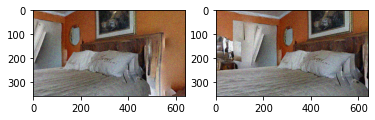

In [15]:
plt.subplot(1,2,1)
plt.imshow(im1)
plt.subplot(1,2,2)
plt.imshow(im2)

In [17]:
from ipywidgets import IntProgress
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16_conv_4_3 = nn.Sequential(*list(vgg16.children())[0][:22])
vgg16_conv_4_3.to(device)
for param in vgg16_conv_4_3.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [90]:
mean = [0.429, 0.431, 0.397]
std  = [1, 1, 1]
normalize = transforms.Normalize(mean=mean,std=std)
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((352, 640),interpolation = Image.NEAREST),
                                transforms.ToTensor(),
                                normalize])
negmean = [x * -1 for x in mean]
revNormalize = transforms.Normalize(mean=negmean, std=std)
TP = transforms.Compose([revNormalize, transforms.ToPILImage()])

In [101]:
I0 = transform(im1).unsqueeze(0).to(device)
I1 = transform(im2).unsqueeze(0).to(device)
flowOut = flowComp(torch.cat((I0, I1), dim=1))
F_0_1 = flowOut[:,:2,:,:]
F_1_0 = flowOut[:,2:,:,:]
fCoeff = model.getFlowCoeff(1, device)

AttributeError: 'int' object has no attribute 'detach'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


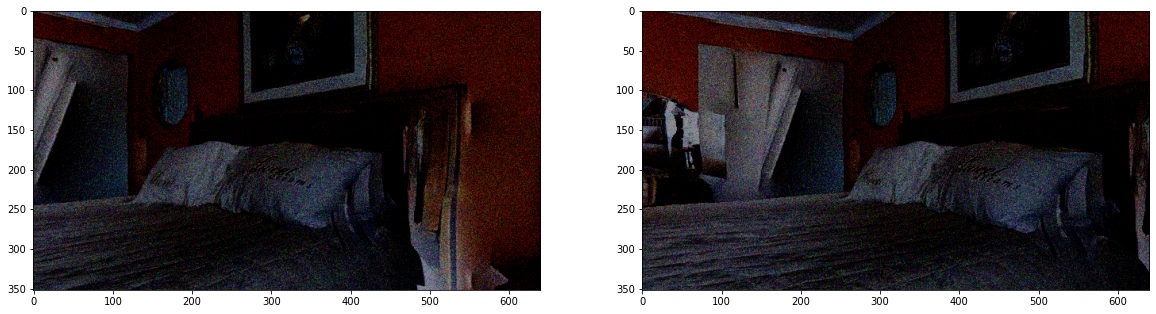

In [92]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(I0[0].permute(1,2,0).cpu())
plt.subplot(1,2,2)
plt.imshow(I1[0].permute(1,2,0).cpu())

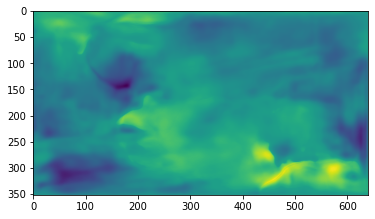

In [100]:
plt.imshow(F_1_0[0][1].cpu().detach().numpy())